<a href="https://colab.research.google.com/github/MadhuReddy001/Image-Captioning/blob/main/Image_Cap02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning using LSTM on Flickr8K dataset

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Concatenate, add
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

## Downloading Data and Dependencies

In [ ]:
!pip install tensorflow==2.8.0

In [1]:
!wget !wget https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1&e=1&dl=0

--2025-01-04 09:29:56--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2025-01-04 09:29:56--  https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc85d5cb47d10e0962fd0b55cbf0.dl.dropboxusercontent.com/zip_download_get/CE6ExYqFopxB2E62Y0rEyNkjSG1iEmqCebRT5BzWaugyUuFLoF4LjiaYuDbVPJFWpSqeuisr_kNeV0GmwZMndQK8J5yb2lzRraD5lh2zcVW7sQ# [following]
--2025-01-04 09:30:01--  https://uc85d5cb47d10e0962fd0b55cbf0.dl.dropboxusercontent.com/zip_download_get/CE6ExYqFopxB2E62Y0rEyNkjSG1iEmqCebRT5BzWaugyUuFLoF4LjiaYuDbVPJFWpSqeuisr_kNeV0GmwZMndQK8J5yb2lzRraD5lh2zcVW7sQ
Resolving uc85d5cb47d10e0962fd0b55cbf0.dl.dropboxusercontent.com (uc85d5

In [2]:
!unzip /content/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1

Streaming output truncated to the last 5000 lines.
 extracting: Flicker8k_Dataset/2083778090_3aecaa11cc.jpg  
 extracting: Flicker8k_Dataset/2089555297_95cf001fa7.jpg  
 extracting: Flicker8k_Dataset/2195887578_3ba2f29b48.jpg  
 extracting: Flicker8k_Dataset/2230067846_74046b89d3.jpg  
 extracting: Flicker8k_Dataset/2264316030_600e55748d.jpg  
 extracting: Flicker8k_Dataset/2271671533_7538ccd556.jpg  
 extracting: Flicker8k_Dataset/2420730259_86e7f8a815.jpg  
 extracting: Flicker8k_Dataset/2602085456_d1beebcb29.jpg  
 extracting: Flicker8k_Dataset/2687672606_275169c35d.jpg  
 extracting: Flicker8k_Dataset/2750867389_4b815f793a.jpg  
 extracting: Flicker8k_Dataset/2751694538_fffa3d307d.jpg  
 extracting: Flicker8k_Dataset/2809793070_1a3387cd6e.jpg  
 extracting: Flicker8k_Dataset/2871962580_b85ce502ba.jpg  
 extracting: Flicker8k_Dataset/2929272606_2a5923b38e.jpg  
 extracting: Flicker8k_Dataset/3015898903_70bebb8903.jpg  
 extracting: Flicker8k_Dataset/3018847610_0bf4d7e43d.jpg  
 extr

In [4]:
image_tokens=pd.read_csv("/content/Flickr8k_text/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/Flickr8k_text/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("/content/Flickr8k_text/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("/content/Flickr8k_text/Flickr_8k.devImages.txt",names=["img_id"])

In [6]:
l=os.listdir("/content/Flicker8k_Dataset")
print(len(l))

8091


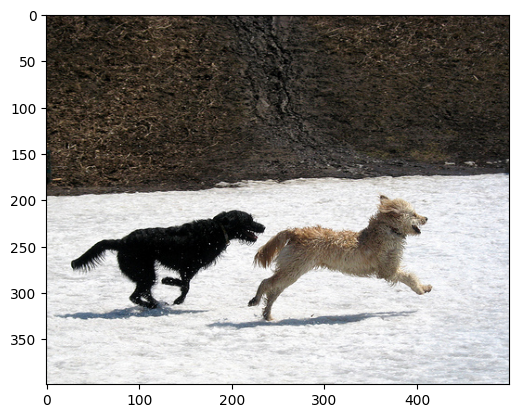

In [7]:
img=cv2.imread("/content/Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [8]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [9]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [10]:
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [11]:
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

In [12]:
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:31<00:00, 192.91it/s]


In [13]:
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:07<00:00, 140.92it/s]


In [14]:
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:04<00:00, 205.62it/s]


In [15]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
path="/content/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=os.path.join(path, image_name)
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/6000 [00:02<4:17:30,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  0%|          | 2/6000 [00:02<2:00:59,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 3/6000 [00:03<1:17:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  0%|          | 4/6000 [00:03<58:15,  1.72it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  0%|          | 5/6000 [00:03<47:38,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  0%|          | 6/6000 [00:03<40:52,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 7/6000 [00:04<36:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  0%|          | 8/6000 [00:04<33:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  0%|          | 9/6000 [00:04<31:48,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  0%|          | 10/6000 [00:05<30:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  0%|          | 11/6000 [00:05<28:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  0%|          | 12/6000 [00:05<27:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 13/6000 [00:05<27:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  0%|          | 14/6000 [00:06<26:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  0%|          | 15/6000 [00:06<26:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  0%|          | 16/6000 [00:06<27:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  0%|          | 17/6000 [00:06<27:21,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  0%|          | 18/6000 [00:07<26:50,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  0%|          | 19/6000 [00:07<26:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  0%|          | 20/6000 [00:07<26:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  0%|          | 21/6000 [00:07<25:43,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  0%|          | 22/6000 [00:08<25:24,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  0%|          | 23/6000 [00:08<25:09,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  0%|          | 24/6000 [00:08<26:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  0%|          | 25/6000 [00:08<25:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  0%|          | 26/6000 [00:09<25:15,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  0%|          | 27/6000 [00:09<25:02,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  0%|          | 28/6000 [00:09<25:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  0%|          | 29/6000 [00:09<25:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  0%|          | 30/6000 [00:10<25:15,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  1%|          | 31/6000 [00:10<25:33,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


  1%|          | 32/6000 [00:10<30:45,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


  1%|          | 33/6000 [00:11<34:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  1%|          | 34/6000 [00:11<39:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  1%|          | 35/6000 [00:12<44:42,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  1%|          | 36/6000 [00:13<51:42,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  1%|          | 37/6000 [00:13<51:35,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


  1%|          | 38/6000 [00:14<50:38,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


  1%|          | 39/6000 [00:14<56:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 40/6000 [00:16<1:22:44,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  1%|          | 41/6000 [00:16<1:17:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  1%|          | 42/6000 [00:17<1:09:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  1%|          | 43/6000 [00:17<1:01:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  1%|          | 44/6000 [00:18<51:09,  1.94it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  1%|          | 45/6000 [00:18<43:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  1%|          | 46/6000 [00:18<38:34,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  1%|          | 47/6000 [00:18<34:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  1%|          | 48/6000 [00:19<32:44,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  1%|          | 49/6000 [00:19<30:45,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  1%|          | 50/6000 [00:19<29:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  1%|          | 51/6000 [00:19<27:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  1%|          | 52/6000 [00:20<30:31,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  1%|          | 53/6000 [00:20<28:57,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  1%|          | 54/6000 [00:20<27:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  1%|          | 55/6000 [00:21<27:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  1%|          | 56/6000 [00:21<26:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  1%|          | 57/6000 [00:21<26:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  1%|          | 58/6000 [00:21<26:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  1%|          | 59/6000 [00:22<26:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  1%|          | 60/6000 [00:22<27:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  1%|          | 61/6000 [00:22<26:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  1%|          | 62/6000 [00:22<26:11,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  1%|          | 63/6000 [00:23<25:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  1%|          | 64/6000 [00:23<25:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  1%|          | 65/6000 [00:23<26:20,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  1%|          | 66/6000 [00:24<26:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  1%|          | 67/6000 [00:24<26:40,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  1%|          | 68/6000 [00:24<26:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  1%|          | 69/6000 [00:24<26:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  1%|          | 70/6000 [00:25<27:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  1%|          | 71/6000 [00:25<27:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  1%|          | 72/6000 [00:25<27:13,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  1%|          | 73/6000 [00:25<27:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  1%|          | 74/6000 [00:26<26:45,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  1%|▏         | 75/6000 [00:26<27:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  1%|▏         | 76/6000 [00:27<34:38,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  1%|▏         | 77/6000 [00:27<32:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  1%|▏         | 78/6000 [00:27<30:04,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  1%|▏         | 79/6000 [00:27<28:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


  1%|▏         | 80/6000 [00:28<31:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  1%|▏         | 81/6000 [00:28<33:45,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


  1%|▏         | 82/6000 [00:29<35:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  1%|▏         | 83/6000 [00:29<37:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  1%|▏         | 84/6000 [00:29<39:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


  1%|▏         | 85/6000 [00:30<40:02,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  1%|▏         | 86/6000 [00:30<41:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  1%|▏         | 87/6000 [00:31<41:42,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  1%|▏         | 88/6000 [00:31<42:16,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  1%|▏         | 89/6000 [00:32<42:35,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  2%|▏         | 90/6000 [00:32<44:54,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  2%|▏         | 91/6000 [00:33<46:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  2%|▏         | 92/6000 [00:33<55:02,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  2%|▏         | 93/6000 [00:34<53:47,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  2%|▏         | 94/6000 [00:34<53:41,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  2%|▏         | 95/6000 [00:35<45:56,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  2%|▏         | 96/6000 [00:35<39:44,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  2%|▏         | 97/6000 [00:35<35:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  2%|▏         | 98/6000 [00:35<32:48,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  2%|▏         | 99/6000 [00:36<30:56,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  2%|▏         | 100/6000 [00:36<29:53,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  2%|▏         | 101/6000 [00:36<29:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  2%|▏         | 102/6000 [00:37<28:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  2%|▏         | 103/6000 [00:37<27:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  2%|▏         | 104/6000 [00:37<26:12,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  2%|▏         | 105/6000 [00:37<26:27,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  2%|▏         | 106/6000 [00:38<25:57,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  2%|▏         | 107/6000 [00:38<25:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  2%|▏         | 108/6000 [00:38<26:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  2%|▏         | 109/6000 [00:39<29:08,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  2%|▏         | 110/6000 [00:39<27:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  2%|▏         | 111/6000 [00:39<27:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  2%|▏         | 112/6000 [00:39<27:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  2%|▏         | 113/6000 [00:40<27:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  2%|▏         | 114/6000 [00:40<27:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


  2%|▏         | 115/6000 [00:40<29:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  2%|▏         | 116/6000 [00:41<35:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  2%|▏         | 117/6000 [00:41<32:21,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  2%|▏         | 118/6000 [00:41<30:39,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  2%|▏         | 119/6000 [00:42<29:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  2%|▏         | 120/6000 [00:42<28:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  2%|▏         | 121/6000 [00:42<26:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  2%|▏         | 122/6000 [00:42<26:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  2%|▏         | 123/6000 [00:43<26:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  2%|▏         | 124/6000 [00:43<29:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  2%|▏         | 125/6000 [00:43<29:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


  2%|▏         | 126/6000 [00:44<31:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  2%|▏         | 127/6000 [00:44<43:55,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  2%|▏         | 128/6000 [00:45<44:09,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  2%|▏         | 129/6000 [00:45<43:52,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


  2%|▏         | 130/6000 [00:46<43:32,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  2%|▏         | 131/6000 [00:46<52:48,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


  2%|▏         | 132/6000 [00:47<1:00:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  2%|▏         | 133/6000 [00:48<1:02:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  2%|▏         | 134/6000 [00:48<58:49,  1.66it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  2%|▏         | 135/6000 [00:49<56:29,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


  2%|▏         | 136/6000 [00:50<56:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  2%|▏         | 137/6000 [00:50<59:19,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


  2%|▏         | 138/6000 [00:51<51:49,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  2%|▏         | 139/6000 [00:51<43:58,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  2%|▏         | 140/6000 [00:51<38:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  2%|▏         | 141/6000 [00:51<34:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  2%|▏         | 142/6000 [00:52<31:37,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  2%|▏         | 143/6000 [00:52<33:42,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


  2%|▏         | 144/6000 [00:52<37:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  2%|▏         | 145/6000 [00:53<34:10,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  2%|▏         | 146/6000 [00:53<31:00,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  2%|▏         | 147/6000 [00:53<29:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  2%|▏         | 148/6000 [00:54<28:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  2%|▏         | 149/6000 [00:54<27:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


  2%|▎         | 150/6000 [00:54<28:10,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  3%|▎         | 151/6000 [00:55<37:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


  3%|▎         | 152/6000 [00:55<39:53,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  3%|▎         | 153/6000 [00:55<35:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|▎         | 154/6000 [00:56<32:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  3%|▎         | 155/6000 [00:56<29:49,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 156/6000 [00:56<28:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 157/6000 [00:56<27:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  3%|▎         | 158/6000 [00:57<26:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  3%|▎         | 159/6000 [00:57<25:39,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  3%|▎         | 160/6000 [00:57<25:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  3%|▎         | 161/6000 [00:57<26:14,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  3%|▎         | 162/6000 [00:58<25:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  3%|▎         | 163/6000 [00:58<25:09,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 164/6000 [00:58<25:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 165/6000 [00:58<25:20,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  3%|▎         | 166/6000 [00:59<24:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  3%|▎         | 167/6000 [00:59<25:05,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  3%|▎         | 168/6000 [00:59<25:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  3%|▎         | 169/6000 [01:00<26:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  3%|▎         | 170/6000 [01:00<26:17,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


  3%|▎         | 171/6000 [01:00<29:56,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  3%|▎         | 172/6000 [01:01<34:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


  3%|▎         | 173/6000 [01:01<36:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


  3%|▎         | 174/6000 [01:02<38:01,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  3%|▎         | 175/6000 [01:02<38:35,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  3%|▎         | 176/6000 [01:03<48:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  3%|▎         | 177/6000 [01:03<46:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  3%|▎         | 178/6000 [01:04<54:36,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  3%|▎         | 179/6000 [01:05<1:00:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  3%|▎         | 180/6000 [01:05<58:53,  1.65it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  3%|▎         | 181/6000 [01:06<55:40,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  3%|▎         | 182/6000 [01:06<48:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  3%|▎         | 183/6000 [01:06<41:17,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  3%|▎         | 184/6000 [01:07<36:49,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


  3%|▎         | 185/6000 [01:07<38:24,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  3%|▎         | 186/6000 [01:08<43:04,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  3%|▎         | 187/6000 [01:08<37:20,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  3%|▎         | 188/6000 [01:08<33:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 189/6000 [01:08<31:44,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  3%|▎         | 190/6000 [01:09<29:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  3%|▎         | 191/6000 [01:09<27:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 192/6000 [01:09<30:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  3%|▎         | 193/6000 [01:09<28:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  3%|▎         | 194/6000 [01:10<27:45,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  3%|▎         | 195/6000 [01:10<27:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  3%|▎         | 196/6000 [01:10<27:27,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  3%|▎         | 197/6000 [01:11<27:02,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 198/6000 [01:11<26:43,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  3%|▎         | 199/6000 [01:11<31:02,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  3%|▎         | 200/6000 [01:12<41:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  3%|▎         | 201/6000 [01:13<49:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  3%|▎         | 202/6000 [01:13<47:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  3%|▎         | 203/6000 [01:13<40:50,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  3%|▎         | 204/6000 [01:14<35:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  3%|▎         | 205/6000 [01:14<32:00,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  3%|▎         | 206/6000 [01:14<29:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  3%|▎         | 207/6000 [01:14<29:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  3%|▎         | 208/6000 [01:15<28:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  3%|▎         | 209/6000 [01:15<28:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  4%|▎         | 210/6000 [01:15<28:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  4%|▎         | 211/6000 [01:16<30:54,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  4%|▎         | 212/6000 [01:16<44:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


  4%|▎         | 213/6000 [01:18<1:05:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  4%|▎         | 214/6000 [01:18<58:13,  1.66it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  4%|▎         | 215/6000 [01:19<56:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


  4%|▎         | 216/6000 [01:20<1:12:25,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


  4%|▎         | 217/6000 [01:21<1:14:39,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  4%|▎         | 218/6000 [01:21<1:08:25,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


  4%|▎         | 219/6000 [01:22<1:04:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  4%|▎         | 220/6000 [01:22<1:00:26,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  4%|▎         | 221/6000 [01:23<1:04:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  4%|▎         | 222/6000 [01:23<59:17,  1.62it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  4%|▎         | 223/6000 [01:24<48:45,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▎         | 224/6000 [01:24<41:42,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▍         | 225/6000 [01:24<36:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▍         | 226/6000 [01:25<33:22,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▍         | 227/6000 [01:25<31:23,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  4%|▍         | 228/6000 [01:25<29:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  4%|▍         | 229/6000 [01:25<28:50,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  4%|▍         | 230/6000 [01:26<27:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|▍         | 231/6000 [01:26<26:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  4%|▍         | 232/6000 [01:26<26:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  4%|▍         | 233/6000 [01:26<25:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  4%|▍         | 234/6000 [01:27<25:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|▍         | 235/6000 [01:27<24:59,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  4%|▍         | 236/6000 [01:27<25:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


  4%|▍         | 237/6000 [01:27<27:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  4%|▍         | 238/6000 [01:28<36:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  4%|▍         | 239/6000 [01:28<33:30,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  4%|▍         | 240/6000 [01:29<30:58,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  4%|▍         | 241/6000 [01:29<29:39,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  4%|▍         | 242/6000 [01:29<29:25,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  4%|▍         | 243/6000 [01:29<28:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  4%|▍         | 244/6000 [01:30<28:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  4%|▍         | 245/6000 [01:30<26:58,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  4%|▍         | 246/6000 [01:30<26:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  4%|▍         | 247/6000 [01:31<25:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  4%|▍         | 248/6000 [01:31<25:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  4%|▍         | 249/6000 [01:31<24:53,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  4%|▍         | 250/6000 [01:31<25:12,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  4%|▍         | 251/6000 [01:32<24:47,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  4%|▍         | 252/6000 [01:32<25:13,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  4%|▍         | 253/6000 [01:32<25:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  4%|▍         | 254/6000 [01:32<26:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  4%|▍         | 255/6000 [01:33<25:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  4%|▍         | 256/6000 [01:33<26:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  4%|▍         | 257/6000 [01:33<27:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


  4%|▍         | 258/6000 [01:34<29:21,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  4%|▍         | 259/6000 [01:34<34:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  4%|▍         | 260/6000 [01:35<37:31,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  4%|▍         | 261/6000 [01:35<39:02,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


  4%|▍         | 262/6000 [01:35<40:01,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


  4%|▍         | 263/6000 [01:36<49:49,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  4%|▍         | 264/6000 [01:37<47:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


  4%|▍         | 265/6000 [01:37<48:40,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  4%|▍         | 266/6000 [01:38<50:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  4%|▍         | 267/6000 [01:38<50:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  4%|▍         | 268/6000 [01:39<51:44,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  4%|▍         | 269/6000 [01:39<53:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


  4%|▍         | 270/6000 [01:40<54:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  5%|▍         | 271/6000 [01:40<47:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 272/6000 [01:41<40:52,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  5%|▍         | 273/6000 [01:41<36:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 274/6000 [01:41<33:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  5%|▍         | 275/6000 [01:41<30:23,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  5%|▍         | 276/6000 [01:42<28:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


  5%|▍         | 277/6000 [01:42<30:19,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  5%|▍         | 278/6000 [01:43<37:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  5%|▍         | 279/6000 [01:43<34:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  5%|▍         | 280/6000 [01:43<31:51,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|▍         | 281/6000 [01:43<29:26,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  5%|▍         | 282/6000 [01:44<27:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 283/6000 [01:44<27:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  5%|▍         | 284/6000 [01:44<26:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  5%|▍         | 285/6000 [01:44<25:49,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  5%|▍         | 286/6000 [01:45<25:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  5%|▍         | 287/6000 [01:45<25:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  5%|▍         | 288/6000 [01:45<25:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  5%|▍         | 289/6000 [01:46<25:16,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|▍         | 290/6000 [01:46<24:48,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▍         | 291/6000 [01:46<24:58,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  5%|▍         | 292/6000 [01:46<25:04,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


  5%|▍         | 293/6000 [01:47<27:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  5%|▍         | 294/6000 [01:47<27:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  5%|▍         | 295/6000 [01:47<27:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  5%|▍         | 296/6000 [01:48<27:08,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▍         | 297/6000 [01:48<26:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  5%|▍         | 298/6000 [01:48<27:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  5%|▍         | 299/6000 [01:48<27:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  5%|▌         | 300/6000 [01:49<27:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  5%|▌         | 301/6000 [01:49<27:01,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  5%|▌         | 302/6000 [01:49<27:02,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


  5%|▌         | 303/6000 [01:50<27:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  5%|▌         | 304/6000 [01:50<33:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  5%|▌         | 305/6000 [01:51<40:27,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


  5%|▌         | 306/6000 [01:51<48:08,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  5%|▌         | 307/6000 [01:52<48:19,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


  5%|▌         | 308/6000 [01:52<47:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


  5%|▌         | 309/6000 [01:53<45:16,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  5%|▌         | 310/6000 [01:53<44:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


  5%|▌         | 311/6000 [01:54<57:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


  5%|▌         | 312/6000 [01:55<1:02:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  5%|▌         | 313/6000 [01:55<59:07,  1.60it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  5%|▌         | 314/6000 [01:56<1:03:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  5%|▌         | 315/6000 [01:57<1:00:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


  5%|▌         | 316/6000 [01:57<56:05,  1.69it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  5%|▌         | 317/6000 [01:58<46:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  5%|▌         | 318/6000 [01:58<40:59,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  5%|▌         | 319/6000 [01:58<36:40,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  5%|▌         | 320/6000 [01:58<33:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  5%|▌         | 321/6000 [01:59<31:31,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▌         | 322/6000 [01:59<30:26,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  5%|▌         | 323/6000 [01:59<29:22,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


  5%|▌         | 324/6000 [02:00<29:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  5%|▌         | 325/6000 [02:00<34:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  5%|▌         | 326/6000 [02:00<32:56,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  5%|▌         | 327/6000 [02:01<30:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  5%|▌         | 328/6000 [02:01<30:07,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  5%|▌         | 329/6000 [02:01<29:26,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  6%|▌         | 330/6000 [02:02<28:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  6%|▌         | 331/6000 [02:02<27:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|▌         | 332/6000 [02:02<27:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  6%|▌         | 333/6000 [02:02<27:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  6%|▌         | 334/6000 [02:03<26:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  6%|▌         | 335/6000 [02:03<27:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  6%|▌         | 336/6000 [02:03<27:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  6%|▌         | 337/6000 [02:03<26:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|▌         | 338/6000 [02:04<26:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  6%|▌         | 339/6000 [02:04<26:59,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  6%|▌         | 340/6000 [02:04<30:26,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


  6%|▌         | 341/6000 [02:05<31:07,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  6%|▌         | 342/6000 [02:05<38:17,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  6%|▌         | 343/6000 [02:06<38:42,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  6%|▌         | 344/6000 [02:06<35:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  6%|▌         | 345/6000 [02:06<32:38,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  6%|▌         | 346/6000 [02:07<30:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  6%|▌         | 347/6000 [02:07<28:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  6%|▌         | 348/6000 [02:07<27:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  6%|▌         | 349/6000 [02:08<30:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  6%|▌         | 350/6000 [02:08<32:42,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  6%|▌         | 351/6000 [02:08<35:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  6%|▌         | 352/6000 [02:09<37:20,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


  6%|▌         | 353/6000 [02:09<38:15,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  6%|▌         | 354/6000 [02:10<38:38,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  6%|▌         | 355/6000 [02:10<40:07,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  6%|▌         | 356/6000 [02:11<41:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


  6%|▌         | 357/6000 [02:11<44:26,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  6%|▌         | 358/6000 [02:12<54:35,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


  6%|▌         | 359/6000 [02:13<54:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  6%|▌         | 360/6000 [02:13<59:11,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  6%|▌         | 361/6000 [02:14<57:44,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  6%|▌         | 362/6000 [02:14<48:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  6%|▌         | 363/6000 [02:14<40:51,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  6%|▌         | 364/6000 [02:15<36:36,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|▌         | 365/6000 [02:15<36:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  6%|▌         | 366/6000 [02:15<33:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  6%|▌         | 367/6000 [02:16<31:12,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  6%|▌         | 368/6000 [02:16<28:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


  6%|▌         | 369/6000 [02:16<33:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  6%|▌         | 370/6000 [02:17<32:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  6%|▌         | 371/6000 [02:17<29:51,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  6%|▌         | 372/6000 [02:17<28:32,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  6%|▌         | 373/6000 [02:18<27:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  6%|▌         | 374/6000 [02:18<26:11,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  6%|▋         | 375/6000 [02:18<25:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  6%|▋         | 376/6000 [02:18<25:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  6%|▋         | 377/6000 [02:19<25:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  6%|▋         | 378/6000 [02:19<25:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  6%|▋         | 379/6000 [02:19<24:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  6%|▋         | 380/6000 [02:19<24:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  6%|▋         | 381/6000 [02:20<24:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  6%|▋         | 382/6000 [02:20<25:10,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


  6%|▋         | 383/6000 [02:20<27:14,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


  6%|▋         | 384/6000 [02:21<33:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  6%|▋         | 385/6000 [02:21<30:38,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  6%|▋         | 386/6000 [02:21<29:05,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  6%|▋         | 387/6000 [02:22<27:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  6%|▋         | 388/6000 [02:22<26:38,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  6%|▋         | 389/6000 [02:22<27:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  6%|▋         | 390/6000 [02:22<27:26,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  7%|▋         | 391/6000 [02:23<26:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  7%|▋         | 392/6000 [02:23<26:43,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 393/6000 [02:23<26:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  7%|▋         | 394/6000 [02:23<25:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


  7%|▋         | 395/6000 [02:24<30:40,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


  7%|▋         | 396/6000 [02:24<35:52,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


  7%|▋         | 397/6000 [02:25<37:44,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


  7%|▋         | 398/6000 [02:25<39:02,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  7%|▋         | 399/6000 [02:26<38:46,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  7%|▋         | 400/6000 [02:26<40:06,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


  7%|▋         | 401/6000 [02:27<40:25,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  7%|▋         | 402/6000 [02:27<40:15,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


  7%|▋         | 403/6000 [02:28<41:13,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


  7%|▋         | 404/6000 [02:28<41:14,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  7%|▋         | 405/6000 [02:29<43:55,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  7%|▋         | 406/6000 [02:29<45:18,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  7%|▋         | 407/6000 [02:30<46:44,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  7%|▋         | 408/6000 [02:30<50:47,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  7%|▋         | 409/6000 [02:31<55:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  7%|▋         | 410/6000 [02:31<47:44,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  7%|▋         | 411/6000 [02:32<41:45,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  7%|▋         | 412/6000 [02:32<37:13,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  7%|▋         | 413/6000 [02:32<34:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  7%|▋         | 414/6000 [02:32<32:03,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 415/6000 [02:33<30:32,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  7%|▋         | 416/6000 [02:33<29:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  7%|▋         | 417/6000 [02:33<28:19,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  7%|▋         | 418/6000 [02:34<27:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  7%|▋         | 419/6000 [02:34<26:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 420/6000 [02:34<25:41,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  7%|▋         | 421/6000 [02:34<29:10,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 422/6000 [02:35<27:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  7%|▋         | 423/6000 [02:35<27:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  7%|▋         | 424/6000 [02:35<27:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  7%|▋         | 425/6000 [02:36<27:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  7%|▋         | 426/6000 [02:36<26:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


  7%|▋         | 427/6000 [02:36<27:26,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  7%|▋         | 428/6000 [02:36<27:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  7%|▋         | 429/6000 [02:37<26:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 430/6000 [02:37<26:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  7%|▋         | 431/6000 [02:37<26:18,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  7%|▋         | 432/6000 [02:38<25:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  7%|▋         | 433/6000 [02:38<25:10,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  7%|▋         | 434/6000 [02:38<24:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 435/6000 [02:38<25:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


  7%|▋         | 436/6000 [02:39<33:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  7%|▋         | 437/6000 [02:39<31:33,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  7%|▋         | 438/6000 [02:40<29:52,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  7%|▋         | 439/6000 [02:40<28:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  7%|▋         | 440/6000 [02:40<28:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  7%|▋         | 441/6000 [02:40<27:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 442/6000 [02:41<27:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  7%|▋         | 443/6000 [02:41<30:01,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


  7%|▋         | 444/6000 [02:42<34:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  7%|▋         | 445/6000 [02:42<36:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


  7%|▋         | 446/6000 [02:43<46:46,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


  7%|▋         | 447/6000 [02:43<45:53,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


  7%|▋         | 448/6000 [02:44<44:03,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  7%|▋         | 449/6000 [02:44<43:40,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  8%|▊         | 450/6000 [02:45<45:31,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  8%|▊         | 451/6000 [02:45<53:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  8%|▊         | 452/6000 [02:46<53:45,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  8%|▊         | 453/6000 [02:47<54:22,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


  8%|▊         | 454/6000 [02:47<50:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  8%|▊         | 455/6000 [02:47<43:09,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  8%|▊         | 456/6000 [02:48<37:59,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  8%|▊         | 457/6000 [02:48<34:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  8%|▊         | 458/6000 [02:48<32:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  8%|▊         | 459/6000 [02:48<30:07,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  8%|▊         | 460/6000 [02:49<28:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  8%|▊         | 461/6000 [02:49<27:44,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  8%|▊         | 462/6000 [02:49<27:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  8%|▊         | 463/6000 [02:50<26:51,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  8%|▊         | 464/6000 [02:50<25:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  8%|▊         | 465/6000 [02:50<25:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  8%|▊         | 466/6000 [02:50<25:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  8%|▊         | 467/6000 [02:51<25:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  8%|▊         | 468/6000 [02:51<25:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  8%|▊         | 469/6000 [02:51<25:44,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  8%|▊         | 470/6000 [02:52<25:55,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  8%|▊         | 471/6000 [02:52<25:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  8%|▊         | 472/6000 [02:52<26:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  8%|▊         | 473/6000 [02:52<26:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  8%|▊         | 474/6000 [02:53<26:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  8%|▊         | 475/6000 [02:53<26:18,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  8%|▊         | 476/6000 [02:53<26:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  8%|▊         | 477/6000 [02:54<26:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  8%|▊         | 478/6000 [02:54<26:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  8%|▊         | 479/6000 [02:54<25:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  8%|▊         | 480/6000 [02:54<25:54,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  8%|▊         | 481/6000 [02:55<26:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  8%|▊         | 482/6000 [02:55<25:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  8%|▊         | 483/6000 [02:55<25:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  8%|▊         | 484/6000 [02:55<26:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  8%|▊         | 485/6000 [02:56<26:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  8%|▊         | 486/6000 [02:56<26:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  8%|▊         | 487/6000 [02:56<26:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  8%|▊         | 488/6000 [02:57<26:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  8%|▊         | 489/6000 [02:57<26:12,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


  8%|▊         | 490/6000 [02:57<29:03,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


  8%|▊         | 491/6000 [02:58<33:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


  8%|▊         | 492/6000 [02:58<36:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  8%|▊         | 493/6000 [02:59<37:15,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  8%|▊         | 494/6000 [02:59<47:13,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


  8%|▊         | 495/6000 [03:00<44:53,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


  8%|▊         | 496/6000 [03:00<44:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


  8%|▊         | 497/6000 [03:01<51:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  8%|▊         | 498/6000 [03:02<51:58,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  8%|▊         | 499/6000 [03:02<57:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  8%|▊         | 500/6000 [03:04<1:09:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


  8%|▊         | 501/6000 [03:04<59:56,  1.53it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  8%|▊         | 502/6000 [03:04<50:18,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  8%|▊         | 503/6000 [03:05<43:03,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  8%|▊         | 504/6000 [03:05<37:51,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  8%|▊         | 505/6000 [03:05<33:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  8%|▊         | 506/6000 [03:05<31:12,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  8%|▊         | 507/6000 [03:06<28:48,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  8%|▊         | 508/6000 [03:06<27:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  8%|▊         | 509/6000 [03:06<27:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  8%|▊         | 510/6000 [03:06<27:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  9%|▊         | 511/6000 [03:07<26:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  9%|▊         | 512/6000 [03:07<29:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  9%|▊         | 513/6000 [03:07<28:33,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  9%|▊         | 514/6000 [03:08<27:42,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  9%|▊         | 515/6000 [03:08<26:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▊         | 516/6000 [03:08<26:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  9%|▊         | 517/6000 [03:08<25:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  9%|▊         | 518/6000 [03:09<25:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▊         | 519/6000 [03:09<25:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  9%|▊         | 520/6000 [03:09<26:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  9%|▊         | 521/6000 [03:10<26:39,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▊         | 522/6000 [03:10<26:17,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  9%|▊         | 523/6000 [03:10<25:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  9%|▊         | 524/6000 [03:10<25:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  9%|▉         | 525/6000 [03:11<24:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  9%|▉         | 526/6000 [03:11<24:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  9%|▉         | 527/6000 [03:11<25:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  9%|▉         | 528/6000 [03:12<25:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  9%|▉         | 529/6000 [03:12<28:21,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  9%|▉         | 530/6000 [03:12<30:51,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  9%|▉         | 531/6000 [03:13<28:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  9%|▉         | 532/6000 [03:13<27:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  9%|▉         | 533/6000 [03:13<27:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  9%|▉         | 534/6000 [03:13<27:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▉         | 535/6000 [03:14<26:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  9%|▉         | 536/6000 [03:14<30:49,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


  9%|▉         | 537/6000 [03:15<32:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


  9%|▉         | 538/6000 [03:15<33:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  9%|▉         | 539/6000 [03:15<34:43,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


  9%|▉         | 540/6000 [03:16<36:08,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  9%|▉         | 541/6000 [03:16<36:19,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


  9%|▉         | 542/6000 [03:17<37:33,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  9%|▉         | 543/6000 [03:17<46:30,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  9%|▉         | 544/6000 [03:18<46:41,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  9%|▉         | 545/6000 [03:19<53:23,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


  9%|▉         | 546/6000 [03:19<53:09,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  9%|▉         | 547/6000 [03:20<59:18,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  9%|▉         | 548/6000 [03:20<48:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  9%|▉         | 549/6000 [03:21<41:05,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  9%|▉         | 550/6000 [03:21<36:01,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  9%|▉         | 551/6000 [03:21<33:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  9%|▉         | 552/6000 [03:21<30:12,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  9%|▉         | 553/6000 [03:22<28:11,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  9%|▉         | 554/6000 [03:22<26:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  9%|▉         | 555/6000 [03:22<26:19,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  9%|▉         | 556/6000 [03:23<25:54,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  9%|▉         | 557/6000 [03:23<25:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  9%|▉         | 558/6000 [03:23<25:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  9%|▉         | 559/6000 [03:23<25:41,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  9%|▉         | 560/6000 [03:24<24:53,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  9%|▉         | 561/6000 [03:24<24:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  9%|▉         | 562/6000 [03:24<25:03,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  9%|▉         | 563/6000 [03:24<25:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  9%|▉         | 564/6000 [03:25<25:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  9%|▉         | 565/6000 [03:25<25:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


  9%|▉         | 566/6000 [03:25<25:56,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  9%|▉         | 567/6000 [03:26<25:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  9%|▉         | 568/6000 [03:26<25:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  9%|▉         | 569/6000 [03:26<26:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|▉         | 570/6000 [03:26<26:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 10%|▉         | 571/6000 [03:27<29:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 10%|▉         | 572/6000 [03:27<28:16,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 10%|▉         | 573/6000 [03:27<27:54,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 10%|▉         | 574/6000 [03:28<27:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 10%|▉         | 575/6000 [03:28<26:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 10%|▉         | 576/6000 [03:28<27:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 10%|▉         | 577/6000 [03:29<26:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 10%|▉         | 578/6000 [03:29<25:48,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|▉         | 579/6000 [03:29<25:42,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 10%|▉         | 580/6000 [03:29<26:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 10%|▉         | 581/6000 [03:30<25:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|▉         | 582/6000 [03:30<24:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 10%|▉         | 583/6000 [03:30<27:46,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 10%|▉         | 584/6000 [03:31<31:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 10%|▉         | 585/6000 [03:31<34:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 10%|▉         | 586/6000 [03:32<44:16,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 10%|▉         | 587/6000 [03:32<42:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 10%|▉         | 588/6000 [03:33<40:34,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 10%|▉         | 589/6000 [03:33<40:51,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 10%|▉         | 590/6000 [03:34<40:17,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 10%|▉         | 591/6000 [03:34<40:30,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 10%|▉         | 592/6000 [03:35<41:49,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 10%|▉         | 593/6000 [03:35<43:51,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 10%|▉         | 594/6000 [03:36<53:11,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 10%|▉         | 595/6000 [03:37<53:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 10%|▉         | 596/6000 [03:37<52:26,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 10%|▉         | 597/6000 [03:38<50:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 10%|▉         | 598/6000 [03:38<43:47,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 10%|▉         | 599/6000 [03:38<38:34,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 10%|█         | 600/6000 [03:39<34:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 10%|█         | 601/6000 [03:39<34:22,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 10%|█         | 602/6000 [03:39<31:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 10%|█         | 603/6000 [03:40<29:45,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 10%|█         | 604/6000 [03:40<28:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 10%|█         | 605/6000 [03:40<28:27,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 10%|█         | 606/6000 [03:40<27:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 10%|█         | 607/6000 [03:41<26:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 10%|█         | 608/6000 [03:41<26:24,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 10%|█         | 609/6000 [03:41<26:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 10%|█         | 610/6000 [03:42<26:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 10%|█         | 611/6000 [03:42<25:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 10%|█         | 612/6000 [03:42<25:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 10%|█         | 613/6000 [03:42<24:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 10%|█         | 614/6000 [03:43<24:21,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 10%|█         | 615/6000 [03:43<24:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 10%|█         | 616/6000 [03:43<26:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 10%|█         | 617/6000 [03:44<26:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|█         | 618/6000 [03:44<26:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 10%|█         | 619/6000 [03:44<26:28,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|█         | 620/6000 [03:44<26:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 10%|█         | 621/6000 [03:45<26:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 10%|█         | 622/6000 [03:45<26:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 10%|█         | 623/6000 [03:45<27:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 10%|█         | 624/6000 [03:46<26:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 10%|█         | 625/6000 [03:46<25:53,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 10%|█         | 626/6000 [03:46<25:52,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 10%|█         | 627/6000 [03:46<25:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 10%|█         | 628/6000 [03:47<25:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 10%|█         | 629/6000 [03:47<25:38,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 10%|█         | 630/6000 [03:47<26:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 11%|█         | 631/6000 [03:48<26:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 11%|█         | 632/6000 [03:48<29:44,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 11%|█         | 633/6000 [03:49<33:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 11%|█         | 634/6000 [03:49<35:17,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 11%|█         | 635/6000 [03:50<45:16,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 11%|█         | 636/6000 [03:50<43:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 11%|█         | 637/6000 [03:51<41:55,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 11%|█         | 638/6000 [03:51<41:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 11%|█         | 639/6000 [03:52<48:53,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 11%|█         | 640/6000 [03:52<48:05,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 11%|█         | 641/6000 [03:53<46:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 11%|█         | 642/6000 [03:53<46:42,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 11%|█         | 643/6000 [03:54<43:42,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 11%|█         | 644/6000 [03:54<37:53,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 11%|█         | 645/6000 [03:54<33:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 646/6000 [03:55<30:23,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 11%|█         | 647/6000 [03:55<28:33,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 11%|█         | 648/6000 [03:55<26:52,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 649/6000 [03:55<25:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 11%|█         | 650/6000 [03:56<25:00,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 11%|█         | 651/6000 [03:56<24:28,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 11%|█         | 652/6000 [03:56<24:29,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 11%|█         | 653/6000 [03:56<24:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 11%|█         | 654/6000 [03:57<23:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 11%|█         | 655/6000 [03:57<24:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 11%|█         | 656/6000 [03:57<24:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 11%|█         | 657/6000 [03:58<24:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 11%|█         | 658/6000 [03:58<24:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 11%|█         | 659/6000 [03:58<25:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 11%|█         | 660/6000 [03:58<25:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 11%|█         | 661/6000 [03:59<24:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 11%|█         | 662/6000 [03:59<24:55,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 11%|█         | 663/6000 [03:59<24:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 11%|█         | 664/6000 [03:59<24:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 11%|█         | 665/6000 [04:00<23:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 11%|█         | 666/6000 [04:00<23:51,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 11%|█         | 667/6000 [04:00<24:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 11%|█         | 668/6000 [04:01<24:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 11%|█         | 669/6000 [04:01<24:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 11%|█         | 670/6000 [04:01<24:56,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 11%|█         | 671/6000 [04:01<24:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 11%|█         | 672/6000 [04:02<24:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 11%|█         | 673/6000 [04:02<25:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 11%|█         | 674/6000 [04:02<25:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 11%|█▏        | 675/6000 [04:03<25:04,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 11%|█▏        | 676/6000 [04:03<25:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 11%|█▏        | 677/6000 [04:03<25:52,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 11%|█▏        | 678/6000 [04:03<25:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 11%|█▏        | 679/6000 [04:04<26:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 11%|█▏        | 680/6000 [04:04<29:53,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 11%|█▏        | 681/6000 [04:05<32:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 11%|█▏        | 682/6000 [04:05<34:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 11%|█▏        | 683/6000 [04:06<36:30,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 11%|█▏        | 684/6000 [04:06<37:26,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 11%|█▏        | 685/6000 [04:06<38:39,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 11%|█▏        | 686/6000 [04:07<39:29,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 11%|█▏        | 687/6000 [04:07<40:26,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 11%|█▏        | 688/6000 [04:08<42:42,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 11%|█▏        | 689/6000 [04:09<51:19,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 12%|█▏        | 690/6000 [04:10<56:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 12%|█▏        | 691/6000 [04:10<1:00:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 12%|█▏        | 692/6000 [04:11<53:56,  1.64it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 12%|█▏        | 693/6000 [04:11<45:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 12%|█▏        | 694/6000 [04:11<39:50,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 12%|█▏        | 695/6000 [04:12<35:01,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 12%|█▏        | 696/6000 [04:12<31:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 12%|█▏        | 697/6000 [04:12<29:21,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 12%|█▏        | 698/6000 [04:12<27:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 12%|█▏        | 699/6000 [04:13<26:08,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█▏        | 700/6000 [04:13<25:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 12%|█▏        | 701/6000 [04:13<25:13,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 12%|█▏        | 702/6000 [04:13<24:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 12%|█▏        | 703/6000 [04:14<24:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█▏        | 704/6000 [04:14<24:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 705/6000 [04:14<24:11,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 12%|█▏        | 706/6000 [04:15<24:10,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 707/6000 [04:15<24:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 12%|█▏        | 708/6000 [04:16<37:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 12%|█▏        | 709/6000 [04:16<36:46,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 12%|█▏        | 710/6000 [04:16<35:11,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 12%|█▏        | 711/6000 [04:17<33:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 12%|█▏        | 712/6000 [04:17<33:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 12%|█▏        | 713/6000 [04:17<34:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 12%|█▏        | 714/6000 [04:18<32:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 12%|█▏        | 715/6000 [04:18<34:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 12%|█▏        | 716/6000 [04:19<35:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 12%|█▏        | 717/6000 [04:19<44:52,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 12%|█▏        | 718/6000 [04:20<41:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 12%|█▏        | 719/6000 [04:20<41:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 12%|█▏        | 720/6000 [04:21<41:36,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 12%|█▏        | 721/6000 [04:22<48:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 12%|█▏        | 722/6000 [04:22<46:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 12%|█▏        | 723/6000 [04:22<44:26,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 12%|█▏        | 724/6000 [04:23<42:38,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 12%|█▏        | 725/6000 [04:24<50:29,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 12%|█▏        | 726/6000 [04:24<47:55,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 12%|█▏        | 727/6000 [04:25<46:22,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 12%|█▏        | 728/6000 [04:25<45:27,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 12%|█▏        | 729/6000 [04:26<51:58,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 12%|█▏        | 730/6000 [04:26<52:25,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 12%|█▏        | 731/6000 [04:27<52:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 12%|█▏        | 732/6000 [04:28<51:05,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 12%|█▏        | 733/6000 [04:28<49:44,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 12%|█▏        | 734/6000 [04:29<45:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 12%|█▏        | 735/6000 [04:29<38:40,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 12%|█▏        | 736/6000 [04:29<34:18,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█▏        | 737/6000 [04:29<30:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 738/6000 [04:30<28:35,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 739/6000 [04:30<27:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 12%|█▏        | 740/6000 [04:30<26:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█▏        | 741/6000 [04:30<25:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 12%|█▏        | 742/6000 [04:31<24:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 12%|█▏        | 743/6000 [04:31<24:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 12%|█▏        | 744/6000 [04:31<25:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 12%|█▏        | 745/6000 [04:32<25:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 12%|█▏        | 746/6000 [04:32<25:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 12%|█▏        | 747/6000 [04:32<25:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 748/6000 [04:32<25:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 12%|█▏        | 749/6000 [04:33<25:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▎        | 750/6000 [04:33<28:32,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 13%|█▎        | 751/6000 [04:33<27:35,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 13%|█▎        | 752/6000 [04:34<26:44,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 13%|█▎        | 753/6000 [04:34<26:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█▎        | 754/6000 [04:34<29:14,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 13%|█▎        | 755/6000 [04:35<27:50,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 13%|█▎        | 756/6000 [04:35<27:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█▎        | 757/6000 [04:35<26:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 758/6000 [04:36<24:55,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 13%|█▎        | 759/6000 [04:36<24:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 13%|█▎        | 760/6000 [04:36<25:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 13%|█▎        | 761/6000 [04:36<25:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 13%|█▎        | 762/6000 [04:37<25:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 763/6000 [04:37<25:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 764/6000 [04:37<25:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 13%|█▎        | 765/6000 [04:38<25:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 13%|█▎        | 766/6000 [04:38<25:18,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 13%|█▎        | 767/6000 [04:38<25:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█▎        | 768/6000 [04:38<24:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 13%|█▎        | 769/6000 [04:39<27:28,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 13%|█▎        | 770/6000 [04:39<31:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 13%|█▎        | 771/6000 [04:40<34:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 13%|█▎        | 772/6000 [04:40<36:22,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 13%|█▎        | 773/6000 [04:41<36:33,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 13%|█▎        | 774/6000 [04:41<37:02,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 13%|█▎        | 775/6000 [04:42<38:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 13%|█▎        | 776/6000 [04:42<39:03,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 13%|█▎        | 777/6000 [04:43<39:11,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|█▎        | 778/6000 [04:43<42:03,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|█▎        | 779/6000 [04:44<43:15,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 13%|█▎        | 780/6000 [04:44<43:26,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 13%|█▎        | 781/6000 [04:45<42:12,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 13%|█▎        | 782/6000 [04:45<42:28,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 13%|█▎        | 783/6000 [04:45<37:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 13%|█▎        | 784/6000 [04:46<34:31,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 13%|█▎        | 785/6000 [04:46<31:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 13%|█▎        | 786/6000 [04:46<29:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 13%|█▎        | 787/6000 [04:47<29:18,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 788/6000 [04:47<28:33,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 789/6000 [04:47<27:48,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 13%|█▎        | 790/6000 [04:47<26:51,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 13%|█▎        | 791/6000 [04:48<27:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 13%|█▎        | 792/6000 [04:48<26:33,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█▎        | 793/6000 [04:48<25:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 13%|█▎        | 794/6000 [04:49<25:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 13%|█▎        | 795/6000 [04:49<33:27,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 13%|█▎        | 796/6000 [04:50<30:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 13%|█▎        | 797/6000 [04:50<28:41,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 13%|█▎        | 798/6000 [04:50<27:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 13%|█▎        | 799/6000 [04:50<26:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 13%|█▎        | 800/6000 [04:51<25:18,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 13%|█▎        | 801/6000 [04:51<25:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 13%|█▎        | 802/6000 [04:51<24:32,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 13%|█▎        | 803/6000 [04:51<23:56,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█▎        | 804/6000 [04:52<23:32,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 13%|█▎        | 805/6000 [04:52<23:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 13%|█▎        | 806/6000 [04:52<23:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 13%|█▎        | 807/6000 [04:53<23:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 13%|█▎        | 808/6000 [04:53<25:04,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 13%|█▎        | 809/6000 [04:53<25:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|█▎        | 810/6000 [04:53<25:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 14%|█▎        | 811/6000 [04:54<25:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 14%|█▎        | 812/6000 [04:54<25:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 14%|█▎        | 813/6000 [04:54<25:27,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|█▎        | 814/6000 [04:55<25:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 14%|█▎        | 815/6000 [04:55<25:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 14%|█▎        | 816/6000 [04:55<26:34,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 14%|█▎        | 817/6000 [04:56<29:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 14%|█▎        | 818/6000 [04:56<39:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 14%|█▎        | 819/6000 [04:57<38:45,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 14%|█▎        | 820/6000 [04:57<38:27,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 14%|█▎        | 821/6000 [04:58<37:24,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 14%|█▎        | 822/6000 [04:58<37:22,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 14%|█▎        | 823/6000 [04:59<38:51,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 14%|█▎        | 824/6000 [04:59<40:23,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 14%|█▍        | 825/6000 [05:00<43:28,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 14%|█▍        | 826/6000 [05:00<44:39,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 14%|█▍        | 827/6000 [05:01<45:20,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 14%|█▍        | 828/6000 [05:01<45:56,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 14%|█▍        | 829/6000 [05:02<51:27,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 14%|█▍        | 830/6000 [05:02<44:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|█▍        | 831/6000 [05:03<37:56,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 14%|█▍        | 832/6000 [05:03<33:39,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|█▍        | 833/6000 [05:03<30:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 14%|█▍        | 834/6000 [05:04<28:44,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 14%|█▍        | 835/6000 [05:04<27:53,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 14%|█▍        | 836/6000 [05:04<27:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|█▍        | 837/6000 [05:04<26:48,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 14%|█▍        | 838/6000 [05:05<26:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 14%|█▍        | 839/6000 [05:05<25:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 840/6000 [05:05<25:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 14%|█▍        | 841/6000 [05:06<24:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 14%|█▍        | 842/6000 [05:06<24:08,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 14%|█▍        | 843/6000 [05:06<23:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 14%|█▍        | 844/6000 [05:06<23:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 14%|█▍        | 845/6000 [05:07<36:45,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 14%|█▍        | 846/6000 [05:07<32:58,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 14%|█▍        | 847/6000 [05:08<31:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 14%|█▍        | 848/6000 [05:08<29:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 14%|█▍        | 849/6000 [05:08<28:08,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 850/6000 [05:09<26:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 14%|█▍        | 851/6000 [05:09<26:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 852/6000 [05:09<25:22,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 14%|█▍        | 853/6000 [05:09<25:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 14%|█▍        | 854/6000 [05:10<27:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 14%|█▍        | 855/6000 [05:10<26:18,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 14%|█▍        | 856/6000 [05:10<25:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|█▍        | 857/6000 [05:11<25:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 14%|█▍        | 858/6000 [05:11<25:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 14%|█▍        | 859/6000 [05:11<25:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 14%|█▍        | 860/6000 [05:12<25:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 14%|█▍        | 861/6000 [05:12<25:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 14%|█▍        | 862/6000 [05:12<25:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 14%|█▍        | 863/6000 [05:13<28:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 14%|█▍        | 864/6000 [05:13<31:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 14%|█▍        | 865/6000 [05:14<41:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 14%|█▍        | 866/6000 [05:14<39:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 14%|█▍        | 867/6000 [05:15<38:36,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 14%|█▍        | 868/6000 [05:15<37:36,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 14%|█▍        | 869/6000 [05:15<37:51,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 14%|█▍        | 870/6000 [05:16<41:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 15%|█▍        | 871/6000 [05:17<42:50,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 15%|█▍        | 872/6000 [05:17<42:44,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 15%|█▍        | 873/6000 [05:18<44:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 15%|█▍        | 874/6000 [05:18<45:58,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 15%|█▍        | 875/6000 [05:19<39:49,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 15%|█▍        | 876/6000 [05:19<34:33,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 15%|█▍        | 877/6000 [05:19<31:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 15%|█▍        | 878/6000 [05:19<29:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 15%|█▍        | 879/6000 [05:20<28:13,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|█▍        | 880/6000 [05:20<27:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 15%|█▍        | 881/6000 [05:20<26:28,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 15%|█▍        | 882/6000 [05:21<25:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 15%|█▍        | 883/6000 [05:21<24:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 15%|█▍        | 884/6000 [05:21<24:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 15%|█▍        | 885/6000 [05:21<24:39,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 15%|█▍        | 886/6000 [05:22<23:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 15%|█▍        | 887/6000 [05:22<23:20,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 15%|█▍        | 888/6000 [05:22<23:49,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 15%|█▍        | 889/6000 [05:22<24:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 15%|█▍        | 890/6000 [05:23<24:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|█▍        | 891/6000 [05:23<24:12,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 15%|█▍        | 892/6000 [05:23<24:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 15%|█▍        | 893/6000 [05:24<25:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 15%|█▍        | 894/6000 [05:24<25:13,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 15%|█▍        | 895/6000 [05:24<24:58,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 15%|█▍        | 896/6000 [05:25<24:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 15%|█▍        | 897/6000 [05:25<24:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 15%|█▍        | 898/6000 [05:25<23:29,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 15%|█▍        | 899/6000 [05:25<23:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 15%|█▌        | 900/6000 [05:26<23:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 15%|█▌        | 901/6000 [05:26<23:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 15%|█▌        | 902/6000 [05:26<23:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 15%|█▌        | 903/6000 [05:26<22:58,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 15%|█▌        | 904/6000 [05:27<23:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 15%|█▌        | 905/6000 [05:27<23:00,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 15%|█▌        | 906/6000 [05:27<23:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 15%|█▌        | 907/6000 [05:28<23:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 15%|█▌        | 908/6000 [05:28<23:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 15%|█▌        | 909/6000 [05:28<23:03,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 15%|█▌        | 910/6000 [05:28<23:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 15%|█▌        | 911/6000 [05:29<27:57,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 15%|█▌        | 912/6000 [05:29<31:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 15%|█▌        | 913/6000 [05:30<33:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 15%|█▌        | 914/6000 [05:30<35:49,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 15%|█▌        | 915/6000 [05:31<37:00,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 15%|█▌        | 916/6000 [05:31<38:02,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 15%|█▌        | 917/6000 [05:32<39:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 15%|█▌        | 918/6000 [05:32<39:29,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 15%|█▌        | 919/6000 [05:33<39:23,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 15%|█▌        | 920/6000 [05:33<38:56,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 15%|█▌        | 921/6000 [05:34<40:31,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 15%|█▌        | 922/6000 [05:34<43:38,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 15%|█▌        | 923/6000 [05:35<45:44,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 15%|█▌        | 924/6000 [05:35<47:21,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 15%|█▌        | 925/6000 [05:36<48:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 15%|█▌        | 926/6000 [05:36<46:50,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 15%|█▌        | 927/6000 [05:37<40:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 15%|█▌        | 928/6000 [05:37<35:42,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 15%|█▌        | 929/6000 [05:37<33:37,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 16%|█▌        | 930/6000 [05:38<31:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 16%|█▌        | 931/6000 [05:38<29:11,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 16%|█▌        | 932/6000 [05:38<28:35,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 16%|█▌        | 933/6000 [05:39<27:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 16%|█▌        | 934/6000 [05:39<26:30,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 16%|█▌        | 935/6000 [05:39<25:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 16%|█▌        | 936/6000 [05:40<26:28,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|█▌        | 937/6000 [05:40<25:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 16%|█▌        | 938/6000 [05:40<24:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 16%|█▌        | 939/6000 [05:40<24:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 16%|█▌        | 940/6000 [05:41<24:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 16%|█▌        | 941/6000 [05:41<24:21,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 16%|█▌        | 942/6000 [05:41<24:35,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 16%|█▌        | 943/6000 [05:42<24:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 16%|█▌        | 944/6000 [05:42<24:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 16%|█▌        | 945/6000 [05:42<23:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 16%|█▌        | 946/6000 [05:42<23:29,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▌        | 947/6000 [05:43<23:18,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|█▌        | 948/6000 [05:43<23:00,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|█▌        | 949/6000 [05:43<22:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|█▌        | 950/6000 [05:43<22:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 16%|█▌        | 951/6000 [05:44<25:51,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 16%|█▌        | 952/6000 [05:44<25:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 16%|█▌        | 953/6000 [05:44<25:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 16%|█▌        | 954/6000 [05:45<28:15,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 16%|█▌        | 955/6000 [05:45<26:58,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 16%|█▌        | 956/6000 [05:45<26:51,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 16%|█▌        | 957/6000 [05:46<26:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▌        | 958/6000 [05:46<25:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 16%|█▌        | 959/6000 [05:46<24:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 16%|█▌        | 960/6000 [05:47<24:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 16%|█▌        | 961/6000 [05:47<28:35,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 16%|█▌        | 962/6000 [05:47<31:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 16%|█▌        | 963/6000 [05:48<35:11,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 16%|█▌        | 964/6000 [05:48<35:43,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 16%|█▌        | 965/6000 [05:49<37:40,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 16%|█▌        | 966/6000 [05:49<37:37,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 16%|█▌        | 967/6000 [05:50<46:13,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 16%|█▌        | 968/6000 [05:51<47:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 16%|█▌        | 969/6000 [05:51<48:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 16%|█▌        | 970/6000 [05:52<49:38,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 16%|█▌        | 971/6000 [05:53<54:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 16%|█▌        | 972/6000 [05:53<49:35,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|█▌        | 973/6000 [05:53<41:30,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 16%|█▌        | 974/6000 [05:54<35:38,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▋        | 975/6000 [05:54<31:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 16%|█▋        | 976/6000 [05:54<29:35,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 16%|█▋        | 977/6000 [05:55<27:27,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 16%|█▋        | 978/6000 [05:55<26:18,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 16%|█▋        | 979/6000 [05:55<26:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 16%|█▋        | 980/6000 [05:55<25:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 16%|█▋        | 981/6000 [05:56<25:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 16%|█▋        | 982/6000 [05:56<25:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 16%|█▋        | 983/6000 [05:56<25:35,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 16%|█▋        | 984/6000 [05:57<25:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 16%|█▋        | 985/6000 [05:57<24:42,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|█▋        | 986/6000 [05:57<24:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 16%|█▋        | 987/6000 [05:58<23:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|█▋        | 988/6000 [05:58<23:13,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|█▋        | 989/6000 [05:58<23:14,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 16%|█▋        | 990/6000 [05:58<23:22,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 17%|█▋        | 991/6000 [05:59<22:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 17%|█▋        | 992/6000 [05:59<22:50,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 17%|█▋        | 993/6000 [05:59<22:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 17%|█▋        | 994/6000 [05:59<22:58,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 17%|█▋        | 995/6000 [06:00<22:39,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|█▋        | 996/6000 [06:00<22:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 17%|█▋        | 997/6000 [06:00<23:26,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 17%|█▋        | 998/6000 [06:01<23:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 999/6000 [06:01<23:38,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█▋        | 1000/6000 [06:01<23:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 17%|█▋        | 1001/6000 [06:01<24:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 1002/6000 [06:02<24:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█▋        | 1003/6000 [06:02<24:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 17%|█▋        | 1004/6000 [06:02<24:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█▋        | 1005/6000 [06:03<24:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|█▋        | 1006/6000 [06:03<23:41,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 17%|█▋        | 1007/6000 [06:03<23:53,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 17%|█▋        | 1008/6000 [06:04<28:22,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 17%|█▋        | 1009/6000 [06:04<31:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 17%|█▋        | 1010/6000 [06:05<34:17,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 17%|█▋        | 1011/6000 [06:05<44:04,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 17%|█▋        | 1012/6000 [06:06<41:49,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 17%|█▋        | 1013/6000 [06:07<48:56,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 17%|█▋        | 1014/6000 [06:07<47:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 17%|█▋        | 1015/6000 [06:08<47:06,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 17%|█▋        | 1016/6000 [06:08<46:20,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 17%|█▋        | 1017/6000 [06:09<46:58,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 17%|█▋        | 1018/6000 [06:10<53:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 17%|█▋        | 1019/6000 [06:10<44:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 1020/6000 [06:10<38:33,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 17%|█▋        | 1021/6000 [06:11<33:30,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 17%|█▋        | 1022/6000 [06:11<29:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 17%|█▋        | 1023/6000 [06:11<28:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█▋        | 1024/6000 [06:11<29:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 17%|█▋        | 1025/6000 [06:12<27:58,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 17%|█▋        | 1026/6000 [06:12<27:11,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1027/6000 [06:12<26:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1028/6000 [06:13<25:39,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 17%|█▋        | 1029/6000 [06:13<25:09,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 17%|█▋        | 1030/6000 [06:13<25:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 17%|█▋        | 1031/6000 [06:14<24:38,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 17%|█▋        | 1032/6000 [06:14<24:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 17%|█▋        | 1033/6000 [06:14<24:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1034/6000 [06:15<27:17,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 17%|█▋        | 1035/6000 [06:15<25:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 17%|█▋        | 1036/6000 [06:15<25:19,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 17%|█▋        | 1037/6000 [06:15<25:42,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 17%|█▋        | 1038/6000 [06:16<24:34,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 17%|█▋        | 1039/6000 [06:16<23:55,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 1040/6000 [06:16<23:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 17%|█▋        | 1041/6000 [06:16<23:06,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1042/6000 [06:17<23:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 17%|█▋        | 1043/6000 [06:17<22:55,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 17%|█▋        | 1044/6000 [06:17<23:35,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1045/6000 [06:18<23:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 1046/6000 [06:18<23:32,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 17%|█▋        | 1047/6000 [06:18<23:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█▋        | 1048/6000 [06:18<24:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 17%|█▋        | 1049/6000 [06:19<23:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 18%|█▊        | 1050/6000 [06:19<23:18,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|█▊        | 1051/6000 [06:19<23:40,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 18%|█▊        | 1052/6000 [06:20<25:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 18%|█▊        | 1053/6000 [06:20<28:12,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 18%|█▊        | 1054/6000 [06:21<38:01,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 18%|█▊        | 1055/6000 [06:21<38:39,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 18%|█▊        | 1056/6000 [06:22<38:20,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 18%|█▊        | 1057/6000 [06:22<37:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 18%|█▊        | 1058/6000 [06:23<44:44,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 18%|█▊        | 1059/6000 [06:24<50:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 18%|█▊        | 1060/6000 [06:24<48:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 18%|█▊        | 1061/6000 [06:25<54:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 18%|█▊        | 1062/6000 [06:26<57:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 18%|█▊        | 1063/6000 [06:26<47:47,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 18%|█▊        | 1064/6000 [06:27<40:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 18%|█▊        | 1065/6000 [06:27<35:13,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 18%|█▊        | 1066/6000 [06:27<31:38,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 18%|█▊        | 1067/6000 [06:27<28:51,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 18%|█▊        | 1068/6000 [06:28<26:36,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 18%|█▊        | 1069/6000 [06:28<25:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 18%|█▊        | 1070/6000 [06:28<24:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 18%|█▊        | 1071/6000 [06:28<23:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 18%|█▊        | 1072/6000 [06:29<23:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 18%|█▊        | 1073/6000 [06:29<23:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 18%|█▊        | 1074/6000 [06:29<23:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█▊        | 1075/6000 [06:30<23:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 18%|█▊        | 1076/6000 [06:30<22:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 18%|█▊        | 1077/6000 [06:30<25:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 18%|█▊        | 1078/6000 [06:30<24:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 18%|█▊        | 1079/6000 [06:31<23:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 18%|█▊        | 1080/6000 [06:31<23:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 18%|█▊        | 1081/6000 [06:31<22:57,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 18%|█▊        | 1082/6000 [06:32<22:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 18%|█▊        | 1083/6000 [06:32<22:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|█▊        | 1084/6000 [06:32<22:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 18%|█▊        | 1085/6000 [06:32<22:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 18%|█▊        | 1086/6000 [06:33<23:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 18%|█▊        | 1087/6000 [06:33<23:39,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 18%|█▊        | 1088/6000 [06:33<24:43,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 18%|█▊        | 1089/6000 [06:34<24:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█▊        | 1090/6000 [06:34<23:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 18%|█▊        | 1091/6000 [06:34<23:58,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 18%|█▊        | 1092/6000 [06:34<23:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 18%|█▊        | 1093/6000 [06:35<23:02,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 18%|█▊        | 1094/6000 [06:35<23:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 18%|█▊        | 1095/6000 [06:35<23:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 18%|█▊        | 1096/6000 [06:36<23:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█▊        | 1097/6000 [06:36<26:30,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 18%|█▊        | 1098/6000 [06:36<29:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 18%|█▊        | 1099/6000 [06:37<32:22,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 18%|█▊        | 1100/6000 [06:37<34:51,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 18%|█▊        | 1101/6000 [06:38<35:19,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 18%|█▊        | 1102/6000 [06:38<35:14,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 18%|█▊        | 1103/6000 [06:39<34:58,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 18%|█▊        | 1104/6000 [06:39<35:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 18%|█▊        | 1105/6000 [06:40<37:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 18%|█▊        | 1106/6000 [06:40<40:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 18%|█▊        | 1107/6000 [06:41<46:01,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 18%|█▊        | 1108/6000 [06:42<50:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 18%|█▊        | 1109/6000 [06:42<48:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 18%|█▊        | 1110/6000 [06:43<42:39,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 19%|█▊        | 1111/6000 [06:43<36:23,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 19%|█▊        | 1112/6000 [06:43<32:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▊        | 1113/6000 [06:43<29:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|█▊        | 1114/6000 [06:44<28:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▊        | 1115/6000 [06:44<26:56,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 19%|█▊        | 1116/6000 [06:44<26:25,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|█▊        | 1117/6000 [06:45<25:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|█▊        | 1118/6000 [06:45<25:24,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 19%|█▊        | 1119/6000 [06:45<27:25,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 19%|█▊        | 1120/6000 [06:46<25:48,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 19%|█▊        | 1121/6000 [06:46<26:07,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|█▊        | 1122/6000 [06:46<25:04,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 19%|█▊        | 1123/6000 [06:47<23:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 19%|█▊        | 1124/6000 [06:47<23:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▉        | 1125/6000 [06:47<23:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 1126/6000 [06:47<23:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|█▉        | 1127/6000 [06:48<26:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 19%|█▉        | 1128/6000 [06:48<25:38,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 19%|█▉        | 1129/6000 [06:48<25:14,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 19%|█▉        | 1130/6000 [06:49<24:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 19%|█▉        | 1131/6000 [06:49<24:54,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 19%|█▉        | 1132/6000 [06:49<24:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 19%|█▉        | 1133/6000 [06:50<23:43,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 19%|█▉        | 1134/6000 [06:50<23:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 19%|█▉        | 1135/6000 [06:50<23:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 19%|█▉        | 1136/6000 [06:50<23:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|█▉        | 1137/6000 [06:51<23:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 19%|█▉        | 1138/6000 [06:51<26:19,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 19%|█▉        | 1139/6000 [06:51<24:58,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 19%|█▉        | 1140/6000 [06:52<24:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▉        | 1141/6000 [06:52<23:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 19%|█▉        | 1142/6000 [06:52<23:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 19%|█▉        | 1143/6000 [06:52<23:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 19%|█▉        | 1144/6000 [06:53<26:43,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 19%|█▉        | 1145/6000 [06:53<30:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 19%|█▉        | 1146/6000 [06:54<32:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 19%|█▉        | 1147/6000 [06:54<34:00,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 19%|█▉        | 1148/6000 [06:55<34:16,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 19%|█▉        | 1149/6000 [06:55<35:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 19%|█▉        | 1150/6000 [06:56<35:34,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 19%|█▉        | 1151/6000 [06:56<36:10,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 19%|█▉        | 1152/6000 [06:57<36:52,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 19%|█▉        | 1153/6000 [06:57<36:46,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 19%|█▉        | 1154/6000 [06:58<37:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 19%|█▉        | 1155/6000 [06:58<39:58,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 19%|█▉        | 1156/6000 [06:59<41:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 19%|█▉        | 1157/6000 [06:59<43:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 19%|█▉        | 1158/6000 [07:00<48:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 19%|█▉        | 1159/6000 [07:01<53:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 1160/6000 [07:01<44:21,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|█▉        | 1161/6000 [07:01<38:17,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 19%|█▉        | 1162/6000 [07:02<33:39,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 19%|█▉        | 1163/6000 [07:02<30:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 19%|█▉        | 1164/6000 [07:02<28:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 19%|█▉        | 1165/6000 [07:03<26:25,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|█▉        | 1166/6000 [07:03<25:49,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|█▉        | 1167/6000 [07:03<27:44,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 19%|█▉        | 1168/6000 [07:03<25:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 19%|█▉        | 1169/6000 [07:04<25:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 1170/6000 [07:04<24:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 1171/6000 [07:04<23:41,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|█▉        | 1172/6000 [07:05<23:47,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 20%|█▉        | 1173/6000 [07:05<26:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|█▉        | 1174/6000 [07:05<25:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|█▉        | 1175/6000 [07:06<27:39,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 20%|█▉        | 1176/6000 [07:06<26:21,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|█▉        | 1177/6000 [07:06<25:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|█▉        | 1178/6000 [07:07<24:53,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 20%|█▉        | 1179/6000 [07:07<24:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 20%|█▉        | 1180/6000 [07:07<23:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 20%|█▉        | 1181/6000 [07:08<26:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 20%|█▉        | 1182/6000 [07:08<25:16,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 20%|█▉        | 1183/6000 [07:08<24:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 1184/6000 [07:08<24:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 1185/6000 [07:09<24:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|█▉        | 1186/6000 [07:09<24:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 20%|█▉        | 1187/6000 [07:09<24:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|█▉        | 1188/6000 [07:10<23:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 20%|█▉        | 1189/6000 [07:10<25:01,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 20%|█▉        | 1190/6000 [07:10<24:45,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|█▉        | 1191/6000 [07:11<24:17,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 20%|█▉        | 1192/6000 [07:11<34:43,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 20%|█▉        | 1193/6000 [07:12<34:53,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 20%|█▉        | 1194/6000 [07:12<35:43,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 20%|█▉        | 1195/6000 [07:13<35:16,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 20%|█▉        | 1196/6000 [07:13<35:47,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 20%|█▉        | 1197/6000 [07:14<34:15,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 20%|█▉        | 1198/6000 [07:14<36:38,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 20%|█▉        | 1199/6000 [07:15<36:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 20%|██        | 1200/6000 [07:15<41:01,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 20%|██        | 1201/6000 [07:16<44:06,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 20%|██        | 1202/6000 [07:17<49:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 20%|██        | 1203/6000 [07:17<53:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 20%|██        | 1204/6000 [07:18<43:31,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 20%|██        | 1205/6000 [07:18<36:56,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 20%|██        | 1206/6000 [07:18<32:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 20%|██        | 1207/6000 [07:18<29:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|██        | 1208/6000 [07:19<27:14,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|██        | 1209/6000 [07:19<25:33,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 20%|██        | 1210/6000 [07:19<24:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|██        | 1211/6000 [07:20<23:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|██        | 1212/6000 [07:20<23:17,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 20%|██        | 1213/6000 [07:20<23:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 20%|██        | 1214/6000 [07:20<23:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 20%|██        | 1215/6000 [07:21<24:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|██        | 1216/6000 [07:21<23:31,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|██        | 1217/6000 [07:21<23:26,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 20%|██        | 1218/6000 [07:22<22:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 20%|██        | 1219/6000 [07:22<22:55,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 20%|██        | 1220/6000 [07:22<23:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|██        | 1221/6000 [07:22<23:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 20%|██        | 1222/6000 [07:23<23:55,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|██        | 1223/6000 [07:23<23:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 20%|██        | 1224/6000 [07:23<23:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 20%|██        | 1225/6000 [07:24<23:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|██        | 1226/6000 [07:24<23:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|██        | 1227/6000 [07:24<23:39,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|██        | 1228/6000 [07:25<23:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 20%|██        | 1229/6000 [07:25<23:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 20%|██        | 1230/6000 [07:25<23:58,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██        | 1231/6000 [07:25<23:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 21%|██        | 1232/6000 [07:26<23:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██        | 1233/6000 [07:26<23:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 21%|██        | 1234/6000 [07:26<23:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 21%|██        | 1235/6000 [07:27<23:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 21%|██        | 1236/6000 [07:27<23:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 21%|██        | 1237/6000 [07:27<23:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 21%|██        | 1238/6000 [07:28<26:36,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 21%|██        | 1239/6000 [07:28<29:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 21%|██        | 1240/6000 [07:29<31:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 21%|██        | 1241/6000 [07:29<33:42,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 21%|██        | 1242/6000 [07:30<34:21,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 21%|██        | 1243/6000 [07:30<34:57,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 21%|██        | 1244/6000 [07:30<35:23,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 21%|██        | 1245/6000 [07:31<37:07,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 21%|██        | 1246/6000 [07:32<45:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 21%|██        | 1247/6000 [07:32<45:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 21%|██        | 1248/6000 [07:33<43:39,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 21%|██        | 1249/6000 [07:34<48:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 21%|██        | 1250/6000 [07:34<46:39,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 21%|██        | 1251/6000 [07:34<40:12,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|██        | 1252/6000 [07:35<35:09,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 21%|██        | 1253/6000 [07:35<31:44,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 21%|██        | 1254/6000 [07:35<29:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 21%|██        | 1255/6000 [07:36<27:17,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 21%|██        | 1256/6000 [07:36<25:37,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 21%|██        | 1257/6000 [07:36<24:29,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 21%|██        | 1258/6000 [07:36<23:53,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██        | 1259/6000 [07:37<22:59,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 21%|██        | 1260/6000 [07:37<22:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 21%|██        | 1261/6000 [07:37<22:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|██        | 1262/6000 [07:38<23:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██        | 1263/6000 [07:38<23:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 21%|██        | 1264/6000 [07:38<23:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 21%|██        | 1265/6000 [07:39<23:29,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 21%|██        | 1266/6000 [07:39<23:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██        | 1267/6000 [07:39<23:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 21%|██        | 1268/6000 [07:39<23:19,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 21%|██        | 1269/6000 [07:40<23:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 21%|██        | 1270/6000 [07:40<24:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 21%|██        | 1271/6000 [07:40<24:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 21%|██        | 1272/6000 [07:41<24:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 21%|██        | 1273/6000 [07:41<23:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 21%|██        | 1274/6000 [07:41<23:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 21%|██▏       | 1275/6000 [07:41<22:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 21%|██▏       | 1276/6000 [07:42<22:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|██▏       | 1277/6000 [07:42<22:12,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 21%|██▏       | 1278/6000 [07:42<22:35,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 21%|██▏       | 1279/6000 [07:43<22:52,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 21%|██▏       | 1280/6000 [07:43<22:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 21%|██▏       | 1281/6000 [07:43<23:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 21%|██▏       | 1282/6000 [07:44<22:50,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 21%|██▏       | 1283/6000 [07:44<22:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 21%|██▏       | 1284/6000 [07:44<22:28,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 21%|██▏       | 1285/6000 [07:44<25:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 21%|██▏       | 1286/6000 [07:45<29:45,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 21%|██▏       | 1287/6000 [07:45<32:11,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 21%|██▏       | 1288/6000 [07:46<33:28,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 21%|██▏       | 1289/6000 [07:46<35:10,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 22%|██▏       | 1290/6000 [07:47<35:28,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 22%|██▏       | 1291/6000 [07:47<35:42,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 22%|██▏       | 1292/6000 [07:48<36:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 22%|██▏       | 1293/6000 [07:48<38:04,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 22%|██▏       | 1294/6000 [07:49<44:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 22%|██▏       | 1295/6000 [07:50<44:30,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 22%|██▏       | 1296/6000 [07:50<44:24,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 22%|██▏       | 1297/6000 [07:51<50:03,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 22%|██▏       | 1298/6000 [07:51<42:04,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 22%|██▏       | 1299/6000 [07:52<36:05,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 22%|██▏       | 1300/6000 [07:52<31:46,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|██▏       | 1301/6000 [07:52<29:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 22%|██▏       | 1302/6000 [07:53<27:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 22%|██▏       | 1303/6000 [07:53<25:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 22%|██▏       | 1304/6000 [07:53<25:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|██▏       | 1305/6000 [07:53<25:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|██▏       | 1306/6000 [07:54<24:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 22%|██▏       | 1307/6000 [07:54<23:51,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|██▏       | 1308/6000 [07:54<24:07,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 22%|██▏       | 1309/6000 [07:55<23:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 22%|██▏       | 1310/6000 [07:55<25:49,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 22%|██▏       | 1311/6000 [07:55<24:57,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 22%|██▏       | 1312/6000 [07:56<24:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 22%|██▏       | 1313/6000 [07:56<23:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|██▏       | 1314/6000 [07:56<22:52,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 22%|██▏       | 1315/6000 [07:56<22:38,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 22%|██▏       | 1316/6000 [07:57<22:30,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 22%|██▏       | 1317/6000 [07:57<22:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 22%|██▏       | 1318/6000 [07:57<23:09,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 22%|██▏       | 1319/6000 [07:58<23:28,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 22%|██▏       | 1320/6000 [07:58<23:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 22%|██▏       | 1321/6000 [07:58<23:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 22%|██▏       | 1322/6000 [07:59<23:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 22%|██▏       | 1323/6000 [07:59<22:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 22%|██▏       | 1324/6000 [07:59<25:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 22%|██▏       | 1325/6000 [07:59<23:47,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 22%|██▏       | 1326/6000 [08:00<23:01,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 22%|██▏       | 1327/6000 [08:00<22:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 22%|██▏       | 1328/6000 [08:00<22:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 22%|██▏       | 1329/6000 [08:01<22:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 22%|██▏       | 1330/6000 [08:01<22:02,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 22%|██▏       | 1331/6000 [08:01<22:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 22%|██▏       | 1332/6000 [08:02<26:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 22%|██▏       | 1333/6000 [08:02<28:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 22%|██▏       | 1334/6000 [08:03<30:39,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 22%|██▏       | 1335/6000 [08:03<32:30,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 22%|██▏       | 1336/6000 [08:03<32:40,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 22%|██▏       | 1337/6000 [08:04<32:59,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 22%|██▏       | 1338/6000 [08:04<34:33,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 22%|██▏       | 1339/6000 [08:05<42:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 22%|██▏       | 1340/6000 [08:06<43:05,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 22%|██▏       | 1341/6000 [08:06<44:01,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 22%|██▏       | 1342/6000 [08:07<42:30,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 22%|██▏       | 1343/6000 [08:07<44:41,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 22%|██▏       | 1344/6000 [08:08<50:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 22%|██▏       | 1345/6000 [08:09<41:18,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▏       | 1346/6000 [08:09<35:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 22%|██▏       | 1347/6000 [08:09<31:25,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 22%|██▏       | 1348/6000 [08:09<28:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|██▏       | 1349/6000 [08:10<27:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 22%|██▎       | 1350/6000 [08:10<25:48,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 23%|██▎       | 1351/6000 [08:10<25:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 23%|██▎       | 1352/6000 [08:11<24:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 23%|██▎       | 1353/6000 [08:11<23:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 23%|██▎       | 1354/6000 [08:11<22:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|██▎       | 1355/6000 [08:11<22:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 23%|██▎       | 1356/6000 [08:12<21:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|██▎       | 1357/6000 [08:12<21:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 23%|██▎       | 1358/6000 [08:12<22:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 23%|██▎       | 1359/6000 [08:13<21:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|██▎       | 1360/6000 [08:13<21:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|██▎       | 1361/6000 [08:13<21:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 23%|██▎       | 1362/6000 [08:13<21:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 23%|██▎       | 1363/6000 [08:14<21:39,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 23%|██▎       | 1364/6000 [08:14<21:31,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 23%|██▎       | 1365/6000 [08:14<21:54,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 23%|██▎       | 1366/6000 [08:15<22:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 1367/6000 [08:15<22:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 23%|██▎       | 1368/6000 [08:15<23:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 1369/6000 [08:15<22:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 23%|██▎       | 1370/6000 [08:16<22:36,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 23%|██▎       | 1371/6000 [08:16<22:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 23%|██▎       | 1372/6000 [08:16<22:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 23%|██▎       | 1373/6000 [08:17<22:52,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██▎       | 1374/6000 [08:17<25:26,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 23%|██▎       | 1375/6000 [08:17<24:19,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 23%|██▎       | 1376/6000 [08:18<23:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 23%|██▎       | 1377/6000 [08:18<22:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 23%|██▎       | 1378/6000 [08:18<22:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 23%|██▎       | 1379/6000 [08:19<26:12,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 23%|██▎       | 1380/6000 [08:19<28:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 23%|██▎       | 1381/6000 [08:19<30:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 23%|██▎       | 1382/6000 [08:20<38:49,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 23%|██▎       | 1383/6000 [08:21<36:44,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 23%|██▎       | 1384/6000 [08:21<36:10,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 23%|██▎       | 1385/6000 [08:22<37:18,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 23%|██▎       | 1386/6000 [08:22<41:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 23%|██▎       | 1387/6000 [08:23<43:43,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 23%|██▎       | 1388/6000 [08:24<45:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 23%|██▎       | 1389/6000 [08:24<44:46,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 23%|██▎       | 1390/6000 [08:25<43:41,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 23%|██▎       | 1391/6000 [08:25<37:42,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 23%|██▎       | 1392/6000 [08:25<33:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 1393/6000 [08:26<29:58,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 23%|██▎       | 1394/6000 [08:26<27:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 23%|██▎       | 1395/6000 [08:26<26:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 23%|██▎       | 1396/6000 [08:26<25:17,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 1397/6000 [08:27<24:36,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 23%|██▎       | 1398/6000 [08:27<24:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██▎       | 1399/6000 [08:27<24:02,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 23%|██▎       | 1400/6000 [08:28<23:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 23%|██▎       | 1401/6000 [08:28<22:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 23%|██▎       | 1402/6000 [08:28<22:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 23%|██▎       | 1403/6000 [08:28<22:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 23%|██▎       | 1404/6000 [08:29<22:09,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 23%|██▎       | 1405/6000 [08:29<22:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 23%|██▎       | 1406/6000 [08:29<23:14,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 23%|██▎       | 1407/6000 [08:30<22:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|██▎       | 1408/6000 [08:30<21:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 23%|██▎       | 1409/6000 [08:30<22:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|██▎       | 1410/6000 [08:31<22:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██▎       | 1411/6000 [08:31<22:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 24%|██▎       | 1412/6000 [08:31<22:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 24%|██▎       | 1413/6000 [08:31<23:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 24%|██▎       | 1414/6000 [08:32<22:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 24%|██▎       | 1415/6000 [08:32<22:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 24%|██▎       | 1416/6000 [08:32<22:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 24%|██▎       | 1417/6000 [08:33<22:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 24%|██▎       | 1418/6000 [08:33<24:41,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 24%|██▎       | 1419/6000 [08:33<24:22,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 24%|██▎       | 1420/6000 [08:34<23:57,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 24%|██▎       | 1421/6000 [08:34<23:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 24%|██▎       | 1422/6000 [08:34<22:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▎       | 1423/6000 [08:34<22:30,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 24%|██▎       | 1424/6000 [08:35<23:29,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 24%|██▍       | 1425/6000 [08:35<27:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 24%|██▍       | 1426/6000 [08:36<29:22,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 24%|██▍       | 1427/6000 [08:36<32:26,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 24%|██▍       | 1428/6000 [08:37<33:47,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 24%|██▍       | 1429/6000 [08:37<34:52,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 24%|██▍       | 1430/6000 [08:38<35:26,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 24%|██▍       | 1431/6000 [08:38<34:50,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 24%|██▍       | 1432/6000 [08:39<35:32,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 24%|██▍       | 1433/6000 [08:39<34:25,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 24%|██▍       | 1434/6000 [08:40<36:55,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 24%|██▍       | 1435/6000 [08:40<43:54,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 24%|██▍       | 1436/6000 [08:41<43:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 24%|██▍       | 1437/6000 [08:42<43:44,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 24%|██▍       | 1438/6000 [08:42<40:45,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 24%|██▍       | 1439/6000 [08:42<34:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 24%|██▍       | 1440/6000 [08:43<30:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 24%|██▍       | 1441/6000 [08:43<28:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 24%|██▍       | 1442/6000 [08:43<28:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 24%|██▍       | 1443/6000 [08:43<26:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|██▍       | 1444/6000 [08:44<25:19,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 24%|██▍       | 1445/6000 [08:44<25:10,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|██▍       | 1446/6000 [08:44<24:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 24%|██▍       | 1447/6000 [08:45<23:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██▍       | 1448/6000 [08:45<24:02,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 24%|██▍       | 1449/6000 [08:45<24:01,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 24%|██▍       | 1450/6000 [08:46<23:34,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 24%|██▍       | 1451/6000 [08:46<23:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 24%|██▍       | 1452/6000 [08:46<23:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 24%|██▍       | 1453/6000 [08:47<22:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 24%|██▍       | 1454/6000 [08:47<22:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 24%|██▍       | 1455/6000 [08:47<23:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 24%|██▍       | 1456/6000 [08:47<23:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 24%|██▍       | 1457/6000 [08:48<23:09,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 24%|██▍       | 1458/6000 [08:48<22:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██▍       | 1459/6000 [08:48<22:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 24%|██▍       | 1460/6000 [08:49<22:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▍       | 1461/6000 [08:49<21:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 24%|██▍       | 1462/6000 [08:49<21:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██▍       | 1463/6000 [08:49<21:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▍       | 1464/6000 [08:50<21:25,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██▍       | 1465/6000 [08:50<21:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██▍       | 1466/6000 [08:50<22:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 24%|██▍       | 1467/6000 [08:51<22:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 24%|██▍       | 1468/6000 [08:51<22:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 24%|██▍       | 1469/6000 [08:51<22:18,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▍       | 1470/6000 [08:52<21:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 25%|██▍       | 1471/6000 [08:52<21:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 25%|██▍       | 1472/6000 [08:53<31:35,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 25%|██▍       | 1473/6000 [08:53<32:05,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 25%|██▍       | 1474/6000 [08:53<33:03,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 25%|██▍       | 1475/6000 [08:54<33:42,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 25%|██▍       | 1476/6000 [08:54<34:11,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 25%|██▍       | 1477/6000 [08:55<34:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 25%|██▍       | 1478/6000 [08:55<35:01,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 25%|██▍       | 1479/6000 [08:56<35:56,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 25%|██▍       | 1480/6000 [08:56<37:59,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 25%|██▍       | 1481/6000 [08:57<39:12,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 25%|██▍       | 1482/6000 [08:58<44:29,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 25%|██▍       | 1483/6000 [08:59<49:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 25%|██▍       | 1484/6000 [08:59<47:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██▍       | 1485/6000 [08:59<40:47,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 25%|██▍       | 1486/6000 [09:00<35:38,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 25%|██▍       | 1487/6000 [09:00<31:48,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 25%|██▍       | 1488/6000 [09:00<29:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 25%|██▍       | 1489/6000 [09:01<27:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 25%|██▍       | 1490/6000 [09:01<25:48,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 25%|██▍       | 1491/6000 [09:01<24:44,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 25%|██▍       | 1492/6000 [09:02<23:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 25%|██▍       | 1493/6000 [09:02<23:55,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|██▍       | 1494/6000 [09:02<23:36,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 25%|██▍       | 1495/6000 [09:02<22:39,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 25%|██▍       | 1496/6000 [09:03<22:13,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|██▍       | 1497/6000 [09:03<22:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 25%|██▍       | 1498/6000 [09:03<22:34,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 25%|██▍       | 1499/6000 [09:04<22:25,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 25%|██▌       | 1500/6000 [09:04<22:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 25%|██▌       | 1501/6000 [09:04<22:55,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 25%|██▌       | 1502/6000 [09:05<22:13,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 25%|██▌       | 1503/6000 [09:05<21:40,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 25%|██▌       | 1504/6000 [09:05<21:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 25%|██▌       | 1505/6000 [09:05<22:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 25%|██▌       | 1506/6000 [09:06<22:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 25%|██▌       | 1507/6000 [09:06<22:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 25%|██▌       | 1508/6000 [09:06<22:45,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 25%|██▌       | 1509/6000 [09:07<22:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 25%|██▌       | 1510/6000 [09:07<22:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 25%|██▌       | 1511/6000 [09:07<23:07,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 25%|██▌       | 1512/6000 [09:08<22:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 25%|██▌       | 1513/6000 [09:08<22:50,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 25%|██▌       | 1514/6000 [09:08<22:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 25%|██▌       | 1515/6000 [09:08<22:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 25%|██▌       | 1516/6000 [09:09<22:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 25%|██▌       | 1517/6000 [09:09<22:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 25%|██▌       | 1518/6000 [09:09<25:32,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 25%|██▌       | 1519/6000 [09:10<29:00,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 25%|██▌       | 1520/6000 [09:10<31:42,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 25%|██▌       | 1521/6000 [09:11<32:11,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 25%|██▌       | 1522/6000 [09:11<33:33,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 25%|██▌       | 1523/6000 [09:12<33:18,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 25%|██▌       | 1524/6000 [09:12<33:45,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 25%|██▌       | 1525/6000 [09:13<41:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 25%|██▌       | 1526/6000 [09:14<41:05,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 25%|██▌       | 1527/6000 [09:14<40:43,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 25%|██▌       | 1528/6000 [09:15<40:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 25%|██▌       | 1529/6000 [09:16<45:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 26%|██▌       | 1530/6000 [09:16<45:18,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 26%|██▌       | 1531/6000 [09:16<40:09,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 26%|██▌       | 1532/6000 [09:17<35:17,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 26%|██▌       | 1533/6000 [09:17<31:30,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 26%|██▌       | 1534/6000 [09:17<29:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 26%|██▌       | 1535/6000 [09:18<29:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 26%|██▌       | 1536/6000 [09:18<26:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 26%|██▌       | 1537/6000 [09:18<24:43,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 26%|██▌       | 1538/6000 [09:19<23:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 26%|██▌       | 1539/6000 [09:19<22:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▌       | 1540/6000 [09:19<22:22,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 26%|██▌       | 1541/6000 [09:19<21:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 26%|██▌       | 1542/6000 [09:20<21:23,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 26%|██▌       | 1543/6000 [09:20<21:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 1544/6000 [09:20<21:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 1545/6000 [09:21<21:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 26%|██▌       | 1546/6000 [09:21<21:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 1547/6000 [09:21<21:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 26%|██▌       | 1548/6000 [09:21<20:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 26%|██▌       | 1549/6000 [09:22<20:42,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▌       | 1550/6000 [09:22<20:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 26%|██▌       | 1551/6000 [09:22<22:00,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 26%|██▌       | 1552/6000 [09:23<21:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 26%|██▌       | 1553/6000 [09:23<21:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▌       | 1554/6000 [09:23<21:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 26%|██▌       | 1555/6000 [09:23<21:06,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 26%|██▌       | 1556/6000 [09:24<21:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 26%|██▌       | 1557/6000 [09:24<21:54,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 26%|██▌       | 1558/6000 [09:24<22:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 26%|██▌       | 1559/6000 [09:25<22:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 26%|██▌       | 1560/6000 [09:25<21:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 26%|██▌       | 1561/6000 [09:25<21:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 26%|██▌       | 1562/6000 [09:26<21:10,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 26%|██▌       | 1563/6000 [09:26<20:44,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 26%|██▌       | 1564/6000 [09:26<20:59,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 26%|██▌       | 1565/6000 [09:26<21:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 26%|██▌       | 1566/6000 [09:27<24:47,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 26%|██▌       | 1567/6000 [09:27<27:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 26%|██▌       | 1568/6000 [09:28<28:36,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 26%|██▌       | 1569/6000 [09:28<36:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 26%|██▌       | 1570/6000 [09:29<34:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 26%|██▌       | 1571/6000 [09:29<33:23,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 26%|██▌       | 1572/6000 [09:30<33:04,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 26%|██▌       | 1573/6000 [09:30<34:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 26%|██▌       | 1574/6000 [09:31<35:45,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 26%|██▋       | 1575/6000 [09:31<36:05,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 26%|██▋       | 1576/6000 [09:32<42:30,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 26%|██▋       | 1577/6000 [09:33<43:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 26%|██▋       | 1578/6000 [09:33<42:29,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 26%|██▋       | 1579/6000 [09:34<38:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 26%|██▋       | 1580/6000 [09:34<33:35,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 26%|██▋       | 1581/6000 [09:34<30:10,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 26%|██▋       | 1582/6000 [09:34<27:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 26%|██▋       | 1583/6000 [09:35<25:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▋       | 1584/6000 [09:35<24:01,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 26%|██▋       | 1585/6000 [09:35<23:01,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 26%|██▋       | 1586/6000 [09:36<22:04,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 26%|██▋       | 1587/6000 [09:36<21:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 26%|██▋       | 1588/6000 [09:36<21:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 26%|██▋       | 1589/6000 [09:36<21:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▋       | 1590/6000 [09:37<21:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 27%|██▋       | 1591/6000 [09:37<21:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1592/6000 [09:37<21:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 27%|██▋       | 1593/6000 [09:38<21:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 27%|██▋       | 1594/6000 [09:38<21:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 27%|██▋       | 1595/6000 [09:38<24:23,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 27%|██▋       | 1596/6000 [09:39<23:12,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 27%|██▋       | 1597/6000 [09:39<22:59,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 27%|██▋       | 1598/6000 [09:39<22:32,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 27%|██▋       | 1599/6000 [09:40<22:26,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 27%|██▋       | 1600/6000 [09:40<22:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 27%|██▋       | 1601/6000 [09:40<24:52,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 27%|██▋       | 1602/6000 [09:41<24:27,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 27%|██▋       | 1603/6000 [09:41<24:14,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 27%|██▋       | 1604/6000 [09:41<23:40,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 27%|██▋       | 1605/6000 [09:41<22:41,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 27%|██▋       | 1606/6000 [09:42<21:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1607/6000 [09:42<21:24,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 27%|██▋       | 1608/6000 [09:42<21:21,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 27%|██▋       | 1609/6000 [09:43<20:51,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 27%|██▋       | 1610/6000 [09:43<20:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1611/6000 [09:43<21:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 27%|██▋       | 1612/6000 [09:43<21:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 27%|██▋       | 1613/6000 [09:44<24:57,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 27%|██▋       | 1614/6000 [09:44<28:36,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 27%|██▋       | 1615/6000 [09:45<37:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 27%|██▋       | 1616/6000 [09:46<36:21,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 27%|██▋       | 1617/6000 [09:46<36:33,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 27%|██▋       | 1618/6000 [09:47<36:21,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 27%|██▋       | 1619/6000 [09:47<34:55,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 27%|██▋       | 1620/6000 [09:48<34:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 27%|██▋       | 1621/6000 [09:48<34:24,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 27%|██▋       | 1622/6000 [09:49<41:13,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 27%|██▋       | 1623/6000 [09:49<41:22,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 27%|██▋       | 1624/6000 [09:50<42:27,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 27%|██▋       | 1625/6000 [09:51<42:45,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 27%|██▋       | 1626/6000 [09:51<46:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 27%|██▋       | 1627/6000 [09:52<38:32,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|██▋       | 1628/6000 [09:52<33:12,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 27%|██▋       | 1629/6000 [09:52<29:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1630/6000 [09:53<27:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 27%|██▋       | 1631/6000 [09:53<25:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1632/6000 [09:53<24:18,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 27%|██▋       | 1633/6000 [09:53<23:45,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 27%|██▋       | 1634/6000 [09:54<23:23,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 27%|██▋       | 1635/6000 [09:54<22:50,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 27%|██▋       | 1636/6000 [09:54<22:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 27%|██▋       | 1637/6000 [09:55<22:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 27%|██▋       | 1638/6000 [09:55<22:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 27%|██▋       | 1639/6000 [09:55<22:24,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1640/6000 [09:56<21:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 27%|██▋       | 1641/6000 [09:56<22:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1642/6000 [09:56<22:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 27%|██▋       | 1643/6000 [09:56<21:52,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 27%|██▋       | 1644/6000 [09:57<21:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 27%|██▋       | 1645/6000 [09:57<22:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|██▋       | 1646/6000 [09:57<22:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|██▋       | 1647/6000 [09:58<21:52,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 27%|██▋       | 1648/6000 [09:58<22:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 27%|██▋       | 1649/6000 [09:58<22:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██▊       | 1650/6000 [09:59<22:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 28%|██▊       | 1651/6000 [09:59<22:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 28%|██▊       | 1652/6000 [09:59<22:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 28%|██▊       | 1653/6000 [10:00<22:27,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 28%|██▊       | 1654/6000 [10:00<21:40,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██▊       | 1655/6000 [10:00<21:43,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 28%|██▊       | 1656/6000 [10:00<21:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 1657/6000 [10:01<21:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 28%|██▊       | 1658/6000 [10:01<21:31,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 28%|██▊       | 1659/6000 [10:01<23:49,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 28%|██▊       | 1660/6000 [10:02<25:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 28%|██▊       | 1661/6000 [10:02<28:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 28%|██▊       | 1662/6000 [10:03<29:08,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 28%|██▊       | 1663/6000 [10:03<30:48,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 28%|██▊       | 1664/6000 [10:04<30:55,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 28%|██▊       | 1665/6000 [10:04<32:09,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 28%|██▊       | 1666/6000 [10:05<32:47,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 28%|██▊       | 1667/6000 [10:05<32:35,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 28%|██▊       | 1668/6000 [10:06<33:21,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 28%|██▊       | 1669/6000 [10:06<33:57,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 28%|██▊       | 1670/6000 [10:07<35:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 28%|██▊       | 1671/6000 [10:07<38:57,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 28%|██▊       | 1672/6000 [10:08<43:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 28%|██▊       | 1673/6000 [10:09<44:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 28%|██▊       | 1674/6000 [10:09<48:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 28%|██▊       | 1675/6000 [10:10<39:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 28%|██▊       | 1676/6000 [10:10<33:47,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 28%|██▊       | 1677/6000 [10:10<29:37,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 28%|██▊       | 1678/6000 [10:10<26:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 28%|██▊       | 1679/6000 [10:11<25:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 28%|██▊       | 1680/6000 [10:11<24:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 1681/6000 [10:11<23:57,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 28%|██▊       | 1682/6000 [10:12<23:28,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 1683/6000 [10:12<25:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 28%|██▊       | 1684/6000 [10:12<23:27,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 28%|██▊       | 1685/6000 [10:13<23:18,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 28%|██▊       | 1686/6000 [10:13<22:46,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 28%|██▊       | 1687/6000 [10:13<22:31,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 28%|██▊       | 1688/6000 [10:14<22:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 28%|██▊       | 1689/6000 [10:14<22:26,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 28%|██▊       | 1690/6000 [10:14<24:31,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 28%|██▊       | 1691/6000 [10:15<23:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 28%|██▊       | 1692/6000 [10:15<23:21,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 28%|██▊       | 1693/6000 [10:15<22:53,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 28%|██▊       | 1694/6000 [10:16<22:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 28%|██▊       | 1695/6000 [10:16<22:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 28%|██▊       | 1696/6000 [10:16<22:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 28%|██▊       | 1697/6000 [10:17<21:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 28%|██▊       | 1698/6000 [10:17<22:11,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 28%|██▊       | 1699/6000 [10:17<22:18,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 28%|██▊       | 1700/6000 [10:17<21:33,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 28%|██▊       | 1701/6000 [10:18<20:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 28%|██▊       | 1702/6000 [10:18<21:22,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 28%|██▊       | 1703/6000 [10:18<21:45,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 28%|██▊       | 1704/6000 [10:19<21:30,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 28%|██▊       | 1705/6000 [10:19<21:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 28%|██▊       | 1706/6000 [10:19<21:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 28%|██▊       | 1707/6000 [10:20<23:19,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 28%|██▊       | 1708/6000 [10:20<26:12,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 28%|██▊       | 1709/6000 [10:21<28:06,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 28%|██▊       | 1710/6000 [10:21<28:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 29%|██▊       | 1711/6000 [10:22<37:01,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 29%|██▊       | 1712/6000 [10:22<36:27,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 29%|██▊       | 1713/6000 [10:23<36:05,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 29%|██▊       | 1714/6000 [10:23<35:54,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 29%|██▊       | 1715/6000 [10:24<36:17,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 29%|██▊       | 1716/6000 [10:25<42:15,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 29%|██▊       | 1717/6000 [10:25<42:02,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 29%|██▊       | 1718/6000 [10:26<40:37,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 29%|██▊       | 1719/6000 [10:26<39:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 29%|██▊       | 1720/6000 [10:27<39:30,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 29%|██▊       | 1721/6000 [10:27<35:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 29%|██▊       | 1722/6000 [10:27<30:37,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 29%|██▊       | 1723/6000 [10:28<27:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 29%|██▊       | 1724/6000 [10:28<25:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 29%|██▉       | 1725/6000 [10:28<23:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 29%|██▉       | 1726/6000 [10:28<22:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██▉       | 1727/6000 [10:29<22:30,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 29%|██▉       | 1728/6000 [10:29<22:05,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 29%|██▉       | 1729/6000 [10:29<21:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 29%|██▉       | 1730/6000 [10:30<21:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 29%|██▉       | 1731/6000 [10:30<20:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 29%|██▉       | 1732/6000 [10:30<20:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 29%|██▉       | 1733/6000 [10:31<20:56,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 29%|██▉       | 1734/6000 [10:31<21:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 29%|██▉       | 1735/6000 [10:31<23:43,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 29%|██▉       | 1736/6000 [10:32<22:34,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 29%|██▉       | 1737/6000 [10:32<22:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 29%|██▉       | 1738/6000 [10:32<22:17,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 29%|██▉       | 1739/6000 [10:32<21:56,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 29%|██▉       | 1740/6000 [10:33<21:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 29%|██▉       | 1741/6000 [10:33<21:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 29%|██▉       | 1742/6000 [10:33<21:41,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 29%|██▉       | 1743/6000 [10:34<21:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 29%|██▉       | 1744/6000 [10:34<21:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 29%|██▉       | 1745/6000 [10:34<22:12,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 29%|██▉       | 1746/6000 [10:35<21:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 29%|██▉       | 1747/6000 [10:35<21:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 29%|██▉       | 1748/6000 [10:35<21:59,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 29%|██▉       | 1749/6000 [10:35<21:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 29%|██▉       | 1750/6000 [10:36<23:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██▉       | 1751/6000 [10:36<23:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 29%|██▉       | 1752/6000 [10:36<22:19,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 29%|██▉       | 1753/6000 [10:37<21:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 29%|██▉       | 1754/6000 [10:37<22:45,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 29%|██▉       | 1755/6000 [10:38<24:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 29%|██▉       | 1756/6000 [10:38<26:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 29%|██▉       | 1757/6000 [10:39<29:35,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 29%|██▉       | 1758/6000 [10:39<29:17,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 29%|██▉       | 1759/6000 [10:40<36:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 29%|██▉       | 1760/6000 [10:40<35:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 29%|██▉       | 1761/6000 [10:41<35:47,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 29%|██▉       | 1762/6000 [10:41<35:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 29%|██▉       | 1763/6000 [10:42<37:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 29%|██▉       | 1764/6000 [10:42<37:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 29%|██▉       | 1765/6000 [10:43<35:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 29%|██▉       | 1766/6000 [10:44<41:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 29%|██▉       | 1767/6000 [10:44<38:05,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 29%|██▉       | 1768/6000 [10:44<32:36,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 29%|██▉       | 1769/6000 [10:44<28:53,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 30%|██▉       | 1770/6000 [10:45<26:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 30%|██▉       | 1771/6000 [10:45<25:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 30%|██▉       | 1772/6000 [10:46<26:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 30%|██▉       | 1773/6000 [10:46<24:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 30%|██▉       | 1774/6000 [10:46<23:36,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 30%|██▉       | 1775/6000 [10:46<23:02,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 30%|██▉       | 1776/6000 [10:47<22:54,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 30%|██▉       | 1777/6000 [10:47<22:13,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 30%|██▉       | 1778/6000 [10:47<21:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 30%|██▉       | 1779/6000 [10:48<21:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 30%|██▉       | 1780/6000 [10:48<21:32,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 30%|██▉       | 1781/6000 [10:48<22:02,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 30%|██▉       | 1782/6000 [10:49<21:55,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 30%|██▉       | 1783/6000 [10:49<21:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 30%|██▉       | 1784/6000 [10:49<21:36,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 30%|██▉       | 1785/6000 [10:49<21:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 30%|██▉       | 1786/6000 [10:50<21:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 30%|██▉       | 1787/6000 [10:50<21:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 30%|██▉       | 1788/6000 [10:50<21:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 30%|██▉       | 1789/6000 [10:51<21:09,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 30%|██▉       | 1790/6000 [10:51<21:07,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 30%|██▉       | 1791/6000 [10:51<21:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 30%|██▉       | 1792/6000 [10:52<21:02,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 30%|██▉       | 1793/6000 [10:52<21:46,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 30%|██▉       | 1794/6000 [10:52<22:15,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|██▉       | 1795/6000 [10:53<21:59,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 30%|██▉       | 1796/6000 [10:53<22:01,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 30%|██▉       | 1797/6000 [10:53<21:50,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 30%|██▉       | 1798/6000 [10:53<21:30,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 30%|██▉       | 1799/6000 [10:54<21:42,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 30%|███       | 1800/6000 [10:54<23:59,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 30%|███       | 1801/6000 [10:55<26:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 30%|███       | 1802/6000 [10:55<28:35,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 30%|███       | 1803/6000 [10:56<29:24,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 30%|███       | 1804/6000 [10:56<29:30,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 30%|███       | 1805/6000 [10:56<30:09,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 30%|███       | 1806/6000 [10:57<29:43,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 30%|███       | 1807/6000 [10:57<31:18,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 30%|███       | 1808/6000 [10:58<39:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 30%|███       | 1809/6000 [10:59<44:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 30%|███       | 1810/6000 [11:00<47:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 30%|███       | 1811/6000 [11:01<49:27,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 30%|███       | 1812/6000 [11:01<42:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 30%|███       | 1813/6000 [11:01<38:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 30%|███       | 1814/6000 [11:02<32:36,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 30%|███       | 1815/6000 [11:02<28:59,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 30%|███       | 1816/6000 [11:02<26:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 30%|███       | 1817/6000 [11:03<24:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 30%|███       | 1818/6000 [11:03<23:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 1819/6000 [11:03<22:15,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 1820/6000 [11:03<21:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 30%|███       | 1821/6000 [11:04<20:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 30%|███       | 1822/6000 [11:04<20:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 30%|███       | 1823/6000 [11:04<20:57,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 30%|███       | 1824/6000 [11:05<21:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 30%|███       | 1825/6000 [11:05<21:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 1826/6000 [11:05<21:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 1827/6000 [11:05<20:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 30%|███       | 1828/6000 [11:06<20:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 30%|███       | 1829/6000 [11:06<20:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 1830/6000 [11:06<20:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 31%|███       | 1831/6000 [11:07<20:13,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 31%|███       | 1832/6000 [11:07<19:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███       | 1833/6000 [11:07<19:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 31%|███       | 1834/6000 [11:07<19:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 31%|███       | 1835/6000 [11:08<19:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 31%|███       | 1836/6000 [11:08<19:36,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 31%|███       | 1837/6000 [11:08<19:55,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 31%|███       | 1838/6000 [11:09<22:27,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 31%|███       | 1839/6000 [11:09<21:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 31%|███       | 1840/6000 [11:09<21:16,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 31%|███       | 1841/6000 [11:10<21:29,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 31%|███       | 1842/6000 [11:10<21:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 31%|███       | 1843/6000 [11:10<21:28,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 31%|███       | 1844/6000 [11:11<20:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 31%|███       | 1845/6000 [11:11<20:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 31%|███       | 1846/6000 [11:11<24:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 31%|███       | 1847/6000 [11:12<26:49,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 31%|███       | 1848/6000 [11:12<29:42,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 31%|███       | 1849/6000 [11:13<30:20,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 31%|███       | 1850/6000 [11:13<29:39,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 31%|███       | 1851/6000 [11:14<29:26,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 31%|███       | 1852/6000 [11:14<29:48,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 31%|███       | 1853/6000 [11:14<29:50,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 31%|███       | 1854/6000 [11:15<30:59,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 31%|███       | 1855/6000 [11:15<31:23,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 31%|███       | 1856/6000 [11:16<33:47,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 31%|███       | 1857/6000 [11:17<39:29,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 31%|███       | 1858/6000 [11:17<39:42,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 31%|███       | 1859/6000 [11:18<39:33,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 31%|███       | 1860/6000 [11:18<36:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███       | 1861/6000 [11:19<31:22,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 31%|███       | 1862/6000 [11:19<27:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 31%|███       | 1863/6000 [11:19<25:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███       | 1864/6000 [11:19<24:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 31%|███       | 1865/6000 [11:20<23:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 31%|███       | 1866/6000 [11:20<21:49,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 31%|███       | 1867/6000 [11:20<21:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 31%|███       | 1868/6000 [11:21<21:03,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███       | 1869/6000 [11:21<20:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 31%|███       | 1870/6000 [11:21<20:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 31%|███       | 1871/6000 [11:22<21:04,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 31%|███       | 1872/6000 [11:22<20:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 31%|███       | 1873/6000 [11:22<20:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 31%|███       | 1874/6000 [11:22<20:31,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 31%|███▏      | 1875/6000 [11:23<19:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 31%|███▏      | 1876/6000 [11:23<19:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 31%|███▏      | 1877/6000 [11:23<19:44,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 31%|███▏      | 1878/6000 [11:24<20:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 31%|███▏      | 1879/6000 [11:24<20:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 31%|███▏      | 1880/6000 [11:24<20:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 31%|███▏      | 1881/6000 [11:25<20:59,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 31%|███▏      | 1882/6000 [11:25<20:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 31%|███▏      | 1883/6000 [11:25<20:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 31%|███▏      | 1884/6000 [11:25<20:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 31%|███▏      | 1885/6000 [11:26<21:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 31%|███▏      | 1886/6000 [11:26<20:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 31%|███▏      | 1887/6000 [11:26<21:13,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 31%|███▏      | 1888/6000 [11:27<21:26,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 31%|███▏      | 1889/6000 [11:27<21:29,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 32%|███▏      | 1890/6000 [11:27<21:35,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 32%|███▏      | 1891/6000 [11:28<21:39,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 32%|███▏      | 1892/6000 [11:28<20:59,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 32%|███▏      | 1893/6000 [11:28<20:42,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 32%|███▏      | 1894/6000 [11:29<22:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 32%|███▏      | 1895/6000 [11:29<25:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 32%|███▏      | 1896/6000 [11:30<27:26,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 32%|███▏      | 1897/6000 [11:30<27:53,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 32%|███▏      | 1898/6000 [11:30<29:03,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 32%|███▏      | 1899/6000 [11:31<30:15,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 32%|███▏      | 1900/6000 [11:31<30:44,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 32%|███▏      | 1901/6000 [11:32<31:16,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 32%|███▏      | 1902/6000 [11:32<31:53,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 32%|███▏      | 1903/6000 [11:33<31:36,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 32%|███▏      | 1904/6000 [11:34<37:23,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 32%|███▏      | 1905/6000 [11:34<38:41,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 32%|███▏      | 1906/6000 [11:35<37:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 32%|███▏      | 1907/6000 [11:35<37:30,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 32%|███▏      | 1908/6000 [11:36<41:46,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 32%|███▏      | 1909/6000 [11:36<38:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 1910/6000 [11:37<32:39,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 32%|███▏      | 1911/6000 [11:37<28:51,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 32%|███▏      | 1912/6000 [11:37<26:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 32%|███▏      | 1913/6000 [11:38<24:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 32%|███▏      | 1914/6000 [11:38<25:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 32%|███▏      | 1915/6000 [11:38<24:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 1916/6000 [11:39<22:59,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 32%|███▏      | 1917/6000 [11:39<22:17,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 32%|███▏      | 1918/6000 [11:39<22:00,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 32%|███▏      | 1919/6000 [11:40<21:58,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 32%|███▏      | 1920/6000 [11:40<21:31,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 32%|███▏      | 1921/6000 [11:40<21:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 32%|███▏      | 1922/6000 [11:40<21:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 32%|███▏      | 1923/6000 [11:41<20:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 32%|███▏      | 1924/6000 [11:41<21:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 32%|███▏      | 1925/6000 [11:41<22:07,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 32%|███▏      | 1926/6000 [11:42<21:39,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 32%|███▏      | 1927/6000 [11:42<21:17,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 32%|███▏      | 1928/6000 [11:42<20:58,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 32%|███▏      | 1929/6000 [11:43<21:19,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 32%|███▏      | 1930/6000 [11:43<21:06,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 32%|███▏      | 1931/6000 [11:43<21:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 32%|███▏      | 1932/6000 [11:44<21:20,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 32%|███▏      | 1933/6000 [11:44<20:47,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 32%|███▏      | 1934/6000 [11:44<21:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 32%|███▏      | 1935/6000 [11:45<21:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 32%|███▏      | 1936/6000 [11:45<20:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 32%|███▏      | 1937/6000 [11:45<21:19,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 32%|███▏      | 1938/6000 [11:45<21:13,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 32%|███▏      | 1939/6000 [11:46<21:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 32%|███▏      | 1940/6000 [11:46<21:48,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 32%|███▏      | 1941/6000 [11:47<23:26,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 32%|███▏      | 1942/6000 [11:47<26:19,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 32%|███▏      | 1943/6000 [11:47<27:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 32%|███▏      | 1944/6000 [11:48<27:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 32%|███▏      | 1945/6000 [11:48<27:19,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 32%|███▏      | 1946/6000 [11:49<27:11,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 32%|███▏      | 1947/6000 [11:49<28:07,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 32%|███▏      | 1948/6000 [11:50<28:20,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 32%|███▏      | 1949/6000 [11:50<28:50,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 32%|███▎      | 1950/6000 [11:51<31:29,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 33%|███▎      | 1951/6000 [11:51<38:20,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 33%|███▎      | 1952/6000 [11:52<42:32,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 33%|███▎      | 1953/6000 [11:53<42:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 33%|███▎      | 1954/6000 [11:54<45:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|███▎      | 1955/6000 [11:54<37:55,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 33%|███▎      | 1956/6000 [11:54<32:40,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|███▎      | 1957/6000 [11:54<29:22,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 1958/6000 [11:55<26:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 1959/6000 [11:55<24:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 33%|███▎      | 1960/6000 [11:55<23:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 33%|███▎      | 1961/6000 [11:56<23:09,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 1962/6000 [11:56<22:25,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 33%|███▎      | 1963/6000 [11:56<22:18,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|███▎      | 1964/6000 [11:57<21:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 33%|███▎      | 1965/6000 [11:57<20:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 33%|███▎      | 1966/6000 [11:57<20:16,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 33%|███▎      | 1967/6000 [11:58<20:24,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|███▎      | 1968/6000 [11:58<20:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 33%|███▎      | 1969/6000 [11:58<20:17,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 33%|███▎      | 1970/6000 [11:58<20:40,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 1971/6000 [11:59<20:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 1972/6000 [11:59<20:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 33%|███▎      | 1973/6000 [11:59<20:39,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 33%|███▎      | 1974/6000 [12:00<20:52,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 1975/6000 [12:00<22:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|███▎      | 1976/6000 [12:00<21:58,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 33%|███▎      | 1977/6000 [12:01<21:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 1978/6000 [12:01<21:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 33%|███▎      | 1979/6000 [12:01<21:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 33%|███▎      | 1980/6000 [12:02<20:44,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 33%|███▎      | 1981/6000 [12:02<19:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|███▎      | 1982/6000 [12:02<19:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 33%|███▎      | 1983/6000 [12:02<19:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 1984/6000 [12:03<19:17,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 33%|███▎      | 1985/6000 [12:03<19:17,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 33%|███▎      | 1986/6000 [12:03<19:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 33%|███▎      | 1987/6000 [12:04<19:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 33%|███▎      | 1988/6000 [12:04<23:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 33%|███▎      | 1989/6000 [12:05<25:58,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 33%|███▎      | 1990/6000 [12:05<27:29,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 33%|███▎      | 1991/6000 [12:05<28:38,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 33%|███▎      | 1992/6000 [12:06<29:19,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 33%|███▎      | 1993/6000 [12:06<28:56,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 33%|███▎      | 1994/6000 [12:07<30:11,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 33%|███▎      | 1995/6000 [12:07<30:33,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 33%|███▎      | 1996/6000 [12:08<30:18,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 33%|███▎      | 1997/6000 [12:08<30:13,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 33%|███▎      | 1998/6000 [12:09<29:35,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 33%|███▎      | 1999/6000 [12:09<29:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 33%|███▎      | 2000/6000 [12:10<30:35,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 33%|███▎      | 2001/6000 [12:10<30:50,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 33%|███▎      | 2002/6000 [12:11<36:17,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 33%|███▎      | 2003/6000 [12:11<36:40,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 33%|███▎      | 2004/6000 [12:12<37:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 33%|███▎      | 2005/6000 [12:12<34:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 33%|███▎      | 2006/6000 [12:13<29:35,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 33%|███▎      | 2007/6000 [12:13<26:40,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 33%|███▎      | 2008/6000 [12:13<25:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 2009/6000 [12:14<23:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 34%|███▎      | 2010/6000 [12:14<22:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 34%|███▎      | 2011/6000 [12:14<22:01,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 34%|███▎      | 2012/6000 [12:15<21:56,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 34%|███▎      | 2013/6000 [12:15<21:28,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 34%|███▎      | 2014/6000 [12:15<21:23,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 34%|███▎      | 2015/6000 [12:15<21:17,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 34%|███▎      | 2016/6000 [12:16<20:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▎      | 2017/6000 [12:16<20:12,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 34%|███▎      | 2018/6000 [12:16<20:18,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▎      | 2019/6000 [12:17<19:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|███▎      | 2020/6000 [12:17<19:09,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▎      | 2021/6000 [12:17<19:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 34%|███▎      | 2022/6000 [12:17<19:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▎      | 2023/6000 [12:18<19:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▎      | 2024/6000 [12:18<19:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 34%|███▍      | 2025/6000 [12:18<19:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|███▍      | 2026/6000 [12:19<19:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▍      | 2027/6000 [12:19<19:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 34%|███▍      | 2028/6000 [12:19<19:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 34%|███▍      | 2029/6000 [12:20<19:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 34%|███▍      | 2030/6000 [12:20<19:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 34%|███▍      | 2031/6000 [12:20<19:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 34%|███▍      | 2032/6000 [12:20<19:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 34%|███▍      | 2033/6000 [12:21<20:30,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 34%|███▍      | 2034/6000 [12:21<20:46,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 34%|███▍      | 2035/6000 [12:22<23:01,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 34%|███▍      | 2036/6000 [12:22<21:57,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 34%|███▍      | 2037/6000 [12:22<21:37,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 34%|███▍      | 2038/6000 [12:23<24:12,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 34%|███▍      | 2039/6000 [12:23<26:22,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 34%|███▍      | 2040/6000 [12:24<33:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 34%|███▍      | 2041/6000 [12:24<32:38,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 34%|███▍      | 2042/6000 [12:25<31:46,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 34%|███▍      | 2043/6000 [12:25<31:31,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 34%|███▍      | 2044/6000 [12:26<30:51,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 34%|███▍      | 2045/6000 [12:26<30:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 34%|███▍      | 2046/6000 [12:27<32:37,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 34%|███▍      | 2047/6000 [12:27<32:19,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 34%|███▍      | 2048/6000 [12:28<34:48,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 34%|███▍      | 2049/6000 [12:28<35:49,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 34%|███▍      | 2050/6000 [12:29<34:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 34%|███▍      | 2051/6000 [12:29<34:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 34%|███▍      | 2052/6000 [12:30<31:59,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 34%|███▍      | 2053/6000 [12:30<28:19,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 34%|███▍      | 2054/6000 [12:30<25:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 34%|███▍      | 2055/6000 [12:31<23:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 34%|███▍      | 2056/6000 [12:31<21:49,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 34%|███▍      | 2057/6000 [12:31<21:33,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 34%|███▍      | 2058/6000 [12:32<20:33,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 34%|███▍      | 2059/6000 [12:32<19:52,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 34%|███▍      | 2060/6000 [12:32<19:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 34%|███▍      | 2061/6000 [12:32<19:56,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 34%|███▍      | 2062/6000 [12:33<19:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 34%|███▍      | 2063/6000 [12:33<19:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 34%|███▍      | 2064/6000 [12:33<19:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 34%|███▍      | 2065/6000 [12:34<19:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 34%|███▍      | 2066/6000 [12:34<19:49,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 34%|███▍      | 2067/6000 [12:34<20:05,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 34%|███▍      | 2068/6000 [12:34<20:01,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 34%|███▍      | 2069/6000 [12:35<20:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 34%|███▍      | 2070/6000 [12:35<20:20,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 35%|███▍      | 2071/6000 [12:36<22:34,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 35%|███▍      | 2072/6000 [12:36<21:38,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 35%|███▍      | 2073/6000 [12:36<21:13,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 35%|███▍      | 2074/6000 [12:36<21:05,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 35%|███▍      | 2075/6000 [12:37<20:49,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 35%|███▍      | 2076/6000 [12:37<20:32,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▍      | 2077/6000 [12:37<20:38,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 35%|███▍      | 2078/6000 [12:38<20:47,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 35%|███▍      | 2079/6000 [12:38<20:30,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 35%|███▍      | 2080/6000 [12:38<20:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 35%|███▍      | 2081/6000 [12:39<20:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 35%|███▍      | 2082/6000 [12:39<19:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▍      | 2083/6000 [12:39<19:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▍      | 2084/6000 [12:40<19:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 35%|███▍      | 2085/6000 [12:40<20:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 35%|███▍      | 2086/6000 [12:40<23:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 35%|███▍      | 2087/6000 [12:41<27:18,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 35%|███▍      | 2088/6000 [12:41<29:39,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 35%|███▍      | 2089/6000 [12:42<30:18,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 35%|███▍      | 2090/6000 [12:42<29:38,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 35%|███▍      | 2091/6000 [12:43<29:44,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 35%|███▍      | 2092/6000 [12:43<31:02,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 35%|███▍      | 2093/6000 [12:44<31:40,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 35%|███▍      | 2094/6000 [12:44<34:53,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 35%|███▍      | 2095/6000 [12:45<35:34,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 35%|███▍      | 2096/6000 [12:46<40:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 35%|███▍      | 2097/6000 [12:47<43:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 35%|███▍      | 2098/6000 [12:47<38:52,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▍      | 2099/6000 [12:47<32:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 35%|███▌      | 2100/6000 [12:48<29:08,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 35%|███▌      | 2101/6000 [12:48<26:08,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 35%|███▌      | 2102/6000 [12:48<25:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 35%|███▌      | 2103/6000 [12:49<23:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|███▌      | 2104/6000 [12:49<21:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 35%|███▌      | 2105/6000 [12:49<21:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|███▌      | 2106/6000 [12:49<20:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 35%|███▌      | 2107/6000 [12:50<20:16,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 35%|███▌      | 2108/6000 [12:50<20:21,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▌      | 2109/6000 [12:50<20:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 35%|███▌      | 2110/6000 [12:51<19:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 35%|███▌      | 2111/6000 [12:51<19:33,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 35%|███▌      | 2112/6000 [12:51<21:17,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 35%|███▌      | 2113/6000 [12:52<19:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 35%|███▌      | 2114/6000 [12:52<19:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|███▌      | 2115/6000 [12:52<19:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 35%|███▌      | 2116/6000 [12:53<19:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 35%|███▌      | 2117/6000 [12:53<18:53,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▌      | 2118/6000 [12:53<18:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 35%|███▌      | 2119/6000 [12:53<18:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███▌      | 2120/6000 [12:54<18:37,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 35%|███▌      | 2121/6000 [12:54<18:31,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 35%|███▌      | 2122/6000 [12:54<18:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 35%|███▌      | 2123/6000 [12:55<18:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 35%|███▌      | 2124/6000 [12:55<18:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 35%|███▌      | 2125/6000 [12:55<19:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 35%|███▌      | 2126/6000 [12:55<19:25,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 35%|███▌      | 2127/6000 [12:56<19:18,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|███▌      | 2128/6000 [12:56<18:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 35%|███▌      | 2129/6000 [12:56<19:01,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 36%|███▌      | 2130/6000 [12:57<19:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 36%|███▌      | 2131/6000 [12:57<19:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 36%|███▌      | 2132/6000 [12:57<23:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 36%|███▌      | 2133/6000 [12:58<25:26,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 36%|███▌      | 2134/6000 [12:58<26:45,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 36%|███▌      | 2135/6000 [12:59<26:35,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 36%|███▌      | 2136/6000 [12:59<26:39,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 36%|███▌      | 2137/6000 [13:00<27:24,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 36%|███▌      | 2138/6000 [13:00<28:33,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 36%|███▌      | 2139/6000 [13:01<29:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 36%|███▌      | 2140/6000 [13:01<30:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 36%|███▌      | 2141/6000 [13:02<30:10,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 36%|███▌      | 2142/6000 [13:02<31:50,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 36%|███▌      | 2143/6000 [13:03<37:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 36%|███▌      | 2144/6000 [13:04<41:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 36%|███▌      | 2145/6000 [13:04<41:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 36%|███▌      | 2146/6000 [13:05<43:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 36%|███▌      | 2147/6000 [13:05<36:10,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 2148/6000 [13:06<31:12,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 36%|███▌      | 2149/6000 [13:06<28:08,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 36%|███▌      | 2150/6000 [13:06<25:47,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 36%|███▌      | 2151/6000 [13:07<23:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 2152/6000 [13:07<22:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 36%|███▌      | 2153/6000 [13:07<22:20,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 36%|███▌      | 2154/6000 [13:08<21:36,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 36%|███▌      | 2155/6000 [13:08<21:05,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 36%|███▌      | 2156/6000 [13:08<21:23,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 36%|███▌      | 2157/6000 [13:09<20:51,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 36%|███▌      | 2158/6000 [13:09<20:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 36%|███▌      | 2159/6000 [13:09<20:09,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 36%|███▌      | 2160/6000 [13:09<19:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 36%|███▌      | 2161/6000 [13:10<19:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 36%|███▌      | 2162/6000 [13:10<19:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 36%|███▌      | 2163/6000 [13:10<19:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|███▌      | 2164/6000 [13:11<18:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 36%|███▌      | 2165/6000 [13:11<18:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 36%|███▌      | 2166/6000 [13:11<19:16,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 36%|███▌      | 2167/6000 [13:12<19:42,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 36%|███▌      | 2168/6000 [13:12<20:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 36%|███▌      | 2169/6000 [13:12<20:07,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 36%|███▌      | 2170/6000 [13:13<19:36,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 36%|███▌      | 2171/6000 [13:13<19:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 36%|███▌      | 2172/6000 [13:13<18:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 36%|███▌      | 2173/6000 [13:13<19:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 36%|███▌      | 2174/6000 [13:14<19:34,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 36%|███▋      | 2175/6000 [13:14<21:34,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 36%|███▋      | 2176/6000 [13:14<20:38,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 36%|███▋      | 2177/6000 [13:15<20:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 36%|███▋      | 2178/6000 [13:15<20:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 36%|███▋      | 2179/6000 [13:16<23:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 36%|███▋      | 2180/6000 [13:16<24:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 36%|███▋      | 2181/6000 [13:16<25:25,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 36%|███▋      | 2182/6000 [13:17<26:00,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 36%|███▋      | 2183/6000 [13:17<26:30,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 36%|███▋      | 2184/6000 [13:18<26:45,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 36%|███▋      | 2185/6000 [13:18<27:44,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 36%|███▋      | 2186/6000 [13:19<28:56,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 36%|███▋      | 2187/6000 [13:19<35:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 36%|███▋      | 2188/6000 [13:20<34:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 36%|███▋      | 2189/6000 [13:21<39:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 36%|███▋      | 2190/6000 [13:22<43:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 37%|███▋      | 2191/6000 [13:22<45:35,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 37%|███▋      | 2192/6000 [13:23<38:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 37%|███▋      | 2193/6000 [13:23<35:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 37%|███▋      | 2194/6000 [13:23<29:39,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|███▋      | 2195/6000 [13:24<26:04,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|███▋      | 2196/6000 [13:24<23:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 37%|███▋      | 2197/6000 [13:24<22:46,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 2198/6000 [13:25<21:34,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 37%|███▋      | 2199/6000 [13:25<22:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 37%|███▋      | 2200/6000 [13:25<21:46,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 37%|███▋      | 2201/6000 [13:26<21:06,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 37%|███▋      | 2202/6000 [13:26<20:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 37%|███▋      | 2203/6000 [13:26<20:56,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 37%|███▋      | 2204/6000 [13:27<20:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 37%|███▋      | 2205/6000 [13:27<20:13,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 37%|███▋      | 2206/6000 [13:27<20:16,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 37%|███▋      | 2207/6000 [13:28<20:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 37%|███▋      | 2208/6000 [13:28<19:47,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 2209/6000 [13:28<19:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 37%|███▋      | 2210/6000 [13:28<19:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 37%|███▋      | 2211/6000 [13:29<19:40,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 37%|███▋      | 2212/6000 [13:29<19:27,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 37%|███▋      | 2213/6000 [13:29<19:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|███▋      | 2214/6000 [13:30<19:46,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|███▋      | 2215/6000 [13:30<21:49,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 37%|███▋      | 2216/6000 [13:30<20:57,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 37%|███▋      | 2217/6000 [13:31<22:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 37%|███▋      | 2218/6000 [13:31<23:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 37%|███▋      | 2219/6000 [13:32<21:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|███▋      | 2220/6000 [13:32<20:37,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 37%|███▋      | 2221/6000 [13:32<19:59,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 37%|███▋      | 2222/6000 [13:32<19:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 37%|███▋      | 2223/6000 [13:33<20:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 37%|███▋      | 2224/6000 [13:33<23:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 37%|███▋      | 2225/6000 [13:34<24:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 37%|███▋      | 2226/6000 [13:34<25:44,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 37%|███▋      | 2227/6000 [13:35<27:13,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 37%|███▋      | 2228/6000 [13:35<28:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 37%|███▋      | 2229/6000 [13:36<28:41,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 37%|███▋      | 2230/6000 [13:36<35:36,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 37%|███▋      | 2231/6000 [13:37<35:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 37%|███▋      | 2232/6000 [13:38<39:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 37%|███▋      | 2233/6000 [13:38<39:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 37%|███▋      | 2234/6000 [13:39<37:46,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 37%|███▋      | 2235/6000 [13:40<41:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 37%|███▋      | 2236/6000 [13:40<35:51,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|███▋      | 2237/6000 [13:40<30:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 37%|███▋      | 2238/6000 [13:41<26:55,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 37%|███▋      | 2239/6000 [13:41<24:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 37%|███▋      | 2240/6000 [13:41<22:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 37%|███▋      | 2241/6000 [13:42<21:06,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 37%|███▋      | 2242/6000 [13:42<20:08,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 37%|███▋      | 2243/6000 [13:42<20:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 37%|███▋      | 2244/6000 [13:42<19:30,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 37%|███▋      | 2245/6000 [13:43<18:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 37%|███▋      | 2246/6000 [13:43<18:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 37%|███▋      | 2247/6000 [13:43<20:40,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 37%|███▋      | 2248/6000 [13:44<19:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 37%|███▋      | 2249/6000 [13:44<19:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 38%|███▊      | 2250/6000 [13:44<19:26,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 38%|███▊      | 2251/6000 [13:45<18:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 38%|███▊      | 2252/6000 [13:45<18:57,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 38%|███▊      | 2253/6000 [13:45<19:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 38%|███▊      | 2254/6000 [13:46<19:27,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 38%|███▊      | 2255/6000 [13:46<19:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 38%|███▊      | 2256/6000 [13:46<19:10,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 38%|███▊      | 2257/6000 [13:46<19:04,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 38%|███▊      | 2258/6000 [13:47<18:35,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 38%|███▊      | 2259/6000 [13:47<18:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 38%|███▊      | 2260/6000 [13:47<18:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 38%|███▊      | 2261/6000 [13:48<18:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 38%|███▊      | 2262/6000 [13:48<18:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 38%|███▊      | 2263/6000 [13:48<18:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 38%|███▊      | 2264/6000 [13:49<19:13,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 38%|███▊      | 2265/6000 [13:49<19:14,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 38%|███▊      | 2266/6000 [13:49<18:56,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|███▊      | 2267/6000 [13:49<18:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 38%|███▊      | 2268/6000 [13:50<18:12,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 38%|███▊      | 2269/6000 [13:50<18:43,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 38%|███▊      | 2270/6000 [13:51<22:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 38%|███▊      | 2271/6000 [13:51<24:37,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 38%|███▊      | 2272/6000 [13:52<26:44,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 38%|███▊      | 2273/6000 [13:52<28:16,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 38%|███▊      | 2274/6000 [13:52<27:41,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 38%|███▊      | 2275/6000 [13:53<27:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 38%|███▊      | 2276/6000 [13:53<27:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 38%|███▊      | 2277/6000 [13:54<28:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 38%|███▊      | 2278/6000 [13:54<27:38,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 38%|███▊      | 2279/6000 [13:55<26:52,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 38%|███▊      | 2280/6000 [13:55<28:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 38%|███▊      | 2281/6000 [13:56<29:15,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 38%|███▊      | 2282/6000 [13:56<29:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 38%|███▊      | 2283/6000 [13:57<29:28,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 38%|███▊      | 2284/6000 [13:57<29:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 38%|███▊      | 2285/6000 [13:58<35:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 38%|███▊      | 2286/6000 [13:58<30:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 38%|███▊      | 2287/6000 [13:59<26:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 38%|███▊      | 2288/6000 [13:59<24:40,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 38%|███▊      | 2289/6000 [13:59<23:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 38%|███▊      | 2290/6000 [13:59<22:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|███▊      | 2291/6000 [14:00<20:36,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 38%|███▊      | 2292/6000 [14:00<19:44,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 38%|███▊      | 2293/6000 [14:00<19:38,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2294/6000 [14:01<19:27,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 38%|███▊      | 2295/6000 [14:01<19:08,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 38%|███▊      | 2296/6000 [14:01<19:13,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|███▊      | 2297/6000 [14:02<18:45,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 38%|███▊      | 2298/6000 [14:02<18:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 38%|███▊      | 2299/6000 [14:02<18:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 38%|███▊      | 2300/6000 [14:02<18:53,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 38%|███▊      | 2301/6000 [14:03<18:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 38%|███▊      | 2302/6000 [14:03<18:50,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 38%|███▊      | 2303/6000 [14:03<19:15,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 38%|███▊      | 2304/6000 [14:04<18:38,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 38%|███▊      | 2305/6000 [14:04<18:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 2306/6000 [14:04<18:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 38%|███▊      | 2307/6000 [14:05<18:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 38%|███▊      | 2308/6000 [14:05<18:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 38%|███▊      | 2309/6000 [14:05<18:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 38%|███▊      | 2310/6000 [14:05<18:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 39%|███▊      | 2311/6000 [14:06<18:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 39%|███▊      | 2312/6000 [14:06<19:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 39%|███▊      | 2313/6000 [14:06<19:03,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 39%|███▊      | 2314/6000 [14:07<19:13,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 39%|███▊      | 2315/6000 [14:07<19:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 39%|███▊      | 2316/6000 [14:07<19:14,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 39%|███▊      | 2317/6000 [14:08<18:54,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 39%|███▊      | 2318/6000 [14:08<19:38,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 39%|███▊      | 2319/6000 [14:08<22:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 39%|███▊      | 2320/6000 [14:09<25:23,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 39%|███▊      | 2321/6000 [14:09<26:23,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 39%|███▊      | 2322/6000 [14:10<26:45,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 39%|███▊      | 2323/6000 [14:10<26:44,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 39%|███▊      | 2324/6000 [14:11<32:49,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 39%|███▉      | 2325/6000 [14:12<37:05,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 39%|███▉      | 2326/6000 [14:13<39:39,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 39%|███▉      | 2327/6000 [14:13<38:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 39%|███▉      | 2328/6000 [14:14<38:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 39%|███▉      | 2329/6000 [14:14<35:57,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 39%|███▉      | 2330/6000 [14:15<34:07,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 39%|███▉      | 2331/6000 [14:15<30:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 39%|███▉      | 2332/6000 [14:15<26:55,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 39%|███▉      | 2333/6000 [14:16<24:51,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 39%|███▉      | 2334/6000 [14:16<23:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 39%|███▉      | 2335/6000 [14:16<22:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 39%|███▉      | 2336/6000 [14:17<21:08,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 2337/6000 [14:17<20:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 2338/6000 [14:17<19:55,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 39%|███▉      | 2339/6000 [14:18<19:04,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 39%|███▉      | 2340/6000 [14:18<18:46,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 39%|███▉      | 2341/6000 [14:18<18:28,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 39%|███▉      | 2342/6000 [14:19<18:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 39%|███▉      | 2343/6000 [14:19<18:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 39%|███▉      | 2344/6000 [14:19<18:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 39%|███▉      | 2345/6000 [14:19<18:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 2346/6000 [14:20<18:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 39%|███▉      | 2347/6000 [14:20<18:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 39%|███▉      | 2348/6000 [14:20<19:05,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 39%|███▉      | 2349/6000 [14:21<19:08,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 2350/6000 [14:21<19:05,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 39%|███▉      | 2351/6000 [14:21<19:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 39%|███▉      | 2352/6000 [14:22<19:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 39%|███▉      | 2353/6000 [14:22<18:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 39%|███▉      | 2354/6000 [14:22<18:33,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 39%|███▉      | 2355/6000 [14:23<18:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 39%|███▉      | 2356/6000 [14:23<18:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 39%|███▉      | 2357/6000 [14:23<18:29,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 39%|███▉      | 2358/6000 [14:23<18:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 39%|███▉      | 2359/6000 [14:24<19:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 39%|███▉      | 2360/6000 [14:24<19:16,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 39%|███▉      | 2361/6000 [14:24<19:20,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 39%|███▉      | 2362/6000 [14:25<19:34,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 39%|███▉      | 2363/6000 [14:25<22:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 39%|███▉      | 2364/6000 [14:26<24:44,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 39%|███▉      | 2365/6000 [14:27<32:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 39%|███▉      | 2366/6000 [14:27<32:58,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 39%|███▉      | 2367/6000 [14:28<33:38,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 39%|███▉      | 2368/6000 [14:28<35:02,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 39%|███▉      | 2369/6000 [14:29<40:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 40%|███▉      | 2370/6000 [14:30<42:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 40%|███▉      | 2371/6000 [14:31<44:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 40%|███▉      | 2372/6000 [14:32<45:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 40%|███▉      | 2373/6000 [14:32<43:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 40%|███▉      | 2374/6000 [14:33<45:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 40%|███▉      | 2375/6000 [14:34<49:10,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 40%|███▉      | 2376/6000 [14:35<49:05,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 40%|███▉      | 2377/6000 [14:35<44:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 40%|███▉      | 2378/6000 [14:36<42:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 40%|███▉      | 2379/6000 [14:37<38:37,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 40%|███▉      | 2380/6000 [14:37<32:34,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 40%|███▉      | 2381/6000 [14:37<28:49,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 40%|███▉      | 2382/6000 [14:37<25:43,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 40%|███▉      | 2383/6000 [14:38<23:37,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 40%|███▉      | 2384/6000 [14:38<22:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 40%|███▉      | 2385/6000 [14:38<21:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 40%|███▉      | 2386/6000 [14:39<20:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 40%|███▉      | 2387/6000 [14:39<20:10,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 40%|███▉      | 2388/6000 [14:39<19:56,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 40%|███▉      | 2389/6000 [14:40<19:24,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 40%|███▉      | 2390/6000 [14:40<19:34,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 40%|███▉      | 2391/6000 [14:40<19:44,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 40%|███▉      | 2392/6000 [14:41<19:14,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 40%|███▉      | 2393/6000 [14:41<19:09,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 40%|███▉      | 2394/6000 [14:41<19:27,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 40%|███▉      | 2395/6000 [14:42<18:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 40%|███▉      | 2396/6000 [14:42<18:09,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 40%|███▉      | 2397/6000 [14:42<18:58,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|███▉      | 2398/6000 [14:43<19:02,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 40%|███▉      | 2399/6000 [14:43<18:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 40%|████      | 2400/6000 [14:43<19:28,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 2401/6000 [14:44<18:57,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|████      | 2402/6000 [14:44<18:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 40%|████      | 2403/6000 [14:44<18:39,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 40%|████      | 2404/6000 [14:44<18:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 40%|████      | 2405/6000 [14:45<19:19,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 40%|████      | 2406/6000 [14:45<21:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 40%|████      | 2407/6000 [14:46<20:16,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 40%|████      | 2408/6000 [14:46<19:42,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 40%|████      | 2409/6000 [14:46<19:27,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 40%|████      | 2410/6000 [14:46<19:12,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 40%|████      | 2411/6000 [14:47<20:38,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 40%|████      | 2412/6000 [14:47<23:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 40%|████      | 2413/6000 [14:48<30:32,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 40%|████      | 2414/6000 [14:49<29:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 40%|████      | 2415/6000 [14:49<29:37,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 40%|████      | 2416/6000 [14:50<29:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 40%|████      | 2417/6000 [14:50<29:02,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 40%|████      | 2418/6000 [14:51<28:40,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 40%|████      | 2419/6000 [14:51<29:04,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 40%|████      | 2420/6000 [14:52<30:48,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 40%|████      | 2421/6000 [14:52<35:47,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 40%|████      | 2422/6000 [14:53<34:51,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 40%|████      | 2423/6000 [14:54<38:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 40%|████      | 2424/6000 [14:54<37:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 40%|████      | 2425/6000 [14:55<31:32,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 40%|████      | 2426/6000 [14:55<26:57,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 40%|████      | 2427/6000 [14:55<24:30,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|████      | 2428/6000 [14:56<22:21,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 40%|████      | 2429/6000 [14:56<21:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 40%|████      | 2430/6000 [14:56<20:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 41%|████      | 2431/6000 [14:57<21:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████      | 2432/6000 [14:57<20:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 41%|████      | 2433/6000 [14:57<20:18,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 41%|████      | 2434/6000 [14:58<19:44,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████      | 2435/6000 [14:58<18:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 41%|████      | 2436/6000 [14:58<18:29,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 41%|████      | 2437/6000 [14:58<18:29,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████      | 2438/6000 [14:59<18:12,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|████      | 2439/6000 [14:59<18:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 41%|████      | 2440/6000 [14:59<18:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 41%|████      | 2441/6000 [15:00<18:46,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 41%|████      | 2442/6000 [15:00<18:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 41%|████      | 2443/6000 [15:00<19:14,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 41%|████      | 2444/6000 [15:01<21:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████      | 2445/6000 [15:01<19:48,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 41%|████      | 2446/6000 [15:01<19:46,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 41%|████      | 2447/6000 [15:02<19:17,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 41%|████      | 2448/6000 [15:02<19:15,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 41%|████      | 2449/6000 [15:02<21:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████      | 2450/6000 [15:03<19:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 41%|████      | 2451/6000 [15:03<19:03,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 41%|████      | 2452/6000 [15:03<18:48,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 41%|████      | 2453/6000 [15:04<18:35,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 41%|████      | 2454/6000 [15:04<18:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 41%|████      | 2455/6000 [15:04<18:45,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 41%|████      | 2456/6000 [15:05<21:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 41%|████      | 2457/6000 [15:05<23:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 41%|████      | 2458/6000 [15:06<24:09,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 41%|████      | 2459/6000 [15:06<24:59,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 41%|████      | 2460/6000 [15:07<25:04,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 41%|████      | 2461/6000 [15:07<25:01,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 41%|████      | 2462/6000 [15:07<26:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 41%|████      | 2463/6000 [15:08<27:15,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 41%|████      | 2464/6000 [15:08<26:48,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 41%|████      | 2465/6000 [15:09<27:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 41%|████      | 2466/6000 [15:10<32:27,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 41%|████      | 2467/6000 [15:10<36:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 41%|████      | 2468/6000 [15:11<36:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 41%|████      | 2469/6000 [15:12<36:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 41%|████      | 2470/6000 [15:12<39:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 41%|████      | 2471/6000 [15:13<32:12,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 41%|████      | 2472/6000 [15:13<27:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 41%|████      | 2473/6000 [15:13<25:43,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 41%|████      | 2474/6000 [15:14<23:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 41%|████▏     | 2475/6000 [15:14<21:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 41%|████▏     | 2476/6000 [15:14<20:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 41%|████▏     | 2477/6000 [15:15<19:50,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 41%|████▏     | 2478/6000 [15:15<19:17,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 41%|████▏     | 2479/6000 [15:15<19:00,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 41%|████▏     | 2480/6000 [15:15<18:20,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 41%|████▏     | 2481/6000 [15:16<17:51,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 41%|████▏     | 2482/6000 [15:16<17:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 41%|████▏     | 2483/6000 [15:16<17:58,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 41%|████▏     | 2484/6000 [15:17<17:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 41%|████▏     | 2485/6000 [15:17<17:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 41%|████▏     | 2486/6000 [15:17<17:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 41%|████▏     | 2487/6000 [15:18<17:32,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 41%|████▏     | 2488/6000 [15:18<17:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 41%|████▏     | 2489/6000 [15:18<17:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 2490/6000 [15:19<18:33,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 42%|████▏     | 2491/6000 [15:19<18:31,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 42%|████▏     | 2492/6000 [15:19<18:28,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████▏     | 2493/6000 [15:19<18:11,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2494/6000 [15:20<17:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 42%|████▏     | 2495/6000 [15:20<17:52,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 42%|████▏     | 2496/6000 [15:20<18:34,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 42%|████▏     | 2497/6000 [15:21<18:37,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 42%|████▏     | 2498/6000 [15:21<18:32,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 42%|████▏     | 2499/6000 [15:21<18:51,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 42%|████▏     | 2500/6000 [15:22<20:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████▏     | 2501/6000 [15:22<21:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 42%|████▏     | 2502/6000 [15:22<20:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 42%|████▏     | 2503/6000 [15:23<22:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 42%|████▏     | 2504/6000 [15:23<23:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 42%|████▏     | 2505/6000 [15:24<25:30,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 42%|████▏     | 2506/6000 [15:24<25:57,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 42%|████▏     | 2507/6000 [15:25<26:09,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 42%|████▏     | 2508/6000 [15:25<26:21,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 42%|████▏     | 2509/6000 [15:26<26:34,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 42%|████▏     | 2510/6000 [15:26<27:16,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 42%|████▏     | 2511/6000 [15:27<27:47,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 42%|████▏     | 2512/6000 [15:27<29:38,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 42%|████▏     | 2513/6000 [15:28<31:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 42%|████▏     | 2514/6000 [15:28<30:57,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 42%|████▏     | 2515/6000 [15:29<35:55,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 42%|████▏     | 2516/6000 [15:30<33:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 42%|████▏     | 2517/6000 [15:30<28:34,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 42%|████▏     | 2518/6000 [15:30<25:13,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 42%|████▏     | 2519/6000 [15:31<22:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 42%|████▏     | 2520/6000 [15:31<20:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2521/6000 [15:31<19:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2522/6000 [15:32<18:55,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████▏     | 2523/6000 [15:32<18:21,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 42%|████▏     | 2524/6000 [15:32<18:16,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 42%|████▏     | 2525/6000 [15:32<18:10,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 42%|████▏     | 2526/6000 [15:33<18:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 42%|████▏     | 2527/6000 [15:33<18:32,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 42%|████▏     | 2528/6000 [15:33<18:36,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 42%|████▏     | 2529/6000 [15:34<18:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 2530/6000 [15:34<18:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 42%|████▏     | 2531/6000 [15:34<18:49,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 42%|████▏     | 2532/6000 [15:35<18:07,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 2533/6000 [15:35<17:51,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 42%|████▏     | 2534/6000 [15:35<18:07,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 42%|████▏     | 2535/6000 [15:36<17:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 42%|████▏     | 2536/6000 [15:36<17:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 42%|████▏     | 2537/6000 [15:36<18:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 42%|████▏     | 2538/6000 [15:37<18:28,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 42%|████▏     | 2539/6000 [15:37<17:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 42%|████▏     | 2540/6000 [15:37<17:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 42%|████▏     | 2541/6000 [15:37<17:44,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 42%|████▏     | 2542/6000 [15:38<17:33,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████▏     | 2543/6000 [15:38<17:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2544/6000 [15:38<17:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 42%|████▏     | 2545/6000 [15:39<17:11,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 2546/6000 [15:39<16:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 42%|████▏     | 2547/6000 [15:39<17:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 42%|████▏     | 2548/6000 [15:40<17:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 42%|████▏     | 2549/6000 [15:40<19:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 42%|████▎     | 2550/6000 [15:40<21:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 43%|████▎     | 2551/6000 [15:41<23:46,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 43%|████▎     | 2552/6000 [15:42<26:08,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 43%|████▎     | 2553/6000 [15:42<25:42,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 43%|████▎     | 2554/6000 [15:42<26:47,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 43%|████▎     | 2555/6000 [15:43<26:22,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 43%|████▎     | 2556/6000 [15:43<26:16,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 43%|████▎     | 2557/6000 [15:44<27:02,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 43%|████▎     | 2558/6000 [15:44<26:05,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 43%|████▎     | 2559/6000 [15:45<26:04,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 43%|████▎     | 2560/6000 [15:45<27:39,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 43%|████▎     | 2561/6000 [15:46<29:11,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 43%|████▎     | 2562/6000 [15:46<29:13,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 43%|████▎     | 2563/6000 [15:47<31:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 43%|████▎     | 2564/6000 [15:48<32:40,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████▎     | 2565/6000 [15:48<30:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 43%|████▎     | 2566/6000 [15:48<25:55,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 43%|████▎     | 2567/6000 [15:49<23:09,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 43%|████▎     | 2568/6000 [15:49<21:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 43%|████▎     | 2569/6000 [15:49<21:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████▎     | 2570/6000 [15:50<20:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 43%|████▎     | 2571/6000 [15:50<19:32,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 43%|████▎     | 2572/6000 [15:50<19:21,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 43%|████▎     | 2573/6000 [15:51<19:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 43%|████▎     | 2574/6000 [15:51<18:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 43%|████▎     | 2575/6000 [15:51<19:04,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 43%|████▎     | 2576/6000 [15:52<18:52,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 43%|████▎     | 2577/6000 [15:52<18:44,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 43%|████▎     | 2578/6000 [15:52<19:11,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 43%|████▎     | 2579/6000 [15:53<18:39,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 43%|████▎     | 2580/6000 [15:53<18:23,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 43%|████▎     | 2581/6000 [15:53<18:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 43%|████▎     | 2582/6000 [15:53<18:28,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 43%|████▎     | 2583/6000 [15:54<18:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 43%|████▎     | 2584/6000 [15:54<18:15,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 43%|████▎     | 2585/6000 [15:54<18:30,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 43%|████▎     | 2586/6000 [15:55<18:24,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 43%|████▎     | 2587/6000 [15:55<18:38,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 43%|████▎     | 2588/6000 [15:55<18:39,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 43%|████▎     | 2589/6000 [15:56<18:16,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 43%|████▎     | 2590/6000 [15:56<18:09,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 43%|████▎     | 2591/6000 [15:56<18:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 43%|████▎     | 2592/6000 [15:57<18:29,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 43%|████▎     | 2593/6000 [15:57<18:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 43%|████▎     | 2594/6000 [15:57<18:17,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 43%|████▎     | 2595/6000 [15:58<18:21,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 43%|████▎     | 2596/6000 [15:58<20:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 43%|████▎     | 2597/6000 [15:59<22:41,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 43%|████▎     | 2598/6000 [15:59<23:18,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 43%|████▎     | 2599/6000 [16:00<25:01,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 43%|████▎     | 2600/6000 [16:00<26:50,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 43%|████▎     | 2601/6000 [16:01<26:31,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 43%|████▎     | 2602/6000 [16:01<26:35,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 43%|████▎     | 2603/6000 [16:02<26:42,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 43%|████▎     | 2604/6000 [16:02<26:54,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 43%|████▎     | 2605/6000 [16:03<31:32,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 43%|████▎     | 2606/6000 [16:03<31:01,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 43%|████▎     | 2607/6000 [16:04<30:34,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 43%|████▎     | 2608/6000 [16:04<30:24,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 43%|████▎     | 2609/6000 [16:05<32:11,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 44%|████▎     | 2610/6000 [16:06<33:29,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 44%|████▎     | 2611/6000 [16:06<31:42,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 44%|████▎     | 2612/6000 [16:06<27:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 44%|████▎     | 2613/6000 [16:07<24:00,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 44%|████▎     | 2614/6000 [16:07<21:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 44%|████▎     | 2615/6000 [16:07<20:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 44%|████▎     | 2616/6000 [16:08<20:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 44%|████▎     | 2617/6000 [16:08<19:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 44%|████▎     | 2618/6000 [16:08<19:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 44%|████▎     | 2619/6000 [16:09<18:56,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 44%|████▎     | 2620/6000 [16:09<20:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 44%|████▎     | 2621/6000 [16:09<19:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 44%|████▎     | 2622/6000 [16:10<19:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 44%|████▎     | 2623/6000 [16:10<18:46,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 44%|████▎     | 2624/6000 [16:10<19:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|████▍     | 2625/6000 [16:11<18:40,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 44%|████▍     | 2626/6000 [16:11<18:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 44%|████▍     | 2627/6000 [16:11<18:49,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 44%|████▍     | 2628/6000 [16:12<20:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 44%|████▍     | 2629/6000 [16:12<19:11,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 44%|████▍     | 2630/6000 [16:12<19:04,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 44%|████▍     | 2631/6000 [16:13<19:09,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 44%|████▍     | 2632/6000 [16:13<18:39,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 44%|████▍     | 2633/6000 [16:13<19:09,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 44%|████▍     | 2634/6000 [16:14<18:43,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 44%|████▍     | 2635/6000 [16:14<18:23,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 44%|████▍     | 2636/6000 [16:14<18:36,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 44%|████▍     | 2637/6000 [16:15<18:27,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 44%|████▍     | 2638/6000 [16:15<18:29,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 44%|████▍     | 2639/6000 [16:15<18:25,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 44%|████▍     | 2640/6000 [16:16<18:20,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 44%|████▍     | 2641/6000 [16:16<18:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 44%|████▍     | 2642/6000 [16:16<20:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 44%|████▍     | 2643/6000 [16:17<22:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 44%|████▍     | 2644/6000 [16:17<24:07,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 44%|████▍     | 2645/6000 [16:18<24:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 44%|████▍     | 2646/6000 [16:18<24:03,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 44%|████▍     | 2647/6000 [16:19<24:03,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 44%|████▍     | 2648/6000 [16:19<24:32,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 44%|████▍     | 2649/6000 [16:20<25:31,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 44%|████▍     | 2650/6000 [16:20<25:36,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 44%|████▍     | 2651/6000 [16:21<27:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 44%|████▍     | 2652/6000 [16:21<27:17,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 44%|████▍     | 2653/6000 [16:22<28:23,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 44%|████▍     | 2654/6000 [16:23<33:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 44%|████▍     | 2655/6000 [16:23<32:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 44%|████▍     | 2656/6000 [16:24<31:50,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 44%|████▍     | 2657/6000 [16:24<31:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 44%|████▍     | 2658/6000 [16:25<31:45,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 44%|████▍     | 2659/6000 [16:25<28:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 44%|████▍     | 2660/6000 [16:26<25:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 44%|████▍     | 2661/6000 [16:26<22:47,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 44%|████▍     | 2662/6000 [16:26<21:25,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 44%|████▍     | 2663/6000 [16:26<20:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 44%|████▍     | 2664/6000 [16:27<19:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 44%|████▍     | 2665/6000 [16:27<19:16,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 44%|████▍     | 2666/6000 [16:27<18:54,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 44%|████▍     | 2667/6000 [16:28<18:14,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 44%|████▍     | 2668/6000 [16:28<17:37,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 44%|████▍     | 2669/6000 [16:28<17:42,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 44%|████▍     | 2670/6000 [16:29<17:08,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 45%|████▍     | 2671/6000 [16:29<17:00,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 45%|████▍     | 2672/6000 [16:29<16:54,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 45%|████▍     | 2673/6000 [16:30<16:53,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 45%|████▍     | 2674/6000 [16:30<16:43,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 45%|████▍     | 2675/6000 [16:30<16:39,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 45%|████▍     | 2676/6000 [16:30<16:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 45%|████▍     | 2677/6000 [16:31<16:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 45%|████▍     | 2678/6000 [16:31<17:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 45%|████▍     | 2679/6000 [16:31<18:10,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 45%|████▍     | 2680/6000 [16:32<18:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 45%|████▍     | 2681/6000 [16:32<18:15,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 45%|████▍     | 2682/6000 [16:32<18:18,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 45%|████▍     | 2683/6000 [16:33<18:28,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 45%|████▍     | 2684/6000 [16:33<18:16,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 45%|████▍     | 2685/6000 [16:33<18:02,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 45%|████▍     | 2686/6000 [16:34<19:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 45%|████▍     | 2687/6000 [16:34<19:02,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 45%|████▍     | 2688/6000 [16:35<18:32,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 45%|████▍     | 2689/6000 [16:35<18:27,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 45%|████▍     | 2690/6000 [16:36<25:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 45%|████▍     | 2691/6000 [16:36<25:36,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 45%|████▍     | 2692/6000 [16:37<30:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 45%|████▍     | 2693/6000 [16:37<28:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 45%|████▍     | 2694/6000 [16:38<27:02,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 45%|████▍     | 2695/6000 [16:38<27:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 45%|████▍     | 2696/6000 [16:39<28:23,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 45%|████▍     | 2697/6000 [16:39<29:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 45%|████▍     | 2698/6000 [16:40<28:37,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 45%|████▍     | 2699/6000 [16:40<28:59,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 45%|████▌     | 2700/6000 [16:41<31:05,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 45%|████▌     | 2701/6000 [16:42<31:54,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 45%|████▌     | 2702/6000 [16:42<31:56,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 45%|████▌     | 2703/6000 [16:43<27:19,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 45%|████▌     | 2704/6000 [16:43<24:14,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 45%|████▌     | 2705/6000 [16:43<22:35,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 45%|████▌     | 2706/6000 [16:44<21:31,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 45%|████▌     | 2707/6000 [16:44<20:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 45%|████▌     | 2708/6000 [16:44<19:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 45%|████▌     | 2709/6000 [16:45<20:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 45%|████▌     | 2710/6000 [16:45<19:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 45%|████▌     | 2711/6000 [16:45<19:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 45%|████▌     | 2712/6000 [16:46<18:55,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 45%|████▌     | 2713/6000 [16:46<18:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 45%|████▌     | 2714/6000 [16:46<18:18,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 45%|████▌     | 2715/6000 [16:47<19:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 45%|████▌     | 2716/6000 [16:47<18:36,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 45%|████▌     | 2717/6000 [16:47<18:13,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|████▌     | 2718/6000 [16:48<17:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 45%|████▌     | 2719/6000 [16:48<17:26,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 45%|████▌     | 2720/6000 [16:48<17:15,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 45%|████▌     | 2721/6000 [16:48<16:53,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 45%|████▌     | 2722/6000 [16:49<16:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 45%|████▌     | 2723/6000 [16:49<16:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 45%|████▌     | 2724/6000 [16:49<16:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 45%|████▌     | 2725/6000 [16:50<16:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 45%|████▌     | 2726/6000 [16:50<16:37,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 45%|████▌     | 2727/6000 [16:50<16:36,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 45%|████▌     | 2728/6000 [16:51<16:41,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 45%|████▌     | 2729/6000 [16:51<17:20,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 46%|████▌     | 2730/6000 [16:51<17:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 46%|████▌     | 2731/6000 [16:52<17:25,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 46%|████▌     | 2732/6000 [16:52<17:36,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 46%|████▌     | 2733/6000 [16:52<17:48,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 46%|████▌     | 2734/6000 [16:53<19:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 46%|████▌     | 2735/6000 [16:53<22:49,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 46%|████▌     | 2736/6000 [16:54<23:40,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 46%|████▌     | 2737/6000 [16:54<23:58,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 46%|████▌     | 2738/6000 [16:55<23:17,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 46%|████▌     | 2739/6000 [16:55<23:41,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 46%|████▌     | 2740/6000 [16:55<23:47,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 46%|████▌     | 2741/6000 [16:56<24:34,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 46%|████▌     | 2742/6000 [16:56<24:59,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 46%|████▌     | 2743/6000 [16:57<27:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 46%|████▌     | 2744/6000 [16:58<31:24,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 46%|████▌     | 2745/6000 [16:58<31:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 46%|████▌     | 2746/6000 [16:59<31:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 46%|████▌     | 2747/6000 [17:00<35:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 46%|████▌     | 2748/6000 [17:00<29:20,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 46%|████▌     | 2749/6000 [17:00<27:09,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 46%|████▌     | 2750/6000 [17:01<23:26,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|████▌     | 2751/6000 [17:01<21:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 46%|████▌     | 2752/6000 [17:01<20:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 46%|████▌     | 2753/6000 [17:02<19:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 46%|████▌     | 2754/6000 [17:02<18:14,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 46%|████▌     | 2755/6000 [17:02<17:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 46%|████▌     | 2756/6000 [17:03<17:59,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 46%|████▌     | 2757/6000 [17:03<17:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 46%|████▌     | 2758/6000 [17:03<17:53,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 46%|████▌     | 2759/6000 [17:04<17:53,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|████▌     | 2760/6000 [17:04<17:35,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 46%|████▌     | 2761/6000 [17:04<18:50,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 46%|████▌     | 2762/6000 [17:05<17:57,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 46%|████▌     | 2763/6000 [17:05<17:38,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 46%|████▌     | 2764/6000 [17:05<17:46,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 46%|████▌     | 2765/6000 [17:06<17:50,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 46%|████▌     | 2766/6000 [17:06<17:20,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 46%|████▌     | 2767/6000 [17:06<17:09,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 46%|████▌     | 2768/6000 [17:07<16:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 46%|████▌     | 2769/6000 [17:07<16:36,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 46%|████▌     | 2770/6000 [17:07<16:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 46%|████▌     | 2771/6000 [17:07<16:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 46%|████▌     | 2772/6000 [17:08<16:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 46%|████▌     | 2773/6000 [17:08<16:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 46%|████▌     | 2774/6000 [17:08<16:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 46%|████▋     | 2775/6000 [17:09<16:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|████▋     | 2776/6000 [17:09<16:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 46%|████▋     | 2777/6000 [17:09<16:15,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 46%|████▋     | 2778/6000 [17:10<16:40,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 46%|████▋     | 2779/6000 [17:10<19:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 46%|████▋     | 2780/6000 [17:11<22:06,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 46%|████▋     | 2781/6000 [17:11<22:49,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 46%|████▋     | 2782/6000 [17:12<23:49,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 46%|████▋     | 2783/6000 [17:12<23:46,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 46%|████▋     | 2784/6000 [17:12<24:02,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 46%|████▋     | 2785/6000 [17:13<24:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 46%|████▋     | 2786/6000 [17:13<25:32,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 46%|████▋     | 2787/6000 [17:14<25:49,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 46%|████▋     | 2788/6000 [17:14<26:44,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 46%|████▋     | 2789/6000 [17:15<28:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 46%|████▋     | 2790/6000 [17:16<29:18,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 47%|████▋     | 2791/6000 [17:16<28:09,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 47%|████▋     | 2792/6000 [17:17<27:54,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 47%|████▋     | 2793/6000 [17:17<28:56,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 47%|████▋     | 2794/6000 [17:18<27:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 47%|████▋     | 2795/6000 [17:18<24:02,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 47%|████▋     | 2796/6000 [17:18<22:04,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 47%|████▋     | 2797/6000 [17:19<20:50,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 47%|████▋     | 2798/6000 [17:19<19:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 47%|████▋     | 2799/6000 [17:19<18:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 47%|████▋     | 2800/6000 [17:20<17:49,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 47%|████▋     | 2801/6000 [17:20<17:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 47%|████▋     | 2802/6000 [17:20<17:42,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 47%|████▋     | 2803/6000 [17:21<17:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 47%|████▋     | 2804/6000 [17:21<17:44,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 47%|████▋     | 2805/6000 [17:21<17:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 47%|████▋     | 2806/6000 [17:22<18:41,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 47%|████▋     | 2807/6000 [17:22<17:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 47%|████▋     | 2808/6000 [17:22<17:38,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 47%|████▋     | 2809/6000 [17:23<17:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 47%|████▋     | 2810/6000 [17:23<17:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 47%|████▋     | 2811/6000 [17:23<17:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 47%|████▋     | 2812/6000 [17:24<18:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 47%|████▋     | 2813/6000 [17:24<17:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 47%|████▋     | 2814/6000 [17:24<17:24,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 47%|████▋     | 2815/6000 [17:24<16:49,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 47%|████▋     | 2816/6000 [17:25<16:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 47%|████▋     | 2817/6000 [17:25<16:28,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 47%|████▋     | 2818/6000 [17:25<16:19,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 47%|████▋     | 2819/6000 [17:26<16:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 47%|████▋     | 2820/6000 [17:26<16:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 47%|████▋     | 2821/6000 [17:26<16:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 47%|████▋     | 2822/6000 [17:27<16:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 47%|████▋     | 2823/6000 [17:27<16:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 47%|████▋     | 2824/6000 [17:27<16:28,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 47%|████▋     | 2825/6000 [17:28<16:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 47%|████▋     | 2826/6000 [17:28<19:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 47%|████▋     | 2827/6000 [17:29<22:07,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 47%|████▋     | 2828/6000 [17:29<28:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 47%|████▋     | 2829/6000 [17:30<26:52,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 47%|████▋     | 2830/6000 [17:30<27:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 47%|████▋     | 2831/6000 [17:31<25:48,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 47%|████▋     | 2832/6000 [17:31<26:22,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 47%|████▋     | 2833/6000 [17:32<26:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 47%|████▋     | 2834/6000 [17:32<27:14,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 47%|████▋     | 2835/6000 [17:33<27:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 47%|████▋     | 2836/6000 [17:33<27:37,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 47%|████▋     | 2837/6000 [17:34<28:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 47%|████▋     | 2838/6000 [17:35<30:10,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 47%|████▋     | 2839/6000 [17:35<27:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 47%|████▋     | 2840/6000 [17:35<24:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 47%|████▋     | 2841/6000 [17:36<22:21,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 47%|████▋     | 2842/6000 [17:36<20:36,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 47%|████▋     | 2843/6000 [17:36<19:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 47%|████▋     | 2844/6000 [17:37<18:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 47%|████▋     | 2845/6000 [17:37<18:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 47%|████▋     | 2846/6000 [17:37<17:42,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 47%|████▋     | 2847/6000 [17:38<17:40,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 47%|████▋     | 2848/6000 [17:38<17:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 47%|████▋     | 2849/6000 [17:38<17:32,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 48%|████▊     | 2850/6000 [17:39<17:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 48%|████▊     | 2851/6000 [17:39<17:31,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 48%|████▊     | 2852/6000 [17:39<17:46,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 48%|████▊     | 2853/6000 [17:40<17:37,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 48%|████▊     | 2854/6000 [17:40<17:34,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 48%|████▊     | 2855/6000 [17:40<17:38,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|████▊     | 2856/6000 [17:41<17:14,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 48%|████▊     | 2857/6000 [17:41<17:23,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 48%|████▊     | 2858/6000 [17:41<17:16,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 48%|████▊     | 2859/6000 [17:42<16:45,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 48%|████▊     | 2860/6000 [17:42<16:40,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 48%|████▊     | 2861/6000 [17:42<16:32,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 48%|████▊     | 2862/6000 [17:43<16:27,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 48%|████▊     | 2863/6000 [17:43<17:00,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 48%|████▊     | 2864/6000 [17:43<17:12,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 48%|████▊     | 2865/6000 [17:44<17:25,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 48%|████▊     | 2866/6000 [17:44<17:34,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 48%|████▊     | 2867/6000 [17:44<17:38,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 48%|████▊     | 2868/6000 [17:45<17:29,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 48%|████▊     | 2869/6000 [17:45<18:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 48%|████▊     | 2870/6000 [17:45<20:11,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 48%|████▊     | 2871/6000 [17:46<21:54,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 48%|████▊     | 2872/6000 [17:46<22:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 48%|████▊     | 2873/6000 [17:47<23:55,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 48%|████▊     | 2874/6000 [17:47<24:52,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 48%|████▊     | 2875/6000 [17:48<24:31,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 48%|████▊     | 2876/6000 [17:48<24:00,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 48%|████▊     | 2877/6000 [17:49<24:39,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 48%|████▊     | 2878/6000 [17:49<25:34,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 48%|████▊     | 2879/6000 [17:50<26:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 48%|████▊     | 2880/6000 [17:51<30:09,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 48%|████▊     | 2881/6000 [17:51<30:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 48%|████▊     | 2882/6000 [17:52<30:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 48%|████▊     | 2883/6000 [17:53<34:20,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 48%|████▊     | 2884/6000 [17:53<36:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 48%|████▊     | 2885/6000 [17:54<30:03,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 48%|████▊     | 2886/6000 [17:55<34:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 48%|████▊     | 2887/6000 [17:55<29:08,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|████▊     | 2888/6000 [17:55<25:13,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 2889/6000 [17:56<22:16,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 48%|████▊     | 2890/6000 [17:56<20:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 48%|████▊     | 2891/6000 [17:56<19:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 48%|████▊     | 2892/6000 [17:57<17:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 48%|████▊     | 2893/6000 [17:57<17:39,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 48%|████▊     | 2894/6000 [17:57<17:24,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 48%|████▊     | 2895/6000 [17:57<17:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 48%|████▊     | 2896/6000 [17:58<17:06,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 48%|████▊     | 2897/6000 [17:58<16:45,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 48%|████▊     | 2898/6000 [17:58<16:32,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|████▊     | 2899/6000 [17:59<16:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 48%|████▊     | 2900/6000 [17:59<17:55,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|████▊     | 2901/6000 [17:59<16:35,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 48%|████▊     | 2902/6000 [18:00<16:18,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 48%|████▊     | 2903/6000 [18:00<16:44,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 48%|████▊     | 2904/6000 [18:00<17:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 2905/6000 [18:01<16:41,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 48%|████▊     | 2906/6000 [18:01<17:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 48%|████▊     | 2907/6000 [18:01<17:02,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 48%|████▊     | 2908/6000 [18:02<16:48,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 48%|████▊     | 2909/6000 [18:02<17:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 48%|████▊     | 2910/6000 [18:02<17:05,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 49%|████▊     | 2911/6000 [18:03<16:54,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 49%|████▊     | 2912/6000 [18:03<17:02,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 49%|████▊     | 2913/6000 [18:03<17:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 49%|████▊     | 2914/6000 [18:04<19:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 49%|████▊     | 2915/6000 [18:04<21:42,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 49%|████▊     | 2916/6000 [18:05<22:44,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 49%|████▊     | 2917/6000 [18:05<23:41,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 49%|████▊     | 2918/6000 [18:06<23:17,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 49%|████▊     | 2919/6000 [18:06<24:13,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 49%|████▊     | 2920/6000 [18:07<24:34,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 49%|████▊     | 2921/6000 [18:07<24:19,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 49%|████▊     | 2922/6000 [18:08<23:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 49%|████▊     | 2923/6000 [18:08<23:37,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 49%|████▊     | 2924/6000 [18:09<23:03,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 49%|████▉     | 2925/6000 [18:09<27:48,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 49%|████▉     | 2926/6000 [18:10<28:51,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 49%|████▉     | 2927/6000 [18:11<33:29,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 49%|████▉     | 2928/6000 [18:11<32:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 49%|████▉     | 2929/6000 [18:12<33:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 49%|████▉     | 2930/6000 [18:13<30:49,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 49%|████▉     | 2931/6000 [18:13<26:56,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 49%|████▉     | 2932/6000 [18:13<23:35,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 49%|████▉     | 2933/6000 [18:14<21:30,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 49%|████▉     | 2934/6000 [18:14<20:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 49%|████▉     | 2935/6000 [18:14<18:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 49%|████▉     | 2936/6000 [18:15<17:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 49%|████▉     | 2937/6000 [18:15<17:08,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 49%|████▉     | 2938/6000 [18:15<16:52,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 49%|████▉     | 2939/6000 [18:16<16:30,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 49%|████▉     | 2940/6000 [18:16<16:14,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 49%|████▉     | 2941/6000 [18:16<15:56,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 49%|████▉     | 2942/6000 [18:16<15:46,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 49%|████▉     | 2943/6000 [18:17<15:42,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 49%|████▉     | 2944/6000 [18:17<15:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 49%|████▉     | 2945/6000 [18:17<16:11,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 49%|████▉     | 2946/6000 [18:18<16:21,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 49%|████▉     | 2947/6000 [18:18<16:50,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 49%|████▉     | 2948/6000 [18:18<16:56,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 49%|████▉     | 2949/6000 [18:19<16:59,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 49%|████▉     | 2950/6000 [18:19<17:13,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 49%|████▉     | 2951/6000 [18:19<17:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 49%|████▉     | 2952/6000 [18:20<16:33,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 49%|████▉     | 2953/6000 [18:20<16:28,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 49%|████▉     | 2954/6000 [18:20<16:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 49%|████▉     | 2955/6000 [18:21<16:24,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 49%|████▉     | 2956/6000 [18:21<16:55,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 49%|████▉     | 2957/6000 [18:21<17:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 49%|████▉     | 2958/6000 [18:22<16:55,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 49%|████▉     | 2959/6000 [18:22<17:16,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 49%|████▉     | 2960/6000 [18:22<18:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 49%|████▉     | 2961/6000 [18:23<19:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 49%|████▉     | 2962/6000 [18:23<22:10,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 49%|████▉     | 2963/6000 [18:24<22:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 49%|████▉     | 2964/6000 [18:24<23:04,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 49%|████▉     | 2965/6000 [18:25<23:50,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 49%|████▉     | 2966/6000 [18:25<24:20,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 49%|████▉     | 2967/6000 [18:26<24:24,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 49%|████▉     | 2968/6000 [18:26<25:06,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 49%|████▉     | 2969/6000 [18:27<25:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 50%|████▉     | 2970/6000 [18:28<26:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 50%|████▉     | 2971/6000 [18:28<28:24,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 50%|████▉     | 2972/6000 [18:29<27:43,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 50%|████▉     | 2973/6000 [18:29<28:31,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 50%|████▉     | 2974/6000 [18:30<32:27,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 50%|████▉     | 2975/6000 [18:30<26:56,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 50%|████▉     | 2976/6000 [18:31<23:57,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 50%|████▉     | 2977/6000 [18:31<21:38,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 50%|████▉     | 2978/6000 [18:31<20:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 50%|████▉     | 2979/6000 [18:32<19:44,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 50%|████▉     | 2980/6000 [18:32<19:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 50%|████▉     | 2981/6000 [18:32<18:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 50%|████▉     | 2982/6000 [18:33<17:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 50%|████▉     | 2983/6000 [18:33<16:59,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 50%|████▉     | 2984/6000 [18:33<16:35,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 50%|████▉     | 2985/6000 [18:34<16:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 50%|████▉     | 2986/6000 [18:34<16:15,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 50%|████▉     | 2987/6000 [18:34<16:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 50%|████▉     | 2988/6000 [18:35<15:59,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 50%|████▉     | 2989/6000 [18:35<16:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 50%|████▉     | 2990/6000 [18:35<16:10,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|████▉     | 2991/6000 [18:36<15:57,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 50%|████▉     | 2992/6000 [18:36<16:19,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 50%|████▉     | 2993/6000 [18:36<16:44,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|████▉     | 2994/6000 [18:37<16:38,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 50%|████▉     | 2995/6000 [18:37<16:29,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|████▉     | 2996/6000 [18:37<16:09,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 50%|████▉     | 2997/6000 [18:38<16:02,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 50%|████▉     | 2998/6000 [18:38<16:10,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 50%|████▉     | 2999/6000 [18:38<16:50,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|█████     | 3000/6000 [18:39<16:29,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 50%|█████     | 3001/6000 [18:39<16:18,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 50%|█████     | 3002/6000 [18:39<16:20,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 50%|█████     | 3003/6000 [18:40<15:57,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 50%|█████     | 3004/6000 [18:40<15:40,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 50%|█████     | 3005/6000 [18:40<16:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 50%|█████     | 3006/6000 [18:41<18:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 50%|█████     | 3007/6000 [18:41<20:14,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 50%|█████     | 3008/6000 [18:42<21:33,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 50%|█████     | 3009/6000 [18:42<23:02,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 50%|█████     | 3010/6000 [18:43<23:15,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 50%|█████     | 3011/6000 [18:43<24:07,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 50%|█████     | 3012/6000 [18:44<24:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 50%|█████     | 3013/6000 [18:44<24:02,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 50%|█████     | 3014/6000 [18:45<24:52,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 50%|█████     | 3015/6000 [18:45<24:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 50%|█████     | 3016/6000 [18:46<28:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 50%|█████     | 3017/6000 [18:47<28:11,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 50%|█████     | 3018/6000 [18:47<31:27,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 50%|█████     | 3019/6000 [18:48<31:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 50%|█████     | 3020/6000 [18:48<27:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|█████     | 3021/6000 [18:49<23:58,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 50%|█████     | 3022/6000 [18:49<21:33,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 50%|█████     | 3023/6000 [18:49<19:36,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|█████     | 3024/6000 [18:50<19:39,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 50%|█████     | 3025/6000 [18:50<17:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 50%|█████     | 3026/6000 [18:50<17:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 50%|█████     | 3027/6000 [18:51<17:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 50%|█████     | 3028/6000 [18:51<16:48,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 50%|█████     | 3029/6000 [18:51<17:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 50%|█████     | 3030/6000 [18:52<16:44,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 51%|█████     | 3031/6000 [18:52<16:44,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 51%|█████     | 3032/6000 [18:52<17:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 51%|█████     | 3033/6000 [18:53<16:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 51%|█████     | 3034/6000 [18:53<16:25,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 51%|█████     | 3035/6000 [18:53<16:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 51%|█████     | 3036/6000 [18:54<16:38,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 51%|█████     | 3037/6000 [18:54<16:31,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 51%|█████     | 3038/6000 [18:54<16:55,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 51%|█████     | 3039/6000 [18:55<16:33,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 51%|█████     | 3040/6000 [18:55<16:31,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 51%|█████     | 3041/6000 [18:55<16:36,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 51%|█████     | 3042/6000 [18:56<16:40,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 51%|█████     | 3043/6000 [18:56<16:38,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 51%|█████     | 3044/6000 [18:56<16:52,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 51%|█████     | 3045/6000 [18:57<16:39,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 51%|█████     | 3046/6000 [18:57<16:38,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 51%|█████     | 3047/6000 [18:57<17:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 51%|█████     | 3048/6000 [18:58<16:10,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 51%|█████     | 3049/6000 [18:58<15:54,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 51%|█████     | 3050/6000 [18:58<17:10,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 51%|█████     | 3051/6000 [18:59<19:02,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 51%|█████     | 3052/6000 [18:59<19:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 51%|█████     | 3053/6000 [19:00<20:15,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 51%|█████     | 3054/6000 [19:00<21:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 51%|█████     | 3055/6000 [19:01<22:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 51%|█████     | 3056/6000 [19:01<22:38,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 51%|█████     | 3057/6000 [19:02<22:41,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 51%|█████     | 3058/6000 [19:02<22:29,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 51%|█████     | 3059/6000 [19:03<26:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 51%|█████     | 3060/6000 [19:03<26:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 51%|█████     | 3061/6000 [19:04<30:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 51%|█████     | 3062/6000 [19:05<30:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 51%|█████     | 3063/6000 [19:06<32:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 51%|█████     | 3064/6000 [19:06<31:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 51%|█████     | 3065/6000 [19:07<28:54,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 51%|█████     | 3066/6000 [19:07<25:29,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 51%|█████     | 3067/6000 [19:07<22:59,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 51%|█████     | 3068/6000 [19:08<20:56,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 51%|█████     | 3069/6000 [19:08<19:42,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 51%|█████     | 3070/6000 [19:08<18:43,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 51%|█████     | 3071/6000 [19:09<17:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 51%|█████     | 3072/6000 [19:09<17:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 51%|█████     | 3073/6000 [19:09<16:40,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████     | 3074/6000 [19:10<15:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 51%|█████▏    | 3075/6000 [19:10<15:31,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 51%|█████▏    | 3076/6000 [19:10<15:51,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 51%|█████▏    | 3077/6000 [19:11<15:25,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 51%|█████▏    | 3078/6000 [19:11<15:14,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 51%|█████▏    | 3079/6000 [19:11<15:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 51%|█████▏    | 3080/6000 [19:12<15:27,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 51%|█████▏    | 3081/6000 [19:12<16:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 51%|█████▏    | 3082/6000 [19:12<16:25,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 51%|█████▏    | 3083/6000 [19:13<16:15,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 51%|█████▏    | 3084/6000 [19:13<15:57,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 51%|█████▏    | 3085/6000 [19:13<15:58,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 51%|█████▏    | 3086/6000 [19:14<15:30,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 51%|█████▏    | 3087/6000 [19:14<15:37,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 51%|█████▏    | 3088/6000 [19:14<15:35,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 51%|█████▏    | 3089/6000 [19:15<15:43,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 52%|█████▏    | 3090/6000 [19:15<15:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 52%|█████▏    | 3091/6000 [19:15<16:11,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 52%|█████▏    | 3092/6000 [19:16<16:14,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 52%|█████▏    | 3093/6000 [19:16<16:09,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 52%|█████▏    | 3094/6000 [19:16<16:19,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 52%|█████▏    | 3095/6000 [19:17<16:20,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 52%|█████▏    | 3096/6000 [19:17<17:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 52%|█████▏    | 3097/6000 [19:17<18:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 52%|█████▏    | 3098/6000 [19:18<20:21,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 52%|█████▏    | 3099/6000 [19:18<20:56,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 52%|█████▏    | 3100/6000 [19:19<21:45,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 52%|█████▏    | 3101/6000 [19:19<21:18,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 52%|█████▏    | 3102/6000 [19:20<26:28,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 52%|█████▏    | 3103/6000 [19:21<29:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 52%|█████▏    | 3104/6000 [19:22<32:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 52%|█████▏    | 3105/6000 [19:22<34:29,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 52%|█████▏    | 3106/6000 [19:23<35:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 52%|█████▏    | 3107/6000 [19:24<33:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 52%|█████▏    | 3108/6000 [19:24<29:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 52%|█████▏    | 3109/6000 [19:25<25:35,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 52%|█████▏    | 3110/6000 [19:25<22:39,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 52%|█████▏    | 3111/6000 [19:25<20:37,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 52%|█████▏    | 3112/6000 [19:26<18:41,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 52%|█████▏    | 3113/6000 [19:26<17:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 52%|█████▏    | 3114/6000 [19:26<17:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 52%|█████▏    | 3115/6000 [19:27<16:21,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████▏    | 3116/6000 [19:27<15:45,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 52%|█████▏    | 3117/6000 [19:27<15:35,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|█████▏    | 3118/6000 [19:27<15:30,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████▏    | 3119/6000 [19:28<15:10,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 52%|█████▏    | 3120/6000 [19:28<16:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 52%|█████▏    | 3121/6000 [19:28<15:34,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 52%|█████▏    | 3122/6000 [19:29<15:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 52%|█████▏    | 3123/6000 [19:29<15:02,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 52%|█████▏    | 3124/6000 [19:29<15:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 52%|█████▏    | 3125/6000 [19:30<15:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 52%|█████▏    | 3126/6000 [19:30<14:53,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 52%|█████▏    | 3127/6000 [19:30<15:19,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 52%|█████▏    | 3128/6000 [19:31<15:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 52%|█████▏    | 3129/6000 [19:31<15:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 52%|█████▏    | 3130/6000 [19:31<15:24,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 52%|█████▏    | 3131/6000 [19:32<15:46,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 52%|█████▏    | 3132/6000 [19:32<15:43,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 52%|█████▏    | 3133/6000 [19:32<17:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 3134/6000 [19:33<16:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 52%|█████▏    | 3135/6000 [19:33<16:00,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 52%|█████▏    | 3136/6000 [19:33<15:44,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 52%|█████▏    | 3137/6000 [19:34<15:33,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|█████▏    | 3138/6000 [19:34<15:25,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 52%|█████▏    | 3139/6000 [19:34<17:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 52%|█████▏    | 3140/6000 [19:35<19:05,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 52%|█████▏    | 3141/6000 [19:36<21:36,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 52%|█████▏    | 3142/6000 [19:36<22:39,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 52%|█████▏    | 3143/6000 [19:37<23:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 52%|█████▏    | 3144/6000 [19:37<23:57,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 52%|█████▏    | 3145/6000 [19:38<28:09,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 52%|█████▏    | 3146/6000 [19:38<26:40,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 52%|█████▏    | 3147/6000 [19:39<26:08,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 52%|█████▏    | 3148/6000 [19:40<26:59,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 52%|█████▏    | 3149/6000 [19:40<26:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 52%|█████▎    | 3150/6000 [19:41<30:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 53%|█████▎    | 3151/6000 [19:42<30:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 53%|█████▎    | 3152/6000 [19:42<27:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 53%|█████▎    | 3153/6000 [19:42<25:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 53%|█████▎    | 3154/6000 [19:43<22:11,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|█████▎    | 3155/6000 [19:43<19:52,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 53%|█████▎    | 3156/6000 [19:43<18:40,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 53%|█████▎    | 3157/6000 [19:44<17:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 53%|█████▎    | 3158/6000 [19:44<17:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 53%|█████▎    | 3159/6000 [19:44<16:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 53%|█████▎    | 3160/6000 [19:45<16:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 53%|█████▎    | 3161/6000 [19:45<16:23,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 53%|█████▎    | 3162/6000 [19:45<16:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 53%|█████▎    | 3163/6000 [19:46<16:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 53%|█████▎    | 3164/6000 [19:46<16:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 53%|█████▎    | 3165/6000 [19:46<16:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 53%|█████▎    | 3166/6000 [19:47<16:06,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 53%|█████▎    | 3167/6000 [19:47<16:05,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 53%|█████▎    | 3168/6000 [19:47<16:06,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 53%|█████▎    | 3169/6000 [19:48<15:54,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 53%|█████▎    | 3170/6000 [19:48<16:01,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 53%|█████▎    | 3171/6000 [19:48<16:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 53%|█████▎    | 3172/6000 [19:49<15:52,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 53%|█████▎    | 3173/6000 [19:49<15:51,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 53%|█████▎    | 3174/6000 [19:49<16:04,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 53%|█████▎    | 3175/6000 [19:50<16:00,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 53%|█████▎    | 3176/6000 [19:50<16:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 53%|█████▎    | 3177/6000 [19:51<16:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 53%|█████▎    | 3178/6000 [19:51<16:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 53%|█████▎    | 3179/6000 [19:51<17:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|█████▎    | 3180/6000 [19:52<16:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 53%|█████▎    | 3181/6000 [19:52<16:13,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 53%|█████▎    | 3182/6000 [19:52<16:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 53%|█████▎    | 3183/6000 [19:53<18:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 53%|█████▎    | 3184/6000 [19:53<20:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 53%|█████▎    | 3185/6000 [19:54<25:32,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 53%|█████▎    | 3186/6000 [19:55<24:44,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 53%|█████▎    | 3187/6000 [19:55<24:31,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 53%|█████▎    | 3188/6000 [19:56<24:35,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 53%|█████▎    | 3189/6000 [19:56<24:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 53%|█████▎    | 3190/6000 [19:57<24:53,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 53%|█████▎    | 3191/6000 [19:57<24:55,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 53%|█████▎    | 3192/6000 [19:58<24:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 53%|█████▎    | 3193/6000 [19:58<25:58,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 53%|█████▎    | 3194/6000 [19:59<26:19,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 53%|█████▎    | 3195/6000 [19:59<25:25,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 53%|█████▎    | 3196/6000 [20:00<21:58,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 53%|█████▎    | 3197/6000 [20:00<19:39,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 53%|█████▎    | 3198/6000 [20:00<18:36,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 53%|█████▎    | 3199/6000 [20:01<17:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 53%|█████▎    | 3200/6000 [20:01<16:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 53%|█████▎    | 3201/6000 [20:01<16:22,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 53%|█████▎    | 3202/6000 [20:02<15:47,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 53%|█████▎    | 3203/6000 [20:02<15:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 53%|█████▎    | 3204/6000 [20:02<15:25,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|█████▎    | 3205/6000 [20:03<15:05,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 53%|█████▎    | 3206/6000 [20:03<15:14,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 53%|█████▎    | 3207/6000 [20:03<15:26,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 53%|█████▎    | 3208/6000 [20:04<15:29,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 53%|█████▎    | 3209/6000 [20:04<15:06,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 54%|█████▎    | 3210/6000 [20:04<15:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 54%|█████▎    | 3211/6000 [20:05<15:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 54%|█████▎    | 3212/6000 [20:05<14:44,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 54%|█████▎    | 3213/6000 [20:05<14:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 54%|█████▎    | 3214/6000 [20:06<15:04,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 54%|█████▎    | 3215/6000 [20:06<14:53,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 54%|█████▎    | 3216/6000 [20:06<15:18,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 54%|█████▎    | 3217/6000 [20:07<15:37,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|█████▎    | 3218/6000 [20:07<15:22,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 54%|█████▎    | 3219/6000 [20:07<15:14,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 54%|█████▎    | 3220/6000 [20:08<15:05,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 54%|█████▎    | 3221/6000 [20:08<14:35,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|█████▎    | 3222/6000 [20:08<14:41,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 54%|█████▎    | 3223/6000 [20:08<14:42,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 54%|█████▎    | 3224/6000 [20:09<14:50,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 54%|█████▍    | 3225/6000 [20:09<15:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 54%|█████▍    | 3226/6000 [20:09<15:24,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 54%|█████▍    | 3227/6000 [20:10<17:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 54%|█████▍    | 3228/6000 [20:10<18:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 54%|█████▍    | 3229/6000 [20:11<20:38,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 54%|█████▍    | 3230/6000 [20:11<20:54,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 54%|█████▍    | 3231/6000 [20:12<20:50,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 54%|█████▍    | 3232/6000 [20:12<20:33,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 54%|█████▍    | 3233/6000 [20:13<25:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 54%|█████▍    | 3234/6000 [20:14<24:38,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 54%|█████▍    | 3235/6000 [20:14<25:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 54%|█████▍    | 3236/6000 [20:15<23:52,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 54%|█████▍    | 3237/6000 [20:15<27:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 54%|█████▍    | 3238/6000 [20:16<27:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 54%|█████▍    | 3239/6000 [20:17<28:23,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 54%|█████▍    | 3240/6000 [20:17<27:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 54%|█████▍    | 3241/6000 [20:18<25:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 54%|█████▍    | 3242/6000 [20:18<24:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 54%|█████▍    | 3243/6000 [20:18<21:47,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 54%|█████▍    | 3244/6000 [20:19<19:22,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 54%|█████▍    | 3245/6000 [20:19<17:50,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 54%|█████▍    | 3246/6000 [20:19<17:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 54%|█████▍    | 3247/6000 [20:20<16:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 54%|█████▍    | 3248/6000 [20:20<15:34,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 54%|█████▍    | 3249/6000 [20:20<15:47,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 54%|█████▍    | 3250/6000 [20:21<15:39,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 54%|█████▍    | 3251/6000 [20:21<15:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 54%|█████▍    | 3252/6000 [20:21<15:24,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 54%|█████▍    | 3253/6000 [20:22<15:05,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 54%|█████▍    | 3254/6000 [20:22<14:43,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 54%|█████▍    | 3255/6000 [20:22<14:55,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 54%|█████▍    | 3256/6000 [20:23<15:07,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 54%|█████▍    | 3257/6000 [20:23<15:03,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 54%|█████▍    | 3258/6000 [20:23<15:27,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 54%|█████▍    | 3259/6000 [20:24<15:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 54%|█████▍    | 3260/6000 [20:24<15:44,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 54%|█████▍    | 3261/6000 [20:24<15:40,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 54%|█████▍    | 3262/6000 [20:25<15:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 54%|█████▍    | 3263/6000 [20:25<15:49,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 54%|█████▍    | 3264/6000 [20:25<15:27,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 54%|█████▍    | 3265/6000 [20:26<15:23,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 54%|█████▍    | 3266/6000 [20:26<15:32,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 54%|█████▍    | 3267/6000 [20:26<15:22,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 54%|█████▍    | 3268/6000 [20:27<15:17,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 54%|█████▍    | 3269/6000 [20:27<15:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 55%|█████▍    | 3270/6000 [20:27<15:18,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 55%|█████▍    | 3271/6000 [20:28<15:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 55%|█████▍    | 3272/6000 [20:28<14:56,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 55%|█████▍    | 3273/6000 [20:29<16:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 55%|█████▍    | 3274/6000 [20:29<17:48,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 55%|█████▍    | 3275/6000 [20:29<18:28,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 55%|█████▍    | 3276/6000 [20:30<20:31,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 55%|█████▍    | 3277/6000 [20:30<20:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 55%|█████▍    | 3278/6000 [20:31<20:34,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 55%|█████▍    | 3279/6000 [20:31<21:09,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 55%|█████▍    | 3280/6000 [20:32<21:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 55%|█████▍    | 3281/6000 [20:32<21:53,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 55%|█████▍    | 3282/6000 [20:33<25:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 55%|█████▍    | 3283/6000 [20:34<26:21,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 55%|█████▍    | 3284/6000 [20:35<28:54,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 55%|█████▍    | 3285/6000 [20:35<28:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 55%|█████▍    | 3286/6000 [20:36<30:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 55%|█████▍    | 3287/6000 [20:37<29:11,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 55%|█████▍    | 3288/6000 [20:37<25:03,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 55%|█████▍    | 3289/6000 [20:37<22:10,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 55%|█████▍    | 3290/6000 [20:38<20:17,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 55%|█████▍    | 3291/6000 [20:38<18:51,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 55%|█████▍    | 3292/6000 [20:38<17:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 55%|█████▍    | 3293/6000 [20:39<16:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 55%|█████▍    | 3294/6000 [20:39<16:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 55%|█████▍    | 3295/6000 [20:39<15:29,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 55%|█████▍    | 3296/6000 [20:40<15:11,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 55%|█████▍    | 3297/6000 [20:40<15:12,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 55%|█████▍    | 3298/6000 [20:40<15:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 55%|█████▍    | 3299/6000 [20:41<16:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 55%|█████▌    | 3300/6000 [20:41<15:38,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 55%|█████▌    | 3301/6000 [20:41<15:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 55%|█████▌    | 3302/6000 [20:42<15:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 55%|█████▌    | 3303/6000 [20:42<15:18,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 55%|█████▌    | 3304/6000 [20:42<15:14,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 55%|█████▌    | 3305/6000 [20:43<15:08,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 55%|█████▌    | 3306/6000 [20:43<15:16,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 55%|█████▌    | 3307/6000 [20:43<15:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 55%|█████▌    | 3308/6000 [20:44<15:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 55%|█████▌    | 3309/6000 [20:44<15:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 55%|█████▌    | 3310/6000 [20:44<15:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 55%|█████▌    | 3311/6000 [20:45<15:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 55%|█████▌    | 3312/6000 [20:45<15:33,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 55%|█████▌    | 3313/6000 [20:45<15:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 55%|█████▌    | 3314/6000 [20:46<15:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 55%|█████▌    | 3315/6000 [20:46<15:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 55%|█████▌    | 3316/6000 [20:46<15:26,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 55%|█████▌    | 3317/6000 [20:47<16:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 55%|█████▌    | 3318/6000 [20:47<18:42,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 55%|█████▌    | 3319/6000 [20:48<20:42,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 55%|█████▌    | 3320/6000 [20:48<21:31,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 55%|█████▌    | 3321/6000 [20:49<21:46,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 55%|█████▌    | 3322/6000 [20:49<21:47,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 55%|█████▌    | 3323/6000 [20:50<22:11,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|█████▌    | 3324/6000 [20:51<22:54,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 55%|█████▌    | 3325/6000 [20:51<22:51,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 55%|█████▌    | 3326/6000 [20:52<25:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 55%|█████▌    | 3327/6000 [20:52<25:53,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 55%|█████▌    | 3328/6000 [20:53<25:15,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 55%|█████▌    | 3329/6000 [20:53<25:09,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 56%|█████▌    | 3330/6000 [20:54<27:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 56%|█████▌    | 3331/6000 [20:55<27:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 56%|█████▌    | 3332/6000 [20:55<23:40,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████▌    | 3333/6000 [20:55<20:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████▌    | 3334/6000 [20:56<19:06,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 56%|█████▌    | 3335/6000 [20:56<18:00,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 56%|█████▌    | 3336/6000 [20:56<16:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 56%|█████▌    | 3337/6000 [20:57<16:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 56%|█████▌    | 3338/6000 [20:57<15:39,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 56%|█████▌    | 3339/6000 [20:57<15:00,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 56%|█████▌    | 3340/6000 [20:58<14:47,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 56%|█████▌    | 3341/6000 [20:58<14:25,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 56%|█████▌    | 3342/6000 [20:58<14:57,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 56%|█████▌    | 3343/6000 [20:59<14:58,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 56%|█████▌    | 3344/6000 [20:59<14:51,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 56%|█████▌    | 3345/6000 [20:59<14:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 56%|█████▌    | 3346/6000 [21:00<15:00,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 56%|█████▌    | 3347/6000 [21:00<15:01,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 56%|█████▌    | 3348/6000 [21:00<14:44,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████▌    | 3349/6000 [21:01<14:30,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 56%|█████▌    | 3350/6000 [21:01<14:15,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 56%|█████▌    | 3351/6000 [21:01<14:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 56%|█████▌    | 3352/6000 [21:02<14:48,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 56%|█████▌    | 3353/6000 [21:02<14:45,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 56%|█████▌    | 3354/6000 [21:02<14:40,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 56%|█████▌    | 3355/6000 [21:03<14:33,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 56%|█████▌    | 3356/6000 [21:03<14:22,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 56%|█████▌    | 3357/6000 [21:03<15:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 56%|█████▌    | 3358/6000 [21:04<14:37,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 56%|█████▌    | 3359/6000 [21:04<14:28,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 56%|█████▌    | 3360/6000 [21:04<14:45,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████▌    | 3361/6000 [21:05<15:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 56%|█████▌    | 3362/6000 [21:05<17:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 56%|█████▌    | 3363/6000 [21:06<18:04,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 56%|█████▌    | 3364/6000 [21:06<18:43,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 56%|█████▌    | 3365/6000 [21:07<18:40,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 56%|█████▌    | 3366/6000 [21:07<18:46,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 56%|█████▌    | 3367/6000 [21:08<19:31,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 56%|█████▌    | 3368/6000 [21:08<19:41,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 56%|█████▌    | 3369/6000 [21:09<20:00,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 56%|█████▌    | 3370/6000 [21:09<24:30,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 56%|█████▌    | 3371/6000 [21:10<24:16,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 56%|█████▌    | 3372/6000 [21:10<24:23,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 56%|█████▌    | 3373/6000 [21:11<25:41,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 56%|█████▌    | 3374/6000 [21:12<29:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 56%|█████▋    | 3375/6000 [21:12<26:41,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 56%|█████▋    | 3376/6000 [21:13<22:41,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 56%|█████▋    | 3377/6000 [21:13<19:54,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 56%|█████▋    | 3378/6000 [21:13<18:02,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 56%|█████▋    | 3379/6000 [21:14<16:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 56%|█████▋    | 3380/6000 [21:14<15:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 56%|█████▋    | 3381/6000 [21:14<15:31,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 56%|█████▋    | 3382/6000 [21:15<15:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 56%|█████▋    | 3383/6000 [21:15<15:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 56%|█████▋    | 3384/6000 [21:15<15:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 56%|█████▋    | 3385/6000 [21:16<15:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 56%|█████▋    | 3386/6000 [21:16<16:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 56%|█████▋    | 3387/6000 [21:16<15:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 56%|█████▋    | 3388/6000 [21:17<14:47,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 56%|█████▋    | 3389/6000 [21:17<14:18,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 56%|█████▋    | 3390/6000 [21:17<14:10,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 57%|█████▋    | 3391/6000 [21:18<14:09,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 57%|█████▋    | 3392/6000 [21:18<14:01,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 57%|█████▋    | 3393/6000 [21:18<13:52,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 57%|█████▋    | 3394/6000 [21:19<13:55,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 57%|█████▋    | 3395/6000 [21:19<13:54,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 57%|█████▋    | 3396/6000 [21:19<13:53,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 57%|█████▋    | 3397/6000 [21:20<13:46,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 57%|█████▋    | 3398/6000 [21:20<13:56,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 57%|█████▋    | 3399/6000 [21:20<13:55,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 57%|█████▋    | 3400/6000 [21:21<13:41,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 57%|█████▋    | 3401/6000 [21:21<13:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 57%|█████▋    | 3402/6000 [21:21<13:47,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 57%|█████▋    | 3403/6000 [21:22<15:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 57%|█████▋    | 3404/6000 [21:22<14:37,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 57%|█████▋    | 3405/6000 [21:22<15:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 57%|█████▋    | 3406/6000 [21:23<17:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 57%|█████▋    | 3407/6000 [21:24<22:46,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 57%|█████▋    | 3408/6000 [21:24<26:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 57%|█████▋    | 3409/6000 [21:25<24:26,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 57%|█████▋    | 3410/6000 [21:25<22:58,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 57%|█████▋    | 3411/6000 [21:26<23:13,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 57%|█████▋    | 3412/6000 [21:26<22:29,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 57%|█████▋    | 3413/6000 [21:27<26:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 57%|█████▋    | 3414/6000 [21:28<26:12,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 57%|█████▋    | 3415/6000 [21:28<24:47,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 57%|█████▋    | 3416/6000 [21:29<26:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 57%|█████▋    | 3417/6000 [21:30<26:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 57%|█████▋    | 3418/6000 [21:30<24:45,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 57%|█████▋    | 3419/6000 [21:30<21:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 57%|█████▋    | 3420/6000 [21:31<18:59,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 57%|█████▋    | 3421/6000 [21:31<17:12,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 57%|█████▋    | 3422/6000 [21:31<16:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 57%|█████▋    | 3423/6000 [21:32<15:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 57%|█████▋    | 3424/6000 [21:32<15:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 57%|█████▋    | 3425/6000 [21:32<14:59,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 57%|█████▋    | 3426/6000 [21:33<15:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 57%|█████▋    | 3427/6000 [21:33<15:03,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 57%|█████▋    | 3428/6000 [21:33<15:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 57%|█████▋    | 3429/6000 [21:34<15:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 57%|█████▋    | 3430/6000 [21:34<15:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 57%|█████▋    | 3431/6000 [21:35<14:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 57%|█████▋    | 3432/6000 [21:35<14:56,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 57%|█████▋    | 3433/6000 [21:35<14:55,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 57%|█████▋    | 3434/6000 [21:36<14:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 57%|█████▋    | 3435/6000 [21:36<14:46,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 57%|█████▋    | 3436/6000 [21:36<14:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 57%|█████▋    | 3437/6000 [21:37<13:55,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 57%|█████▋    | 3438/6000 [21:37<14:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 57%|█████▋    | 3439/6000 [21:37<15:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████▋    | 3440/6000 [21:38<14:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 57%|█████▋    | 3441/6000 [21:38<14:45,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 57%|█████▋    | 3442/6000 [21:38<14:46,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 57%|█████▋    | 3443/6000 [21:39<14:28,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 57%|█████▋    | 3444/6000 [21:39<15:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 57%|█████▋    | 3445/6000 [21:39<14:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 57%|█████▋    | 3446/6000 [21:40<14:34,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 57%|█████▋    | 3447/6000 [21:40<14:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 57%|█████▋    | 3448/6000 [21:40<15:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 57%|█████▋    | 3449/6000 [21:41<16:58,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 57%|█████▊    | 3450/6000 [21:41<18:07,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 58%|█████▊    | 3451/6000 [21:42<18:58,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 58%|█████▊    | 3452/6000 [21:43<23:22,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 58%|█████▊    | 3453/6000 [21:43<22:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 58%|█████▊    | 3454/6000 [21:44<21:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 58%|█████▊    | 3455/6000 [21:44<20:56,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 58%|█████▊    | 3456/6000 [21:45<20:54,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 58%|█████▊    | 3457/6000 [21:45<20:22,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 58%|█████▊    | 3458/6000 [21:46<20:05,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 58%|█████▊    | 3459/6000 [21:46<22:04,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 58%|█████▊    | 3460/6000 [21:47<24:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 58%|█████▊    | 3461/6000 [21:47<24:49,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 58%|█████▊    | 3462/6000 [21:48<23:32,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 58%|█████▊    | 3463/6000 [21:48<23:25,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 58%|█████▊    | 3464/6000 [21:49<23:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 58%|█████▊    | 3465/6000 [21:49<21:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 58%|█████▊    | 3466/6000 [21:50<19:01,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 58%|█████▊    | 3467/6000 [21:50<17:12,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 58%|█████▊    | 3468/6000 [21:50<16:18,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 58%|█████▊    | 3469/6000 [21:51<15:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 58%|█████▊    | 3470/6000 [21:51<15:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 58%|█████▊    | 3471/6000 [21:51<15:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 58%|█████▊    | 3472/6000 [21:52<14:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 58%|█████▊    | 3473/6000 [21:52<14:51,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 58%|█████▊    | 3474/6000 [21:52<14:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 58%|█████▊    | 3475/6000 [21:53<14:40,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 58%|█████▊    | 3476/6000 [21:53<14:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 58%|█████▊    | 3477/6000 [21:53<14:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 58%|█████▊    | 3478/6000 [21:54<14:02,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 58%|█████▊    | 3479/6000 [21:54<13:59,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 58%|█████▊    | 3480/6000 [21:54<14:05,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 58%|█████▊    | 3481/6000 [21:55<13:59,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 58%|█████▊    | 3482/6000 [21:55<14:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 58%|█████▊    | 3483/6000 [21:55<14:09,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 58%|█████▊    | 3484/6000 [21:56<13:58,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 58%|█████▊    | 3485/6000 [21:56<14:16,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 58%|█████▊    | 3486/6000 [21:56<14:15,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 58%|█████▊    | 3487/6000 [21:57<14:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 58%|█████▊    | 3488/6000 [21:57<14:17,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 58%|█████▊    | 3489/6000 [21:58<14:14,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 58%|█████▊    | 3490/6000 [21:58<14:12,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 58%|█████▊    | 3491/6000 [21:58<14:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 58%|█████▊    | 3492/6000 [21:59<14:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 58%|█████▊    | 3493/6000 [21:59<14:05,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 58%|█████▊    | 3494/6000 [21:59<14:17,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 58%|█████▊    | 3495/6000 [22:00<15:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 58%|█████▊    | 3496/6000 [22:00<18:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 58%|█████▊    | 3497/6000 [22:01<19:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 58%|█████▊    | 3498/6000 [22:01<18:57,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 58%|█████▊    | 3499/6000 [22:02<19:02,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 58%|█████▊    | 3500/6000 [22:02<18:23,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 58%|█████▊    | 3501/6000 [22:03<18:58,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 58%|█████▊    | 3502/6000 [22:03<20:18,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 58%|█████▊    | 3503/6000 [22:04<23:59,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 58%|█████▊    | 3504/6000 [22:04<23:13,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 58%|█████▊    | 3505/6000 [22:05<23:56,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 58%|█████▊    | 3506/6000 [22:06<23:54,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 58%|█████▊    | 3507/6000 [22:06<24:01,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 58%|█████▊    | 3508/6000 [22:07<24:46,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 58%|█████▊    | 3509/6000 [22:07<22:36,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 58%|█████▊    | 3510/6000 [22:08<19:36,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 59%|█████▊    | 3511/6000 [22:08<17:43,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 59%|█████▊    | 3512/6000 [22:08<16:14,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 59%|█████▊    | 3513/6000 [22:09<15:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 59%|█████▊    | 3514/6000 [22:09<14:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 59%|█████▊    | 3515/6000 [22:09<14:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 59%|█████▊    | 3516/6000 [22:09<13:54,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 59%|█████▊    | 3517/6000 [22:10<13:45,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 59%|█████▊    | 3518/6000 [22:10<14:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 59%|█████▊    | 3519/6000 [22:10<13:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 59%|█████▊    | 3520/6000 [22:11<13:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 59%|█████▊    | 3521/6000 [22:11<14:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 59%|█████▊    | 3522/6000 [22:12<14:11,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 59%|█████▊    | 3523/6000 [22:12<13:57,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 59%|█████▊    | 3524/6000 [22:12<13:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 59%|█████▉    | 3525/6000 [22:13<13:35,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 59%|█████▉    | 3526/6000 [22:13<13:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 59%|█████▉    | 3527/6000 [22:13<13:23,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 59%|█████▉    | 3528/6000 [22:13<13:13,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 59%|█████▉    | 3529/6000 [22:14<13:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 59%|█████▉    | 3530/6000 [22:14<13:22,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 59%|█████▉    | 3531/6000 [22:14<13:31,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 59%|█████▉    | 3532/6000 [22:15<13:12,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 59%|█████▉    | 3533/6000 [22:15<13:29,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 59%|█████▉    | 3534/6000 [22:15<13:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 59%|█████▉    | 3535/6000 [22:16<13:30,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 59%|█████▉    | 3536/6000 [22:16<13:35,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 59%|█████▉    | 3537/6000 [22:16<13:53,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 59%|█████▉    | 3538/6000 [22:17<13:55,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 59%|█████▉    | 3539/6000 [22:17<13:39,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 59%|█████▉    | 3540/6000 [22:18<14:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 59%|█████▉    | 3541/6000 [22:18<16:08,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 59%|█████▉    | 3542/6000 [22:19<20:34,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 59%|█████▉    | 3543/6000 [22:19<20:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 59%|█████▉    | 3544/6000 [22:20<19:51,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 59%|█████▉    | 3545/6000 [22:20<23:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 59%|█████▉    | 3546/6000 [22:21<22:43,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 59%|█████▉    | 3547/6000 [22:22<23:05,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 59%|█████▉    | 3548/6000 [22:22<23:17,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 59%|█████▉    | 3549/6000 [22:23<22:16,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 59%|█████▉    | 3550/6000 [22:23<22:17,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 59%|█████▉    | 3551/6000 [22:24<21:16,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 59%|█████▉    | 3552/6000 [22:24<21:35,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 59%|█████▉    | 3553/6000 [22:25<21:46,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 59%|█████▉    | 3554/6000 [22:25<19:55,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 59%|█████▉    | 3555/6000 [22:25<17:54,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 59%|█████▉    | 3556/6000 [22:26<16:33,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 59%|█████▉    | 3557/6000 [22:26<16:03,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 59%|█████▉    | 3558/6000 [22:26<15:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 59%|█████▉    | 3559/6000 [22:27<14:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 59%|█████▉    | 3560/6000 [22:27<14:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 59%|█████▉    | 3561/6000 [22:28<14:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 59%|█████▉    | 3562/6000 [22:28<15:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 59%|█████▉    | 3563/6000 [22:28<14:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 59%|█████▉    | 3564/6000 [22:29<14:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 59%|█████▉    | 3565/6000 [22:29<13:56,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 59%|█████▉    | 3566/6000 [22:29<14:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 59%|█████▉    | 3567/6000 [22:30<14:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 59%|█████▉    | 3568/6000 [22:30<14:04,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 59%|█████▉    | 3569/6000 [22:30<14:07,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 60%|█████▉    | 3570/6000 [22:31<13:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 60%|█████▉    | 3571/6000 [22:31<13:52,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 60%|█████▉    | 3572/6000 [22:31<14:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 60%|█████▉    | 3573/6000 [22:32<14:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 60%|█████▉    | 3574/6000 [22:32<15:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 60%|█████▉    | 3575/6000 [22:32<14:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 60%|█████▉    | 3576/6000 [22:33<13:32,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 60%|█████▉    | 3577/6000 [22:33<13:18,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 60%|█████▉    | 3578/6000 [22:33<14:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 60%|█████▉    | 3579/6000 [22:34<13:18,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 60%|█████▉    | 3580/6000 [22:34<13:22,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 60%|█████▉    | 3581/6000 [22:35<14:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 60%|█████▉    | 3582/6000 [22:35<13:52,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 60%|█████▉    | 3583/6000 [22:35<16:30,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 60%|█████▉    | 3584/6000 [22:36<18:17,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 60%|█████▉    | 3585/6000 [22:36<18:34,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 60%|█████▉    | 3586/6000 [22:37<18:48,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 60%|█████▉    | 3587/6000 [22:37<20:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 60%|█████▉    | 3588/6000 [22:38<20:49,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 60%|█████▉    | 3589/6000 [22:38<20:03,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 60%|█████▉    | 3590/6000 [22:39<20:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 60%|█████▉    | 3591/6000 [22:40<20:36,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 60%|█████▉    | 3592/6000 [22:40<21:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 60%|█████▉    | 3593/6000 [22:41<24:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 60%|█████▉    | 3594/6000 [22:42<24:43,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 60%|█████▉    | 3595/6000 [22:42<25:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 60%|█████▉    | 3596/6000 [22:43<24:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 60%|█████▉    | 3597/6000 [22:43<21:27,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 60%|█████▉    | 3598/6000 [22:43<18:59,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 60%|█████▉    | 3599/6000 [22:44<17:15,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 60%|██████    | 3600/6000 [22:44<17:11,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 60%|██████    | 3601/6000 [22:45<15:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 60%|██████    | 3602/6000 [22:45<14:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 60%|██████    | 3603/6000 [22:45<14:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 60%|██████    | 3604/6000 [22:46<14:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 60%|██████    | 3605/6000 [22:46<13:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 60%|██████    | 3606/6000 [22:46<13:49,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 60%|██████    | 3607/6000 [22:47<13:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 60%|██████    | 3608/6000 [22:47<13:11,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 60%|██████    | 3609/6000 [22:47<13:01,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 60%|██████    | 3610/6000 [22:47<13:04,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 60%|██████    | 3611/6000 [22:48<13:04,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 60%|██████    | 3612/6000 [22:48<13:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 60%|██████    | 3613/6000 [22:48<13:12,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 60%|██████    | 3614/6000 [22:49<13:10,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 60%|██████    | 3615/6000 [22:49<13:21,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 60%|██████    | 3616/6000 [22:50<13:40,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 60%|██████    | 3617/6000 [22:50<13:16,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 60%|██████    | 3618/6000 [22:50<13:13,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 60%|██████    | 3619/6000 [22:51<13:21,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 60%|██████    | 3620/6000 [22:51<13:24,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 60%|██████    | 3621/6000 [22:51<13:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 60%|██████    | 3622/6000 [22:52<13:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 60%|██████    | 3623/6000 [22:52<13:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 60%|██████    | 3624/6000 [22:52<13:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 60%|██████    | 3625/6000 [22:53<13:42,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 60%|██████    | 3626/6000 [22:53<14:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 60%|██████    | 3627/6000 [22:54<15:55,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|██████    | 3628/6000 [22:54<17:08,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 60%|██████    | 3629/6000 [22:55<18:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 60%|██████    | 3630/6000 [22:55<19:04,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 61%|██████    | 3631/6000 [22:56<18:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 61%|██████    | 3632/6000 [22:56<18:55,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 61%|██████    | 3633/6000 [22:57<19:34,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 61%|██████    | 3634/6000 [22:57<19:27,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 61%|██████    | 3635/6000 [22:58<19:32,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 61%|██████    | 3636/6000 [22:58<20:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 61%|██████    | 3637/6000 [22:59<20:51,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 61%|██████    | 3638/6000 [22:59<21:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 61%|██████    | 3639/6000 [23:00<22:41,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 61%|██████    | 3640/6000 [23:00<21:41,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 61%|██████    | 3641/6000 [23:01<20:17,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 61%|██████    | 3642/6000 [23:01<20:33,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 61%|██████    | 3643/6000 [23:02<20:30,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 61%|██████    | 3644/6000 [23:02<18:41,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 61%|██████    | 3645/6000 [23:03<18:01,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|██████    | 3646/6000 [23:03<16:05,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 61%|██████    | 3647/6000 [23:03<15:13,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 61%|██████    | 3648/6000 [23:04<14:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 61%|██████    | 3649/6000 [23:04<13:47,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 61%|██████    | 3650/6000 [23:04<13:48,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 61%|██████    | 3651/6000 [23:05<14:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 61%|██████    | 3652/6000 [23:05<13:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 61%|██████    | 3653/6000 [23:05<13:55,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 61%|██████    | 3654/6000 [23:06<14:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 61%|██████    | 3655/6000 [23:06<13:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 61%|██████    | 3656/6000 [23:06<13:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 61%|██████    | 3657/6000 [23:07<13:06,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 61%|██████    | 3658/6000 [23:07<12:55,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 61%|██████    | 3659/6000 [23:07<12:44,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 61%|██████    | 3660/6000 [23:08<12:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 61%|██████    | 3661/6000 [23:08<12:43,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 61%|██████    | 3662/6000 [23:08<12:46,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 61%|██████    | 3663/6000 [23:09<12:55,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 61%|██████    | 3664/6000 [23:09<12:56,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 61%|██████    | 3665/6000 [23:09<13:11,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 61%|██████    | 3666/6000 [23:10<13:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 61%|██████    | 3667/6000 [23:10<13:16,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 61%|██████    | 3668/6000 [23:10<13:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 61%|██████    | 3669/6000 [23:11<13:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 61%|██████    | 3670/6000 [23:11<12:53,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 61%|██████    | 3671/6000 [23:11<13:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 61%|██████    | 3672/6000 [23:12<13:13,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 61%|██████    | 3673/6000 [23:12<14:50,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 61%|██████    | 3674/6000 [23:13<15:57,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 61%|██████▏   | 3675/6000 [23:13<17:45,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 61%|██████▏   | 3676/6000 [23:14<17:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 61%|██████▏   | 3677/6000 [23:14<18:29,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 61%|██████▏   | 3678/6000 [23:15<19:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 61%|██████▏   | 3679/6000 [23:15<19:53,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 61%|██████▏   | 3680/6000 [23:16<19:59,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 61%|██████▏   | 3681/6000 [23:16<20:33,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 61%|██████▏   | 3682/6000 [23:17<20:25,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 61%|██████▏   | 3683/6000 [23:18<24:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 61%|██████▏   | 3684/6000 [23:18<24:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 61%|██████▏   | 3685/6000 [23:19<22:57,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 61%|██████▏   | 3686/6000 [23:19<21:43,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 61%|██████▏   | 3687/6000 [23:20<20:30,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 61%|██████▏   | 3688/6000 [23:20<20:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 61%|██████▏   | 3689/6000 [23:21<18:29,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 62%|██████▏   | 3690/6000 [23:21<17:19,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 62%|██████▏   | 3691/6000 [23:22<16:06,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 62%|██████▏   | 3692/6000 [23:22<14:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 62%|██████▏   | 3693/6000 [23:22<14:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 62%|██████▏   | 3694/6000 [23:23<14:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 62%|██████▏   | 3695/6000 [23:23<14:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 62%|██████▏   | 3696/6000 [23:23<13:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 62%|██████▏   | 3697/6000 [23:24<13:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 62%|██████▏   | 3698/6000 [23:24<13:36,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 62%|██████▏   | 3699/6000 [23:24<13:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 62%|██████▏   | 3700/6000 [23:25<13:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 62%|██████▏   | 3701/6000 [23:25<13:24,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 62%|██████▏   | 3702/6000 [23:25<13:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 62%|██████▏   | 3703/6000 [23:26<13:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 62%|██████▏   | 3704/6000 [23:26<13:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 62%|██████▏   | 3705/6000 [23:26<13:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 62%|██████▏   | 3706/6000 [23:27<13:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 62%|██████▏   | 3707/6000 [23:27<13:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 62%|██████▏   | 3708/6000 [23:28<13:16,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 62%|██████▏   | 3709/6000 [23:28<13:03,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 62%|██████▏   | 3710/6000 [23:28<12:53,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 62%|██████▏   | 3711/6000 [23:28<12:36,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 62%|██████▏   | 3712/6000 [23:29<12:45,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 62%|██████▏   | 3713/6000 [23:29<12:59,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 62%|██████▏   | 3714/6000 [23:30<12:56,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 62%|██████▏   | 3715/6000 [23:30<13:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 62%|██████▏   | 3716/6000 [23:30<13:22,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 62%|██████▏   | 3717/6000 [23:31<14:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 62%|██████▏   | 3718/6000 [23:31<16:06,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 62%|██████▏   | 3719/6000 [23:32<16:21,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 62%|██████▏   | 3720/6000 [23:32<16:47,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 62%|██████▏   | 3721/6000 [23:33<17:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 62%|██████▏   | 3722/6000 [23:33<18:52,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 62%|██████▏   | 3723/6000 [23:34<22:36,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 62%|██████▏   | 3724/6000 [23:35<21:26,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 62%|██████▏   | 3725/6000 [23:35<24:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 62%|██████▏   | 3726/6000 [23:36<25:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 62%|██████▏   | 3727/6000 [23:37<26:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 62%|██████▏   | 3728/6000 [23:38<25:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 62%|██████▏   | 3729/6000 [23:38<25:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 62%|██████▏   | 3730/6000 [23:39<22:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 62%|██████▏   | 3731/6000 [23:39<19:02,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 62%|██████▏   | 3732/6000 [23:39<17:03,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 62%|██████▏   | 3733/6000 [23:40<15:38,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 62%|██████▏   | 3734/6000 [23:40<14:40,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 62%|██████▏   | 3735/6000 [23:40<14:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 62%|██████▏   | 3736/6000 [23:41<14:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 62%|██████▏   | 3737/6000 [23:41<13:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 62%|██████▏   | 3738/6000 [23:41<13:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 62%|██████▏   | 3739/6000 [23:42<13:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 62%|██████▏   | 3740/6000 [23:42<13:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 62%|██████▏   | 3741/6000 [23:42<13:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 62%|██████▏   | 3742/6000 [23:43<13:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 62%|██████▏   | 3743/6000 [23:43<13:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 62%|██████▏   | 3744/6000 [23:43<13:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 62%|██████▏   | 3745/6000 [23:44<13:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 62%|██████▏   | 3746/6000 [23:44<13:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 62%|██████▏   | 3747/6000 [23:44<13:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 62%|██████▏   | 3748/6000 [23:45<13:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 62%|██████▏   | 3749/6000 [23:45<13:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 62%|██████▎   | 3750/6000 [23:46<13:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 63%|██████▎   | 3751/6000 [23:46<13:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 63%|██████▎   | 3752/6000 [23:46<13:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 63%|██████▎   | 3753/6000 [23:47<13:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 63%|██████▎   | 3754/6000 [23:47<13:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 63%|██████▎   | 3755/6000 [23:47<13:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 63%|██████▎   | 3756/6000 [23:48<13:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 63%|██████▎   | 3757/6000 [23:48<13:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 63%|██████▎   | 3758/6000 [23:49<17:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 63%|██████▎   | 3759/6000 [23:49<17:28,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 63%|██████▎   | 3760/6000 [23:50<18:36,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 63%|██████▎   | 3761/6000 [23:50<19:04,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 63%|██████▎   | 3762/6000 [23:51<19:06,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 63%|██████▎   | 3763/6000 [23:51<18:53,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 63%|██████▎   | 3764/6000 [23:52<18:33,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 63%|██████▎   | 3765/6000 [23:52<18:59,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 63%|██████▎   | 3766/6000 [23:53<20:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 63%|██████▎   | 3767/6000 [23:54<20:07,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 63%|██████▎   | 3768/6000 [23:54<23:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 63%|██████▎   | 3769/6000 [23:55<22:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 63%|██████▎   | 3770/6000 [23:55<21:47,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 63%|██████▎   | 3771/6000 [23:56<19:08,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 63%|██████▎   | 3772/6000 [23:56<17:00,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 63%|██████▎   | 3773/6000 [23:56<15:34,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 63%|██████▎   | 3774/6000 [23:57<14:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 63%|██████▎   | 3775/6000 [23:57<13:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 63%|██████▎   | 3776/6000 [23:58<14:30,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 63%|██████▎   | 3777/6000 [23:58<13:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 63%|██████▎   | 3778/6000 [23:58<13:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 63%|██████▎   | 3779/6000 [23:59<13:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 63%|██████▎   | 3780/6000 [23:59<13:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 63%|██████▎   | 3781/6000 [23:59<13:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 63%|██████▎   | 3782/6000 [24:00<12:47,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 63%|██████▎   | 3783/6000 [24:00<12:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 63%|██████▎   | 3784/6000 [24:00<12:27,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 63%|██████▎   | 3785/6000 [24:01<12:34,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 63%|██████▎   | 3786/6000 [24:01<12:41,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 63%|██████▎   | 3787/6000 [24:01<13:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 63%|██████▎   | 3788/6000 [24:02<14:08,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 63%|██████▎   | 3789/6000 [24:02<13:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 63%|██████▎   | 3790/6000 [24:02<13:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 63%|██████▎   | 3791/6000 [24:03<12:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 63%|██████▎   | 3792/6000 [24:03<12:38,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 63%|██████▎   | 3793/6000 [24:03<12:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 63%|██████▎   | 3794/6000 [24:04<12:23,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 63%|██████▎   | 3795/6000 [24:04<12:07,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 63%|██████▎   | 3796/6000 [24:04<12:02,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 63%|██████▎   | 3797/6000 [24:05<11:47,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 63%|██████▎   | 3798/6000 [24:05<12:08,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 63%|██████▎   | 3799/6000 [24:05<12:14,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 63%|██████▎   | 3800/6000 [24:06<13:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 63%|██████▎   | 3801/6000 [24:06<15:08,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 63%|██████▎   | 3802/6000 [24:07<15:00,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 63%|██████▎   | 3803/6000 [24:07<15:35,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 63%|██████▎   | 3804/6000 [24:08<16:50,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 63%|██████▎   | 3805/6000 [24:09<20:23,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 63%|██████▎   | 3806/6000 [24:09<19:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 63%|██████▎   | 3807/6000 [24:10<19:28,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 63%|██████▎   | 3808/6000 [24:10<19:49,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 63%|██████▎   | 3809/6000 [24:11<19:02,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 64%|██████▎   | 3810/6000 [24:11<18:30,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 64%|██████▎   | 3811/6000 [24:12<18:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 64%|██████▎   | 3812/6000 [24:12<19:34,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 64%|██████▎   | 3813/6000 [24:13<20:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 64%|██████▎   | 3814/6000 [24:13<19:48,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 64%|██████▎   | 3815/6000 [24:14<17:47,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 64%|██████▎   | 3816/6000 [24:14<15:51,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 64%|██████▎   | 3817/6000 [24:14<14:45,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 64%|██████▎   | 3818/6000 [24:15<13:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 64%|██████▎   | 3819/6000 [24:15<13:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 64%|██████▎   | 3820/6000 [24:15<13:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 64%|██████▎   | 3821/6000 [24:16<13:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 64%|██████▎   | 3822/6000 [24:16<13:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 64%|██████▎   | 3823/6000 [24:16<12:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 64%|██████▎   | 3824/6000 [24:17<12:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 64%|██████▍   | 3825/6000 [24:17<12:16,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 64%|██████▍   | 3826/6000 [24:17<12:19,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 64%|██████▍   | 3827/6000 [24:18<12:07,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 64%|██████▍   | 3828/6000 [24:18<11:54,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 64%|██████▍   | 3829/6000 [24:18<11:46,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 64%|██████▍   | 3830/6000 [24:19<11:47,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 64%|██████▍   | 3831/6000 [24:19<11:36,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 64%|██████▍   | 3832/6000 [24:19<11:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 64%|██████▍   | 3833/6000 [24:20<11:29,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 64%|██████▍   | 3834/6000 [24:20<11:50,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 64%|██████▍   | 3835/6000 [24:20<11:46,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 64%|██████▍   | 3836/6000 [24:21<11:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 64%|██████▍   | 3837/6000 [24:21<11:56,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 64%|██████▍   | 3838/6000 [24:21<12:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 64%|██████▍   | 3839/6000 [24:22<12:27,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 64%|██████▍   | 3840/6000 [24:22<12:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 64%|██████▍   | 3841/6000 [24:22<12:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 64%|██████▍   | 3842/6000 [24:23<12:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 64%|██████▍   | 3843/6000 [24:23<12:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 64%|██████▍   | 3844/6000 [24:23<12:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 64%|██████▍   | 3845/6000 [24:24<14:12,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 64%|██████▍   | 3846/6000 [24:25<16:14,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 64%|██████▍   | 3847/6000 [24:25<17:22,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 64%|██████▍   | 3848/6000 [24:26<18:06,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 64%|██████▍   | 3849/6000 [24:26<17:19,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 64%|██████▍   | 3850/6000 [24:27<17:29,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 64%|██████▍   | 3851/6000 [24:27<18:04,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 64%|██████▍   | 3852/6000 [24:28<17:31,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 64%|██████▍   | 3853/6000 [24:28<16:39,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 64%|██████▍   | 3854/6000 [24:28<16:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 64%|██████▍   | 3855/6000 [24:29<20:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|██████▍   | 3856/6000 [24:30<19:26,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 64%|██████▍   | 3857/6000 [24:30<18:16,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 64%|██████▍   | 3858/6000 [24:31<21:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 64%|██████▍   | 3859/6000 [24:31<19:53,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 64%|██████▍   | 3860/6000 [24:32<17:33,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 64%|██████▍   | 3861/6000 [24:32<15:39,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 64%|██████▍   | 3862/6000 [24:32<14:23,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 64%|██████▍   | 3863/6000 [24:33<13:37,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 64%|██████▍   | 3864/6000 [24:33<13:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 64%|██████▍   | 3865/6000 [24:33<12:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 64%|██████▍   | 3866/6000 [24:34<12:35,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 64%|██████▍   | 3867/6000 [24:34<12:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 64%|██████▍   | 3868/6000 [24:34<12:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 64%|██████▍   | 3869/6000 [24:35<12:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 64%|██████▍   | 3870/6000 [24:35<13:48,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 65%|██████▍   | 3871/6000 [24:36<13:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 65%|██████▍   | 3872/6000 [24:36<13:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 65%|██████▍   | 3873/6000 [24:36<13:55,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 65%|██████▍   | 3874/6000 [24:37<14:43,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 65%|██████▍   | 3875/6000 [24:37<14:35,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 65%|██████▍   | 3876/6000 [24:38<14:36,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 65%|██████▍   | 3877/6000 [24:38<15:04,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 65%|██████▍   | 3878/6000 [24:39<15:06,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 65%|██████▍   | 3879/6000 [24:39<15:22,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 65%|██████▍   | 3880/6000 [24:39<15:16,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 65%|██████▍   | 3881/6000 [24:40<15:31,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 65%|██████▍   | 3882/6000 [24:40<15:07,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 65%|██████▍   | 3883/6000 [24:41<16:12,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 65%|██████▍   | 3884/6000 [24:41<16:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 65%|██████▍   | 3885/6000 [24:42<21:26,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 65%|██████▍   | 3886/6000 [24:43<21:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 65%|██████▍   | 3887/6000 [24:44<22:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 65%|██████▍   | 3888/6000 [24:44<22:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 65%|██████▍   | 3889/6000 [24:45<24:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 65%|██████▍   | 3890/6000 [24:46<22:14,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 65%|██████▍   | 3891/6000 [24:46<20:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 65%|██████▍   | 3892/6000 [24:47<19:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 65%|██████▍   | 3893/6000 [24:47<18:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 65%|██████▍   | 3894/6000 [24:48<18:44,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 65%|██████▍   | 3895/6000 [24:48<18:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 65%|██████▍   | 3896/6000 [24:49<18:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 65%|██████▍   | 3897/6000 [24:49<21:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 65%|██████▍   | 3898/6000 [24:50<22:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 65%|██████▍   | 3899/6000 [24:51<24:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 65%|██████▌   | 3900/6000 [24:52<23:38,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 65%|██████▌   | 3901/6000 [24:52<24:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▌   | 3902/6000 [24:53<20:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 65%|██████▌   | 3903/6000 [24:53<18:02,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 65%|██████▌   | 3904/6000 [24:53<16:22,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 65%|██████▌   | 3905/6000 [24:54<15:05,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 65%|██████▌   | 3906/6000 [24:54<14:14,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 65%|██████▌   | 3907/6000 [24:54<13:42,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 65%|██████▌   | 3908/6000 [24:55<13:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 65%|██████▌   | 3909/6000 [24:55<12:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 65%|██████▌   | 3910/6000 [24:55<12:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 65%|██████▌   | 3911/6000 [24:56<12:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 65%|██████▌   | 3912/6000 [24:56<12:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 65%|██████▌   | 3913/6000 [24:56<12:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 65%|██████▌   | 3914/6000 [24:57<12:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 65%|██████▌   | 3915/6000 [24:57<12:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 65%|██████▌   | 3916/6000 [24:57<11:46,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 65%|██████▌   | 3917/6000 [24:58<12:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 65%|██████▌   | 3918/6000 [24:58<12:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 65%|██████▌   | 3919/6000 [24:59<12:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 65%|██████▌   | 3920/6000 [24:59<12:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 65%|██████▌   | 3921/6000 [24:59<12:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 65%|██████▌   | 3922/6000 [25:00<12:08,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 65%|██████▌   | 3923/6000 [25:00<12:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 65%|██████▌   | 3924/6000 [25:00<12:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 65%|██████▌   | 3925/6000 [25:01<12:04,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 65%|██████▌   | 3926/6000 [25:01<12:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|██████▌   | 3927/6000 [25:01<12:16,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 65%|██████▌   | 3928/6000 [25:02<12:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 65%|██████▌   | 3929/6000 [25:02<12:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 66%|██████▌   | 3930/6000 [25:03<13:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 66%|██████▌   | 3931/6000 [25:03<15:28,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 66%|██████▌   | 3932/6000 [25:04<16:26,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 66%|██████▌   | 3933/6000 [25:04<16:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 66%|██████▌   | 3934/6000 [25:05<16:25,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 66%|██████▌   | 3935/6000 [25:05<17:05,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 66%|██████▌   | 3936/6000 [25:06<16:34,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 66%|██████▌   | 3937/6000 [25:06<16:45,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 66%|██████▌   | 3938/6000 [25:07<17:01,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 66%|██████▌   | 3939/6000 [25:07<16:46,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 66%|██████▌   | 3940/6000 [25:08<16:51,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 66%|██████▌   | 3941/6000 [25:08<18:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 66%|██████▌   | 3942/6000 [25:09<17:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 66%|██████▌   | 3943/6000 [25:09<18:32,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 66%|██████▌   | 3944/6000 [25:10<20:17,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 66%|██████▌   | 3945/6000 [25:11<22:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 66%|██████▌   | 3946/6000 [25:11<19:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 66%|██████▌   | 3947/6000 [25:12<16:59,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 66%|██████▌   | 3948/6000 [25:12<15:27,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 66%|██████▌   | 3949/6000 [25:12<15:00,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 66%|██████▌   | 3950/6000 [25:13<13:27,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 66%|██████▌   | 3951/6000 [25:13<13:48,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 66%|██████▌   | 3952/6000 [25:13<12:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 66%|██████▌   | 3953/6000 [25:14<12:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 66%|██████▌   | 3954/6000 [25:14<12:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 66%|██████▌   | 3955/6000 [25:14<12:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 66%|██████▌   | 3956/6000 [25:15<12:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 66%|██████▌   | 3957/6000 [25:15<12:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 66%|██████▌   | 3958/6000 [25:16<12:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 66%|██████▌   | 3959/6000 [25:16<11:45,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 66%|██████▌   | 3960/6000 [25:16<12:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 66%|██████▌   | 3961/6000 [25:17<12:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 66%|██████▌   | 3962/6000 [25:17<12:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 66%|██████▌   | 3963/6000 [25:17<12:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 66%|██████▌   | 3964/6000 [25:18<11:39,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 66%|██████▌   | 3965/6000 [25:18<11:28,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 66%|██████▌   | 3966/6000 [25:18<11:39,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 66%|██████▌   | 3967/6000 [25:19<11:30,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 66%|██████▌   | 3968/6000 [25:19<11:25,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 66%|██████▌   | 3969/6000 [25:19<11:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 66%|██████▌   | 3970/6000 [25:20<11:39,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 66%|██████▌   | 3971/6000 [25:20<11:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 66%|██████▌   | 3972/6000 [25:20<11:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 66%|██████▌   | 3973/6000 [25:21<11:27,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 66%|██████▌   | 3974/6000 [25:21<11:19,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 66%|██████▋   | 3975/6000 [25:21<12:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 66%|██████▋   | 3976/6000 [25:22<13:54,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 66%|██████▋   | 3977/6000 [25:23<15:42,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 66%|██████▋   | 3978/6000 [25:23<17:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 66%|██████▋   | 3979/6000 [25:24<17:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 66%|██████▋   | 3980/6000 [25:24<16:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 66%|██████▋   | 3981/6000 [25:25<16:43,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 66%|██████▋   | 3982/6000 [25:25<16:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 66%|██████▋   | 3983/6000 [25:26<17:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 66%|██████▋   | 3984/6000 [25:26<17:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 66%|██████▋   | 3985/6000 [25:27<18:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 66%|██████▋   | 3986/6000 [25:28<20:05,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 66%|██████▋   | 3987/6000 [25:28<19:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 66%|██████▋   | 3988/6000 [25:29<20:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 66%|██████▋   | 3989/6000 [25:29<19:52,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 66%|██████▋   | 3990/6000 [25:30<17:15,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 67%|██████▋   | 3991/6000 [25:30<15:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 67%|██████▋   | 3992/6000 [25:30<14:22,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 67%|██████▋   | 3993/6000 [25:31<13:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 67%|██████▋   | 3994/6000 [25:31<13:10,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 67%|██████▋   | 3995/6000 [25:31<12:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 67%|██████▋   | 3996/6000 [25:32<12:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 67%|██████▋   | 3997/6000 [25:32<12:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 67%|██████▋   | 3998/6000 [25:32<11:43,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 67%|██████▋   | 3999/6000 [25:33<11:17,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 67%|██████▋   | 4000/6000 [25:33<11:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 67%|██████▋   | 4001/6000 [25:34<12:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 67%|██████▋   | 4002/6000 [25:34<11:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 67%|██████▋   | 4003/6000 [25:34<12:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 67%|██████▋   | 4004/6000 [25:35<11:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 67%|██████▋   | 4005/6000 [25:35<12:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 67%|██████▋   | 4006/6000 [25:35<12:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 67%|██████▋   | 4007/6000 [25:36<12:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 67%|██████▋   | 4008/6000 [25:36<11:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 67%|██████▋   | 4009/6000 [25:36<12:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 67%|██████▋   | 4010/6000 [25:37<11:49,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 67%|██████▋   | 4011/6000 [25:37<11:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 67%|██████▋   | 4012/6000 [25:37<11:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 67%|██████▋   | 4013/6000 [25:38<11:40,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 67%|██████▋   | 4014/6000 [25:38<11:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 67%|██████▋   | 4015/6000 [25:39<11:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 67%|██████▋   | 4016/6000 [25:39<11:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 67%|██████▋   | 4017/6000 [25:39<11:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 67%|██████▋   | 4018/6000 [25:40<13:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 67%|██████▋   | 4019/6000 [25:40<14:19,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 67%|██████▋   | 4020/6000 [25:41<14:33,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 67%|██████▋   | 4021/6000 [25:41<15:16,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 67%|██████▋   | 4022/6000 [25:42<15:37,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 67%|██████▋   | 4023/6000 [25:42<18:09,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 67%|██████▋   | 4024/6000 [25:43<17:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 67%|██████▋   | 4025/6000 [25:43<17:15,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 67%|██████▋   | 4026/6000 [25:44<17:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 67%|██████▋   | 4027/6000 [25:44<16:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 67%|██████▋   | 4028/6000 [25:45<17:00,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 67%|██████▋   | 4029/6000 [25:46<19:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 67%|██████▋   | 4030/6000 [25:46<19:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 67%|██████▋   | 4031/6000 [25:47<20:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 67%|██████▋   | 4032/6000 [25:48<20:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 67%|██████▋   | 4033/6000 [25:48<22:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 67%|██████▋   | 4034/6000 [25:49<18:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 67%|██████▋   | 4035/6000 [25:49<16:51,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 67%|██████▋   | 4036/6000 [25:49<14:54,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 67%|██████▋   | 4037/6000 [25:50<13:47,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 67%|██████▋   | 4038/6000 [25:50<13:16,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 67%|██████▋   | 4039/6000 [25:51<13:31,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 67%|██████▋   | 4040/6000 [25:51<12:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 67%|██████▋   | 4041/6000 [25:51<11:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 67%|██████▋   | 4042/6000 [25:52<11:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 67%|██████▋   | 4043/6000 [25:52<11:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 67%|██████▋   | 4044/6000 [25:52<11:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 67%|██████▋   | 4045/6000 [25:53<11:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 67%|██████▋   | 4046/6000 [25:53<11:37,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 67%|██████▋   | 4047/6000 [25:53<11:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 67%|██████▋   | 4048/6000 [25:54<11:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 67%|██████▋   | 4049/6000 [25:54<11:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 68%|██████▊   | 4050/6000 [25:54<11:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 68%|██████▊   | 4051/6000 [25:55<11:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 68%|██████▊   | 4052/6000 [25:55<11:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 68%|██████▊   | 4053/6000 [25:55<11:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 68%|██████▊   | 4054/6000 [25:56<11:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 68%|██████▊   | 4055/6000 [25:56<11:27,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 68%|██████▊   | 4056/6000 [25:57<11:03,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 68%|██████▊   | 4057/6000 [25:57<11:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 68%|██████▊   | 4058/6000 [25:57<11:12,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 68%|██████▊   | 4059/6000 [25:58<11:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 68%|██████▊   | 4060/6000 [25:58<11:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 68%|██████▊   | 4061/6000 [25:58<11:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 68%|██████▊   | 4062/6000 [25:59<12:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 68%|██████▊   | 4063/6000 [25:59<13:54,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 68%|██████▊   | 4064/6000 [26:00<15:00,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 68%|██████▊   | 4065/6000 [26:01<18:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 68%|██████▊   | 4066/6000 [26:01<17:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 68%|██████▊   | 4067/6000 [26:02<16:37,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 68%|██████▊   | 4068/6000 [26:02<15:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 68%|██████▊   | 4069/6000 [26:03<15:49,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 68%|██████▊   | 4070/6000 [26:03<16:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 68%|██████▊   | 4071/6000 [26:04<16:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 68%|██████▊   | 4072/6000 [26:04<19:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 68%|██████▊   | 4073/6000 [26:05<19:10,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 68%|██████▊   | 4074/6000 [26:06<21:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 68%|██████▊   | 4075/6000 [26:07<22:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 68%|██████▊   | 4076/6000 [26:07<20:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 68%|██████▊   | 4077/6000 [26:07<17:29,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 68%|██████▊   | 4078/6000 [26:08<15:22,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 68%|██████▊   | 4079/6000 [26:08<13:53,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 68%|██████▊   | 4080/6000 [26:09<13:50,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 68%|██████▊   | 4081/6000 [26:09<13:40,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 68%|██████▊   | 4082/6000 [26:09<12:30,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 68%|██████▊   | 4083/6000 [26:10<12:13,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 68%|██████▊   | 4084/6000 [26:10<12:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 68%|██████▊   | 4085/6000 [26:10<11:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 68%|██████▊   | 4086/6000 [26:11<12:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 68%|██████▊   | 4087/6000 [26:11<12:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 68%|██████▊   | 4088/6000 [26:11<11:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 68%|██████▊   | 4089/6000 [26:12<11:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 68%|██████▊   | 4090/6000 [26:12<11:12,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 68%|██████▊   | 4091/6000 [26:12<11:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 68%|██████▊   | 4092/6000 [26:13<11:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 68%|██████▊   | 4093/6000 [26:13<11:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 68%|██████▊   | 4094/6000 [26:14<11:16,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 68%|██████▊   | 4095/6000 [26:14<11:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 68%|██████▊   | 4096/6000 [26:14<10:56,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 68%|██████▊   | 4097/6000 [26:15<10:42,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 68%|██████▊   | 4098/6000 [26:15<10:43,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 68%|██████▊   | 4099/6000 [26:15<10:36,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 68%|██████▊   | 4100/6000 [26:16<10:34,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 68%|██████▊   | 4101/6000 [26:16<10:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 68%|██████▊   | 4102/6000 [26:16<10:39,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 68%|██████▊   | 4103/6000 [26:17<10:41,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 68%|██████▊   | 4104/6000 [26:17<11:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 68%|██████▊   | 4105/6000 [26:18<13:16,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 68%|██████▊   | 4106/6000 [26:18<13:55,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 68%|██████▊   | 4107/6000 [26:18<13:59,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 68%|██████▊   | 4108/6000 [26:19<14:25,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 68%|██████▊   | 4109/6000 [26:19<14:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 68%|██████▊   | 4110/6000 [26:20<14:52,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 69%|██████▊   | 4111/6000 [26:20<15:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 69%|██████▊   | 4112/6000 [26:21<15:50,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 69%|██████▊   | 4113/6000 [26:22<15:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 69%|██████▊   | 4114/6000 [26:22<15:14,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 69%|██████▊   | 4115/6000 [26:22<14:55,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 69%|██████▊   | 4116/6000 [26:23<15:48,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 69%|██████▊   | 4117/6000 [26:24<17:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 69%|██████▊   | 4118/6000 [26:24<19:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 69%|██████▊   | 4119/6000 [26:25<19:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 69%|██████▊   | 4120/6000 [26:26<18:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 69%|██████▊   | 4121/6000 [26:26<20:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 69%|██████▊   | 4122/6000 [26:27<17:10,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 69%|██████▊   | 4123/6000 [26:27<15:29,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 69%|██████▊   | 4124/6000 [26:27<14:12,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 69%|██████▉   | 4125/6000 [26:28<13:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 69%|██████▉   | 4126/6000 [26:28<12:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 69%|██████▉   | 4127/6000 [26:28<12:17,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 69%|██████▉   | 4128/6000 [26:29<11:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 69%|██████▉   | 4129/6000 [26:29<11:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 69%|██████▉   | 4130/6000 [26:29<10:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 69%|██████▉   | 4131/6000 [26:30<10:47,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 69%|██████▉   | 4132/6000 [26:30<11:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 69%|██████▉   | 4133/6000 [26:31<10:40,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 69%|██████▉   | 4134/6000 [26:31<10:34,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 69%|██████▉   | 4135/6000 [26:31<10:40,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 69%|██████▉   | 4136/6000 [26:32<10:29,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 69%|██████▉   | 4137/6000 [26:32<11:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 69%|██████▉   | 4138/6000 [26:32<10:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 69%|██████▉   | 4139/6000 [26:33<10:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 69%|██████▉   | 4140/6000 [26:33<10:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 69%|██████▉   | 4141/6000 [26:33<10:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 69%|██████▉   | 4142/6000 [26:34<10:48,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 69%|██████▉   | 4143/6000 [26:34<10:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 69%|██████▉   | 4144/6000 [26:34<10:53,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 69%|██████▉   | 4145/6000 [26:35<10:53,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 69%|██████▉   | 4146/6000 [26:35<11:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 69%|██████▉   | 4147/6000 [26:35<11:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 69%|██████▉   | 4148/6000 [26:36<11:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 69%|██████▉   | 4149/6000 [26:36<11:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 69%|██████▉   | 4150/6000 [26:37<12:18,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 69%|██████▉   | 4151/6000 [26:37<13:15,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 69%|██████▉   | 4152/6000 [26:38<14:39,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 69%|██████▉   | 4153/6000 [26:39<17:21,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 69%|██████▉   | 4154/6000 [26:39<16:20,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 69%|██████▉   | 4155/6000 [26:40<16:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 69%|██████▉   | 4156/6000 [26:40<16:21,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 69%|██████▉   | 4157/6000 [26:41<16:30,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 69%|██████▉   | 4158/6000 [26:41<16:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 69%|██████▉   | 4159/6000 [26:42<16:35,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 69%|██████▉   | 4160/6000 [26:42<16:33,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 69%|██████▉   | 4161/6000 [26:43<16:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 69%|██████▉   | 4162/6000 [26:44<18:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 69%|██████▉   | 4163/6000 [26:44<20:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 69%|██████▉   | 4164/6000 [26:45<17:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 69%|██████▉   | 4165/6000 [26:45<15:21,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 69%|██████▉   | 4166/6000 [26:45<14:04,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 69%|██████▉   | 4167/6000 [26:46<13:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 69%|██████▉   | 4168/6000 [26:46<12:38,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 69%|██████▉   | 4169/6000 [26:47<12:04,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 70%|██████▉   | 4170/6000 [26:47<12:10,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 70%|██████▉   | 4171/6000 [26:47<12:27,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 70%|██████▉   | 4172/6000 [26:48<12:32,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 70%|██████▉   | 4173/6000 [26:48<11:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 70%|██████▉   | 4174/6000 [26:48<11:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 70%|██████▉   | 4175/6000 [26:49<11:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 70%|██████▉   | 4176/6000 [26:49<11:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 70%|██████▉   | 4177/6000 [26:50<10:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 70%|██████▉   | 4178/6000 [26:50<10:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 70%|██████▉   | 4179/6000 [26:50<10:34,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 70%|██████▉   | 4180/6000 [26:51<10:16,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 70%|██████▉   | 4181/6000 [26:51<10:09,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 70%|██████▉   | 4182/6000 [26:51<10:24,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 70%|██████▉   | 4183/6000 [26:52<10:29,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 70%|██████▉   | 4184/6000 [26:52<11:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 70%|██████▉   | 4185/6000 [26:52<11:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 70%|██████▉   | 4186/6000 [26:53<10:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 70%|██████▉   | 4187/6000 [26:53<10:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 70%|██████▉   | 4188/6000 [26:53<11:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 70%|██████▉   | 4189/6000 [26:54<10:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 70%|██████▉   | 4190/6000 [26:54<10:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 70%|██████▉   | 4191/6000 [26:55<12:05,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 70%|██████▉   | 4192/6000 [26:55<15:40,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 70%|██████▉   | 4193/6000 [26:56<15:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 70%|██████▉   | 4194/6000 [26:56<15:30,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 70%|██████▉   | 4195/6000 [26:57<15:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 70%|██████▉   | 4196/6000 [26:57<15:34,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 70%|██████▉   | 4197/6000 [26:58<15:04,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 70%|██████▉   | 4198/6000 [26:59<15:48,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 70%|██████▉   | 4199/6000 [26:59<18:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 70%|███████   | 4200/6000 [27:00<18:09,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 70%|███████   | 4201/6000 [27:01<18:06,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 70%|███████   | 4202/6000 [27:01<17:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 70%|███████   | 4203/6000 [27:02<17:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 70%|███████   | 4204/6000 [27:02<19:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 70%|███████   | 4205/6000 [27:03<19:12,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 70%|███████   | 4206/6000 [27:04<17:28,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|███████   | 4207/6000 [27:04<14:52,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 70%|███████   | 4208/6000 [27:04<14:26,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 70%|███████   | 4209/6000 [27:05<12:55,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 70%|███████   | 4210/6000 [27:05<12:46,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 70%|███████   | 4211/6000 [27:05<11:55,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 70%|███████   | 4212/6000 [27:06<11:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 70%|███████   | 4213/6000 [27:06<11:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 70%|███████   | 4214/6000 [27:06<11:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 70%|███████   | 4215/6000 [27:07<10:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 70%|███████   | 4216/6000 [27:07<11:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 70%|███████   | 4217/6000 [27:08<11:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|███████   | 4218/6000 [27:08<10:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 70%|███████   | 4219/6000 [27:08<11:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 70%|███████   | 4220/6000 [27:09<10:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 70%|███████   | 4221/6000 [27:09<10:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 70%|███████   | 4222/6000 [27:09<10:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 70%|███████   | 4223/6000 [27:10<10:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 70%|███████   | 4224/6000 [27:10<10:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 70%|███████   | 4225/6000 [27:10<10:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 70%|███████   | 4226/6000 [27:11<10:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 70%|███████   | 4227/6000 [27:11<10:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 70%|███████   | 4228/6000 [27:12<10:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 70%|███████   | 4229/6000 [27:12<10:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 70%|███████   | 4230/6000 [27:12<10:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 71%|███████   | 4231/6000 [27:13<10:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 71%|███████   | 4232/6000 [27:13<10:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 71%|███████   | 4233/6000 [27:13<11:28,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████   | 4234/6000 [27:14<12:34,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 71%|███████   | 4235/6000 [27:15<13:59,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 71%|███████   | 4236/6000 [27:15<14:12,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 71%|███████   | 4237/6000 [27:15<13:51,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 71%|███████   | 4238/6000 [27:16<14:48,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 71%|███████   | 4239/6000 [27:17<14:46,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 71%|███████   | 4240/6000 [27:17<15:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 71%|███████   | 4241/6000 [27:18<17:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 71%|███████   | 4242/6000 [27:18<16:25,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 71%|███████   | 4243/6000 [27:19<16:32,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 71%|███████   | 4244/6000 [27:20<16:53,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 71%|███████   | 4245/6000 [27:20<17:04,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 71%|███████   | 4246/6000 [27:21<17:02,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 71%|███████   | 4247/6000 [27:21<18:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 71%|███████   | 4248/6000 [27:22<16:50,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 71%|███████   | 4249/6000 [27:22<14:49,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|███████   | 4250/6000 [27:23<13:18,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 71%|███████   | 4251/6000 [27:23<12:10,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 71%|███████   | 4252/6000 [27:23<11:36,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 71%|███████   | 4253/6000 [27:24<10:58,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 71%|███████   | 4254/6000 [27:24<10:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 71%|███████   | 4255/6000 [27:24<10:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 71%|███████   | 4256/6000 [27:25<10:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 71%|███████   | 4257/6000 [27:25<10:00,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 71%|███████   | 4258/6000 [27:25<10:03,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 71%|███████   | 4259/6000 [27:26<09:48,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 71%|███████   | 4260/6000 [27:26<09:40,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 71%|███████   | 4261/6000 [27:26<09:43,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 71%|███████   | 4262/6000 [27:27<09:36,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 71%|███████   | 4263/6000 [27:27<09:27,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 71%|███████   | 4264/6000 [27:27<09:38,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 71%|███████   | 4265/6000 [27:28<10:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 71%|███████   | 4266/6000 [27:28<10:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 71%|███████   | 4267/6000 [27:28<10:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 71%|███████   | 4268/6000 [27:29<10:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 71%|███████   | 4269/6000 [27:29<10:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 71%|███████   | 4270/6000 [27:29<10:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 71%|███████   | 4271/6000 [27:30<09:59,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 71%|███████   | 4272/6000 [27:30<09:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 71%|███████   | 4273/6000 [27:30<09:44,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 71%|███████   | 4274/6000 [27:31<09:42,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 71%|███████▏  | 4275/6000 [27:31<09:46,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 71%|███████▏  | 4276/6000 [27:31<09:51,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 71%|███████▏  | 4277/6000 [27:32<10:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 71%|███████▏  | 4278/6000 [27:32<11:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 71%|███████▏  | 4279/6000 [27:33<12:34,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 71%|███████▏  | 4280/6000 [27:33<13:30,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 71%|███████▏  | 4281/6000 [27:34<13:36,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 71%|███████▏  | 4282/6000 [27:34<14:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 71%|███████▏  | 4283/6000 [27:35<16:25,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 71%|███████▏  | 4284/6000 [27:36<15:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 71%|███████▏  | 4285/6000 [27:36<15:39,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 71%|███████▏  | 4286/6000 [27:37<15:49,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 71%|███████▏  | 4287/6000 [27:37<16:02,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 71%|███████▏  | 4288/6000 [27:38<15:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 71%|███████▏  | 4289/6000 [27:39<17:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 72%|███████▏  | 4290/6000 [27:39<17:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 72%|███████▏  | 4291/6000 [27:40<19:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 72%|███████▏  | 4292/6000 [27:41<17:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 72%|███████▏  | 4293/6000 [27:41<15:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 72%|███████▏  | 4294/6000 [27:41<14:03,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 72%|███████▏  | 4295/6000 [27:42<13:29,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 72%|███████▏  | 4296/6000 [27:42<11:59,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 72%|███████▏  | 4297/6000 [27:42<11:33,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 72%|███████▏  | 4298/6000 [27:43<11:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 72%|███████▏  | 4299/6000 [27:43<10:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 72%|███████▏  | 4300/6000 [27:44<10:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 72%|███████▏  | 4301/6000 [27:44<10:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 72%|███████▏  | 4302/6000 [27:44<10:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 72%|███████▏  | 4303/6000 [27:45<10:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 72%|███████▏  | 4304/6000 [27:45<10:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 72%|███████▏  | 4305/6000 [27:45<10:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 72%|███████▏  | 4306/6000 [27:46<10:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 72%|███████▏  | 4307/6000 [27:46<10:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 72%|███████▏  | 4308/6000 [27:46<10:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 72%|███████▏  | 4309/6000 [27:47<10:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 72%|███████▏  | 4310/6000 [27:47<10:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 72%|███████▏  | 4311/6000 [27:48<10:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 72%|███████▏  | 4312/6000 [27:48<10:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 72%|███████▏  | 4313/6000 [27:48<10:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 72%|███████▏  | 4314/6000 [27:49<10:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 72%|███████▏  | 4315/6000 [27:49<10:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 72%|███████▏  | 4316/6000 [27:49<10:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 72%|███████▏  | 4317/6000 [27:50<10:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 72%|███████▏  | 4318/6000 [27:50<10:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 72%|███████▏  | 4319/6000 [27:51<10:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 72%|███████▏  | 4320/6000 [27:51<11:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 72%|███████▏  | 4321/6000 [27:52<12:41,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 72%|███████▏  | 4322/6000 [27:52<13:15,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 72%|███████▏  | 4323/6000 [27:53<12:41,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 72%|███████▏  | 4324/6000 [27:53<12:43,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 72%|███████▏  | 4325/6000 [27:54<15:28,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 72%|███████▏  | 4326/6000 [27:54<14:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 72%|███████▏  | 4327/6000 [27:55<16:37,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 72%|███████▏  | 4328/6000 [27:56<16:23,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 72%|███████▏  | 4329/6000 [27:56<18:17,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 72%|███████▏  | 4330/6000 [27:57<19:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 72%|███████▏  | 4331/6000 [27:58<20:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 72%|███████▏  | 4332/6000 [27:58<18:29,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 72%|███████▏  | 4333/6000 [27:59<15:47,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 72%|███████▏  | 4334/6000 [27:59<13:48,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 72%|███████▏  | 4335/6000 [28:00<12:32,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 72%|███████▏  | 4336/6000 [28:00<11:27,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 72%|███████▏  | 4337/6000 [28:00<10:45,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 72%|███████▏  | 4338/6000 [28:01<10:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 72%|███████▏  | 4339/6000 [28:01<10:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 72%|███████▏  | 4340/6000 [28:01<09:50,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 72%|███████▏  | 4341/6000 [28:02<09:49,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 72%|███████▏  | 4342/6000 [28:02<09:33,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 72%|███████▏  | 4343/6000 [28:02<09:34,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 72%|███████▏  | 4344/6000 [28:03<09:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 72%|███████▏  | 4345/6000 [28:03<09:32,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 72%|███████▏  | 4346/6000 [28:03<09:34,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 72%|███████▏  | 4347/6000 [28:04<09:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 72%|███████▏  | 4348/6000 [28:04<10:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 72%|███████▏  | 4349/6000 [28:04<09:33,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 72%|███████▎  | 4350/6000 [28:05<09:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 73%|███████▎  | 4351/6000 [28:05<09:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 73%|███████▎  | 4352/6000 [28:05<09:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 73%|███████▎  | 4353/6000 [28:06<10:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 73%|███████▎  | 4354/6000 [28:06<10:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 73%|███████▎  | 4355/6000 [28:07<10:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 73%|███████▎  | 4356/6000 [28:07<10:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 73%|███████▎  | 4357/6000 [28:07<10:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 73%|███████▎  | 4358/6000 [28:08<09:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 73%|███████▎  | 4359/6000 [28:08<10:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 73%|███████▎  | 4360/6000 [28:08<10:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 73%|███████▎  | 4361/6000 [28:09<13:03,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 73%|███████▎  | 4362/6000 [28:10<12:58,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 73%|███████▎  | 4363/6000 [28:10<15:23,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 73%|███████▎  | 4364/6000 [28:11<16:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 73%|███████▎  | 4365/6000 [28:12<15:35,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 73%|███████▎  | 4366/6000 [28:12<14:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 73%|███████▎  | 4367/6000 [28:12<14:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 73%|███████▎  | 4368/6000 [28:13<14:43,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 73%|███████▎  | 4369/6000 [28:14<16:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 73%|███████▎  | 4370/6000 [28:14<16:26,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 73%|███████▎  | 4371/6000 [28:15<17:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 73%|███████▎  | 4372/6000 [28:16<18:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 73%|███████▎  | 4373/6000 [28:17<17:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 73%|███████▎  | 4374/6000 [28:17<15:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 73%|███████▎  | 4375/6000 [28:17<14:12,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 73%|███████▎  | 4376/6000 [28:18<12:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 73%|███████▎  | 4377/6000 [28:18<12:09,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 73%|███████▎  | 4378/6000 [28:18<11:19,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 73%|███████▎  | 4379/6000 [28:19<10:48,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 73%|███████▎  | 4380/6000 [28:19<10:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 73%|███████▎  | 4381/6000 [28:19<09:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 73%|███████▎  | 4382/6000 [28:20<09:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 73%|███████▎  | 4383/6000 [28:20<09:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 73%|███████▎  | 4384/6000 [28:21<09:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 73%|███████▎  | 4385/6000 [28:21<09:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 73%|███████▎  | 4386/6000 [28:21<09:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 73%|███████▎  | 4387/6000 [28:22<09:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 73%|███████▎  | 4388/6000 [28:22<09:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 73%|███████▎  | 4389/6000 [28:22<09:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 73%|███████▎  | 4390/6000 [28:23<09:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 73%|███████▎  | 4391/6000 [28:23<10:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 73%|███████▎  | 4392/6000 [28:23<09:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 73%|███████▎  | 4393/6000 [28:24<09:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 73%|███████▎  | 4394/6000 [28:24<09:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 73%|███████▎  | 4395/6000 [28:25<09:21,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 73%|███████▎  | 4396/6000 [28:25<09:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 73%|███████▎  | 4397/6000 [28:25<09:44,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 73%|███████▎  | 4398/6000 [28:26<10:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 73%|███████▎  | 4399/6000 [28:26<09:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 73%|███████▎  | 4400/6000 [28:26<09:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 73%|███████▎  | 4401/6000 [28:27<10:27,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 73%|███████▎  | 4402/6000 [28:27<11:57,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 73%|███████▎  | 4403/6000 [28:28<11:52,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 73%|███████▎  | 4404/6000 [28:28<12:40,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 73%|███████▎  | 4405/6000 [28:29<12:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 73%|███████▎  | 4406/6000 [28:29<12:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 73%|███████▎  | 4407/6000 [28:30<12:19,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 73%|███████▎  | 4408/6000 [28:30<12:44,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 73%|███████▎  | 4409/6000 [28:31<12:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 74%|███████▎  | 4410/6000 [28:31<13:03,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 74%|███████▎  | 4411/6000 [28:32<13:23,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 74%|███████▎  | 4412/6000 [28:32<14:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 74%|███████▎  | 4413/6000 [28:33<14:35,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 74%|███████▎  | 4414/6000 [28:34<16:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 74%|███████▎  | 4415/6000 [28:35<17:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 74%|███████▎  | 4416/6000 [28:35<17:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 74%|███████▎  | 4417/6000 [28:36<15:49,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 74%|███████▎  | 4418/6000 [28:36<15:34,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 74%|███████▎  | 4419/6000 [28:37<14:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 74%|███████▎  | 4420/6000 [28:37<12:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 74%|███████▎  | 4421/6000 [28:37<12:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 74%|███████▎  | 4422/6000 [28:38<11:00,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 74%|███████▎  | 4423/6000 [28:38<10:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 74%|███████▎  | 4424/6000 [28:38<10:16,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 74%|███████▍  | 4425/6000 [28:39<09:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 74%|███████▍  | 4426/6000 [28:39<09:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 74%|███████▍  | 4427/6000 [28:40<09:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 74%|███████▍  | 4428/6000 [28:40<09:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 74%|███████▍  | 4429/6000 [28:40<09:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 74%|███████▍  | 4430/6000 [28:41<09:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 74%|███████▍  | 4431/6000 [28:41<09:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 74%|███████▍  | 4432/6000 [28:41<09:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 74%|███████▍  | 4433/6000 [28:42<09:03,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 74%|███████▍  | 4434/6000 [28:42<08:57,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 74%|███████▍  | 4435/6000 [28:42<09:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 74%|███████▍  | 4436/6000 [28:43<09:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 74%|███████▍  | 4437/6000 [28:43<08:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 74%|███████▍  | 4438/6000 [28:43<09:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 74%|███████▍  | 4439/6000 [28:44<08:46,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 74%|███████▍  | 4440/6000 [28:44<08:48,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 74%|███████▍  | 4441/6000 [28:44<08:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 74%|███████▍  | 4442/6000 [28:45<08:47,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 74%|███████▍  | 4443/6000 [28:45<08:56,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 74%|███████▍  | 4444/6000 [28:45<09:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 74%|███████▍  | 4445/6000 [28:46<09:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 74%|███████▍  | 4446/6000 [28:46<09:50,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 74%|███████▍  | 4447/6000 [28:47<10:58,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 74%|███████▍  | 4448/6000 [28:47<12:13,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 74%|███████▍  | 4449/6000 [28:48<12:55,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 74%|███████▍  | 4450/6000 [28:48<12:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 74%|███████▍  | 4451/6000 [28:49<12:02,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 74%|███████▍  | 4452/6000 [28:49<12:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 74%|███████▍  | 4453/6000 [28:50<12:38,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 74%|███████▍  | 4454/6000 [28:50<12:56,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 74%|███████▍  | 4455/6000 [28:51<12:40,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 74%|███████▍  | 4456/6000 [28:52<15:19,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 74%|███████▍  | 4457/6000 [28:52<15:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 74%|███████▍  | 4458/6000 [28:53<15:32,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 74%|███████▍  | 4459/6000 [28:53<14:56,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 74%|███████▍  | 4460/6000 [28:54<15:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 74%|███████▍  | 4461/6000 [28:55<15:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 74%|███████▍  | 4462/6000 [28:55<15:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 74%|███████▍  | 4463/6000 [28:56<13:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 74%|███████▍  | 4464/6000 [28:56<12:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 74%|███████▍  | 4465/6000 [28:56<11:48,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 74%|███████▍  | 4466/6000 [28:57<10:24,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 74%|███████▍  | 4467/6000 [28:57<09:55,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 74%|███████▍  | 4468/6000 [28:57<09:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 74%|███████▍  | 4469/6000 [28:58<09:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 74%|███████▍  | 4470/6000 [28:58<09:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 75%|███████▍  | 4471/6000 [28:59<09:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 75%|███████▍  | 4472/6000 [28:59<09:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 75%|███████▍  | 4473/6000 [28:59<09:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 75%|███████▍  | 4474/6000 [29:00<09:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 75%|███████▍  | 4475/6000 [29:00<09:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 75%|███████▍  | 4476/6000 [29:00<08:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 75%|███████▍  | 4477/6000 [29:01<08:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 75%|███████▍  | 4478/6000 [29:01<08:51,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 75%|███████▍  | 4479/6000 [29:01<08:50,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 75%|███████▍  | 4480/6000 [29:02<08:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 75%|███████▍  | 4481/6000 [29:02<08:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 75%|███████▍  | 4482/6000 [29:02<08:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 75%|███████▍  | 4483/6000 [29:03<09:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 75%|███████▍  | 4484/6000 [29:03<09:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 75%|███████▍  | 4485/6000 [29:04<09:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 75%|███████▍  | 4486/6000 [29:04<10:10,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▍  | 4487/6000 [29:04<09:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 75%|███████▍  | 4488/6000 [29:05<09:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 75%|███████▍  | 4489/6000 [29:05<09:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 75%|███████▍  | 4490/6000 [29:06<10:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 75%|███████▍  | 4491/6000 [29:06<13:10,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 75%|███████▍  | 4492/6000 [29:07<12:32,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 75%|███████▍  | 4493/6000 [29:08<14:50,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 75%|███████▍  | 4494/6000 [29:08<13:45,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 75%|███████▍  | 4495/6000 [29:09<13:04,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 75%|███████▍  | 4496/6000 [29:09<13:03,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 75%|███████▍  | 4497/6000 [29:10<12:45,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 75%|███████▍  | 4498/6000 [29:10<13:00,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 75%|███████▍  | 4499/6000 [29:11<13:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 75%|███████▌  | 4500/6000 [29:11<13:30,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 75%|███████▌  | 4501/6000 [29:12<13:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 75%|███████▌  | 4502/6000 [29:12<13:27,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 75%|███████▌  | 4503/6000 [29:13<13:54,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 75%|███████▌  | 4504/6000 [29:14<14:39,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 75%|███████▌  | 4505/6000 [29:14<15:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 75%|███████▌  | 4506/6000 [29:15<13:23,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 75%|███████▌  | 4507/6000 [29:15<12:06,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 75%|███████▌  | 4508/6000 [29:15<11:11,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 75%|███████▌  | 4509/6000 [29:16<10:33,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 75%|███████▌  | 4510/6000 [29:16<09:54,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 75%|███████▌  | 4511/6000 [29:16<09:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 75%|███████▌  | 4512/6000 [29:17<09:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 75%|███████▌  | 4513/6000 [29:17<09:42,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 75%|███████▌  | 4514/6000 [29:17<09:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 75%|███████▌  | 4515/6000 [29:18<09:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 75%|███████▌  | 4516/6000 [29:18<09:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 75%|███████▌  | 4517/6000 [29:19<08:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 75%|███████▌  | 4518/6000 [29:19<08:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 75%|███████▌  | 4519/6000 [29:19<08:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 75%|███████▌  | 4520/6000 [29:20<08:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 75%|███████▌  | 4521/6000 [29:20<08:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 75%|███████▌  | 4522/6000 [29:20<08:38,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 75%|███████▌  | 4523/6000 [29:21<08:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 75%|███████▌  | 4524/6000 [29:21<08:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 75%|███████▌  | 4525/6000 [29:21<08:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 75%|███████▌  | 4526/6000 [29:22<08:19,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 75%|███████▌  | 4527/6000 [29:22<08:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 75%|███████▌  | 4528/6000 [29:22<08:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 75%|███████▌  | 4529/6000 [29:23<08:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 76%|███████▌  | 4530/6000 [29:23<08:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 76%|███████▌  | 4531/6000 [29:23<08:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 76%|███████▌  | 4532/6000 [29:24<08:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 76%|███████▌  | 4533/6000 [29:24<09:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 76%|███████▌  | 4534/6000 [29:25<09:56,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 76%|███████▌  | 4535/6000 [29:25<10:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 76%|███████▌  | 4536/6000 [29:26<13:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 76%|███████▌  | 4537/6000 [29:26<12:43,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 76%|███████▌  | 4538/6000 [29:27<12:13,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 76%|███████▌  | 4539/6000 [29:27<12:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 76%|███████▌  | 4540/6000 [29:28<12:27,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 76%|███████▌  | 4541/6000 [29:28<12:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 76%|███████▌  | 4542/6000 [29:29<12:02,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 76%|███████▌  | 4543/6000 [29:29<12:26,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 76%|███████▌  | 4544/6000 [29:30<12:52,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 76%|███████▌  | 4545/6000 [29:31<12:57,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 76%|███████▌  | 4546/6000 [29:31<12:22,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 76%|███████▌  | 4547/6000 [29:32<12:17,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 76%|███████▌  | 4548/6000 [29:32<12:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 76%|███████▌  | 4549/6000 [29:33<14:49,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 76%|███████▌  | 4550/6000 [29:33<14:26,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 76%|███████▌  | 4551/6000 [29:34<12:39,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 76%|███████▌  | 4552/6000 [29:34<11:23,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 76%|███████▌  | 4553/6000 [29:35<10:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 76%|███████▌  | 4554/6000 [29:35<09:42,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 76%|███████▌  | 4555/6000 [29:35<09:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 76%|███████▌  | 4556/6000 [29:36<09:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 76%|███████▌  | 4557/6000 [29:36<08:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 76%|███████▌  | 4558/6000 [29:36<08:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 76%|███████▌  | 4559/6000 [29:37<08:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 76%|███████▌  | 4560/6000 [29:37<08:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 76%|███████▌  | 4561/6000 [29:37<08:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 76%|███████▌  | 4562/6000 [29:38<08:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 76%|███████▌  | 4563/6000 [29:38<09:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 76%|███████▌  | 4564/6000 [29:39<09:19,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 76%|███████▌  | 4565/6000 [29:39<08:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 76%|███████▌  | 4566/6000 [29:39<08:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 76%|███████▌  | 4567/6000 [29:40<08:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 76%|███████▌  | 4568/6000 [29:40<08:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 76%|███████▌  | 4569/6000 [29:40<08:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 76%|███████▌  | 4570/6000 [29:41<08:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 76%|███████▌  | 4571/6000 [29:41<08:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 76%|███████▌  | 4572/6000 [29:41<08:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 76%|███████▌  | 4573/6000 [29:42<08:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 76%|███████▌  | 4574/6000 [29:42<08:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 76%|███████▋  | 4575/6000 [29:43<09:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 76%|███████▋  | 4576/6000 [29:43<08:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 76%|███████▋  | 4577/6000 [29:43<08:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 76%|███████▋  | 4578/6000 [29:44<11:28,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 76%|███████▋  | 4579/6000 [29:45<11:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 76%|███████▋  | 4580/6000 [29:45<11:15,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 76%|███████▋  | 4581/6000 [29:45<11:22,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 76%|███████▋  | 4582/6000 [29:46<11:32,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 76%|███████▋  | 4583/6000 [29:47<13:50,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 76%|███████▋  | 4584/6000 [29:47<12:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 76%|███████▋  | 4585/6000 [29:48<12:40,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 76%|███████▋  | 4586/6000 [29:48<12:51,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 76%|███████▋  | 4587/6000 [29:49<13:17,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 76%|███████▋  | 4588/6000 [29:50<15:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 76%|███████▋  | 4589/6000 [29:50<14:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 76%|███████▋  | 4590/6000 [29:51<16:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 77%|███████▋  | 4591/6000 [29:52<14:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 77%|███████▋  | 4592/6000 [29:52<12:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 77%|███████▋  | 4593/6000 [29:52<11:33,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 77%|███████▋  | 4594/6000 [29:53<10:34,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 77%|███████▋  | 4595/6000 [29:53<10:17,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 77%|███████▋  | 4596/6000 [29:53<09:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 77%|███████▋  | 4597/6000 [29:54<08:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 77%|███████▋  | 4598/6000 [29:54<08:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 77%|███████▋  | 4599/6000 [29:54<08:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 77%|███████▋  | 4600/6000 [29:55<08:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 77%|███████▋  | 4601/6000 [29:55<08:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 77%|███████▋  | 4602/6000 [29:56<09:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 77%|███████▋  | 4603/6000 [29:56<08:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 77%|███████▋  | 4604/6000 [29:56<08:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 77%|███████▋  | 4605/6000 [29:57<08:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 77%|███████▋  | 4606/6000 [29:57<08:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 77%|███████▋  | 4607/6000 [29:58<08:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 77%|███████▋  | 4608/6000 [29:58<08:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 77%|███████▋  | 4609/6000 [29:58<08:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 77%|███████▋  | 4610/6000 [29:59<08:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 77%|███████▋  | 4611/6000 [29:59<08:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 77%|███████▋  | 4612/6000 [29:59<08:04,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 77%|███████▋  | 4613/6000 [30:00<08:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 77%|███████▋  | 4614/6000 [30:00<07:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 77%|███████▋  | 4615/6000 [30:00<07:59,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 77%|███████▋  | 4616/6000 [30:01<08:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 77%|███████▋  | 4617/6000 [30:01<07:55,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 77%|███████▋  | 4618/6000 [30:01<07:55,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 77%|███████▋  | 4619/6000 [30:02<08:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 77%|███████▋  | 4620/6000 [30:02<10:13,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 77%|███████▋  | 4621/6000 [30:03<11:14,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|███████▋  | 4622/6000 [30:03<11:27,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 77%|███████▋  | 4623/6000 [30:04<13:30,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 77%|███████▋  | 4624/6000 [30:05<12:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 77%|███████▋  | 4625/6000 [30:05<12:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 77%|███████▋  | 4626/6000 [30:06<11:46,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 77%|███████▋  | 4627/6000 [30:06<11:49,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 77%|███████▋  | 4628/6000 [30:07<11:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 77%|███████▋  | 4629/6000 [30:07<12:56,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 77%|███████▋  | 4630/6000 [30:08<15:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 77%|███████▋  | 4631/6000 [30:09<15:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 77%|███████▋  | 4632/6000 [30:10<14:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 77%|███████▋  | 4633/6000 [30:10<14:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 77%|███████▋  | 4634/6000 [30:11<12:22,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 77%|███████▋  | 4635/6000 [30:11<10:58,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 77%|███████▋  | 4636/6000 [30:11<10:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 77%|███████▋  | 4637/6000 [30:12<09:41,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 77%|███████▋  | 4638/6000 [30:12<09:14,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 77%|███████▋  | 4639/6000 [30:12<09:05,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 77%|███████▋  | 4640/6000 [30:13<08:53,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 77%|███████▋  | 4641/6000 [30:13<08:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 77%|███████▋  | 4642/6000 [30:14<08:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 77%|███████▋  | 4643/6000 [30:14<08:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 77%|███████▋  | 4644/6000 [30:14<08:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 77%|███████▋  | 4645/6000 [30:15<08:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 77%|███████▋  | 4646/6000 [30:15<07:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 77%|███████▋  | 4647/6000 [30:15<07:58,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 77%|███████▋  | 4648/6000 [30:16<07:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 77%|███████▋  | 4649/6000 [30:16<07:49,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 78%|███████▊  | 4650/6000 [30:16<07:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 78%|███████▊  | 4651/6000 [30:17<07:53,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 78%|███████▊  | 4652/6000 [30:17<07:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 78%|███████▊  | 4653/6000 [30:17<08:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 78%|███████▊  | 4654/6000 [30:18<08:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 78%|███████▊  | 4655/6000 [30:18<08:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 78%|███████▊  | 4656/6000 [30:19<08:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 78%|███████▊  | 4657/6000 [30:19<08:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 78%|███████▊  | 4658/6000 [30:19<08:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 78%|███████▊  | 4659/6000 [30:20<08:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 78%|███████▊  | 4660/6000 [30:20<07:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 78%|███████▊  | 4661/6000 [30:20<08:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 78%|███████▊  | 4662/6000 [30:21<10:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 78%|███████▊  | 4663/6000 [30:22<10:41,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 78%|███████▊  | 4664/6000 [30:22<12:34,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 78%|███████▊  | 4665/6000 [30:23<11:57,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 78%|███████▊  | 4666/6000 [30:23<12:10,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 78%|███████▊  | 4667/6000 [30:24<11:38,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 78%|███████▊  | 4668/6000 [30:24<11:24,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 78%|███████▊  | 4669/6000 [30:25<10:56,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 78%|███████▊  | 4670/6000 [30:25<11:16,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 78%|███████▊  | 4671/6000 [30:26<13:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 78%|███████▊  | 4672/6000 [30:27<14:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 78%|███████▊  | 4673/6000 [30:28<14:12,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 78%|███████▊  | 4674/6000 [30:28<15:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 78%|███████▊  | 4675/6000 [30:29<14:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 78%|███████▊  | 4676/6000 [30:29<12:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 78%|███████▊  | 4677/6000 [30:30<11:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 78%|███████▊  | 4678/6000 [30:30<10:26,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 78%|███████▊  | 4679/6000 [30:30<09:44,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 78%|███████▊  | 4680/6000 [30:31<09:04,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 78%|███████▊  | 4681/6000 [30:31<08:39,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 78%|███████▊  | 4682/6000 [30:31<08:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 78%|███████▊  | 4683/6000 [30:32<08:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 78%|███████▊  | 4684/6000 [30:32<08:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 78%|███████▊  | 4685/6000 [30:33<08:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 78%|███████▊  | 4686/6000 [30:33<08:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 78%|███████▊  | 4687/6000 [30:33<08:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 78%|███████▊  | 4688/6000 [30:34<08:16,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 78%|███████▊  | 4689/6000 [30:34<08:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 78%|███████▊  | 4690/6000 [30:34<08:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 78%|███████▊  | 4691/6000 [30:35<08:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 78%|███████▊  | 4692/6000 [30:35<08:15,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 78%|███████▊  | 4693/6000 [30:36<08:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 78%|███████▊  | 4694/6000 [30:36<08:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 78%|███████▊  | 4695/6000 [30:36<07:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 78%|███████▊  | 4696/6000 [30:37<07:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 78%|███████▊  | 4697/6000 [30:37<07:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 78%|███████▊  | 4698/6000 [30:37<08:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 78%|███████▊  | 4699/6000 [30:38<07:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 78%|███████▊  | 4700/6000 [30:38<07:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 78%|███████▊  | 4701/6000 [30:38<07:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 78%|███████▊  | 4702/6000 [30:39<07:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 78%|███████▊  | 4703/6000 [30:39<08:47,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 78%|███████▊  | 4704/6000 [30:40<09:08,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 78%|███████▊  | 4705/6000 [30:41<11:40,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 78%|███████▊  | 4706/6000 [30:41<11:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 78%|███████▊  | 4707/6000 [30:42<11:05,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 78%|███████▊  | 4708/6000 [30:42<11:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 78%|███████▊  | 4709/6000 [30:43<13:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 78%|███████▊  | 4710/6000 [30:43<12:23,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 79%|███████▊  | 4711/6000 [30:44<12:01,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 79%|███████▊  | 4712/6000 [30:45<12:20,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 79%|███████▊  | 4713/6000 [30:45<13:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 79%|███████▊  | 4714/6000 [30:46<13:46,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 79%|███████▊  | 4715/6000 [30:47<13:05,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 79%|███████▊  | 4716/6000 [30:47<13:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 79%|███████▊  | 4717/6000 [30:48<12:33,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 79%|███████▊  | 4718/6000 [30:48<11:34,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 79%|███████▊  | 4719/6000 [30:49<10:34,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 79%|███████▊  | 4720/6000 [30:49<09:45,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 79%|███████▊  | 4721/6000 [30:49<09:14,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 79%|███████▊  | 4722/6000 [30:50<08:51,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 79%|███████▊  | 4723/6000 [30:50<08:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 79%|███████▊  | 4724/6000 [30:50<08:13,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 79%|███████▉  | 4725/6000 [30:51<07:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 79%|███████▉  | 4726/6000 [30:51<07:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 79%|███████▉  | 4727/6000 [30:51<07:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 79%|███████▉  | 4728/6000 [30:52<07:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 79%|███████▉  | 4729/6000 [30:52<07:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 79%|███████▉  | 4730/6000 [30:53<07:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 79%|███████▉  | 4731/6000 [30:53<07:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 79%|███████▉  | 4732/6000 [30:53<08:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 79%|███████▉  | 4733/6000 [30:54<07:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 79%|███████▉  | 4734/6000 [30:54<08:14,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 79%|███████▉  | 4735/6000 [30:55<08:27,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 79%|███████▉  | 4736/6000 [30:55<07:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 79%|███████▉  | 4737/6000 [30:55<07:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 79%|███████▉  | 4738/6000 [30:56<07:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 79%|███████▉  | 4739/6000 [30:56<07:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 79%|███████▉  | 4740/6000 [30:56<07:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 79%|███████▉  | 4741/6000 [30:57<07:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 79%|███████▉  | 4742/6000 [30:57<07:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 79%|███████▉  | 4743/6000 [30:57<07:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 79%|███████▉  | 4744/6000 [30:58<07:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 79%|███████▉  | 4745/6000 [30:58<08:27,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 79%|███████▉  | 4746/6000 [30:59<09:34,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|███████▉  | 4747/6000 [30:59<10:12,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 79%|███████▉  | 4748/6000 [31:00<10:42,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 79%|███████▉  | 4749/6000 [31:01<12:30,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 79%|███████▉  | 4750/6000 [31:01<11:39,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 79%|███████▉  | 4751/6000 [31:02<11:29,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|███████▉  | 4752/6000 [31:02<11:25,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 79%|███████▉  | 4753/6000 [31:03<11:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 79%|███████▉  | 4754/6000 [31:03<11:14,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 79%|███████▉  | 4755/6000 [31:04<12:34,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 79%|███████▉  | 4756/6000 [31:05<12:17,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 79%|███████▉  | 4757/6000 [31:05<12:22,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 79%|███████▉  | 4758/6000 [31:06<13:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 79%|███████▉  | 4759/6000 [31:07<13:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 79%|███████▉  | 4760/6000 [31:07<11:41,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 79%|███████▉  | 4761/6000 [31:08<10:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 79%|███████▉  | 4762/6000 [31:08<09:38,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 79%|███████▉  | 4763/6000 [31:08<09:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 79%|███████▉  | 4764/6000 [31:09<08:40,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 79%|███████▉  | 4765/6000 [31:09<08:22,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 79%|███████▉  | 4766/6000 [31:09<08:15,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 79%|███████▉  | 4767/6000 [31:10<07:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 79%|███████▉  | 4768/6000 [31:10<07:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 79%|███████▉  | 4769/6000 [31:10<07:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 80%|███████▉  | 4770/6000 [31:11<07:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 80%|███████▉  | 4771/6000 [31:11<07:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 80%|███████▉  | 4772/6000 [31:12<07:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 80%|███████▉  | 4773/6000 [31:12<07:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 80%|███████▉  | 4774/6000 [31:12<07:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 80%|███████▉  | 4775/6000 [31:13<07:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 80%|███████▉  | 4776/6000 [31:13<07:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 80%|███████▉  | 4777/6000 [31:13<07:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 80%|███████▉  | 4778/6000 [31:14<07:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 80%|███████▉  | 4779/6000 [31:14<07:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 80%|███████▉  | 4780/6000 [31:15<07:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 80%|███████▉  | 4781/6000 [31:15<07:46,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 80%|███████▉  | 4782/6000 [31:15<07:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 80%|███████▉  | 4783/6000 [31:16<07:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 80%|███████▉  | 4784/6000 [31:16<07:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 80%|███████▉  | 4785/6000 [31:16<07:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 80%|███████▉  | 4786/6000 [31:17<08:07,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 80%|███████▉  | 4787/6000 [31:17<09:02,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 80%|███████▉  | 4788/6000 [31:18<08:58,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 80%|███████▉  | 4789/6000 [31:18<09:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|███████▉  | 4790/6000 [31:19<09:50,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 80%|███████▉  | 4791/6000 [31:19<10:07,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 80%|███████▉  | 4792/6000 [31:20<10:08,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 80%|███████▉  | 4793/6000 [31:21<10:19,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 80%|███████▉  | 4794/6000 [31:21<11:44,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 80%|███████▉  | 4795/6000 [31:22<11:20,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 80%|███████▉  | 4796/6000 [31:22<10:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 80%|███████▉  | 4797/6000 [31:23<10:35,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 80%|███████▉  | 4798/6000 [31:23<11:12,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 80%|███████▉  | 4799/6000 [31:24<10:46,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 80%|████████  | 4800/6000 [31:25<12:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 80%|████████  | 4801/6000 [31:25<11:59,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 80%|████████  | 4802/6000 [31:26<11:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 80%|████████  | 4803/6000 [31:26<10:46,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 80%|████████  | 4804/6000 [31:27<09:45,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 80%|████████  | 4805/6000 [31:27<09:03,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 80%|████████  | 4806/6000 [31:27<08:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 80%|████████  | 4807/6000 [31:28<08:19,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 80%|████████  | 4808/6000 [31:28<08:02,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 80%|████████  | 4809/6000 [31:28<07:52,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 80%|████████  | 4810/6000 [31:29<07:41,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 80%|████████  | 4811/6000 [31:29<07:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 80%|████████  | 4812/6000 [31:30<07:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 80%|████████  | 4813/6000 [31:30<07:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 80%|████████  | 4814/6000 [31:30<07:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 80%|████████  | 4815/6000 [31:31<07:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 80%|████████  | 4816/6000 [31:31<07:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 80%|████████  | 4817/6000 [31:31<07:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 80%|████████  | 4818/6000 [31:32<07:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 80%|████████  | 4819/6000 [31:32<07:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 80%|████████  | 4820/6000 [31:33<07:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 80%|████████  | 4821/6000 [31:33<07:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 80%|████████  | 4822/6000 [31:33<07:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 80%|████████  | 4823/6000 [31:34<07:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 80%|████████  | 4824/6000 [31:34<07:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 80%|████████  | 4825/6000 [31:34<06:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 80%|████████  | 4826/6000 [31:35<06:51,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 80%|████████  | 4827/6000 [31:35<06:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 80%|████████  | 4828/6000 [31:35<07:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 80%|████████  | 4829/6000 [31:36<07:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 80%|████████  | 4830/6000 [31:36<07:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 81%|████████  | 4831/6000 [31:37<07:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 81%|████████  | 4832/6000 [31:37<07:49,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 81%|████████  | 4833/6000 [31:38<08:10,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 81%|████████  | 4834/6000 [31:38<08:16,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 81%|████████  | 4835/6000 [31:38<08:32,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 81%|████████  | 4836/6000 [31:39<09:05,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 81%|████████  | 4837/6000 [31:40<10:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 81%|████████  | 4838/6000 [31:40<10:37,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 81%|████████  | 4839/6000 [31:41<10:30,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 81%|████████  | 4840/6000 [31:41<10:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 81%|████████  | 4841/6000 [31:42<09:58,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 81%|████████  | 4842/6000 [31:42<10:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 81%|████████  | 4843/6000 [31:43<10:05,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 81%|████████  | 4844/6000 [31:43<09:53,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 81%|████████  | 4845/6000 [31:44<09:57,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 81%|████████  | 4846/6000 [31:44<10:12,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 81%|████████  | 4847/6000 [31:45<10:41,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 81%|████████  | 4848/6000 [31:46<10:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 81%|████████  | 4849/6000 [31:46<10:39,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 81%|████████  | 4850/6000 [31:47<10:18,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 81%|████████  | 4851/6000 [31:47<09:10,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 81%|████████  | 4852/6000 [31:47<08:34,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 81%|████████  | 4853/6000 [31:48<08:08,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 81%|████████  | 4854/6000 [31:48<08:09,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 81%|████████  | 4855/6000 [31:48<07:43,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 81%|████████  | 4856/6000 [31:49<07:52,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 81%|████████  | 4857/6000 [31:49<07:56,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 81%|████████  | 4858/6000 [31:50<07:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 81%|████████  | 4859/6000 [31:50<07:26,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 81%|████████  | 4860/6000 [31:50<07:27,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 81%|████████  | 4861/6000 [31:51<07:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 81%|████████  | 4862/6000 [31:51<07:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 81%|████████  | 4863/6000 [31:52<07:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 81%|████████  | 4864/6000 [31:52<06:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 81%|████████  | 4865/6000 [31:52<06:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 81%|████████  | 4866/6000 [31:53<06:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 81%|████████  | 4867/6000 [31:53<06:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 81%|████████  | 4868/6000 [31:53<06:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 81%|████████  | 4869/6000 [31:54<06:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 81%|████████  | 4870/6000 [31:54<07:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 81%|████████  | 4871/6000 [31:55<07:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 81%|████████  | 4872/6000 [31:55<07:11,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 81%|████████  | 4873/6000 [31:55<07:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 81%|████████  | 4874/6000 [31:56<07:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 81%|████████▏ | 4875/6000 [31:56<06:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 81%|████████▏ | 4876/6000 [31:56<06:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 81%|████████▏ | 4877/6000 [31:57<09:12,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 81%|████████▏ | 4878/6000 [31:58<09:07,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 81%|████████▏ | 4879/6000 [31:58<09:23,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 81%|████████▏ | 4880/6000 [31:59<09:18,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 81%|████████▏ | 4881/6000 [31:59<09:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 81%|████████▏ | 4882/6000 [32:00<09:22,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 81%|████████▏ | 4883/6000 [32:00<11:06,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 81%|████████▏ | 4884/6000 [32:01<10:18,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 81%|████████▏ | 4885/6000 [32:01<10:11,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 81%|████████▏ | 4886/6000 [32:02<10:34,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 81%|████████▏ | 4887/6000 [32:03<11:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 81%|████████▏ | 4888/6000 [32:04<11:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 81%|████████▏ | 4889/6000 [32:04<11:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 82%|████████▏ | 4890/6000 [32:05<12:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 82%|████████▏ | 4891/6000 [32:06<13:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 4892/6000 [32:06<11:33,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 82%|████████▏ | 4893/6000 [32:06<09:48,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 82%|████████▏ | 4894/6000 [32:07<08:52,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 82%|████████▏ | 4895/6000 [32:07<08:19,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 82%|████████▏ | 4896/6000 [32:08<07:56,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 82%|████████▏ | 4897/6000 [32:08<07:55,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 82%|████████▏ | 4898/6000 [32:08<07:30,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 82%|████████▏ | 4899/6000 [32:09<07:18,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 82%|████████▏ | 4900/6000 [32:09<07:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 82%|████████▏ | 4901/6000 [32:10<07:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 82%|████████▏ | 4902/6000 [32:10<07:28,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 82%|████████▏ | 4903/6000 [32:10<06:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 82%|████████▏ | 4904/6000 [32:11<06:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 82%|████████▏ | 4905/6000 [32:11<06:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 82%|████████▏ | 4906/6000 [32:11<06:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 82%|████████▏ | 4907/6000 [32:12<06:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 82%|████████▏ | 4908/6000 [32:12<06:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 82%|████████▏ | 4909/6000 [32:12<06:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 82%|████████▏ | 4910/6000 [32:13<06:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 82%|████████▏ | 4911/6000 [32:13<06:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 82%|████████▏ | 4912/6000 [32:14<06:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 82%|████████▏ | 4913/6000 [32:14<06:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 82%|████████▏ | 4914/6000 [32:14<06:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 82%|████████▏ | 4915/6000 [32:15<06:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 82%|████████▏ | 4916/6000 [32:15<06:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 82%|████████▏ | 4917/6000 [32:15<06:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 82%|████████▏ | 4918/6000 [32:16<07:02,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 82%|████████▏ | 4919/6000 [32:16<07:47,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 82%|████████▏ | 4920/6000 [32:17<09:42,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 82%|████████▏ | 4921/6000 [32:18<09:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 82%|████████▏ | 4922/6000 [32:18<09:10,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 82%|████████▏ | 4923/6000 [32:19<08:46,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 82%|████████▏ | 4924/6000 [32:19<08:42,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 82%|████████▏ | 4925/6000 [32:20<08:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 82%|████████▏ | 4926/6000 [32:20<09:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 82%|████████▏ | 4927/6000 [32:20<08:39,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 82%|████████▏ | 4928/6000 [32:21<08:22,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 82%|████████▏ | 4929/6000 [32:21<08:23,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 82%|████████▏ | 4930/6000 [32:22<09:54,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 82%|████████▏ | 4931/6000 [32:23<11:15,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 82%|████████▏ | 4932/6000 [32:24<12:00,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 82%|████████▏ | 4933/6000 [32:25<12:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 82%|████████▏ | 4934/6000 [32:25<11:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 82%|████████▏ | 4935/6000 [32:26<11:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 82%|████████▏ | 4936/6000 [32:26<10:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 82%|████████▏ | 4937/6000 [32:27<09:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 82%|████████▏ | 4938/6000 [32:27<08:40,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 82%|████████▏ | 4939/6000 [32:28<10:12,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 82%|████████▏ | 4940/6000 [32:28<09:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 82%|████████▏ | 4941/6000 [32:28<08:13,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 82%|████████▏ | 4942/6000 [32:29<07:32,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 82%|████████▏ | 4943/6000 [32:29<07:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 82%|████████▏ | 4944/6000 [32:30<07:05,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 82%|████████▏ | 4945/6000 [32:30<07:03,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 82%|████████▏ | 4946/6000 [32:30<07:00,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 82%|████████▏ | 4947/6000 [32:31<06:46,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 82%|████████▏ | 4948/6000 [32:31<06:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 82%|████████▏ | 4949/6000 [32:31<06:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 82%|████████▎ | 4950/6000 [32:32<06:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 83%|████████▎ | 4951/6000 [32:32<06:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 83%|████████▎ | 4952/6000 [32:33<06:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 83%|████████▎ | 4953/6000 [32:33<06:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 83%|████████▎ | 4954/6000 [32:33<06:46,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 83%|████████▎ | 4955/6000 [32:34<06:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 83%|████████▎ | 4956/6000 [32:34<06:46,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 83%|████████▎ | 4957/6000 [32:35<06:47,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 83%|████████▎ | 4958/6000 [32:35<06:47,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 83%|████████▎ | 4959/6000 [32:35<06:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 83%|████████▎ | 4960/6000 [32:36<06:39,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 83%|████████▎ | 4961/6000 [32:36<07:05,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 83%|████████▎ | 4962/6000 [32:37<07:41,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 83%|████████▎ | 4963/6000 [32:37<07:50,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 83%|████████▎ | 4964/6000 [32:38<10:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 83%|████████▎ | 4965/6000 [32:39<09:45,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 83%|████████▎ | 4966/6000 [32:39<09:39,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 83%|████████▎ | 4967/6000 [32:40<09:27,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 83%|████████▎ | 4968/6000 [32:40<09:08,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 83%|████████▎ | 4969/6000 [32:41<09:15,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 83%|████████▎ | 4970/6000 [32:42<10:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 83%|████████▎ | 4971/6000 [32:42<10:26,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 83%|████████▎ | 4972/6000 [32:43<10:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 83%|████████▎ | 4973/6000 [32:43<10:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 83%|████████▎ | 4974/6000 [32:44<10:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 83%|████████▎ | 4975/6000 [32:44<10:06,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 83%|████████▎ | 4976/6000 [32:45<09:07,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 83%|████████▎ | 4977/6000 [32:45<08:28,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 83%|████████▎ | 4978/6000 [32:46<07:58,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 83%|████████▎ | 4979/6000 [32:46<07:35,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 83%|████████▎ | 4980/6000 [32:46<07:20,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 83%|████████▎ | 4981/6000 [32:47<07:08,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 83%|████████▎ | 4982/6000 [32:47<06:59,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 83%|████████▎ | 4983/6000 [32:48<06:45,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 83%|████████▎ | 4984/6000 [32:48<06:50,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 83%|████████▎ | 4985/6000 [32:48<06:40,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 83%|████████▎ | 4986/6000 [32:49<06:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 83%|████████▎ | 4987/6000 [32:49<06:37,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 83%|████████▎ | 4988/6000 [32:50<06:48,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 83%|████████▎ | 4989/6000 [32:50<06:34,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 83%|████████▎ | 4990/6000 [32:50<06:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 83%|████████▎ | 4991/6000 [32:51<06:17,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 83%|████████▎ | 4992/6000 [32:51<06:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 83%|████████▎ | 4993/6000 [32:51<06:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 83%|████████▎ | 4994/6000 [32:52<06:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 83%|████████▎ | 4995/6000 [32:52<06:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 83%|████████▎ | 4996/6000 [32:53<06:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 83%|████████▎ | 4997/6000 [32:53<06:27,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 83%|████████▎ | 4998/6000 [32:53<06:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 83%|████████▎ | 4999/6000 [32:54<06:24,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 83%|████████▎ | 5000/6000 [32:54<06:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 83%|████████▎ | 5001/6000 [32:54<06:36,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 83%|████████▎ | 5002/6000 [32:55<07:12,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 83%|████████▎ | 5003/6000 [32:56<07:32,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 83%|████████▎ | 5004/6000 [32:56<07:58,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 83%|████████▎ | 5005/6000 [32:57<08:16,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 83%|████████▎ | 5006/6000 [32:57<08:46,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 83%|████████▎ | 5007/6000 [32:58<08:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 83%|████████▎ | 5008/6000 [32:58<08:23,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 83%|████████▎ | 5009/6000 [32:59<08:26,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 84%|████████▎ | 5010/6000 [32:59<08:41,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 84%|████████▎ | 5011/6000 [33:00<08:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 84%|████████▎ | 5012/6000 [33:00<08:15,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 84%|████████▎ | 5013/6000 [33:01<08:02,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 84%|████████▎ | 5014/6000 [33:01<08:19,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 84%|████████▎ | 5015/6000 [33:02<08:17,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 84%|████████▎ | 5016/6000 [33:02<08:40,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 84%|████████▎ | 5017/6000 [33:03<08:41,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 84%|████████▎ | 5018/6000 [33:04<09:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 84%|████████▎ | 5019/6000 [33:04<09:55,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 84%|████████▎ | 5020/6000 [33:05<09:44,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 84%|████████▎ | 5021/6000 [33:05<09:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 84%|████████▎ | 5022/6000 [33:06<09:24,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 84%|████████▎ | 5023/6000 [33:06<08:26,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 84%|████████▎ | 5024/6000 [33:07<07:39,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 84%|████████▍ | 5025/6000 [33:07<07:03,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 84%|████████▍ | 5026/6000 [33:07<06:41,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 84%|████████▍ | 5027/6000 [33:08<06:29,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 84%|████████▍ | 5028/6000 [33:08<06:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 84%|████████▍ | 5029/6000 [33:08<06:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 84%|████████▍ | 5030/6000 [33:09<06:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 84%|████████▍ | 5031/6000 [33:09<05:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 84%|████████▍ | 5032/6000 [33:10<05:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 84%|████████▍ | 5033/6000 [33:10<05:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 84%|████████▍ | 5034/6000 [33:10<05:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 84%|████████▍ | 5035/6000 [33:11<05:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 84%|████████▍ | 5036/6000 [33:11<05:43,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 84%|████████▍ | 5037/6000 [33:11<05:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 84%|████████▍ | 5038/6000 [33:12<06:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 84%|████████▍ | 5039/6000 [33:12<06:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 84%|████████▍ | 5040/6000 [33:13<06:06,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 84%|████████▍ | 5041/6000 [33:13<06:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 84%|████████▍ | 5042/6000 [33:13<06:14,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 84%|████████▍ | 5043/6000 [33:14<06:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 84%|████████▍ | 5044/6000 [33:14<06:10,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 84%|████████▍ | 5045/6000 [33:14<06:11,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 84%|████████▍ | 5046/6000 [33:15<06:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 84%|████████▍ | 5047/6000 [33:15<06:16,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 84%|████████▍ | 5048/6000 [33:16<06:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 84%|████████▍ | 5049/6000 [33:16<06:33,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 84%|████████▍ | 5050/6000 [33:17<07:18,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 84%|████████▍ | 5051/6000 [33:17<07:54,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 84%|████████▍ | 5052/6000 [33:18<08:22,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 84%|████████▍ | 5053/6000 [33:18<08:34,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 84%|████████▍ | 5054/6000 [33:19<08:31,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 84%|████████▍ | 5055/6000 [33:20<08:40,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 84%|████████▍ | 5056/6000 [33:20<08:28,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 84%|████████▍ | 5057/6000 [33:21<08:14,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 84%|████████▍ | 5058/6000 [33:21<09:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 84%|████████▍ | 5059/6000 [33:22<09:24,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 84%|████████▍ | 5060/6000 [33:23<09:26,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 84%|████████▍ | 5061/6000 [33:23<09:45,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 84%|████████▍ | 5062/6000 [33:24<10:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 84%|████████▍ | 5063/6000 [33:25<09:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 84%|████████▍ | 5064/6000 [33:25<10:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 84%|████████▍ | 5065/6000 [33:26<08:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 84%|████████▍ | 5066/6000 [33:26<08:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 84%|████████▍ | 5067/6000 [33:26<07:23,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 84%|████████▍ | 5068/6000 [33:27<06:54,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 84%|████████▍ | 5069/6000 [33:27<06:37,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 84%|████████▍ | 5070/6000 [33:28<06:24,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 85%|████████▍ | 5071/6000 [33:28<06:10,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████▍ | 5072/6000 [33:28<06:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 85%|████████▍ | 5073/6000 [33:29<05:52,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 85%|████████▍ | 5074/6000 [33:29<05:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████▍ | 5075/6000 [33:29<05:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 85%|████████▍ | 5076/6000 [33:30<05:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 85%|████████▍ | 5077/6000 [33:30<05:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 85%|████████▍ | 5078/6000 [33:30<05:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 85%|████████▍ | 5079/6000 [33:31<05:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 85%|████████▍ | 5080/6000 [33:31<05:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 85%|████████▍ | 5081/6000 [33:32<05:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 85%|████████▍ | 5082/6000 [33:32<05:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 85%|████████▍ | 5083/6000 [33:32<05:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 85%|████████▍ | 5084/6000 [33:33<05:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 85%|████████▍ | 5085/6000 [33:33<05:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 85%|████████▍ | 5086/6000 [33:34<05:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 85%|████████▍ | 5087/6000 [33:34<05:49,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 85%|████████▍ | 5088/6000 [33:34<06:11,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 85%|████████▍ | 5089/6000 [33:35<06:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 85%|████████▍ | 5090/6000 [33:35<05:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 85%|████████▍ | 5091/6000 [33:36<06:16,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 85%|████████▍ | 5092/6000 [33:36<06:31,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 85%|████████▍ | 5093/6000 [33:37<06:47,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 85%|████████▍ | 5094/6000 [33:37<07:12,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 85%|████████▍ | 5095/6000 [33:38<07:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 85%|████████▍ | 5096/6000 [33:38<07:58,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 85%|████████▍ | 5097/6000 [33:39<08:03,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 85%|████████▍ | 5098/6000 [33:39<07:47,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 85%|████████▍ | 5099/6000 [33:40<07:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 85%|████████▌ | 5100/6000 [33:41<09:05,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 85%|████████▌ | 5101/6000 [33:41<08:47,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 85%|████████▌ | 5102/6000 [33:42<08:51,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 85%|████████▌ | 5103/6000 [33:42<08:43,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 85%|████████▌ | 5104/6000 [33:43<09:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 85%|████████▌ | 5105/6000 [33:44<09:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 85%|████████▌ | 5106/6000 [33:44<08:49,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 85%|████████▌ | 5107/6000 [33:45<08:21,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 85%|████████▌ | 5108/6000 [33:45<07:35,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 85%|████████▌ | 5109/6000 [33:46<07:09,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 85%|████████▌ | 5110/6000 [33:46<06:42,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 85%|████████▌ | 5111/6000 [33:46<06:21,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 85%|████████▌ | 5112/6000 [33:47<06:01,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 85%|████████▌ | 5113/6000 [33:47<05:50,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 85%|████████▌ | 5114/6000 [33:47<05:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 85%|████████▌ | 5115/6000 [33:48<05:33,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 85%|████████▌ | 5116/6000 [33:48<05:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 85%|████████▌ | 5117/6000 [33:48<05:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 85%|████████▌ | 5118/6000 [33:49<05:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 85%|████████▌ | 5119/6000 [33:49<05:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 85%|████████▌ | 5120/6000 [33:50<05:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 85%|████████▌ | 5121/6000 [33:50<05:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 85%|████████▌ | 5122/6000 [33:50<05:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████▌ | 5123/6000 [33:51<05:37,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 85%|████████▌ | 5124/6000 [33:51<05:37,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 85%|████████▌ | 5125/6000 [33:51<05:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 85%|████████▌ | 5126/6000 [33:52<05:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 85%|████████▌ | 5127/6000 [33:52<05:28,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 85%|████████▌ | 5128/6000 [33:53<05:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 85%|████████▌ | 5129/6000 [33:53<05:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 86%|████████▌ | 5130/6000 [33:53<05:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 86%|████████▌ | 5131/6000 [33:54<05:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 86%|████████▌ | 5132/6000 [33:54<05:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 86%|████████▌ | 5133/6000 [33:54<05:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 86%|████████▌ | 5134/6000 [33:55<06:21,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 86%|████████▌ | 5135/6000 [33:55<06:26,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 86%|████████▌ | 5136/6000 [33:56<06:21,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 86%|████████▌ | 5137/6000 [33:56<06:14,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 86%|████████▌ | 5138/6000 [33:57<06:32,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 86%|████████▌ | 5139/6000 [33:57<07:04,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 86%|████████▌ | 5140/6000 [33:58<07:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|████████▌ | 5141/6000 [33:58<07:24,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 86%|████████▌ | 5142/6000 [33:59<07:31,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|████████▌ | 5143/6000 [34:00<07:51,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 86%|████████▌ | 5144/6000 [34:00<07:55,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 86%|████████▌ | 5145/6000 [34:01<08:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 86%|████████▌ | 5146/6000 [34:02<08:37,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 86%|████████▌ | 5147/6000 [34:02<08:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 86%|████████▌ | 5148/6000 [34:03<09:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|████████▌ | 5149/6000 [34:04<09:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 86%|████████▌ | 5150/6000 [34:04<08:05,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 86%|████████▌ | 5151/6000 [34:04<07:15,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 86%|████████▌ | 5152/6000 [34:05<06:44,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 86%|████████▌ | 5153/6000 [34:05<06:21,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 86%|████████▌ | 5154/6000 [34:06<06:05,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 86%|████████▌ | 5155/6000 [34:06<05:53,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 86%|████████▌ | 5156/6000 [34:06<05:51,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 86%|████████▌ | 5157/6000 [34:07<05:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 86%|████████▌ | 5158/6000 [34:07<05:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 86%|████████▌ | 5159/6000 [34:08<05:33,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 86%|████████▌ | 5160/6000 [34:08<05:37,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 86%|████████▌ | 5161/6000 [34:08<05:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 86%|████████▌ | 5162/6000 [34:09<05:25,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 86%|████████▌ | 5163/6000 [34:09<05:25,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 86%|████████▌ | 5164/6000 [34:09<05:22,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 86%|████████▌ | 5165/6000 [34:10<05:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 86%|████████▌ | 5166/6000 [34:10<05:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 86%|████████▌ | 5167/6000 [34:11<05:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 86%|████████▌ | 5168/6000 [34:11<05:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 86%|████████▌ | 5169/6000 [34:11<05:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 86%|████████▌ | 5170/6000 [34:12<05:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 86%|████████▌ | 5171/6000 [34:12<05:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 86%|████████▌ | 5172/6000 [34:12<05:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 86%|████████▌ | 5173/6000 [34:13<05:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 86%|████████▌ | 5174/6000 [34:13<05:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 86%|████████▋ | 5175/6000 [34:14<05:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 86%|████████▋ | 5176/6000 [34:14<05:37,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 86%|████████▋ | 5177/6000 [34:15<05:56,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 86%|████████▋ | 5178/6000 [34:15<06:22,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 86%|████████▋ | 5179/6000 [34:16<06:47,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 86%|████████▋ | 5180/6000 [34:16<07:12,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 86%|████████▋ | 5181/6000 [34:17<07:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 86%|████████▋ | 5182/6000 [34:17<07:09,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 86%|████████▋ | 5183/6000 [34:18<07:20,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 86%|████████▋ | 5184/6000 [34:18<07:17,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 86%|████████▋ | 5185/6000 [34:19<06:59,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 86%|████████▋ | 5186/6000 [34:20<07:59,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 86%|████████▋ | 5187/6000 [34:20<07:52,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


 86%|████████▋ | 5188/6000 [34:21<08:14,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 86%|████████▋ | 5189/6000 [34:22<08:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 86%|████████▋ | 5190/6000 [34:22<09:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 87%|████████▋ | 5191/6000 [34:23<08:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 87%|████████▋ | 5192/6000 [34:23<07:56,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 87%|████████▋ | 5193/6000 [34:24<07:02,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 87%|████████▋ | 5194/6000 [34:24<06:37,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 87%|████████▋ | 5195/6000 [34:25<06:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 87%|████████▋ | 5196/6000 [34:25<05:53,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 87%|████████▋ | 5197/6000 [34:25<05:41,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 87%|████████▋ | 5198/6000 [34:26<05:28,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 87%|████████▋ | 5199/6000 [34:26<05:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 87%|████████▋ | 5200/6000 [34:27<05:16,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 87%|████████▋ | 5201/6000 [34:27<05:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 87%|████████▋ | 5202/6000 [34:27<05:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 87%|████████▋ | 5203/6000 [34:28<05:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 87%|████████▋ | 5204/6000 [34:28<04:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 87%|████████▋ | 5205/6000 [34:28<05:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 87%|████████▋ | 5206/6000 [34:29<05:02,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 87%|████████▋ | 5207/6000 [34:29<05:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 87%|████████▋ | 5208/6000 [34:30<05:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 87%|████████▋ | 5209/6000 [34:30<05:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 87%|████████▋ | 5210/6000 [34:30<05:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 87%|████████▋ | 5211/6000 [34:31<04:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 87%|████████▋ | 5212/6000 [34:31<04:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 87%|████████▋ | 5213/6000 [34:31<05:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 87%|████████▋ | 5214/6000 [34:32<04:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 87%|████████▋ | 5215/6000 [34:32<05:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 87%|████████▋ | 5216/6000 [34:33<05:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 87%|████████▋ | 5217/6000 [34:33<04:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 87%|████████▋ | 5218/6000 [34:33<05:15,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 87%|████████▋ | 5219/6000 [34:34<05:36,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 87%|████████▋ | 5220/6000 [34:34<05:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 87%|████████▋ | 5221/6000 [34:35<06:08,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 87%|████████▋ | 5222/6000 [34:36<07:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 87%|████████▋ | 5223/6000 [34:36<07:13,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 87%|████████▋ | 5224/6000 [34:37<07:08,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 87%|████████▋ | 5225/6000 [34:37<07:00,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 87%|████████▋ | 5226/6000 [34:38<06:45,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 87%|████████▋ | 5227/6000 [34:39<07:44,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 87%|████████▋ | 5228/6000 [34:39<07:24,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 87%|████████▋ | 5229/6000 [34:40<07:04,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 87%|████████▋ | 5230/6000 [34:40<08:04,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 87%|████████▋ | 5231/6000 [34:41<08:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 87%|████████▋ | 5232/6000 [34:42<09:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 87%|████████▋ | 5233/6000 [34:42<07:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 87%|████████▋ | 5234/6000 [34:43<06:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 87%|████████▋ | 5235/6000 [34:43<06:07,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 87%|████████▋ | 5236/6000 [34:43<05:50,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 87%|████████▋ | 5237/6000 [34:44<05:25,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 87%|████████▋ | 5238/6000 [34:44<05:08,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 87%|████████▋ | 5239/6000 [34:45<04:59,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 87%|████████▋ | 5240/6000 [34:45<04:50,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 87%|████████▋ | 5241/6000 [34:45<04:50,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 87%|████████▋ | 5242/6000 [34:46<04:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 87%|████████▋ | 5243/6000 [34:46<05:03,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 87%|████████▋ | 5244/6000 [34:46<04:55,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 87%|████████▋ | 5245/6000 [34:47<05:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 87%|████████▋ | 5246/6000 [34:47<04:59,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 87%|████████▋ | 5247/6000 [34:48<04:55,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 87%|████████▋ | 5248/6000 [34:48<04:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 87%|████████▋ | 5249/6000 [34:48<04:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 88%|████████▊ | 5250/6000 [34:49<04:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 88%|████████▊ | 5251/6000 [34:49<04:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 88%|████████▊ | 5252/6000 [34:50<04:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 88%|████████▊ | 5253/6000 [34:50<04:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 88%|████████▊ | 5254/6000 [34:50<04:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 88%|████████▊ | 5255/6000 [34:51<04:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 88%|████████▊ | 5256/6000 [34:51<04:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 88%|████████▊ | 5257/6000 [34:51<04:51,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 88%|████████▊ | 5258/6000 [34:52<04:46,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 88%|████████▊ | 5259/6000 [34:52<04:59,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 88%|████████▊ | 5260/6000 [34:53<05:25,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 88%|████████▊ | 5261/6000 [34:53<05:36,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 88%|████████▊ | 5262/6000 [34:54<06:02,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 88%|████████▊ | 5263/6000 [34:54<06:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 88%|████████▊ | 5264/6000 [34:55<07:13,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 88%|████████▊ | 5265/6000 [34:56<06:36,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 88%|████████▊ | 5266/6000 [34:56<06:38,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 88%|████████▊ | 5267/6000 [34:57<06:10,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 88%|████████▊ | 5268/6000 [34:57<05:51,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 88%|████████▊ | 5269/6000 [34:57<05:41,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 88%|████████▊ | 5270/6000 [34:58<05:49,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 88%|████████▊ | 5271/6000 [34:59<06:53,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 88%|████████▊ | 5272/6000 [34:59<07:04,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 88%|████████▊ | 5273/6000 [35:00<08:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 88%|████████▊ | 5274/6000 [35:01<07:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 88%|████████▊ | 5275/6000 [35:02<08:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 88%|████████▊ | 5276/6000 [35:02<07:03,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 88%|████████▊ | 5277/6000 [35:02<06:18,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 88%|████████▊ | 5278/6000 [35:03<05:52,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 88%|████████▊ | 5279/6000 [35:03<05:33,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 88%|████████▊ | 5280/6000 [35:03<05:15,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 88%|████████▊ | 5281/6000 [35:04<05:04,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 88%|████████▊ | 5282/6000 [35:04<04:51,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 88%|████████▊ | 5283/6000 [35:05<04:41,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 88%|████████▊ | 5284/6000 [35:05<04:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 88%|████████▊ | 5285/6000 [35:05<04:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 88%|████████▊ | 5286/6000 [35:06<04:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 88%|████████▊ | 5287/6000 [35:06<04:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 88%|████████▊ | 5288/6000 [35:06<04:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 88%|████████▊ | 5289/6000 [35:07<04:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 88%|████████▊ | 5290/6000 [35:07<04:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 88%|████████▊ | 5291/6000 [35:08<04:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 88%|████████▊ | 5292/6000 [35:08<04:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 88%|████████▊ | 5293/6000 [35:08<04:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 88%|████████▊ | 5294/6000 [35:09<04:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 88%|████████▊ | 5295/6000 [35:09<04:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 88%|████████▊ | 5296/6000 [35:09<04:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 88%|████████▊ | 5297/6000 [35:10<04:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 88%|████████▊ | 5298/6000 [35:10<04:36,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 88%|████████▊ | 5299/6000 [35:11<04:33,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 88%|████████▊ | 5300/6000 [35:11<04:36,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 88%|████████▊ | 5301/6000 [35:11<04:32,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 88%|████████▊ | 5302/6000 [35:12<04:39,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 88%|████████▊ | 5303/6000 [35:12<05:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 88%|████████▊ | 5304/6000 [35:13<06:20,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 88%|████████▊ | 5305/6000 [35:14<06:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 88%|████████▊ | 5306/6000 [35:14<06:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 88%|████████▊ | 5307/6000 [35:15<06:55,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 88%|████████▊ | 5308/6000 [35:15<06:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 88%|████████▊ | 5309/6000 [35:16<05:59,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 88%|████████▊ | 5310/6000 [35:16<05:44,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 89%|████████▊ | 5311/6000 [35:17<05:54,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 89%|████████▊ | 5312/6000 [35:18<06:21,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 89%|████████▊ | 5313/6000 [35:18<06:29,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 89%|████████▊ | 5314/6000 [35:19<07:16,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 89%|████████▊ | 5315/6000 [35:20<08:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 89%|████████▊ | 5316/6000 [35:20<07:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 89%|████████▊ | 5317/6000 [35:21<07:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 89%|████████▊ | 5318/6000 [35:21<06:27,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 89%|████████▊ | 5319/6000 [35:22<05:43,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 89%|████████▊ | 5320/6000 [35:22<05:22,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 89%|████████▊ | 5321/6000 [35:22<04:52,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 89%|████████▊ | 5322/6000 [35:23<04:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 89%|████████▊ | 5323/6000 [35:23<04:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 89%|████████▊ | 5324/6000 [35:24<04:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 89%|████████▉ | 5325/6000 [35:24<04:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 89%|████████▉ | 5326/6000 [35:24<04:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 89%|████████▉ | 5327/6000 [35:25<04:21,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 89%|████████▉ | 5328/6000 [35:25<04:18,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 89%|████████▉ | 5329/6000 [35:26<04:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 89%|████████▉ | 5330/6000 [35:26<04:19,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 89%|████████▉ | 5331/6000 [35:26<04:23,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 89%|████████▉ | 5332/6000 [35:27<04:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 89%|████████▉ | 5333/6000 [35:27<04:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 89%|████████▉ | 5334/6000 [35:27<04:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 89%|████████▉ | 5335/6000 [35:28<04:16,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 89%|████████▉ | 5336/6000 [35:28<04:24,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 89%|████████▉ | 5337/6000 [35:29<04:17,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 89%|████████▉ | 5338/6000 [35:29<04:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 89%|████████▉ | 5339/6000 [35:29<04:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 89%|████████▉ | 5340/6000 [35:30<04:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 89%|████████▉ | 5341/6000 [35:30<04:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 89%|████████▉ | 5342/6000 [35:31<04:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 89%|████████▉ | 5343/6000 [35:31<04:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 89%|████████▉ | 5344/6000 [35:32<05:20,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 89%|████████▉ | 5345/6000 [35:32<06:21,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 89%|████████▉ | 5346/6000 [35:33<06:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 89%|████████▉ | 5347/6000 [35:34<06:29,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 89%|████████▉ | 5348/6000 [35:34<06:05,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 89%|████████▉ | 5349/6000 [35:35<05:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 89%|████████▉ | 5350/6000 [35:35<05:42,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 89%|████████▉ | 5351/6000 [35:36<05:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 89%|████████▉ | 5352/6000 [35:36<05:57,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 89%|████████▉ | 5353/6000 [35:37<06:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 89%|████████▉ | 5354/6000 [35:38<07:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 89%|████████▉ | 5355/6000 [35:39<07:02,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 89%|████████▉ | 5356/6000 [35:39<07:29,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 89%|████████▉ | 5357/6000 [35:40<06:55,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 89%|████████▉ | 5358/6000 [35:40<06:03,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 89%|████████▉ | 5359/6000 [35:41<05:21,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 89%|████████▉ | 5360/6000 [35:41<04:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 89%|████████▉ | 5361/6000 [35:41<04:47,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 89%|████████▉ | 5362/6000 [35:42<04:35,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 89%|████████▉ | 5363/6000 [35:42<04:26,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 89%|████████▉ | 5364/6000 [35:43<04:29,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 89%|████████▉ | 5365/6000 [35:43<04:17,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 89%|████████▉ | 5366/6000 [35:43<04:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 89%|████████▉ | 5367/6000 [35:44<04:10,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 89%|████████▉ | 5368/6000 [35:44<04:05,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 89%|████████▉ | 5369/6000 [35:44<04:09,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 90%|████████▉ | 5370/6000 [35:45<04:05,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 90%|████████▉ | 5371/6000 [35:45<04:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 90%|████████▉ | 5372/6000 [35:46<03:59,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 90%|████████▉ | 5373/6000 [35:46<03:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 90%|████████▉ | 5374/6000 [35:46<04:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 90%|████████▉ | 5375/6000 [35:47<04:06,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 90%|████████▉ | 5376/6000 [35:47<04:09,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 90%|████████▉ | 5377/6000 [35:48<03:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 90%|████████▉ | 5378/6000 [35:48<03:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 90%|████████▉ | 5379/6000 [35:48<03:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 90%|████████▉ | 5380/6000 [35:49<03:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 90%|████████▉ | 5381/6000 [35:49<03:54,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 90%|████████▉ | 5382/6000 [35:49<03:56,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 90%|████████▉ | 5383/6000 [35:50<04:06,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 90%|████████▉ | 5384/6000 [35:50<04:40,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 90%|████████▉ | 5385/6000 [35:51<05:04,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 90%|████████▉ | 5386/6000 [35:52<05:12,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 90%|████████▉ | 5387/6000 [35:52<05:09,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 90%|████████▉ | 5388/6000 [35:53<05:19,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 90%|████████▉ | 5389/6000 [35:53<05:26,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 90%|████████▉ | 5390/6000 [35:54<06:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 90%|████████▉ | 5391/6000 [35:55<05:59,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 90%|████████▉ | 5392/6000 [35:55<05:39,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 90%|████████▉ | 5393/6000 [35:56<05:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 90%|████████▉ | 5394/6000 [35:56<05:42,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 90%|████████▉ | 5395/6000 [35:57<05:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 90%|████████▉ | 5396/6000 [35:57<05:13,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 90%|████████▉ | 5397/6000 [35:58<05:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 90%|████████▉ | 5398/6000 [35:58<05:33,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 90%|████████▉ | 5399/6000 [35:59<06:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 90%|█████████ | 5400/6000 [36:00<06:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 90%|█████████ | 5401/6000 [36:00<05:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 90%|█████████ | 5402/6000 [36:00<04:48,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 90%|█████████ | 5403/6000 [36:01<04:26,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 90%|█████████ | 5404/6000 [36:01<04:10,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 90%|█████████ | 5405/6000 [36:01<03:58,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 90%|█████████ | 5406/6000 [36:02<03:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 90%|█████████ | 5407/6000 [36:02<03:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 90%|█████████ | 5408/6000 [36:03<03:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 90%|█████████ | 5409/6000 [36:03<03:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 90%|█████████ | 5410/6000 [36:03<03:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 90%|█████████ | 5411/6000 [36:04<03:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 90%|█████████ | 5412/6000 [36:04<03:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 90%|█████████ | 5413/6000 [36:04<03:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 90%|█████████ | 5414/6000 [36:05<03:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 90%|█████████ | 5415/6000 [36:05<03:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 90%|█████████ | 5416/6000 [36:06<03:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 90%|█████████ | 5417/6000 [36:06<03:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 90%|█████████ | 5418/6000 [36:06<03:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 90%|█████████ | 5419/6000 [36:07<03:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 90%|█████████ | 5420/6000 [36:07<03:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 90%|█████████ | 5421/6000 [36:08<03:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 90%|█████████ | 5422/6000 [36:08<03:49,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 90%|█████████ | 5423/6000 [36:08<03:50,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 90%|█████████ | 5424/6000 [36:09<03:43,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 90%|█████████ | 5425/6000 [36:09<03:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 90%|█████████ | 5426/6000 [36:09<03:40,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 90%|█████████ | 5427/6000 [36:10<03:51,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|█████████ | 5428/6000 [36:10<04:20,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 90%|█████████ | 5429/6000 [36:11<04:44,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 90%|█████████ | 5430/6000 [36:12<05:34,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 91%|█████████ | 5431/6000 [36:12<05:09,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 91%|█████████ | 5432/6000 [36:13<04:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 91%|█████████ | 5433/6000 [36:13<05:07,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 91%|█████████ | 5434/6000 [36:14<05:17,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 91%|█████████ | 5435/6000 [36:15<05:24,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 91%|█████████ | 5436/6000 [36:15<05:20,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 91%|█████████ | 5437/6000 [36:16<05:33,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 91%|█████████ | 5438/6000 [36:16<05:18,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 91%|█████████ | 5439/6000 [36:17<05:48,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 91%|█████████ | 5440/6000 [36:18<05:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 91%|█████████ | 5441/6000 [36:18<05:27,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 91%|█████████ | 5442/6000 [36:19<05:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 91%|█████████ | 5443/6000 [36:19<04:46,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 91%|█████████ | 5444/6000 [36:19<04:20,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 91%|█████████ | 5445/6000 [36:20<04:08,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 91%|█████████ | 5446/6000 [36:20<04:00,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 91%|█████████ | 5447/6000 [36:21<03:51,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 91%|█████████ | 5448/6000 [36:21<03:51,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 91%|█████████ | 5449/6000 [36:21<03:52,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 91%|█████████ | 5450/6000 [36:22<03:46,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 91%|█████████ | 5451/6000 [36:22<03:47,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 91%|█████████ | 5452/6000 [36:23<03:41,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 91%|█████████ | 5453/6000 [36:23<03:40,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 91%|█████████ | 5454/6000 [36:23<03:37,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 91%|█████████ | 5455/6000 [36:24<03:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 91%|█████████ | 5456/6000 [36:24<03:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 91%|█████████ | 5457/6000 [36:25<03:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 91%|█████████ | 5458/6000 [36:25<03:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 91%|█████████ | 5459/6000 [36:25<03:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 91%|█████████ | 5460/6000 [36:26<03:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 91%|█████████ | 5461/6000 [36:26<03:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 91%|█████████ | 5462/6000 [36:26<03:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 91%|█████████ | 5463/6000 [36:27<03:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 91%|█████████ | 5464/6000 [36:27<03:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 91%|█████████ | 5465/6000 [36:28<03:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 91%|█████████ | 5466/6000 [36:28<03:25,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 91%|█████████ | 5467/6000 [36:28<03:24,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 91%|█████████ | 5468/6000 [36:29<03:28,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 91%|█████████ | 5469/6000 [36:29<03:57,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 91%|█████████ | 5470/6000 [36:30<04:02,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 91%|█████████ | 5471/6000 [36:30<03:59,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 91%|█████████ | 5472/6000 [36:31<04:00,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 91%|█████████ | 5473/6000 [36:31<03:56,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 91%|█████████ | 5474/6000 [36:32<04:46,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 91%|█████████▏| 5475/6000 [36:33<04:49,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 91%|█████████▏| 5476/6000 [36:33<04:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 91%|█████████▏| 5477/6000 [36:34<04:35,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 91%|█████████▏| 5478/6000 [36:34<04:41,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 91%|█████████▏| 5479/6000 [36:35<05:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 91%|█████████▏| 5480/6000 [36:36<05:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 91%|█████████▏| 5481/6000 [36:36<05:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 91%|█████████▏| 5482/6000 [36:37<05:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 91%|█████████▏| 5483/6000 [36:38<05:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 91%|█████████▏| 5484/6000 [36:38<05:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 91%|█████████▏| 5485/6000 [36:39<04:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 91%|█████████▏| 5486/6000 [36:39<04:24,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 91%|█████████▏| 5487/6000 [36:39<04:06,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 91%|█████████▏| 5488/6000 [36:40<03:50,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 91%|█████████▏| 5489/6000 [36:40<03:39,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 92%|█████████▏| 5490/6000 [36:41<03:29,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 92%|█████████▏| 5491/6000 [36:41<03:21,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 92%|█████████▏| 5492/6000 [36:41<03:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 92%|█████████▏| 5493/6000 [36:42<03:18,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 92%|█████████▏| 5494/6000 [36:42<03:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 92%|█████████▏| 5495/6000 [36:43<03:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 92%|█████████▏| 5496/6000 [36:43<03:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 92%|█████████▏| 5497/6000 [36:43<03:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 92%|█████████▏| 5498/6000 [36:44<03:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 92%|█████████▏| 5499/6000 [36:44<03:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 92%|█████████▏| 5500/6000 [36:44<03:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 92%|█████████▏| 5501/6000 [36:45<03:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 92%|█████████▏| 5502/6000 [36:45<03:19,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 92%|█████████▏| 5503/6000 [36:46<03:19,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 92%|█████████▏| 5504/6000 [36:46<03:18,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 92%|█████████▏| 5505/6000 [36:46<03:16,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 92%|█████████▏| 5506/6000 [36:47<03:23,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 92%|█████████▏| 5507/6000 [36:47<03:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 92%|█████████▏| 5508/6000 [36:48<03:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 92%|█████████▏| 5509/6000 [36:48<03:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 92%|█████████▏| 5510/6000 [36:48<03:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 92%|█████████▏| 5511/6000 [36:49<03:28,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 92%|█████████▏| 5512/6000 [36:49<03:44,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 92%|█████████▏| 5513/6000 [36:50<03:37,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 92%|█████████▏| 5514/6000 [36:50<03:34,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 92%|█████████▏| 5515/6000 [36:51<03:29,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 92%|█████████▏| 5516/6000 [36:51<03:28,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 92%|█████████▏| 5517/6000 [36:52<03:33,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 92%|█████████▏| 5518/6000 [36:52<04:26,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 92%|█████████▏| 5519/6000 [36:53<04:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 92%|█████████▏| 5520/6000 [36:54<04:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 92%|█████████▏| 5521/6000 [36:54<04:20,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 92%|█████████▏| 5522/6000 [36:55<04:16,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 92%|█████████▏| 5523/6000 [36:55<04:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 92%|█████████▏| 5524/6000 [36:56<04:59,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 92%|█████████▏| 5525/6000 [36:57<05:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 92%|█████████▏| 5526/6000 [36:57<04:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 92%|█████████▏| 5527/6000 [36:58<05:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 92%|█████████▏| 5528/6000 [36:59<05:10,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 92%|█████████▏| 5529/6000 [36:59<04:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 92%|█████████▏| 5530/6000 [37:00<04:08,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 92%|█████████▏| 5531/6000 [37:00<03:52,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 92%|█████████▏| 5532/6000 [37:00<03:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 92%|█████████▏| 5533/6000 [37:01<03:24,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 92%|█████████▏| 5534/6000 [37:01<03:23,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 92%|█████████▏| 5535/6000 [37:02<03:15,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 92%|█████████▏| 5536/6000 [37:02<03:08,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 92%|█████████▏| 5537/6000 [37:02<03:02,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 92%|█████████▏| 5538/6000 [37:03<02:58,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 92%|█████████▏| 5539/6000 [37:03<03:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 92%|█████████▏| 5540/6000 [37:04<03:07,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 92%|█████████▏| 5541/6000 [37:04<03:04,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 92%|█████████▏| 5542/6000 [37:04<03:07,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 92%|█████████▏| 5543/6000 [37:05<03:06,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 92%|█████████▏| 5544/6000 [37:05<03:07,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 92%|█████████▏| 5545/6000 [37:06<03:03,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 92%|█████████▏| 5546/6000 [37:06<03:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 92%|█████████▏| 5547/6000 [37:06<03:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 92%|█████████▏| 5548/6000 [37:07<02:59,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 92%|█████████▏| 5549/6000 [37:07<02:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 92%|█████████▎| 5550/6000 [37:08<02:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 93%|█████████▎| 5551/6000 [37:08<03:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 93%|█████████▎| 5552/6000 [37:08<03:01,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 93%|█████████▎| 5553/6000 [37:09<02:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 93%|█████████▎| 5554/6000 [37:09<03:12,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 93%|█████████▎| 5555/6000 [37:10<03:18,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 93%|█████████▎| 5556/6000 [37:10<03:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 93%|█████████▎| 5557/6000 [37:11<03:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 93%|█████████▎| 5558/6000 [37:11<03:43,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 93%|█████████▎| 5559/6000 [37:12<03:41,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 93%|█████████▎| 5560/6000 [37:13<04:14,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 93%|█████████▎| 5561/6000 [37:13<04:40,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 93%|█████████▎| 5562/6000 [37:14<04:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 93%|█████████▎| 5563/6000 [37:14<04:26,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 93%|█████████▎| 5564/6000 [37:15<04:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 93%|█████████▎| 5565/6000 [37:16<04:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 93%|█████████▎| 5566/6000 [37:16<04:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 93%|█████████▎| 5567/6000 [37:17<04:16,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 93%|█████████▎| 5568/6000 [37:17<04:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 93%|█████████▎| 5569/6000 [37:18<04:10,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 93%|█████████▎| 5570/6000 [37:18<03:44,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 93%|█████████▎| 5571/6000 [37:19<03:24,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 93%|█████████▎| 5572/6000 [37:19<03:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 93%|█████████▎| 5573/6000 [37:19<02:58,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 93%|█████████▎| 5574/6000 [37:20<02:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 93%|█████████▎| 5575/6000 [37:20<02:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 93%|█████████▎| 5576/6000 [37:21<02:43,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 93%|█████████▎| 5577/6000 [37:21<02:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 93%|█████████▎| 5578/6000 [37:21<02:47,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 93%|█████████▎| 5579/6000 [37:22<02:49,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 93%|█████████▎| 5580/6000 [37:22<02:50,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 93%|█████████▎| 5581/6000 [37:23<02:49,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 93%|█████████▎| 5582/6000 [37:23<02:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 93%|█████████▎| 5583/6000 [37:23<02:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 93%|█████████▎| 5584/6000 [37:24<02:43,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 93%|█████████▎| 5585/6000 [37:24<02:47,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 93%|█████████▎| 5586/6000 [37:25<02:48,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 93%|█████████▎| 5587/6000 [37:25<02:46,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 93%|█████████▎| 5588/6000 [37:25<02:47,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 93%|█████████▎| 5589/6000 [37:26<02:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 93%|█████████▎| 5590/6000 [37:26<02:42,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 93%|█████████▎| 5591/6000 [37:27<02:38,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 93%|█████████▎| 5592/6000 [37:27<02:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 93%|█████████▎| 5593/6000 [37:27<02:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 93%|█████████▎| 5594/6000 [37:28<02:40,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 93%|█████████▎| 5595/6000 [37:28<02:55,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 93%|█████████▎| 5596/6000 [37:29<02:57,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 93%|█████████▎| 5597/6000 [37:29<02:57,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 93%|█████████▎| 5598/6000 [37:30<03:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 93%|█████████▎| 5599/6000 [37:30<03:11,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 93%|█████████▎| 5600/6000 [37:31<03:24,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 93%|█████████▎| 5601/6000 [37:31<03:28,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 93%|█████████▎| 5602/6000 [37:32<03:56,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 93%|█████████▎| 5603/6000 [37:33<03:47,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 93%|█████████▎| 5604/6000 [37:33<03:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 93%|█████████▎| 5605/6000 [37:34<03:34,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 93%|█████████▎| 5606/6000 [37:34<03:34,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 93%|█████████▎| 5607/6000 [37:35<03:33,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 93%|█████████▎| 5608/6000 [37:35<03:42,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 93%|█████████▎| 5609/6000 [37:36<03:43,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 94%|█████████▎| 5610/6000 [37:37<03:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 94%|█████████▎| 5611/6000 [37:37<03:57,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 94%|█████████▎| 5612/6000 [37:38<03:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 94%|█████████▎| 5613/6000 [37:39<04:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 94%|█████████▎| 5614/6000 [37:39<03:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 94%|█████████▎| 5615/6000 [37:39<03:23,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 94%|█████████▎| 5616/6000 [37:40<03:10,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 94%|█████████▎| 5617/6000 [37:40<02:59,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 94%|█████████▎| 5618/6000 [37:41<02:49,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 94%|█████████▎| 5619/6000 [37:41<02:42,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 94%|█████████▎| 5620/6000 [37:41<02:38,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 94%|█████████▎| 5621/6000 [37:42<02:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 94%|█████████▎| 5622/6000 [37:42<02:29,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 94%|█████████▎| 5623/6000 [37:43<02:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 94%|█████████▎| 5624/6000 [37:43<02:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 94%|█████████▍| 5625/6000 [37:43<02:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 94%|█████████▍| 5626/6000 [37:44<02:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 94%|█████████▍| 5627/6000 [37:44<02:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 94%|█████████▍| 5628/6000 [37:45<02:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 94%|█████████▍| 5629/6000 [37:45<02:25,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 94%|█████████▍| 5630/6000 [37:45<02:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 94%|█████████▍| 5631/6000 [37:46<02:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 94%|█████████▍| 5632/6000 [37:46<02:22,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 94%|█████████▍| 5633/6000 [37:46<02:23,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 94%|█████████▍| 5634/6000 [37:47<02:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 94%|█████████▍| 5635/6000 [37:47<02:27,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 94%|█████████▍| 5636/6000 [37:48<02:25,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 94%|█████████▍| 5637/6000 [37:48<02:23,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 94%|█████████▍| 5638/6000 [37:48<02:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 94%|█████████▍| 5639/6000 [37:49<02:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 94%|█████████▍| 5640/6000 [37:49<02:39,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 94%|█████████▍| 5641/6000 [37:50<02:35,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 94%|█████████▍| 5642/6000 [37:50<02:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 94%|█████████▍| 5643/6000 [37:51<03:16,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 94%|█████████▍| 5644/6000 [37:52<03:15,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 94%|█████████▍| 5645/6000 [37:52<03:10,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 94%|█████████▍| 5646/6000 [37:53<03:13,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 94%|█████████▍| 5647/6000 [37:54<03:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 94%|█████████▍| 5648/6000 [37:54<03:33,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 94%|█████████▍| 5649/6000 [37:55<03:24,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 94%|█████████▍| 5650/6000 [37:55<03:20,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 94%|█████████▍| 5651/6000 [37:56<03:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 94%|█████████▍| 5652/6000 [37:57<03:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 94%|█████████▍| 5653/6000 [37:57<03:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 94%|█████████▍| 5654/6000 [37:58<03:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 94%|█████████▍| 5655/6000 [37:58<03:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 94%|█████████▍| 5656/6000 [37:59<02:58,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 94%|█████████▍| 5657/6000 [37:59<02:46,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 94%|█████████▍| 5658/6000 [38:00<02:37,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 94%|█████████▍| 5659/6000 [38:00<02:30,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 94%|█████████▍| 5660/6000 [38:00<02:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 94%|█████████▍| 5661/6000 [38:01<02:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 94%|█████████▍| 5662/6000 [38:01<02:19,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 94%|█████████▍| 5663/6000 [38:02<02:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 94%|█████████▍| 5664/6000 [38:02<02:10,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 94%|█████████▍| 5665/6000 [38:02<02:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 94%|█████████▍| 5666/6000 [38:03<02:06,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 94%|█████████▍| 5667/6000 [38:03<02:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 94%|█████████▍| 5668/6000 [38:03<02:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 94%|█████████▍| 5669/6000 [38:04<02:09,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 94%|█████████▍| 5670/6000 [38:04<02:11,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 95%|█████████▍| 5671/6000 [38:05<02:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 95%|█████████▍| 5672/6000 [38:05<02:11,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 95%|█████████▍| 5673/6000 [38:05<02:11,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 95%|█████████▍| 5674/6000 [38:06<02:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 95%|█████████▍| 5675/6000 [38:06<02:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 95%|█████████▍| 5676/6000 [38:07<02:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 95%|█████████▍| 5677/6000 [38:07<02:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 95%|█████████▍| 5678/6000 [38:07<02:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 95%|█████████▍| 5679/6000 [38:08<02:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 95%|█████████▍| 5680/6000 [38:08<02:02,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 95%|█████████▍| 5681/6000 [38:09<02:10,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 95%|█████████▍| 5682/6000 [38:09<02:26,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 95%|█████████▍| 5683/6000 [38:10<03:00,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 95%|█████████▍| 5684/6000 [38:10<02:54,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 95%|█████████▍| 5685/6000 [38:11<02:56,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 95%|█████████▍| 5686/6000 [38:12<02:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 95%|█████████▍| 5687/6000 [38:12<03:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 95%|█████████▍| 5688/6000 [38:13<03:03,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 95%|█████████▍| 5689/6000 [38:13<02:55,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 95%|█████████▍| 5690/6000 [38:14<03:02,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 95%|█████████▍| 5691/6000 [38:15<03:02,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 95%|█████████▍| 5692/6000 [38:15<03:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 95%|█████████▍| 5693/6000 [38:16<03:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 95%|█████████▍| 5694/6000 [38:16<03:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 95%|█████████▍| 5695/6000 [38:17<02:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 95%|█████████▍| 5696/6000 [38:18<02:57,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 95%|█████████▍| 5697/6000 [38:18<03:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 95%|█████████▍| 5698/6000 [38:19<02:43,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 95%|█████████▍| 5699/6000 [38:19<02:30,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 95%|█████████▌| 5700/6000 [38:19<02:20,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 95%|█████████▌| 5701/6000 [38:20<02:12,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 95%|█████████▌| 5702/6000 [38:20<02:06,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 95%|█████████▌| 5703/6000 [38:21<02:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 95%|█████████▌| 5704/6000 [38:21<01:59,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 95%|█████████▌| 5705/6000 [38:21<01:58,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 95%|█████████▌| 5706/6000 [38:22<01:57,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 95%|█████████▌| 5707/6000 [38:22<01:59,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 95%|█████████▌| 5708/6000 [38:23<01:56,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 95%|█████████▌| 5709/6000 [38:23<01:58,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 95%|█████████▌| 5710/6000 [38:23<01:57,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 95%|█████████▌| 5711/6000 [38:24<01:56,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 95%|█████████▌| 5712/6000 [38:24<01:56,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 95%|█████████▌| 5713/6000 [38:25<01:55,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 95%|█████████▌| 5714/6000 [38:25<01:55,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 95%|█████████▌| 5715/6000 [38:25<01:53,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 95%|█████████▌| 5716/6000 [38:26<01:53,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 95%|█████████▌| 5717/6000 [38:26<01:54,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 95%|█████████▌| 5718/6000 [38:27<01:52,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 95%|█████████▌| 5719/6000 [38:27<01:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 95%|█████████▌| 5720/6000 [38:27<01:49,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 95%|█████████▌| 5721/6000 [38:28<01:50,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 95%|█████████▌| 5722/6000 [38:28<02:01,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 95%|█████████▌| 5723/6000 [38:29<02:00,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 95%|█████████▌| 5724/6000 [38:29<02:06,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 95%|█████████▌| 5725/6000 [38:30<02:31,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 95%|█████████▌| 5726/6000 [38:31<02:29,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 95%|█████████▌| 5727/6000 [38:31<02:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 95%|█████████▌| 5728/6000 [38:31<02:20,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 95%|█████████▌| 5729/6000 [38:32<02:18,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 96%|█████████▌| 5730/6000 [38:32<02:16,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 96%|█████████▌| 5731/6000 [38:33<02:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 96%|█████████▌| 5732/6000 [38:33<02:14,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 96%|█████████▌| 5733/6000 [38:34<02:20,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 96%|█████████▌| 5734/6000 [38:35<02:15,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 96%|█████████▌| 5735/6000 [38:35<02:11,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 96%|█████████▌| 5736/6000 [38:36<02:12,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 96%|█████████▌| 5737/6000 [38:36<02:20,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 96%|█████████▌| 5738/6000 [38:37<02:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 96%|█████████▌| 5739/6000 [38:37<02:29,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 96%|█████████▌| 5740/6000 [38:38<02:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 96%|█████████▌| 5741/6000 [38:39<02:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 96%|█████████▌| 5742/6000 [38:39<02:07,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 96%|█████████▌| 5743/6000 [38:39<02:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 96%|█████████▌| 5744/6000 [38:40<01:55,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 96%|█████████▌| 5745/6000 [38:40<01:52,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 96%|█████████▌| 5746/6000 [38:41<01:48,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 96%|█████████▌| 5747/6000 [38:41<01:46,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 96%|█████████▌| 5748/6000 [38:41<01:47,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 96%|█████████▌| 5749/6000 [38:42<01:46,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 96%|█████████▌| 5750/6000 [38:42<01:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 96%|█████████▌| 5751/6000 [38:43<01:38,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 96%|█████████▌| 5752/6000 [38:43<01:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 96%|█████████▌| 5753/6000 [38:43<01:35,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 96%|█████████▌| 5754/6000 [38:44<01:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 96%|█████████▌| 5755/6000 [38:44<01:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 96%|█████████▌| 5756/6000 [38:44<01:34,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 96%|█████████▌| 5757/6000 [38:45<01:34,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 96%|█████████▌| 5758/6000 [38:45<01:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 96%|█████████▌| 5759/6000 [38:46<01:37,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 96%|█████████▌| 5760/6000 [38:46<01:36,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 96%|█████████▌| 5761/6000 [38:46<01:37,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 96%|█████████▌| 5762/6000 [38:47<01:36,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 96%|█████████▌| 5763/6000 [38:47<01:35,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 96%|█████████▌| 5764/6000 [38:48<01:35,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 96%|█████████▌| 5765/6000 [38:48<01:34,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 96%|█████████▌| 5766/6000 [38:49<01:44,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 96%|█████████▌| 5767/6000 [38:49<01:44,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 96%|█████████▌| 5768/6000 [38:50<01:50,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 96%|█████████▌| 5769/6000 [38:50<01:50,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 96%|█████████▌| 5770/6000 [38:51<01:49,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 96%|█████████▌| 5771/6000 [38:51<01:54,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 96%|█████████▌| 5772/6000 [38:52<01:59,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 96%|█████████▌| 5773/6000 [38:52<02:00,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 96%|█████████▌| 5774/6000 [38:53<01:55,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 96%|█████████▋| 5775/6000 [38:53<01:56,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 96%|█████████▋| 5776/6000 [38:54<01:51,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 96%|█████████▋| 5777/6000 [38:54<01:47,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 96%|█████████▋| 5778/6000 [38:55<01:45,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 96%|█████████▋| 5779/6000 [38:55<01:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 96%|█████████▋| 5780/6000 [38:56<01:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 96%|█████████▋| 5781/6000 [38:56<01:50,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 96%|█████████▋| 5782/6000 [38:57<01:53,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 96%|█████████▋| 5783/6000 [38:57<01:54,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 96%|█████████▋| 5784/6000 [38:58<02:00,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 96%|█████████▋| 5785/6000 [38:59<02:16,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 96%|█████████▋| 5786/6000 [38:59<02:16,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 96%|█████████▋| 5787/6000 [39:00<02:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 96%|█████████▋| 5788/6000 [39:00<02:01,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 96%|█████████▋| 5789/6000 [39:01<01:50,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 96%|█████████▋| 5790/6000 [39:01<01:44,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 97%|█████████▋| 5791/6000 [39:02<01:40,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 97%|█████████▋| 5792/6000 [39:02<01:36,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 97%|█████████▋| 5793/6000 [39:02<01:33,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 97%|█████████▋| 5794/6000 [39:03<01:32,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 97%|█████████▋| 5795/6000 [39:04<01:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 97%|█████████▋| 5796/6000 [39:04<01:37,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 97%|█████████▋| 5797/6000 [39:04<01:32,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 97%|█████████▋| 5798/6000 [39:05<01:29,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 97%|█████████▋| 5799/6000 [39:05<01:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 97%|█████████▋| 5800/6000 [39:06<01:23,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 97%|█████████▋| 5801/6000 [39:06<01:23,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 97%|█████████▋| 5802/6000 [39:06<01:22,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 97%|█████████▋| 5803/6000 [39:07<01:20,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 97%|█████████▋| 5804/6000 [39:07<01:21,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 97%|█████████▋| 5805/6000 [39:08<01:18,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 97%|█████████▋| 5806/6000 [39:08<01:17,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 97%|█████████▋| 5807/6000 [39:08<01:14,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 97%|█████████▋| 5808/6000 [39:09<01:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 97%|█████████▋| 5809/6000 [39:09<01:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 97%|█████████▋| 5810/6000 [39:10<01:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 97%|█████████▋| 5811/6000 [39:10<01:15,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 97%|█████████▋| 5812/6000 [39:11<01:23,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 97%|█████████▋| 5813/6000 [39:11<01:30,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 97%|█████████▋| 5814/6000 [39:12<01:30,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 97%|█████████▋| 5815/6000 [39:12<01:27,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 97%|█████████▋| 5816/6000 [39:13<01:26,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 97%|█████████▋| 5817/6000 [39:13<01:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 97%|█████████▋| 5818/6000 [39:13<01:24,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 97%|█████████▋| 5819/6000 [39:14<01:24,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 97%|█████████▋| 5820/6000 [39:15<01:38,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 97%|█████████▋| 5821/6000 [39:15<01:37,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 97%|█████████▋| 5822/6000 [39:16<01:37,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 97%|█████████▋| 5823/6000 [39:16<01:36,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 97%|█████████▋| 5824/6000 [39:17<01:48,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 97%|█████████▋| 5825/6000 [39:18<01:43,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 97%|█████████▋| 5826/6000 [39:18<01:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 97%|█████████▋| 5827/6000 [39:19<01:43,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 97%|█████████▋| 5828/6000 [39:19<01:44,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 97%|█████████▋| 5829/6000 [39:20<01:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 97%|█████████▋| 5830/6000 [39:21<01:34,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 97%|█████████▋| 5831/6000 [39:21<01:25,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 97%|█████████▋| 5832/6000 [39:21<01:19,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 97%|█████████▋| 5833/6000 [39:22<01:14,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 97%|█████████▋| 5834/6000 [39:22<01:12,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 97%|█████████▋| 5835/6000 [39:23<01:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 97%|█████████▋| 5836/6000 [39:23<01:10,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 97%|█████████▋| 5837/6000 [39:23<01:09,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|█████████▋| 5838/6000 [39:24<01:07,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 97%|█████████▋| 5839/6000 [39:24<01:07,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 97%|█████████▋| 5840/6000 [39:25<01:05,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 97%|█████████▋| 5841/6000 [39:25<01:05,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 97%|█████████▋| 5842/6000 [39:25<01:04,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 97%|█████████▋| 5843/6000 [39:26<01:03,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 97%|█████████▋| 5844/6000 [39:26<01:03,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 97%|█████████▋| 5845/6000 [39:27<01:03,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 97%|█████████▋| 5846/6000 [39:27<01:03,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 97%|█████████▋| 5847/6000 [39:27<01:02,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 97%|█████████▋| 5848/6000 [39:28<01:01,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 97%|█████████▋| 5849/6000 [39:28<01:01,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 98%|█████████▊| 5850/6000 [39:29<01:01,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 98%|█████████▊| 5851/6000 [39:29<01:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 98%|█████████▊| 5852/6000 [39:29<00:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 98%|█████████▊| 5853/6000 [39:30<00:58,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 98%|█████████▊| 5854/6000 [39:30<00:59,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 98%|█████████▊| 5855/6000 [39:31<01:01,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 98%|█████████▊| 5856/6000 [39:31<01:04,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 98%|█████████▊| 5857/6000 [39:32<01:11,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 98%|█████████▊| 5858/6000 [39:32<01:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 98%|█████████▊| 5859/6000 [39:33<01:10,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 98%|█████████▊| 5860/6000 [39:34<01:21,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 98%|█████████▊| 5861/6000 [39:34<01:18,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 98%|█████████▊| 5862/6000 [39:35<01:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 98%|█████████▊| 5863/6000 [39:35<01:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 98%|█████████▊| 5864/6000 [39:36<01:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 98%|█████████▊| 5865/6000 [39:37<01:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 98%|█████████▊| 5866/6000 [39:38<01:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 98%|█████████▊| 5867/6000 [39:38<01:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 98%|█████████▊| 5868/6000 [39:39<01:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 98%|█████████▊| 5869/6000 [39:40<01:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 98%|█████████▊| 5870/6000 [39:40<01:16,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 98%|█████████▊| 5871/6000 [39:40<01:08,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 98%|█████████▊| 5872/6000 [39:41<01:02,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 98%|█████████▊| 5873/6000 [39:41<00:58,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 98%|█████████▊| 5874/6000 [39:42<00:55,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 98%|█████████▊| 5875/6000 [39:42<00:52,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 98%|█████████▊| 5876/6000 [39:42<00:50,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 98%|█████████▊| 5877/6000 [39:43<00:50,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 98%|█████████▊| 5878/6000 [39:43<00:50,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 98%|█████████▊| 5879/6000 [39:44<00:49,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 98%|█████████▊| 5880/6000 [39:44<00:48,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 98%|█████████▊| 5881/6000 [39:44<00:48,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 98%|█████████▊| 5882/6000 [39:45<00:48,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 98%|█████████▊| 5883/6000 [39:45<00:48,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 98%|█████████▊| 5884/6000 [39:46<00:47,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 98%|█████████▊| 5885/6000 [39:46<00:46,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 98%|█████████▊| 5886/6000 [39:46<00:46,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 98%|█████████▊| 5887/6000 [39:47<00:45,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 98%|█████████▊| 5888/6000 [39:47<00:46,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 98%|█████████▊| 5889/6000 [39:48<00:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 98%|█████████▊| 5890/6000 [39:48<00:45,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 98%|█████████▊| 5891/6000 [39:48<00:44,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 98%|█████████▊| 5892/6000 [39:49<00:43,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 98%|█████████▊| 5893/6000 [39:49<00:44,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 98%|█████████▊| 5894/6000 [39:50<00:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 98%|█████████▊| 5895/6000 [39:50<00:44,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 98%|█████████▊| 5896/6000 [39:51<00:45,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 98%|█████████▊| 5897/6000 [39:51<00:48,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 98%|█████████▊| 5898/6000 [39:52<00:49,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 98%|█████████▊| 5899/6000 [39:52<00:50,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 98%|█████████▊| 5900/6000 [39:53<00:52,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 98%|█████████▊| 5901/6000 [39:53<00:52,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 98%|█████████▊| 5902/6000 [39:54<00:54,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 98%|█████████▊| 5903/6000 [39:54<00:53,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 98%|█████████▊| 5904/6000 [39:55<00:52,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 98%|█████████▊| 5905/6000 [39:56<00:51,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 98%|█████████▊| 5906/6000 [39:56<00:50,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 98%|█████████▊| 5907/6000 [39:57<00:51,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 98%|█████████▊| 5908/6000 [39:57<00:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 98%|█████████▊| 5909/6000 [39:58<00:50,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 98%|█████████▊| 5910/6000 [39:58<00:53,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 99%|█████████▊| 5911/6000 [39:59<00:52,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 99%|█████████▊| 5912/6000 [40:00<00:54,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 99%|█████████▊| 5913/6000 [40:00<00:51,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 99%|█████████▊| 5914/6000 [40:01<00:46,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 99%|█████████▊| 5915/6000 [40:01<00:44,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 99%|█████████▊| 5916/6000 [40:02<00:41,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 99%|█████████▊| 5917/6000 [40:02<00:38,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 99%|█████████▊| 5918/6000 [40:02<00:37,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 99%|█████████▊| 5919/6000 [40:03<00:35,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 99%|█████████▊| 5920/6000 [40:03<00:34,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 99%|█████████▊| 5921/6000 [40:04<00:32,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 99%|█████████▊| 5922/6000 [40:04<00:31,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 99%|█████████▊| 5923/6000 [40:04<00:31,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 99%|█████████▊| 5924/6000 [40:05<00:30,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 99%|█████████▉| 5925/6000 [40:05<00:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 99%|█████████▉| 5926/6000 [40:06<00:29,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 99%|█████████▉| 5927/6000 [40:06<00:28,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 99%|█████████▉| 5928/6000 [40:06<00:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 99%|█████████▉| 5929/6000 [40:07<00:28,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 99%|█████████▉| 5930/6000 [40:07<00:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 99%|█████████▉| 5931/6000 [40:08<00:28,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 99%|█████████▉| 5932/6000 [40:08<00:27,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 99%|█████████▉| 5933/6000 [40:08<00:26,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 99%|█████████▉| 5934/6000 [40:09<00:26,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 99%|█████████▉| 5935/6000 [40:09<00:26,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 99%|█████████▉| 5936/6000 [40:10<00:25,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 99%|█████████▉| 5937/6000 [40:10<00:25,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 99%|█████████▉| 5938/6000 [40:11<00:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 99%|█████████▉| 5939/6000 [40:11<00:26,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 99%|█████████▉| 5940/6000 [40:12<00:29,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 99%|█████████▉| 5941/6000 [40:12<00:29,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 99%|█████████▉| 5942/6000 [40:13<00:29,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 99%|█████████▉| 5943/6000 [40:13<00:33,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 99%|█████████▉| 5944/6000 [40:14<00:30,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 99%|█████████▉| 5945/6000 [40:14<00:29,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 99%|█████████▉| 5946/6000 [40:15<00:29,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 99%|█████████▉| 5947/6000 [40:15<00:27,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 99%|█████████▉| 5948/6000 [40:16<00:26,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 99%|█████████▉| 5949/6000 [40:17<00:27,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 99%|█████████▉| 5950/6000 [40:17<00:26,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 99%|█████████▉| 5951/6000 [40:18<00:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 99%|█████████▉| 5952/6000 [40:18<00:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 99%|█████████▉| 5953/6000 [40:19<00:26,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 99%|█████████▉| 5954/6000 [40:19<00:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 99%|█████████▉| 5955/6000 [40:20<00:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 99%|█████████▉| 5956/6000 [40:20<00:23,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 99%|█████████▉| 5957/6000 [40:21<00:21,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 99%|█████████▉| 5958/6000 [40:21<00:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 99%|█████████▉| 5959/6000 [40:22<00:19,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 99%|█████████▉| 5960/6000 [40:22<00:18,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 99%|█████████▉| 5961/6000 [40:23<00:17,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 99%|█████████▉| 5962/6000 [40:23<00:16,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 99%|█████████▉| 5963/6000 [40:23<00:16,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 99%|█████████▉| 5964/6000 [40:24<00:15,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 99%|█████████▉| 5965/6000 [40:24<00:14,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 99%|█████████▉| 5966/6000 [40:25<00:13,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 99%|█████████▉| 5967/6000 [40:25<00:13,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 99%|█████████▉| 5968/6000 [40:25<00:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 99%|█████████▉| 5969/6000 [40:26<00:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


100%|█████████▉| 5970/6000 [40:26<00:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


100%|█████████▉| 5971/6000 [40:27<00:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


100%|█████████▉| 5972/6000 [40:27<00:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


100%|█████████▉| 5973/6000 [40:27<00:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


100%|█████████▉| 5974/6000 [40:28<00:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


100%|█████████▉| 5975/6000 [40:28<00:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


100%|█████████▉| 5976/6000 [40:29<00:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


100%|█████████▉| 5977/6000 [40:29<00:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


100%|█████████▉| 5978/6000 [40:29<00:08,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


100%|█████████▉| 5979/6000 [40:30<00:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


100%|█████████▉| 5980/6000 [40:30<00:08,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


100%|█████████▉| 5981/6000 [40:31<00:08,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


100%|█████████▉| 5982/6000 [40:31<00:08,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


100%|█████████▉| 5983/6000 [40:32<00:08,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


100%|█████████▉| 5984/6000 [40:32<00:08,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


100%|█████████▉| 5985/6000 [40:33<00:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


100%|█████████▉| 5986/6000 [40:34<00:07,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


100%|█████████▉| 5987/6000 [40:34<00:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


100%|█████████▉| 5988/6000 [40:35<00:07,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


100%|█████████▉| 5989/6000 [40:35<00:06,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


100%|█████████▉| 5990/6000 [40:36<00:05,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


100%|█████████▉| 5991/6000 [40:36<00:04,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


100%|█████████▉| 5992/6000 [40:37<00:04,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


100%|█████████▉| 5993/6000 [40:38<00:04,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


100%|█████████▉| 5994/6000 [40:38<00:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


100%|█████████▉| 5995/6000 [40:39<00:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


100%|█████████▉| 5996/6000 [40:40<00:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


100%|█████████▉| 5997/6000 [40:40<00:01,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


100%|█████████▉| 5998/6000 [40:41<00:01,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


100%|█████████▉| 5999/6000 [40:41<00:00,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


100%|██████████| 6000/6000 [40:41<00:00,  2.46it/s]


In [17]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [18]:
path="/content/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  0%|          | 1/1000 [00:00<04:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  0%|          | 2/1000 [00:00<04:19,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  0%|          | 3/1000 [00:00<04:26,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  0%|          | 4/1000 [00:01<04:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  0%|          | 5/1000 [00:01<05:11,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  1%|          | 6/1000 [00:01<05:38,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  1%|          | 7/1000 [00:02<05:17,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  1%|          | 8/1000 [00:02<04:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  1%|          | 9/1000 [00:02<04:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  1%|          | 10/1000 [00:02<04:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  1%|          | 11/1000 [00:03<05:04,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  1%|          | 12/1000 [00:03<04:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  1%|▏         | 13/1000 [00:03<04:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  1%|▏         | 14/1000 [00:04<04:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


  2%|▏         | 15/1000 [00:04<04:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  2%|▏         | 16/1000 [00:04<04:29,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  2%|▏         | 17/1000 [00:04<04:31,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  2%|▏         | 18/1000 [00:05<04:26,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  2%|▏         | 19/1000 [00:05<04:19,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  2%|▏         | 20/1000 [00:05<04:15,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  2%|▏         | 21/1000 [00:05<04:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  2%|▏         | 22/1000 [00:06<04:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  2%|▏         | 23/1000 [00:06<04:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  2%|▏         | 24/1000 [00:06<04:07,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  2%|▎         | 25/1000 [00:06<04:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  3%|▎         | 26/1000 [00:07<04:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 27/1000 [00:07<04:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  3%|▎         | 28/1000 [00:07<04:23,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  3%|▎         | 29/1000 [00:08<04:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 30/1000 [00:08<04:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


  3%|▎         | 31/1000 [00:08<04:52,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  3%|▎         | 32/1000 [00:09<05:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  3%|▎         | 33/1000 [00:09<06:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


  3%|▎         | 34/1000 [00:10<06:33,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  4%|▎         | 35/1000 [00:10<06:46,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


  4%|▎         | 36/1000 [00:10<06:52,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


  4%|▎         | 37/1000 [00:11<07:10,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


  4%|▍         | 38/1000 [00:12<08:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  4%|▍         | 39/1000 [00:13<09:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


  4%|▍         | 40/1000 [00:13<10:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  4%|▍         | 41/1000 [00:14<10:14,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


  4%|▍         | 42/1000 [00:14<09:35,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  4%|▍         | 43/1000 [00:15<08:33,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  4%|▍         | 44/1000 [00:15<07:19,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  4%|▍         | 45/1000 [00:15<06:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  5%|▍         | 46/1000 [00:16<05:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  5%|▍         | 47/1000 [00:16<05:11,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  5%|▍         | 48/1000 [00:16<04:56,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▍         | 49/1000 [00:16<05:15,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  5%|▌         | 50/1000 [00:17<05:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  5%|▌         | 51/1000 [00:17<04:56,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


  5%|▌         | 52/1000 [00:17<04:50,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


  5%|▌         | 53/1000 [00:18<04:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  5%|▌         | 54/1000 [00:18<05:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  6%|▌         | 55/1000 [00:18<04:57,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  6%|▌         | 56/1000 [00:19<04:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  6%|▌         | 57/1000 [00:19<04:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  6%|▌         | 58/1000 [00:19<04:37,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  6%|▌         | 59/1000 [00:19<04:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  6%|▌         | 60/1000 [00:20<04:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  6%|▌         | 61/1000 [00:20<04:13,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  6%|▌         | 62/1000 [00:20<04:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  6%|▋         | 63/1000 [00:21<04:22,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  6%|▋         | 64/1000 [00:21<04:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  6%|▋         | 65/1000 [00:21<04:24,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 66/1000 [00:21<04:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|▋         | 67/1000 [00:22<04:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  7%|▋         | 68/1000 [00:22<04:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  7%|▋         | 69/1000 [00:22<04:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  7%|▋         | 70/1000 [00:22<04:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  7%|▋         | 71/1000 [00:23<04:13,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  7%|▋         | 72/1000 [00:23<04:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


  7%|▋         | 73/1000 [00:23<04:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  7%|▋         | 74/1000 [00:24<04:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  8%|▊         | 75/1000 [00:24<04:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  8%|▊         | 76/1000 [00:24<04:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


  8%|▊         | 77/1000 [00:25<05:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  8%|▊         | 78/1000 [00:25<05:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  8%|▊         | 79/1000 [00:26<06:13,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


  8%|▊         | 80/1000 [00:26<06:24,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


  8%|▊         | 81/1000 [00:26<06:28,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  8%|▊         | 82/1000 [00:27<06:35,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  8%|▊         | 83/1000 [00:27<06:43,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


  8%|▊         | 84/1000 [00:28<06:56,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  8%|▊         | 85/1000 [00:28<07:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


  9%|▊         | 86/1000 [00:29<07:50,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


  9%|▊         | 87/1000 [00:30<08:14,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


  9%|▉         | 88/1000 [00:30<09:20,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


  9%|▉         | 89/1000 [00:31<09:11,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  9%|▉         | 90/1000 [00:31<07:47,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  9%|▉         | 91/1000 [00:32<06:40,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


  9%|▉         | 92/1000 [00:32<05:54,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  9%|▉         | 93/1000 [00:32<05:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  9%|▉         | 94/1000 [00:32<04:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 10%|▉         | 95/1000 [00:33<04:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 10%|▉         | 96/1000 [00:33<04:23,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|▉         | 97/1000 [00:33<04:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 10%|▉         | 98/1000 [00:33<04:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 10%|▉         | 99/1000 [00:34<04:10,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 10%|█         | 100/1000 [00:34<04:40,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 10%|█         | 101/1000 [00:34<04:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 10%|█         | 102/1000 [00:35<04:27,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 10%|█         | 103/1000 [00:35<04:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 10%|█         | 104/1000 [00:35<04:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 10%|█         | 105/1000 [00:36<04:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 11%|█         | 106/1000 [00:36<04:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 11%|█         | 107/1000 [00:36<04:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 11%|█         | 108/1000 [00:36<04:45,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 11%|█         | 109/1000 [00:37<04:31,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 11%|█         | 110/1000 [00:37<04:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 11%|█         | 111/1000 [00:37<04:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 11%|█         | 112/1000 [00:38<04:09,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 11%|█▏        | 113/1000 [00:38<04:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 11%|█▏        | 114/1000 [00:38<04:01,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 12%|█▏        | 115/1000 [00:38<03:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 12%|█▏        | 116/1000 [00:39<03:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 12%|█▏        | 117/1000 [00:39<03:54,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█▏        | 118/1000 [00:39<03:53,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 119/1000 [00:39<03:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 12%|█▏        | 120/1000 [00:40<03:52,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 12%|█▏        | 121/1000 [00:40<03:53,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 12%|█▏        | 122/1000 [00:40<04:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 12%|█▏        | 123/1000 [00:41<04:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█▏        | 124/1000 [00:41<04:11,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 12%|█▎        | 125/1000 [00:41<04:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 13%|█▎        | 126/1000 [00:42<04:47,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 13%|█▎        | 127/1000 [00:42<05:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 13%|█▎        | 128/1000 [00:43<06:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 13%|█▎        | 129/1000 [00:43<06:10,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 13%|█▎        | 130/1000 [00:44<07:33,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 13%|█▎        | 131/1000 [00:44<07:22,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 13%|█▎        | 132/1000 [00:45<07:24,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 13%|█▎        | 133/1000 [00:45<07:24,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 13%|█▎        | 134/1000 [00:46<07:48,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 14%|█▎        | 135/1000 [00:47<08:18,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 14%|█▎        | 136/1000 [00:47<08:01,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 14%|█▎        | 137/1000 [00:48<08:06,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 14%|█▍        | 138/1000 [00:48<07:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 14%|█▍        | 139/1000 [00:49<07:37,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 14%|█▍        | 140/1000 [00:49<06:41,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 14%|█▍        | 141/1000 [00:49<05:56,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 14%|█▍        | 142/1000 [00:50<05:31,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 14%|█▍        | 143/1000 [00:50<05:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 14%|█▍        | 144/1000 [00:50<05:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 14%|█▍        | 145/1000 [00:51<05:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 15%|█▍        | 146/1000 [00:51<05:00,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 15%|█▍        | 147/1000 [00:51<04:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 15%|█▍        | 148/1000 [00:52<04:52,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 15%|█▍        | 149/1000 [00:52<04:51,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 15%|█▌        | 150/1000 [00:52<04:40,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 15%|█▌        | 151/1000 [00:53<04:35,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 15%|█▌        | 152/1000 [00:53<05:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 15%|█▌        | 153/1000 [00:53<05:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 15%|█▌        | 154/1000 [00:54<05:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 16%|█▌        | 155/1000 [00:54<05:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 16%|█▌        | 156/1000 [00:55<05:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 16%|█▌        | 157/1000 [00:55<05:37,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 16%|█▌        | 158/1000 [00:55<05:46,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 16%|█▌        | 159/1000 [00:56<06:00,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 16%|█▌        | 160/1000 [00:56<06:03,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 16%|█▌        | 161/1000 [00:57<05:52,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 16%|█▌        | 162/1000 [00:57<05:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|█▋        | 163/1000 [00:57<04:46,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 16%|█▋        | 164/1000 [00:58<04:30,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 16%|█▋        | 165/1000 [00:58<04:13,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 17%|█▋        | 166/1000 [00:58<04:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|█▋        | 167/1000 [00:58<03:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 17%|█▋        | 168/1000 [00:59<03:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 17%|█▋        | 169/1000 [00:59<04:22,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 17%|█▋        | 170/1000 [00:59<04:45,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 17%|█▋        | 171/1000 [01:00<05:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 17%|█▋        | 172/1000 [01:00<05:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 17%|█▋        | 173/1000 [01:01<05:42,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 17%|█▋        | 174/1000 [01:01<05:49,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 18%|█▊        | 175/1000 [01:02<05:52,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 18%|█▊        | 176/1000 [01:02<07:17,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 18%|█▊        | 177/1000 [01:03<07:14,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 18%|█▊        | 178/1000 [01:04<07:23,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 18%|█▊        | 179/1000 [01:04<08:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 18%|█▊        | 180/1000 [01:05<08:11,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 18%|█▊        | 181/1000 [01:05<07:13,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 18%|█▊        | 182/1000 [01:06<06:08,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 18%|█▊        | 183/1000 [01:06<05:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 18%|█▊        | 184/1000 [01:06<05:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 18%|█▊        | 185/1000 [01:06<04:39,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 19%|█▊        | 186/1000 [01:07<04:20,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 19%|█▊        | 187/1000 [01:07<04:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▉        | 188/1000 [01:07<03:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|█▉        | 189/1000 [01:07<03:55,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 19%|█▉        | 190/1000 [01:08<04:22,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 19%|█▉        | 191/1000 [01:08<04:18,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 19%|█▉        | 192/1000 [01:08<04:05,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|█▉        | 193/1000 [01:09<03:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 19%|█▉        | 194/1000 [01:09<03:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 20%|█▉        | 195/1000 [01:09<03:42,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 20%|█▉        | 196/1000 [01:09<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 20%|█▉        | 197/1000 [01:10<03:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 20%|█▉        | 198/1000 [01:10<03:34,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|█▉        | 199/1000 [01:10<03:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 20%|██        | 200/1000 [01:11<03:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|██        | 201/1000 [01:11<03:32,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 20%|██        | 202/1000 [01:11<03:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|██        | 203/1000 [01:11<03:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 20%|██        | 204/1000 [01:12<03:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 20%|██        | 205/1000 [01:12<03:27,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 21%|██        | 206/1000 [01:12<03:26,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|██        | 207/1000 [01:12<03:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 21%|██        | 208/1000 [01:13<03:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 21%|██        | 209/1000 [01:13<03:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 21%|██        | 210/1000 [01:13<03:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 21%|██        | 211/1000 [01:14<04:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 21%|██        | 212/1000 [01:14<03:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|██▏       | 213/1000 [01:14<03:44,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|██▏       | 214/1000 [01:14<03:38,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 22%|██▏       | 215/1000 [01:15<03:36,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▏       | 216/1000 [01:15<03:30,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 22%|██▏       | 217/1000 [01:15<03:59,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 22%|██▏       | 218/1000 [01:16<05:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 22%|██▏       | 219/1000 [01:17<05:51,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 22%|██▏       | 220/1000 [01:17<05:45,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 22%|██▏       | 221/1000 [01:18<05:45,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 22%|██▏       | 222/1000 [01:18<05:41,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 22%|██▏       | 223/1000 [01:18<05:41,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 22%|██▏       | 224/1000 [01:19<05:57,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 22%|██▎       | 225/1000 [01:19<06:23,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 23%|██▎       | 226/1000 [01:20<06:48,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 23%|██▎       | 227/1000 [01:21<06:56,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 23%|██▎       | 228/1000 [01:21<07:47,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 23%|██▎       | 229/1000 [01:22<07:21,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 23%|██▎       | 230/1000 [01:22<06:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|██▎       | 231/1000 [01:22<05:16,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 23%|██▎       | 232/1000 [01:23<04:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 23%|██▎       | 233/1000 [01:23<04:21,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 23%|██▎       | 234/1000 [01:23<04:02,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██▎       | 235/1000 [01:23<03:49,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 24%|██▎       | 236/1000 [01:24<03:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 24%|██▎       | 237/1000 [01:24<03:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 24%|██▍       | 238/1000 [01:24<03:29,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▍       | 239/1000 [01:24<03:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 24%|██▍       | 240/1000 [01:25<03:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 24%|██▍       | 241/1000 [01:25<03:25,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 24%|██▍       | 242/1000 [01:25<03:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 24%|██▍       | 243/1000 [01:26<03:25,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 24%|██▍       | 244/1000 [01:26<03:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 24%|██▍       | 245/1000 [01:26<03:21,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 25%|██▍       | 246/1000 [01:26<03:20,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 25%|██▍       | 247/1000 [01:27<03:25,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 25%|██▍       | 248/1000 [01:27<03:30,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 25%|██▍       | 249/1000 [01:27<03:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 25%|██▌       | 250/1000 [01:28<03:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 25%|██▌       | 251/1000 [01:28<03:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 25%|██▌       | 252/1000 [01:28<03:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 25%|██▌       | 253/1000 [01:29<04:02,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 25%|██▌       | 254/1000 [01:29<03:52,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 26%|██▌       | 255/1000 [01:29<03:50,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▌       | 256/1000 [01:29<03:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 26%|██▌       | 257/1000 [01:30<03:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 26%|██▌       | 258/1000 [01:30<03:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 26%|██▌       | 259/1000 [01:30<03:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 26%|██▌       | 260/1000 [01:31<03:39,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 261/1000 [01:31<03:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 26%|██▌       | 262/1000 [01:31<03:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 26%|██▋       | 263/1000 [01:31<03:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|██▋       | 264/1000 [01:32<03:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 26%|██▋       | 265/1000 [01:32<03:56,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 27%|██▋       | 266/1000 [01:33<04:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 27%|██▋       | 267/1000 [01:33<04:45,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 27%|██▋       | 268/1000 [01:34<05:02,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 27%|██▋       | 269/1000 [01:34<05:13,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 27%|██▋       | 270/1000 [01:34<05:19,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 27%|██▋       | 271/1000 [01:35<05:30,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 27%|██▋       | 272/1000 [01:36<06:33,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 27%|██▋       | 273/1000 [01:36<06:42,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 27%|██▋       | 274/1000 [01:37<07:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 28%|██▊       | 275/1000 [01:38<07:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 28%|██▊       | 276/1000 [01:38<07:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 28%|██▊       | 277/1000 [01:39<07:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 28%|██▊       | 278/1000 [01:39<06:33,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 28%|██▊       | 279/1000 [01:40<05:42,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 28%|██▊       | 280/1000 [01:40<05:03,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 28%|██▊       | 281/1000 [01:40<04:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 28%|██▊       | 282/1000 [01:40<04:03,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 28%|██▊       | 283/1000 [01:41<03:48,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 28%|██▊       | 284/1000 [01:41<03:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 28%|██▊       | 285/1000 [01:41<03:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|██▊       | 286/1000 [01:41<03:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 29%|██▊       | 287/1000 [01:42<03:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 29%|██▉       | 288/1000 [01:42<03:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 29%|██▉       | 289/1000 [01:42<03:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 29%|██▉       | 290/1000 [01:43<03:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 29%|██▉       | 291/1000 [01:43<03:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 29%|██▉       | 292/1000 [01:43<03:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 29%|██▉       | 293/1000 [01:43<03:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 29%|██▉       | 294/1000 [01:44<03:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 30%|██▉       | 295/1000 [01:44<03:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 30%|██▉       | 296/1000 [01:44<03:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 30%|██▉       | 297/1000 [01:44<03:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 30%|██▉       | 298/1000 [01:45<03:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 30%|██▉       | 299/1000 [01:45<03:17,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███       | 300/1000 [01:45<03:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 30%|███       | 301/1000 [01:46<03:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 30%|███       | 302/1000 [01:46<03:12,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 30%|███       | 303/1000 [01:46<03:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 30%|███       | 304/1000 [01:46<03:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 30%|███       | 305/1000 [01:47<03:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 31%|███       | 306/1000 [01:47<03:11,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 31%|███       | 307/1000 [01:47<03:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 31%|███       | 308/1000 [01:47<03:11,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 31%|███       | 309/1000 [01:48<03:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 31%|███       | 310/1000 [01:48<03:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 31%|███       | 311/1000 [01:49<03:42,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 31%|███       | 312/1000 [01:49<03:57,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 31%|███▏      | 313/1000 [01:49<04:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 31%|███▏      | 314/1000 [01:50<04:36,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 32%|███▏      | 315/1000 [01:50<04:52,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 32%|███▏      | 316/1000 [01:51<04:53,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 32%|███▏      | 317/1000 [01:51<04:49,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 32%|███▏      | 318/1000 [01:52<05:01,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 32%|███▏      | 319/1000 [01:52<06:04,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 32%|███▏      | 320/1000 [01:53<06:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 32%|███▏      | 321/1000 [01:54<06:19,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 32%|███▏      | 322/1000 [01:54<06:23,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 32%|███▏      | 323/1000 [01:55<07:10,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 32%|███▏      | 324/1000 [01:55<06:41,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 32%|███▎      | 325/1000 [01:56<05:39,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 33%|███▎      | 326/1000 [01:56<04:52,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 33%|███▎      | 327/1000 [01:56<04:21,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 33%|███▎      | 328/1000 [01:57<04:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 329/1000 [01:57<03:40,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 330/1000 [01:57<03:28,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 33%|███▎      | 331/1000 [01:57<03:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 33%|███▎      | 332/1000 [01:58<03:37,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 33%|███▎      | 333/1000 [01:58<03:29,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 33%|███▎      | 334/1000 [01:58<03:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 34%|███▎      | 335/1000 [01:59<03:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 34%|███▎      | 336/1000 [01:59<03:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 34%|███▎      | 337/1000 [01:59<03:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 34%|███▍      | 338/1000 [01:59<03:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 34%|███▍      | 339/1000 [02:00<03:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▍      | 340/1000 [02:00<03:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 34%|███▍      | 341/1000 [02:00<03:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 34%|███▍      | 342/1000 [02:01<03:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▍      | 343/1000 [02:01<03:15,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|███▍      | 344/1000 [02:01<03:12,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 34%|███▍      | 345/1000 [02:02<03:30,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 35%|███▍      | 346/1000 [02:02<03:23,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 35%|███▍      | 347/1000 [02:02<03:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 35%|███▍      | 348/1000 [02:03<03:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 35%|███▍      | 349/1000 [02:03<03:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███▌      | 350/1000 [02:03<03:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 35%|███▌      | 351/1000 [02:03<03:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 35%|███▌      | 352/1000 [02:04<03:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 35%|███▌      | 353/1000 [02:04<03:02,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 35%|███▌      | 354/1000 [02:04<02:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|███▌      | 355/1000 [02:04<02:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 36%|███▌      | 356/1000 [02:05<02:54,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▌      | 357/1000 [02:05<02:52,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 36%|███▌      | 358/1000 [02:05<02:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 36%|███▌      | 359/1000 [02:06<03:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 36%|███▌      | 360/1000 [02:06<03:31,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 36%|███▌      | 361/1000 [02:06<03:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 36%|███▌      | 362/1000 [02:07<04:21,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 36%|███▋      | 363/1000 [02:08<05:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 36%|███▋      | 364/1000 [02:08<05:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 36%|███▋      | 365/1000 [02:09<05:00,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 37%|███▋      | 366/1000 [02:09<06:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 37%|███▋      | 367/1000 [02:10<06:06,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 37%|███▋      | 368/1000 [02:11<05:56,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 37%|███▋      | 369/1000 [02:11<05:44,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 37%|███▋      | 370/1000 [02:12<06:24,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 37%|███▋      | 371/1000 [02:12<05:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 37%|███▋      | 372/1000 [02:12<04:41,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 37%|███▋      | 373/1000 [02:13<04:11,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 37%|███▋      | 374/1000 [02:13<03:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 38%|███▊      | 375/1000 [02:13<03:35,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 38%|███▊      | 376/1000 [02:14<03:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 38%|███▊      | 377/1000 [02:14<03:29,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 38%|███▊      | 378/1000 [02:14<03:15,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 38%|███▊      | 379/1000 [02:14<03:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|███▊      | 380/1000 [02:15<03:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 38%|███▊      | 381/1000 [02:15<02:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 38%|███▊      | 382/1000 [02:15<02:50,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|███▊      | 383/1000 [02:16<02:51,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|███▊      | 384/1000 [02:16<02:46,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 38%|███▊      | 385/1000 [02:16<02:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 39%|███▊      | 386/1000 [02:16<02:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 39%|███▊      | 387/1000 [02:17<02:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 39%|███▉      | 388/1000 [02:17<03:08,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 39%|███▉      | 389/1000 [02:17<03:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 39%|███▉      | 390/1000 [02:18<03:09,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 39%|███▉      | 391/1000 [02:18<03:25,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 39%|███▉      | 392/1000 [02:18<03:19,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 39%|███▉      | 393/1000 [02:19<03:15,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 39%|███▉      | 394/1000 [02:19<03:07,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 40%|███▉      | 395/1000 [02:19<02:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 40%|███▉      | 396/1000 [02:19<02:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 40%|███▉      | 397/1000 [02:20<02:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 40%|███▉      | 398/1000 [02:20<02:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 40%|███▉      | 399/1000 [02:20<02:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 40%|████      | 400/1000 [02:21<02:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 401/1000 [02:21<02:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 40%|████      | 402/1000 [02:21<02:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 40%|████      | 403/1000 [02:21<02:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 40%|████      | 404/1000 [02:22<02:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 40%|████      | 405/1000 [02:22<03:07,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 41%|████      | 406/1000 [02:22<03:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 41%|████      | 407/1000 [02:23<03:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 41%|████      | 408/1000 [02:23<03:54,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 41%|████      | 409/1000 [02:24<03:58,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 41%|████      | 410/1000 [02:24<04:03,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 41%|████      | 411/1000 [02:25<04:17,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 41%|████      | 412/1000 [02:25<05:17,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 41%|████▏     | 413/1000 [02:26<05:29,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 41%|████▏     | 414/1000 [02:27<05:30,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 42%|████▏     | 415/1000 [02:27<05:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 42%|████▏     | 416/1000 [02:28<05:34,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 42%|████▏     | 417/1000 [02:28<05:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 42%|████▏     | 418/1000 [02:29<04:56,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 42%|████▏     | 419/1000 [02:29<04:36,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 42%|████▏     | 420/1000 [02:29<04:04,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 421/1000 [02:30<03:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▏     | 422/1000 [02:30<03:21,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 42%|████▏     | 423/1000 [02:30<03:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████▏     | 424/1000 [02:31<03:03,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 42%|████▎     | 425/1000 [02:31<02:54,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 43%|████▎     | 426/1000 [02:31<02:46,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 43%|████▎     | 427/1000 [02:31<02:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 43%|████▎     | 428/1000 [02:32<02:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 43%|████▎     | 429/1000 [02:32<02:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 43%|████▎     | 430/1000 [02:32<02:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 43%|████▎     | 431/1000 [02:33<02:47,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 43%|████▎     | 432/1000 [02:33<02:46,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 43%|████▎     | 433/1000 [02:33<02:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 43%|████▎     | 434/1000 [02:33<02:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 44%|████▎     | 435/1000 [02:34<02:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 44%|████▎     | 436/1000 [02:34<03:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 44%|████▎     | 437/1000 [02:34<02:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▍     | 438/1000 [02:35<02:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 44%|████▍     | 439/1000 [02:35<02:40,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|████▍     | 440/1000 [02:35<02:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 44%|████▍     | 441/1000 [02:35<02:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 44%|████▍     | 442/1000 [02:36<02:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|████▍     | 443/1000 [02:36<02:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 44%|████▍     | 444/1000 [02:36<02:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 44%|████▍     | 445/1000 [02:37<02:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▍     | 446/1000 [02:37<02:37,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 45%|████▍     | 447/1000 [02:37<02:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 45%|████▍     | 448/1000 [02:38<02:56,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|████▍     | 449/1000 [02:38<02:50,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 45%|████▌     | 450/1000 [02:38<02:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 45%|████▌     | 451/1000 [02:39<02:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 45%|████▌     | 452/1000 [02:39<03:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 45%|████▌     | 453/1000 [02:39<03:39,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 45%|████▌     | 454/1000 [02:40<03:48,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 46%|████▌     | 455/1000 [02:40<03:55,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 46%|████▌     | 456/1000 [02:41<04:00,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 46%|████▌     | 457/1000 [02:41<04:01,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 46%|████▌     | 458/1000 [02:42<04:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 46%|████▌     | 459/1000 [02:42<04:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 46%|████▌     | 460/1000 [02:43<04:59,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 46%|████▌     | 461/1000 [02:44<05:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 46%|████▌     | 462/1000 [02:44<05:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 46%|████▋     | 463/1000 [02:45<06:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 46%|████▋     | 464/1000 [02:46<04:59,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|████▋     | 465/1000 [02:46<04:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 47%|████▋     | 466/1000 [02:46<04:01,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 47%|████▋     | 467/1000 [02:46<03:33,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 47%|████▋     | 468/1000 [02:47<03:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 47%|████▋     | 469/1000 [02:47<02:54,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 47%|████▋     | 470/1000 [02:47<02:44,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 47%|████▋     | 471/1000 [02:48<02:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 47%|████▋     | 472/1000 [02:48<02:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 47%|████▋     | 473/1000 [02:48<02:30,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 47%|████▋     | 474/1000 [02:48<02:35,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 48%|████▊     | 475/1000 [02:49<02:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 48%|████▊     | 476/1000 [02:49<02:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 48%|████▊     | 477/1000 [02:49<02:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 48%|████▊     | 478/1000 [02:49<02:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 48%|████▊     | 479/1000 [02:50<02:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 48%|████▊     | 480/1000 [02:50<02:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 48%|████▊     | 481/1000 [02:50<02:41,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 482/1000 [02:51<02:37,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 48%|████▊     | 483/1000 [02:51<02:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 48%|████▊     | 484/1000 [02:51<02:28,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 48%|████▊     | 485/1000 [02:52<02:28,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 49%|████▊     | 486/1000 [02:52<02:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 49%|████▊     | 487/1000 [02:52<02:26,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 49%|████▉     | 488/1000 [02:52<02:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 49%|████▉     | 489/1000 [02:53<02:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|████▉     | 490/1000 [02:53<02:25,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 49%|████▉     | 491/1000 [02:53<02:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 49%|████▉     | 492/1000 [02:54<02:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 49%|████▉     | 493/1000 [02:54<02:18,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 49%|████▉     | 494/1000 [02:54<02:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 50%|████▉     | 495/1000 [02:54<02:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 50%|████▉     | 496/1000 [02:55<02:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|████▉     | 497/1000 [02:55<02:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 50%|████▉     | 498/1000 [02:55<02:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 50%|████▉     | 499/1000 [02:56<02:58,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 50%|█████     | 500/1000 [02:56<03:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 50%|█████     | 501/1000 [02:57<03:22,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 50%|█████     | 502/1000 [02:57<03:25,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 50%|█████     | 503/1000 [02:58<03:33,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 50%|█████     | 504/1000 [02:58<03:34,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 50%|█████     | 505/1000 [02:59<03:41,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 51%|█████     | 506/1000 [02:59<03:48,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 51%|█████     | 507/1000 [02:59<03:42,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 51%|█████     | 508/1000 [03:00<04:02,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 51%|█████     | 509/1000 [03:01<04:16,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 51%|█████     | 510/1000 [03:01<04:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 51%|█████     | 511/1000 [03:02<04:50,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 51%|█████     | 512/1000 [03:03<04:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 51%|█████▏    | 513/1000 [03:03<04:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 51%|█████▏    | 514/1000 [03:03<03:28,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 52%|█████▏    | 515/1000 [03:03<03:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 516/1000 [03:04<02:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 52%|█████▏    | 517/1000 [03:04<02:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 52%|█████▏    | 518/1000 [03:05<03:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 52%|█████▏    | 519/1000 [03:06<04:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 52%|█████▏    | 520/1000 [03:06<04:22,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 52%|█████▏    | 521/1000 [03:06<03:45,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|█████▏    | 522/1000 [03:07<03:36,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 52%|█████▏    | 523/1000 [03:07<03:12,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 52%|█████▏    | 524/1000 [03:08<03:11,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 52%|█████▎    | 525/1000 [03:08<02:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 53%|█████▎    | 526/1000 [03:08<02:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|█████▎    | 527/1000 [03:09<02:58,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 53%|█████▎    | 528/1000 [03:09<02:44,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 53%|█████▎    | 529/1000 [03:09<02:35,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|█████▎    | 530/1000 [03:09<02:24,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 53%|█████▎    | 531/1000 [03:10<02:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 53%|█████▎    | 532/1000 [03:10<02:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|█████▎    | 533/1000 [03:10<02:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 53%|█████▎    | 534/1000 [03:11<02:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 54%|█████▎    | 535/1000 [03:11<02:35,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 54%|█████▎    | 536/1000 [03:11<02:27,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 54%|█████▎    | 537/1000 [03:12<02:22,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 54%|█████▍    | 538/1000 [03:12<02:33,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 54%|█████▍    | 539/1000 [03:12<02:23,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 54%|█████▍    | 540/1000 [03:13<02:23,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 54%|█████▍    | 541/1000 [03:13<02:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 54%|█████▍    | 542/1000 [03:13<02:55,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 54%|█████▍    | 543/1000 [03:14<03:07,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 54%|█████▍    | 544/1000 [03:14<03:12,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 55%|█████▍    | 545/1000 [03:15<03:16,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 55%|█████▍    | 546/1000 [03:15<03:21,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 55%|█████▍    | 547/1000 [03:16<03:25,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 55%|█████▍    | 548/1000 [03:16<03:31,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 55%|█████▍    | 549/1000 [03:17<03:40,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 55%|█████▌    | 550/1000 [03:18<04:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 55%|█████▌    | 551/1000 [03:18<04:17,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 55%|█████▌    | 552/1000 [03:19<04:17,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 55%|█████▌    | 553/1000 [03:19<04:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 55%|█████▌    | 554/1000 [03:20<03:41,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 56%|█████▌    | 555/1000 [03:20<03:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 556/1000 [03:20<02:54,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 557/1000 [03:20<02:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 56%|█████▌    | 558/1000 [03:21<02:26,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 56%|█████▌    | 559/1000 [03:21<02:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 56%|█████▌    | 560/1000 [03:21<02:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 561/1000 [03:22<02:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 56%|█████▌    | 562/1000 [03:22<02:19,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 56%|█████▋    | 563/1000 [03:22<02:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 56%|█████▋    | 564/1000 [03:22<02:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 56%|█████▋    | 565/1000 [03:23<02:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 57%|█████▋    | 566/1000 [03:23<02:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 567/1000 [03:23<02:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 57%|█████▋    | 568/1000 [03:24<02:00,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 57%|█████▋    | 569/1000 [03:24<02:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 57%|█████▋    | 570/1000 [03:24<01:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 57%|█████▋    | 571/1000 [03:24<01:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████▋    | 572/1000 [03:25<01:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 57%|█████▋    | 573/1000 [03:25<01:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 57%|█████▋    | 574/1000 [03:25<01:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|█████▊    | 575/1000 [03:26<01:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 58%|█████▊    | 576/1000 [03:26<01:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 58%|█████▊    | 577/1000 [03:26<01:59,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 58%|█████▊    | 578/1000 [03:26<01:58,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 58%|█████▊    | 579/1000 [03:27<02:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 58%|█████▊    | 580/1000 [03:27<02:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 58%|█████▊    | 581/1000 [03:27<02:14,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 58%|█████▊    | 582/1000 [03:28<02:09,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|█████▊    | 583/1000 [03:28<02:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████▊    | 584/1000 [03:28<02:01,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 58%|█████▊    | 585/1000 [03:28<01:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 59%|█████▊    | 586/1000 [03:29<01:57,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 59%|█████▊    | 587/1000 [03:29<01:58,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 59%|█████▉    | 588/1000 [03:29<01:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 59%|█████▉    | 589/1000 [03:30<02:14,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 59%|█████▉    | 590/1000 [03:30<02:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 59%|█████▉    | 591/1000 [03:31<02:41,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 59%|█████▉    | 592/1000 [03:31<02:47,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 59%|█████▉    | 593/1000 [03:32<02:54,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 59%|█████▉    | 594/1000 [03:32<02:58,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 60%|█████▉    | 595/1000 [03:33<03:03,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 60%|█████▉    | 596/1000 [03:33<03:06,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 60%|█████▉    | 597/1000 [03:33<03:09,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 60%|█████▉    | 598/1000 [03:34<03:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 60%|█████▉    | 599/1000 [03:35<03:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 60%|██████    | 600/1000 [03:35<03:55,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 60%|██████    | 601/1000 [03:36<03:52,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 60%|██████    | 602/1000 [03:36<03:23,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 60%|██████    | 603/1000 [03:37<03:08,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 60%|██████    | 604/1000 [03:37<02:45,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|██████    | 605/1000 [03:37<02:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 61%|██████    | 606/1000 [03:38<02:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 61%|██████    | 607/1000 [03:38<02:12,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 61%|██████    | 608/1000 [03:38<02:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 61%|██████    | 609/1000 [03:38<01:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 61%|██████    | 610/1000 [03:39<01:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 61%|██████    | 611/1000 [03:39<01:53,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 61%|██████    | 612/1000 [03:39<01:51,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|██████▏   | 613/1000 [03:40<01:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 61%|██████▏   | 614/1000 [03:40<01:52,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 62%|██████▏   | 615/1000 [03:40<02:04,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 616/1000 [03:41<02:00,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 62%|██████▏   | 617/1000 [03:41<01:57,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 62%|██████▏   | 618/1000 [03:41<01:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 62%|██████▏   | 619/1000 [03:41<01:53,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 620/1000 [03:42<01:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 621/1000 [03:42<01:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 62%|██████▏   | 622/1000 [03:42<01:52,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 62%|██████▏   | 623/1000 [03:43<01:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 62%|██████▏   | 624/1000 [03:43<01:51,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 62%|██████▎   | 625/1000 [03:43<01:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 63%|██████▎   | 626/1000 [03:44<01:48,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 63%|██████▎   | 627/1000 [03:44<01:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 63%|██████▎   | 628/1000 [03:44<01:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 63%|██████▎   | 629/1000 [03:44<01:50,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 63%|██████▎   | 630/1000 [03:45<01:49,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 63%|██████▎   | 631/1000 [03:45<01:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 63%|██████▎   | 632/1000 [03:45<01:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 63%|██████▎   | 633/1000 [03:46<01:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 63%|██████▎   | 634/1000 [03:46<01:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 64%|██████▎   | 635/1000 [03:46<01:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 64%|██████▎   | 636/1000 [03:47<01:59,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 64%|██████▎   | 637/1000 [03:47<02:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 64%|██████▍   | 638/1000 [03:48<02:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 64%|██████▍   | 639/1000 [03:48<02:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 64%|██████▍   | 640/1000 [03:48<02:38,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 64%|██████▍   | 641/1000 [03:49<02:42,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 64%|██████▍   | 642/1000 [03:49<02:42,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 64%|██████▍   | 643/1000 [03:50<02:46,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 64%|██████▍   | 644/1000 [03:50<02:47,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|██████▍   | 645/1000 [03:51<03:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 65%|██████▍   | 646/1000 [03:52<03:22,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 65%|██████▍   | 647/1000 [03:52<03:26,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 65%|██████▍   | 648/1000 [03:53<03:27,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 65%|██████▍   | 649/1000 [03:54<03:27,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 65%|██████▌   | 650/1000 [03:54<03:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 65%|██████▌   | 651/1000 [03:54<02:37,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 65%|██████▌   | 652/1000 [03:55<02:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 65%|██████▌   | 653/1000 [03:55<02:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 65%|██████▌   | 654/1000 [03:55<02:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 66%|██████▌   | 655/1000 [03:55<02:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 66%|██████▌   | 656/1000 [03:56<01:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 66%|██████▌   | 657/1000 [03:56<01:52,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 66%|██████▌   | 658/1000 [03:56<01:47,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 66%|██████▌   | 659/1000 [03:57<01:54,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 66%|██████▌   | 660/1000 [03:57<01:47,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 66%|██████▌   | 661/1000 [03:57<01:44,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 66%|██████▌   | 662/1000 [03:58<01:41,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 66%|██████▋   | 663/1000 [03:58<01:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 66%|██████▋   | 664/1000 [03:58<01:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 66%|██████▋   | 665/1000 [03:59<01:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 67%|██████▋   | 666/1000 [03:59<01:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 67%|██████▋   | 667/1000 [03:59<01:38,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 67%|██████▋   | 668/1000 [03:59<01:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 67%|██████▋   | 669/1000 [04:00<01:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 67%|██████▋   | 670/1000 [04:00<01:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 67%|██████▋   | 671/1000 [04:00<01:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 67%|██████▋   | 672/1000 [04:01<01:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 67%|██████▋   | 673/1000 [04:01<01:34,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 67%|██████▋   | 674/1000 [04:01<01:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 68%|██████▊   | 675/1000 [04:01<01:32,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 68%|██████▊   | 676/1000 [04:02<01:31,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 68%|██████▊   | 677/1000 [04:02<01:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 68%|██████▊   | 678/1000 [04:02<01:29,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 68%|██████▊   | 679/1000 [04:02<01:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 68%|██████▊   | 680/1000 [04:03<01:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 68%|██████▊   | 681/1000 [04:03<01:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 68%|██████▊   | 682/1000 [04:03<01:27,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 68%|██████▊   | 683/1000 [04:04<01:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 68%|██████▊   | 684/1000 [04:04<01:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 68%|██████▊   | 685/1000 [04:04<01:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 69%|██████▊   | 686/1000 [04:05<02:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 69%|██████▊   | 687/1000 [04:06<02:35,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 69%|██████▉   | 688/1000 [04:06<02:27,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 69%|██████▉   | 689/1000 [04:07<02:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 69%|██████▉   | 690/1000 [04:07<02:20,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 69%|██████▉   | 691/1000 [04:07<02:19,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 69%|██████▉   | 692/1000 [04:08<02:24,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 69%|██████▉   | 693/1000 [04:08<02:27,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 69%|██████▉   | 694/1000 [04:09<02:30,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 70%|██████▉   | 695/1000 [04:09<02:31,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 70%|██████▉   | 696/1000 [04:10<02:32,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 70%|██████▉   | 697/1000 [04:10<02:23,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 70%|██████▉   | 698/1000 [04:11<02:04,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 70%|██████▉   | 699/1000 [04:11<01:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 70%|███████   | 700/1000 [04:11<01:42,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 70%|███████   | 701/1000 [04:11<01:36,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 70%|███████   | 702/1000 [04:12<01:32,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 70%|███████   | 703/1000 [04:12<01:28,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 70%|███████   | 704/1000 [04:12<01:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 70%|███████   | 705/1000 [04:13<01:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████   | 706/1000 [04:13<01:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|███████   | 707/1000 [04:13<01:21,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|███████   | 708/1000 [04:13<01:20,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 71%|███████   | 709/1000 [04:14<01:20,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 71%|███████   | 710/1000 [04:14<01:19,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 71%|███████   | 711/1000 [04:14<01:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 71%|███████   | 712/1000 [04:14<01:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 71%|███████▏  | 713/1000 [04:15<01:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 71%|███████▏  | 714/1000 [04:15<01:21,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 72%|███████▏  | 715/1000 [04:15<01:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 72%|███████▏  | 716/1000 [04:16<01:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 72%|███████▏  | 717/1000 [04:16<01:23,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 72%|███████▏  | 718/1000 [04:16<01:21,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 72%|███████▏  | 719/1000 [04:17<01:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|███████▏  | 720/1000 [04:17<01:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 72%|███████▏  | 721/1000 [04:17<01:20,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 72%|███████▏  | 722/1000 [04:17<01:19,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 72%|███████▏  | 723/1000 [04:18<01:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 72%|███████▏  | 724/1000 [04:18<01:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|███████▎  | 725/1000 [04:18<01:17,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 726/1000 [04:19<01:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 73%|███████▎  | 727/1000 [04:19<01:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 73%|███████▎  | 728/1000 [04:19<01:15,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 73%|███████▎  | 729/1000 [04:19<01:14,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 73%|███████▎  | 730/1000 [04:20<01:14,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 73%|███████▎  | 731/1000 [04:20<01:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 73%|███████▎  | 732/1000 [04:20<01:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 73%|███████▎  | 733/1000 [04:21<01:21,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 73%|███████▎  | 734/1000 [04:21<01:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 74%|███████▎  | 735/1000 [04:21<01:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 74%|███████▎  | 736/1000 [04:22<02:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 74%|███████▎  | 737/1000 [04:23<02:05,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 74%|███████▍  | 738/1000 [04:23<02:02,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 74%|███████▍  | 739/1000 [04:24<02:02,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 74%|███████▍  | 740/1000 [04:24<02:04,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 74%|███████▍  | 741/1000 [04:25<02:27,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 74%|███████▍  | 742/1000 [04:25<02:28,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 74%|███████▍  | 743/1000 [04:26<02:30,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 74%|███████▍  | 744/1000 [04:27<02:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 74%|███████▍  | 745/1000 [04:27<02:15,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 75%|███████▍  | 746/1000 [04:28<02:05,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 75%|███████▍  | 747/1000 [04:28<01:50,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 75%|███████▍  | 748/1000 [04:28<01:37,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▍  | 749/1000 [04:28<01:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 75%|███████▌  | 750/1000 [04:29<01:23,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 75%|███████▌  | 751/1000 [04:29<01:18,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 75%|███████▌  | 752/1000 [04:29<01:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 753/1000 [04:30<01:15,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 75%|███████▌  | 754/1000 [04:30<01:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 76%|███████▌  | 755/1000 [04:30<01:11,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|███████▌  | 756/1000 [04:30<01:09,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 76%|███████▌  | 757/1000 [04:31<01:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 76%|███████▌  | 758/1000 [04:31<01:06,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 76%|███████▌  | 759/1000 [04:31<01:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 76%|███████▌  | 760/1000 [04:31<01:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 76%|███████▌  | 761/1000 [04:32<01:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 76%|███████▌  | 762/1000 [04:32<01:04,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 76%|███████▋  | 763/1000 [04:32<01:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 76%|███████▋  | 764/1000 [04:33<01:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 76%|███████▋  | 765/1000 [04:33<01:04,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 77%|███████▋  | 766/1000 [04:33<01:12,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 77%|███████▋  | 767/1000 [04:33<01:10,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 77%|███████▋  | 768/1000 [04:34<01:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 77%|███████▋  | 769/1000 [04:34<01:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 77%|███████▋  | 770/1000 [04:34<01:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 77%|███████▋  | 771/1000 [04:35<01:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 77%|███████▋  | 772/1000 [04:35<01:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 77%|███████▋  | 773/1000 [04:35<01:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 77%|███████▋  | 774/1000 [04:36<01:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 78%|███████▊  | 775/1000 [04:36<01:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 78%|███████▊  | 776/1000 [04:36<01:03,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 78%|███████▊  | 777/1000 [04:36<01:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 78%|███████▊  | 778/1000 [04:37<01:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 78%|███████▊  | 779/1000 [04:37<01:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 78%|███████▊  | 780/1000 [04:38<01:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 78%|███████▊  | 781/1000 [04:38<01:26,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 78%|███████▊  | 782/1000 [04:38<01:30,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 78%|███████▊  | 783/1000 [04:39<01:32,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 78%|███████▊  | 784/1000 [04:39<01:35,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 78%|███████▊  | 785/1000 [04:40<01:38,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 79%|███████▊  | 786/1000 [04:40<01:40,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 79%|███████▊  | 787/1000 [04:41<01:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 79%|███████▉  | 788/1000 [04:41<01:38,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 79%|███████▉  | 789/1000 [04:42<01:57,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 79%|███████▉  | 790/1000 [04:43<01:58,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 79%|███████▉  | 791/1000 [04:43<02:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 79%|███████▉  | 792/1000 [04:44<02:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 793/1000 [04:45<01:55,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 79%|███████▉  | 794/1000 [04:45<01:38,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 80%|███████▉  | 795/1000 [04:45<01:24,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|███████▉  | 796/1000 [04:45<01:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 80%|███████▉  | 797/1000 [04:46<01:09,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 80%|███████▉  | 798/1000 [04:46<01:04,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 80%|███████▉  | 799/1000 [04:46<01:01,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|████████  | 800/1000 [04:46<00:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|████████  | 801/1000 [04:47<00:57,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 80%|████████  | 802/1000 [04:47<00:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 80%|████████  | 803/1000 [04:47<00:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 80%|████████  | 804/1000 [04:48<00:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 80%|████████  | 805/1000 [04:48<00:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 81%|████████  | 806/1000 [04:48<00:52,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 81%|████████  | 807/1000 [04:48<00:53,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 81%|████████  | 808/1000 [04:49<01:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 81%|████████  | 809/1000 [04:49<00:59,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 81%|████████  | 810/1000 [04:49<00:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 81%|████████  | 811/1000 [04:50<00:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 81%|████████  | 812/1000 [04:50<00:57,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 81%|████████▏ | 813/1000 [04:50<00:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 81%|████████▏ | 814/1000 [04:51<00:54,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 82%|████████▏ | 815/1000 [04:51<00:54,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 82%|████████▏ | 816/1000 [04:51<00:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 82%|████████▏ | 817/1000 [04:51<00:53,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 82%|████████▏ | 818/1000 [04:52<00:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 82%|████████▏ | 819/1000 [04:52<00:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 82%|████████▏ | 820/1000 [04:52<00:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 82%|████████▏ | 821/1000 [04:53<00:59,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████▏ | 822/1000 [04:53<00:56,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████▏ | 823/1000 [04:53<00:54,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 82%|████████▏ | 824/1000 [04:54<00:54,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 82%|████████▎ | 825/1000 [04:54<00:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 83%|████████▎ | 826/1000 [04:54<00:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 83%|████████▎ | 827/1000 [04:55<00:56,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 83%|████████▎ | 828/1000 [04:55<01:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 83%|████████▎ | 829/1000 [04:56<01:23,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 83%|████████▎ | 830/1000 [04:56<01:19,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 83%|████████▎ | 831/1000 [04:57<01:21,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 83%|████████▎ | 832/1000 [04:57<01:19,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 83%|████████▎ | 833/1000 [04:58<01:21,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 83%|████████▎ | 834/1000 [04:58<01:20,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 84%|████████▎ | 835/1000 [04:59<01:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 84%|████████▎ | 836/1000 [04:59<01:34,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 84%|████████▎ | 837/1000 [05:00<01:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 84%|████████▍ | 838/1000 [05:01<01:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 84%|████████▍ | 839/1000 [05:02<01:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 84%|████████▍ | 840/1000 [05:02<01:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 84%|████████▍ | 841/1000 [05:02<01:14,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 84%|████████▍ | 842/1000 [05:02<01:03,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 84%|████████▍ | 843/1000 [05:03<00:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 84%|████████▍ | 844/1000 [05:03<00:52,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 84%|████████▍ | 845/1000 [05:03<00:49,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 85%|████████▍ | 846/1000 [05:03<00:46,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 85%|████████▍ | 847/1000 [05:04<00:51,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 85%|████████▍ | 848/1000 [05:04<00:50,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 85%|████████▍ | 849/1000 [05:05<00:53,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 85%|████████▌ | 850/1000 [05:05<00:49,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 85%|████████▌ | 851/1000 [05:05<00:47,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 85%|████████▌ | 852/1000 [05:05<00:44,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 85%|████████▌ | 853/1000 [05:06<00:42,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 85%|████████▌ | 854/1000 [05:06<00:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 86%|████████▌ | 855/1000 [05:06<00:43,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 86%|████████▌ | 856/1000 [05:07<00:43,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 86%|████████▌ | 857/1000 [05:07<00:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 86%|████████▌ | 858/1000 [05:07<00:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 86%|████████▌ | 859/1000 [05:07<00:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 86%|████████▌ | 860/1000 [05:08<00:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 86%|████████▌ | 861/1000 [05:08<00:40,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|████████▌ | 862/1000 [05:08<00:39,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 86%|████████▋ | 863/1000 [05:09<00:38,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 86%|████████▋ | 864/1000 [05:09<00:37,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 86%|████████▋ | 865/1000 [05:09<00:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 87%|████████▋ | 866/1000 [05:09<00:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 87%|████████▋ | 867/1000 [05:10<00:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 87%|████████▋ | 868/1000 [05:10<00:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 87%|████████▋ | 869/1000 [05:10<00:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 87%|████████▋ | 870/1000 [05:11<00:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 87%|████████▋ | 871/1000 [05:11<00:36,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 87%|████████▋ | 872/1000 [05:11<00:40,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 87%|████████▋ | 873/1000 [05:12<00:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 87%|████████▋ | 874/1000 [05:12<00:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 88%|████████▊ | 875/1000 [05:13<00:49,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 88%|████████▊ | 876/1000 [05:13<00:51,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 88%|████████▊ | 877/1000 [05:13<00:51,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 88%|████████▊ | 878/1000 [05:14<00:51,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 88%|████████▊ | 879/1000 [05:14<00:53,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 88%|████████▊ | 880/1000 [05:15<00:55,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 88%|████████▊ | 881/1000 [05:16<01:06,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 88%|████████▊ | 882/1000 [05:16<01:07,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 88%|████████▊ | 883/1000 [05:17<01:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 88%|████████▊ | 884/1000 [05:17<01:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 88%|████████▊ | 885/1000 [05:18<01:09,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 89%|████████▊ | 886/1000 [05:18<00:57,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 89%|████████▊ | 887/1000 [05:19<00:50,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 89%|████████▉ | 888/1000 [05:19<00:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 89%|████████▉ | 889/1000 [05:19<00:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 89%|████████▉ | 890/1000 [05:20<00:37,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 89%|████████▉ | 891/1000 [05:20<00:37,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 89%|████████▉ | 892/1000 [05:20<00:34,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 89%|████████▉ | 893/1000 [05:21<00:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 89%|████████▉ | 894/1000 [05:21<00:35,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 90%|████████▉ | 895/1000 [05:21<00:33,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 90%|████████▉ | 896/1000 [05:21<00:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 90%|████████▉ | 897/1000 [05:22<00:30,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 90%|████████▉ | 898/1000 [05:22<00:29,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 90%|████████▉ | 899/1000 [05:22<00:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 90%|█████████ | 900/1000 [05:22<00:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 90%|█████████ | 901/1000 [05:23<00:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 90%|█████████ | 902/1000 [05:23<00:30,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 90%|█████████ | 903/1000 [05:23<00:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 90%|█████████ | 904/1000 [05:24<00:28,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 90%|█████████ | 905/1000 [05:24<00:27,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████ | 906/1000 [05:24<00:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 91%|█████████ | 907/1000 [05:25<00:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 91%|█████████ | 908/1000 [05:25<00:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 91%|█████████ | 909/1000 [05:25<00:25,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 91%|█████████ | 910/1000 [05:25<00:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 91%|█████████ | 911/1000 [05:26<00:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 91%|█████████ | 912/1000 [05:26<00:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 91%|█████████▏| 913/1000 [05:26<00:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████▏| 914/1000 [05:27<00:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 92%|█████████▏| 915/1000 [05:27<00:24,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 92%|█████████▏| 916/1000 [05:27<00:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 92%|█████████▏| 917/1000 [05:27<00:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 92%|█████████▏| 918/1000 [05:28<00:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 92%|█████████▏| 919/1000 [05:28<00:26,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 92%|█████████▏| 920/1000 [05:29<00:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 92%|█████████▏| 921/1000 [05:29<00:31,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 92%|█████████▏| 922/1000 [05:30<00:31,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 92%|█████████▏| 923/1000 [05:30<00:31,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 92%|█████████▏| 924/1000 [05:30<00:30,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 92%|█████████▎| 925/1000 [05:31<00:30,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 93%|█████████▎| 926/1000 [05:31<00:29,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 93%|█████████▎| 927/1000 [05:32<00:30,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 93%|█████████▎| 928/1000 [05:32<00:31,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 93%|█████████▎| 929/1000 [05:33<00:34,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 93%|█████████▎| 930/1000 [05:33<00:35,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 93%|█████████▎| 931/1000 [05:34<00:36,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 93%|█████████▎| 932/1000 [05:34<00:36,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 93%|█████████▎| 933/1000 [05:35<00:36,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 93%|█████████▎| 934/1000 [05:35<00:30,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 94%|█████████▎| 935/1000 [05:35<00:26,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 94%|█████████▎| 936/1000 [05:36<00:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▎| 937/1000 [05:36<00:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 94%|█████████▍| 938/1000 [05:36<00:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 94%|█████████▍| 939/1000 [05:37<00:20,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 94%|█████████▍| 940/1000 [05:37<00:18,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 94%|█████████▍| 941/1000 [05:37<00:17,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 94%|█████████▍| 942/1000 [05:37<00:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 94%|█████████▍| 943/1000 [05:38<00:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 94%|█████████▍| 944/1000 [05:38<00:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▍| 945/1000 [05:38<00:15,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 95%|█████████▍| 946/1000 [05:39<00:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 95%|█████████▍| 947/1000 [05:39<00:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 95%|█████████▍| 948/1000 [05:39<00:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 95%|█████████▍| 949/1000 [05:39<00:14,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 95%|█████████▌| 950/1000 [05:40<00:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 95%|█████████▌| 951/1000 [05:40<00:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 95%|█████████▌| 952/1000 [05:40<00:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 95%|█████████▌| 953/1000 [05:41<00:13,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 95%|█████████▌| 954/1000 [05:41<00:12,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 96%|█████████▌| 955/1000 [05:41<00:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 96%|█████████▌| 956/1000 [05:41<00:12,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 96%|█████████▌| 957/1000 [05:42<00:12,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 96%|█████████▌| 958/1000 [05:42<00:11,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 96%|█████████▌| 959/1000 [05:42<00:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 96%|█████████▌| 960/1000 [05:43<00:11,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 96%|█████████▌| 961/1000 [05:43<00:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 96%|█████████▌| 962/1000 [05:43<00:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 96%|█████████▋| 963/1000 [05:43<00:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 96%|█████████▋| 964/1000 [05:44<00:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 96%|█████████▋| 965/1000 [05:44<00:10,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 97%|█████████▋| 966/1000 [05:44<00:10,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 97%|█████████▋| 967/1000 [05:45<00:09,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 97%|█████████▋| 968/1000 [05:45<00:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 97%|█████████▋| 969/1000 [05:46<00:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 97%|█████████▋| 970/1000 [05:46<00:14,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 97%|█████████▋| 971/1000 [05:47<00:13,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 97%|█████████▋| 972/1000 [05:47<00:13,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 97%|█████████▋| 973/1000 [05:48<00:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 97%|█████████▋| 974/1000 [05:48<00:11,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 98%|█████████▊| 975/1000 [05:49<00:11,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 98%|█████████▊| 976/1000 [05:50<00:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 98%|█████████▊| 977/1000 [05:51<00:16,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 98%|█████████▊| 978/1000 [05:51<00:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 98%|█████████▊| 979/1000 [05:52<00:12,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 98%|█████████▊| 980/1000 [05:52<00:10,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 98%|█████████▊| 981/1000 [05:52<00:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 98%|█████████▊| 982/1000 [05:53<00:07,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 98%|█████████▊| 983/1000 [05:53<00:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 98%|█████████▊| 984/1000 [05:53<00:05,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 98%|█████████▊| 985/1000 [05:53<00:05,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 99%|█████████▊| 986/1000 [05:54<00:04,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 99%|█████████▊| 987/1000 [05:54<00:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 99%|█████████▉| 988/1000 [05:54<00:04,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 99%|█████████▉| 989/1000 [05:55<00:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 99%|█████████▉| 990/1000 [05:55<00:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 99%|█████████▉| 991/1000 [05:55<00:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 99%|█████████▉| 992/1000 [05:56<00:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 99%|█████████▉| 993/1000 [05:56<00:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 99%|█████████▉| 994/1000 [05:56<00:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


100%|█████████▉| 995/1000 [05:56<00:01,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


100%|█████████▉| 996/1000 [05:57<00:01,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


100%|█████████▉| 997/1000 [05:57<00:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


100%|█████████▉| 998/1000 [05:57<00:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


100%|█████████▉| 999/1000 [05:58<00:00,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


In [19]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [20]:
path="/content/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  0%|          | 1/1000 [00:00<04:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  0%|          | 2/1000 [00:00<04:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


  0%|          | 3/1000 [00:00<05:51,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


  0%|          | 4/1000 [00:01<08:22,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  0%|          | 5/1000 [00:02<08:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  1%|          | 6/1000 [00:02<07:50,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


  1%|          | 7/1000 [00:03<07:44,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  1%|          | 8/1000 [00:03<07:41,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


  1%|          | 9/1000 [00:03<07:32,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  1%|          | 10/1000 [00:04<09:00,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  1%|          | 11/1000 [00:05<10:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  1%|          | 12/1000 [00:06<11:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  1%|▏         | 13/1000 [00:06<10:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  1%|▏         | 14/1000 [00:07<08:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


  2%|▏         | 15/1000 [00:07<07:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  2%|▏         | 16/1000 [00:07<06:46,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  2%|▏         | 17/1000 [00:08<06:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  2%|▏         | 18/1000 [00:08<06:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  2%|▏         | 19/1000 [00:08<05:36,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  2%|▏         | 20/1000 [00:08<05:12,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  2%|▏         | 21/1000 [00:09<04:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  2%|▏         | 22/1000 [00:09<04:43,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  2%|▏         | 23/1000 [00:09<04:37,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  2%|▏         | 24/1000 [00:10<04:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  2%|▎         | 25/1000 [00:10<04:20,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  3%|▎         | 26/1000 [00:10<04:21,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  3%|▎         | 27/1000 [00:10<04:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  3%|▎         | 28/1000 [00:11<04:17,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  3%|▎         | 29/1000 [00:11<04:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  3%|▎         | 30/1000 [00:11<04:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


  3%|▎         | 31/1000 [00:11<04:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  3%|▎         | 32/1000 [00:12<04:28,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  3%|▎         | 33/1000 [00:12<04:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  3%|▎         | 34/1000 [00:12<05:04,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  4%|▎         | 35/1000 [00:13<04:52,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  4%|▎         | 36/1000 [00:13<04:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


  4%|▎         | 37/1000 [00:13<04:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  4%|▍         | 38/1000 [00:14<05:17,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  4%|▍         | 39/1000 [00:14<05:00,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  4%|▍         | 40/1000 [00:14<04:53,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  4%|▍         | 41/1000 [00:14<04:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  4%|▍         | 42/1000 [00:15<04:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  4%|▍         | 43/1000 [00:15<04:23,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  4%|▍         | 44/1000 [00:15<04:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  4%|▍         | 45/1000 [00:15<04:20,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  5%|▍         | 46/1000 [00:16<04:15,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  5%|▍         | 47/1000 [00:16<04:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  5%|▍         | 48/1000 [00:16<04:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


  5%|▍         | 49/1000 [00:17<05:06,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  5%|▌         | 50/1000 [00:17<05:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


  5%|▌         | 51/1000 [00:18<06:08,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


  5%|▌         | 52/1000 [00:18<06:23,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  5%|▌         | 53/1000 [00:19<06:36,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


  5%|▌         | 54/1000 [00:19<06:28,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


  6%|▌         | 55/1000 [00:20<08:04,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


  6%|▌         | 56/1000 [00:20<08:17,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  6%|▌         | 57/1000 [00:21<08:18,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  6%|▌         | 58/1000 [00:21<08:18,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  6%|▌         | 59/1000 [00:22<08:09,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


  6%|▌         | 60/1000 [00:22<08:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  6%|▌         | 61/1000 [00:23<06:55,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  6%|▌         | 62/1000 [00:23<06:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  6%|▋         | 63/1000 [00:23<05:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  6%|▋         | 64/1000 [00:24<05:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  6%|▋         | 65/1000 [00:24<05:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  7%|▋         | 66/1000 [00:24<04:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


  7%|▋         | 67/1000 [00:24<04:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  7%|▋         | 68/1000 [00:25<04:45,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  7%|▋         | 69/1000 [00:25<04:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


  7%|▋         | 70/1000 [00:25<05:03,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  7%|▋         | 71/1000 [00:26<04:55,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  7%|▋         | 72/1000 [00:26<04:46,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  7%|▋         | 73/1000 [00:26<04:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  7%|▋         | 74/1000 [00:26<04:34,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  8%|▊         | 75/1000 [00:27<04:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  8%|▊         | 76/1000 [00:27<04:20,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  8%|▊         | 77/1000 [00:27<04:14,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  8%|▊         | 78/1000 [00:28<04:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  8%|▊         | 79/1000 [00:28<04:09,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  8%|▊         | 80/1000 [00:28<04:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  8%|▊         | 81/1000 [00:28<04:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  8%|▊         | 82/1000 [00:29<04:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  8%|▊         | 83/1000 [00:29<04:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  8%|▊         | 84/1000 [00:29<04:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


  8%|▊         | 85/1000 [00:29<04:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


  9%|▊         | 86/1000 [00:30<04:11,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  9%|▊         | 87/1000 [00:30<04:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  9%|▉         | 88/1000 [00:30<04:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  9%|▉         | 89/1000 [00:31<04:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  9%|▉         | 90/1000 [00:31<04:16,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  9%|▉         | 91/1000 [00:31<04:17,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  9%|▉         | 92/1000 [00:31<04:18,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  9%|▉         | 93/1000 [00:32<04:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  9%|▉         | 94/1000 [00:32<04:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 10%|▉         | 95/1000 [00:32<04:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 10%|▉         | 96/1000 [00:33<04:16,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 10%|▉         | 97/1000 [00:33<05:04,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 10%|▉         | 98/1000 [00:33<05:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 10%|▉         | 99/1000 [00:34<06:00,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 10%|█         | 100/1000 [00:34<06:16,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 10%|█         | 101/1000 [00:35<06:22,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 10%|█         | 102/1000 [00:35<06:30,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 10%|█         | 103/1000 [00:36<06:48,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 10%|█         | 104/1000 [00:36<07:00,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 10%|█         | 105/1000 [00:37<07:04,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 11%|█         | 106/1000 [00:38<08:32,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 11%|█         | 107/1000 [00:38<09:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 11%|█         | 108/1000 [00:39<09:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 11%|█         | 109/1000 [00:39<08:26,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 11%|█         | 110/1000 [00:40<07:07,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 11%|█         | 111/1000 [00:40<06:10,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 11%|█         | 112/1000 [00:40<05:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 11%|█▏        | 113/1000 [00:40<05:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 11%|█▏        | 114/1000 [00:41<04:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 12%|█▏        | 115/1000 [00:41<04:31,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 12%|█▏        | 116/1000 [00:41<04:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 12%|█▏        | 117/1000 [00:42<04:58,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 12%|█▏        | 118/1000 [00:42<04:42,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 12%|█▏        | 119/1000 [00:42<04:35,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 12%|█▏        | 120/1000 [00:43<04:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 12%|█▏        | 121/1000 [00:43<04:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 12%|█▏        | 122/1000 [00:43<04:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 12%|█▏        | 123/1000 [00:43<04:10,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 12%|█▏        | 124/1000 [00:44<04:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 12%|█▎        | 125/1000 [00:44<03:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 13%|█▎        | 126/1000 [00:44<04:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 13%|█▎        | 127/1000 [00:45<04:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 13%|█▎        | 128/1000 [00:45<04:13,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 13%|█▎        | 129/1000 [00:45<04:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 13%|█▎        | 130/1000 [00:45<04:02,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 13%|█▎        | 131/1000 [00:46<04:00,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 13%|█▎        | 132/1000 [00:46<03:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 13%|█▎        | 133/1000 [00:46<03:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 13%|█▎        | 134/1000 [00:46<03:54,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 14%|█▎        | 135/1000 [00:47<03:53,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 14%|█▎        | 136/1000 [00:47<03:50,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 14%|█▎        | 137/1000 [00:47<03:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 14%|█▍        | 138/1000 [00:48<04:27,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 14%|█▍        | 139/1000 [00:48<04:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 14%|█▍        | 140/1000 [00:48<04:15,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|█▍        | 141/1000 [00:48<04:15,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 14%|█▍        | 142/1000 [00:49<04:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 14%|█▍        | 143/1000 [00:49<04:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 14%|█▍        | 144/1000 [00:49<04:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 14%|█▍        | 145/1000 [00:50<05:02,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 15%|█▍        | 146/1000 [00:51<06:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 15%|█▍        | 147/1000 [00:51<06:42,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 15%|█▍        | 148/1000 [00:51<06:26,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 15%|█▍        | 149/1000 [00:52<06:17,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 15%|█▌        | 150/1000 [00:52<06:16,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 15%|█▌        | 151/1000 [00:53<06:35,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 15%|█▌        | 152/1000 [00:54<07:53,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 15%|█▌        | 153/1000 [00:54<09:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 15%|█▌        | 154/1000 [00:55<08:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 16%|█▌        | 155/1000 [00:56<08:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 16%|█▌        | 156/1000 [00:56<07:35,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 16%|█▌        | 157/1000 [00:56<06:33,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 16%|█▌        | 158/1000 [00:57<05:44,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 16%|█▌        | 159/1000 [00:57<05:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 16%|█▌        | 160/1000 [00:57<04:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 16%|█▌        | 161/1000 [00:57<04:33,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 16%|█▌        | 162/1000 [00:58<04:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 16%|█▋        | 163/1000 [00:58<04:17,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 16%|█▋        | 164/1000 [00:58<04:16,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 16%|█▋        | 165/1000 [00:59<04:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 17%|█▋        | 166/1000 [00:59<03:56,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 17%|█▋        | 167/1000 [00:59<03:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 17%|█▋        | 168/1000 [00:59<04:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 17%|█▋        | 169/1000 [01:00<04:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█▋        | 170/1000 [01:00<04:25,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 17%|█▋        | 171/1000 [01:00<04:18,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 17%|█▋        | 172/1000 [01:01<04:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 17%|█▋        | 173/1000 [01:01<03:55,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 17%|█▋        | 174/1000 [01:01<03:50,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 18%|█▊        | 175/1000 [01:01<03:54,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 18%|█▊        | 176/1000 [01:02<03:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 18%|█▊        | 177/1000 [01:02<03:45,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 18%|█▊        | 178/1000 [01:02<03:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 18%|█▊        | 179/1000 [01:03<03:51,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█▊        | 180/1000 [01:03<04:18,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 18%|█▊        | 181/1000 [01:03<04:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 18%|█▊        | 182/1000 [01:04<04:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 18%|█▊        | 183/1000 [01:04<04:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 18%|█▊        | 184/1000 [01:04<04:24,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 18%|█▊        | 185/1000 [01:05<04:18,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 19%|█▊        | 186/1000 [01:05<04:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 19%|█▊        | 187/1000 [01:05<04:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 19%|█▉        | 188/1000 [01:05<04:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|█▉        | 189/1000 [01:06<03:59,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 19%|█▉        | 190/1000 [01:06<04:20,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 19%|█▉        | 191/1000 [01:07<05:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 19%|█▉        | 192/1000 [01:07<05:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 19%|█▉        | 193/1000 [01:07<05:22,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 19%|█▉        | 194/1000 [01:08<05:36,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 20%|█▉        | 195/1000 [01:08<05:48,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 20%|█▉        | 196/1000 [01:09<05:56,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 20%|█▉        | 197/1000 [01:09<06:04,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 20%|█▉        | 198/1000 [01:10<06:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 20%|█▉        | 199/1000 [01:10<06:17,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 20%|██        | 200/1000 [01:11<06:38,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 20%|██        | 201/1000 [01:12<07:49,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 20%|██        | 202/1000 [01:12<07:40,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 20%|██        | 203/1000 [01:13<07:36,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 20%|██        | 204/1000 [01:13<06:33,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 20%|██        | 205/1000 [01:13<06:08,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 21%|██        | 206/1000 [01:14<05:23,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 21%|██        | 207/1000 [01:14<05:17,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 21%|██        | 208/1000 [01:14<05:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|██        | 209/1000 [01:15<04:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|██        | 210/1000 [01:15<04:20,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 21%|██        | 211/1000 [01:15<04:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 21%|██        | 212/1000 [01:16<03:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 21%|██▏       | 213/1000 [01:16<03:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 21%|██▏       | 214/1000 [01:16<03:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|██▏       | 215/1000 [01:16<03:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|██▏       | 216/1000 [01:17<03:50,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 22%|██▏       | 217/1000 [01:17<04:11,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 22%|██▏       | 218/1000 [01:17<04:02,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 22%|██▏       | 219/1000 [01:18<03:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 22%|██▏       | 220/1000 [01:18<03:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 22%|██▏       | 221/1000 [01:18<03:38,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 22%|██▏       | 222/1000 [01:18<03:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 22%|██▏       | 223/1000 [01:19<03:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 22%|██▏       | 224/1000 [01:19<03:37,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 22%|██▎       | 225/1000 [01:19<03:45,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██▎       | 226/1000 [01:20<03:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 23%|██▎       | 227/1000 [01:20<03:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 23%|██▎       | 228/1000 [01:20<03:46,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 23%|██▎       | 229/1000 [01:21<03:42,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 23%|██▎       | 230/1000 [01:21<03:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 23%|██▎       | 231/1000 [01:21<03:30,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 23%|██▎       | 232/1000 [01:21<03:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 23%|██▎       | 233/1000 [01:22<03:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 23%|██▎       | 234/1000 [01:22<03:20,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 24%|██▎       | 235/1000 [01:22<03:20,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 24%|██▎       | 236/1000 [01:22<03:25,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 24%|██▎       | 237/1000 [01:23<03:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 24%|██▍       | 238/1000 [01:23<03:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 24%|██▍       | 239/1000 [01:23<04:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 24%|██▍       | 240/1000 [01:24<04:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 24%|██▍       | 241/1000 [01:24<04:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 24%|██▍       | 242/1000 [01:25<04:57,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 24%|██▍       | 243/1000 [01:25<05:02,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 24%|██▍       | 244/1000 [01:25<05:07,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 24%|██▍       | 245/1000 [01:26<05:07,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 25%|██▍       | 246/1000 [01:26<05:17,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 25%|██▍       | 247/1000 [01:27<06:31,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 25%|██▍       | 248/1000 [01:28<06:31,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 25%|██▍       | 249/1000 [01:28<06:43,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 25%|██▌       | 250/1000 [01:29<06:58,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 25%|██▌       | 251/1000 [01:29<07:10,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 25%|██▌       | 252/1000 [01:30<06:57,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 25%|██▌       | 253/1000 [01:30<05:56,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 25%|██▌       | 254/1000 [01:31<05:14,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 26%|██▌       | 255/1000 [01:31<04:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 26%|██▌       | 256/1000 [01:31<04:19,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 26%|██▌       | 257/1000 [01:31<03:59,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 26%|██▌       | 258/1000 [01:32<03:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 26%|██▌       | 259/1000 [01:32<03:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 26%|██▌       | 260/1000 [01:32<03:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 26%|██▌       | 261/1000 [01:32<03:39,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 26%|██▌       | 262/1000 [01:33<03:37,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 26%|██▋       | 263/1000 [01:33<03:37,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 26%|██▋       | 264/1000 [01:33<03:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 26%|██▋       | 265/1000 [01:34<03:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 27%|██▋       | 266/1000 [01:34<03:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 27%|██▋       | 267/1000 [01:34<03:30,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 27%|██▋       | 268/1000 [01:34<03:29,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 27%|██▋       | 269/1000 [01:35<03:26,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 27%|██▋       | 270/1000 [01:35<03:48,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 27%|██▋       | 271/1000 [01:36<04:09,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 27%|██▋       | 272/1000 [01:36<03:56,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 27%|██▋       | 273/1000 [01:36<03:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 27%|██▋       | 274/1000 [01:37<04:05,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 28%|██▊       | 275/1000 [01:37<03:46,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 28%|██▊       | 276/1000 [01:37<03:39,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 28%|██▊       | 277/1000 [01:37<03:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 28%|██▊       | 278/1000 [01:38<03:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 28%|██▊       | 279/1000 [01:38<03:27,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 28%|██▊       | 280/1000 [01:38<03:29,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 28%|██▊       | 281/1000 [01:38<03:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 28%|██▊       | 282/1000 [01:39<03:23,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 28%|██▊       | 283/1000 [01:39<03:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 28%|██▊       | 284/1000 [01:39<03:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 28%|██▊       | 285/1000 [01:40<03:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██▊       | 286/1000 [01:40<03:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 29%|██▊       | 287/1000 [01:40<04:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 29%|██▉       | 288/1000 [01:41<04:39,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 29%|██▉       | 289/1000 [01:41<04:59,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 29%|██▉       | 290/1000 [01:42<05:08,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 29%|██▉       | 291/1000 [01:42<05:18,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 29%|██▉       | 292/1000 [01:43<05:24,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 29%|██▉       | 293/1000 [01:43<05:32,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 29%|██▉       | 294/1000 [01:44<05:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 30%|██▉       | 295/1000 [01:44<05:22,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 30%|██▉       | 296/1000 [01:45<06:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 30%|██▉       | 297/1000 [01:46<06:36,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 30%|██▉       | 298/1000 [01:46<06:44,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 30%|██▉       | 299/1000 [01:47<06:38,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 30%|███       | 300/1000 [01:47<05:50,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 30%|███       | 301/1000 [01:47<05:01,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 30%|███       | 302/1000 [01:48<04:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 30%|███       | 303/1000 [01:48<04:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 30%|███       | 304/1000 [01:48<03:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 30%|███       | 305/1000 [01:48<03:44,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 31%|███       | 306/1000 [01:49<03:36,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 31%|███       | 307/1000 [01:49<03:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 31%|███       | 308/1000 [01:49<03:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 31%|███       | 309/1000 [01:50<03:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 31%|███       | 310/1000 [01:50<03:20,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 31%|███       | 311/1000 [01:50<03:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 31%|███       | 312/1000 [01:50<03:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 31%|███▏      | 313/1000 [01:51<03:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 31%|███▏      | 314/1000 [01:51<03:18,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 32%|███▏      | 315/1000 [01:51<03:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 32%|███▏      | 316/1000 [01:52<03:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 32%|███▏      | 317/1000 [01:52<03:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 32%|███▏      | 318/1000 [01:52<03:35,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 319/1000 [01:53<03:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 32%|███▏      | 320/1000 [01:53<03:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 32%|███▏      | 321/1000 [01:53<03:16,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 32%|███▏      | 322/1000 [01:53<03:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 32%|███▏      | 323/1000 [01:54<03:13,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 32%|███▏      | 324/1000 [01:54<03:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 32%|███▎      | 325/1000 [01:54<03:16,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 33%|███▎      | 326/1000 [01:55<03:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 33%|███▎      | 327/1000 [01:55<03:07,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 33%|███▎      | 328/1000 [01:55<03:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 33%|███▎      | 329/1000 [01:55<03:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 33%|███▎      | 330/1000 [01:56<03:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 33%|███▎      | 331/1000 [01:56<03:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 33%|███▎      | 332/1000 [01:56<03:02,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 33%|███▎      | 333/1000 [01:56<03:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 33%|███▎      | 334/1000 [01:57<03:04,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 34%|███▎      | 335/1000 [01:57<03:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 34%|███▎      | 336/1000 [01:58<03:48,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 34%|███▎      | 337/1000 [01:58<04:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 34%|███▍      | 338/1000 [01:58<04:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 34%|███▍      | 339/1000 [01:59<04:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 34%|███▍      | 340/1000 [01:59<04:34,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 34%|███▍      | 341/1000 [02:00<04:40,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 34%|███▍      | 342/1000 [02:00<04:51,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 34%|███▍      | 343/1000 [02:01<05:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 34%|███▍      | 344/1000 [02:01<05:25,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 34%|███▍      | 345/1000 [02:02<05:41,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 35%|███▍      | 346/1000 [02:02<05:39,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 35%|███▍      | 347/1000 [02:03<05:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 35%|███▍      | 348/1000 [02:03<05:38,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 35%|███▍      | 349/1000 [02:04<05:03,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 35%|███▌      | 350/1000 [02:04<04:27,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 35%|███▌      | 351/1000 [02:04<04:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 35%|███▌      | 352/1000 [02:05<03:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 35%|███▌      | 353/1000 [02:05<03:33,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 35%|███▌      | 354/1000 [02:05<03:25,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 36%|███▌      | 355/1000 [02:06<03:26,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 36%|███▌      | 356/1000 [02:06<03:18,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 36%|███▌      | 357/1000 [02:06<03:16,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 36%|███▌      | 358/1000 [02:06<03:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 36%|███▌      | 359/1000 [02:07<03:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|███▌      | 360/1000 [02:07<03:10,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|███▌      | 361/1000 [02:07<03:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 36%|███▌      | 362/1000 [02:08<03:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 36%|███▋      | 363/1000 [02:08<03:03,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 36%|███▋      | 364/1000 [02:08<03:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 36%|███▋      | 365/1000 [02:08<03:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 37%|███▋      | 366/1000 [02:09<03:03,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 37%|███▋      | 367/1000 [02:09<02:58,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 37%|███▋      | 368/1000 [02:09<02:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 37%|███▋      | 369/1000 [02:10<02:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 37%|███▋      | 370/1000 [02:10<02:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 37%|███▋      | 371/1000 [02:10<02:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 37%|███▋      | 372/1000 [02:10<02:51,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 37%|███▋      | 373/1000 [02:11<02:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 37%|███▋      | 374/1000 [02:11<02:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 38%|███▊      | 375/1000 [02:11<02:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 38%|███▊      | 376/1000 [02:11<02:45,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 38%|███▊      | 377/1000 [02:12<02:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 38%|███▊      | 378/1000 [02:12<02:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 38%|███▊      | 379/1000 [02:12<02:42,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 38%|███▊      | 380/1000 [02:12<02:45,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 38%|███▊      | 381/1000 [02:13<02:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 38%|███▊      | 382/1000 [02:13<02:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 38%|███▊      | 383/1000 [02:13<02:50,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 38%|███▊      | 384/1000 [02:14<02:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 38%|███▊      | 385/1000 [02:14<03:19,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 39%|███▊      | 386/1000 [02:14<03:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 39%|███▊      | 387/1000 [02:15<03:57,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 39%|███▉      | 388/1000 [02:15<04:08,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 39%|███▉      | 389/1000 [02:16<04:04,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 39%|███▉      | 390/1000 [02:16<04:01,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 39%|███▉      | 391/1000 [02:17<04:12,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 39%|███▉      | 392/1000 [02:17<04:24,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 39%|███▉      | 393/1000 [02:18<04:43,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 39%|███▉      | 394/1000 [02:18<05:09,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 40%|███▉      | 395/1000 [02:19<05:21,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 40%|███▉      | 396/1000 [02:20<06:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 40%|███▉      | 397/1000 [02:20<06:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 40%|███▉      | 398/1000 [02:20<05:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 40%|███▉      | 399/1000 [02:21<04:21,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 40%|████      | 400/1000 [02:21<03:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 40%|████      | 401/1000 [02:21<03:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 40%|████      | 402/1000 [02:22<03:21,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 40%|████      | 403/1000 [02:22<03:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 40%|████      | 404/1000 [02:22<03:07,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 40%|████      | 405/1000 [02:22<03:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 41%|████      | 406/1000 [02:23<02:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 407/1000 [02:23<02:48,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 41%|████      | 408/1000 [02:23<02:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 41%|████      | 409/1000 [02:24<02:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 41%|████      | 410/1000 [02:24<02:41,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 41%|████      | 411/1000 [02:24<02:37,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 41%|████      | 412/1000 [02:24<02:39,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 41%|████▏     | 413/1000 [02:25<02:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 41%|████▏     | 414/1000 [02:25<02:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████▏     | 415/1000 [02:25<02:36,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████▏     | 416/1000 [02:25<02:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████▏     | 417/1000 [02:26<02:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 42%|████▏     | 418/1000 [02:26<02:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 42%|████▏     | 419/1000 [02:26<02:46,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████▏     | 420/1000 [02:27<02:43,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 42%|████▏     | 421/1000 [02:27<02:38,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 42%|████▏     | 422/1000 [02:27<02:35,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████▏     | 423/1000 [02:27<02:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 42%|████▏     | 424/1000 [02:28<02:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 42%|████▎     | 425/1000 [02:28<02:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 43%|████▎     | 426/1000 [02:28<02:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 43%|████▎     | 427/1000 [02:29<02:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████▎     | 428/1000 [02:29<02:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 43%|████▎     | 429/1000 [02:29<02:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 43%|████▎     | 430/1000 [02:30<03:07,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|████▎     | 431/1000 [02:30<02:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|████▎     | 432/1000 [02:30<02:54,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 43%|████▎     | 433/1000 [02:31<03:09,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 43%|████▎     | 434/1000 [02:31<03:38,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 44%|████▎     | 435/1000 [02:31<03:49,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 44%|████▎     | 436/1000 [02:32<03:59,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 44%|████▎     | 437/1000 [02:33<04:54,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 44%|████▍     | 438/1000 [02:33<04:42,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 44%|████▍     | 439/1000 [02:34<04:51,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 44%|████▍     | 440/1000 [02:34<05:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 44%|████▍     | 441/1000 [02:35<05:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 44%|████▍     | 442/1000 [02:35<05:03,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 44%|████▍     | 443/1000 [02:36<05:43,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 44%|████▍     | 444/1000 [02:37<05:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 44%|████▍     | 445/1000 [02:37<04:30,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 45%|████▍     | 446/1000 [02:37<03:59,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 45%|████▍     | 447/1000 [02:38<03:33,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 45%|████▍     | 448/1000 [02:38<03:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 45%|████▍     | 449/1000 [02:38<03:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 45%|████▌     | 450/1000 [02:38<02:57,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 45%|████▌     | 451/1000 [02:39<02:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 45%|████▌     | 452/1000 [02:39<02:46,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 45%|████▌     | 453/1000 [02:39<02:47,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|████▌     | 454/1000 [02:40<02:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▌     | 455/1000 [02:40<02:37,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 46%|████▌     | 456/1000 [02:40<02:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 46%|████▌     | 457/1000 [02:40<02:34,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 46%|████▌     | 458/1000 [02:41<02:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 46%|████▌     | 459/1000 [02:41<02:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 46%|████▌     | 460/1000 [02:41<02:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 46%|████▌     | 461/1000 [02:41<02:26,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 46%|████▌     | 462/1000 [02:42<02:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 46%|████▋     | 463/1000 [02:42<02:24,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 46%|████▋     | 464/1000 [02:42<02:27,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 46%|████▋     | 465/1000 [02:43<02:26,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 47%|████▋     | 466/1000 [02:43<02:45,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 47%|████▋     | 467/1000 [02:43<02:42,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 47%|████▋     | 468/1000 [02:44<02:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 47%|████▋     | 469/1000 [02:44<02:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 47%|████▋     | 470/1000 [02:44<02:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 47%|████▋     | 471/1000 [02:44<02:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 47%|████▋     | 472/1000 [02:45<02:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|████▋     | 473/1000 [02:45<02:29,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 47%|████▋     | 474/1000 [02:45<02:25,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 48%|████▊     | 475/1000 [02:46<02:27,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|████▊     | 476/1000 [02:46<02:27,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 48%|████▊     | 477/1000 [02:46<02:28,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|████▊     | 478/1000 [02:46<02:29,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 48%|████▊     | 479/1000 [02:47<02:37,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 48%|████▊     | 480/1000 [02:47<02:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 48%|████▊     | 481/1000 [02:48<03:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 48%|████▊     | 482/1000 [02:48<03:28,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 48%|████▊     | 483/1000 [02:49<03:37,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 48%|████▊     | 484/1000 [02:49<03:43,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 48%|████▊     | 485/1000 [02:49<03:48,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 49%|████▊     | 486/1000 [02:50<03:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|████▊     | 487/1000 [02:50<04:04,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 49%|████▉     | 488/1000 [02:51<04:50,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 49%|████▉     | 489/1000 [02:52<04:52,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 49%|████▉     | 490/1000 [02:52<04:45,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 49%|████▉     | 491/1000 [02:53<04:44,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 49%|████▉     | 492/1000 [02:53<04:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 49%|████▉     | 493/1000 [02:54<03:44,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|████▉     | 494/1000 [02:54<03:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 50%|████▉     | 495/1000 [02:54<03:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 50%|████▉     | 496/1000 [02:55<02:54,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 50%|████▉     | 497/1000 [02:55<02:43,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 50%|████▉     | 498/1000 [02:55<02:36,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 50%|████▉     | 499/1000 [02:55<02:37,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 50%|█████     | 500/1000 [02:56<02:49,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 50%|█████     | 501/1000 [02:56<02:40,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 50%|█████     | 502/1000 [02:56<02:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 50%|█████     | 503/1000 [02:57<02:28,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 50%|█████     | 504/1000 [02:57<02:42,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 50%|█████     | 505/1000 [02:57<02:39,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 51%|█████     | 506/1000 [02:58<02:49,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 51%|█████     | 507/1000 [02:58<02:39,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 51%|█████     | 508/1000 [02:58<02:37,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 51%|█████     | 509/1000 [02:59<02:46,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 51%|█████     | 510/1000 [02:59<02:37,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 51%|█████     | 511/1000 [02:59<02:37,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 51%|█████     | 512/1000 [03:00<02:34,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 51%|█████▏    | 513/1000 [03:00<02:47,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 51%|█████▏    | 514/1000 [03:00<02:44,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 52%|█████▏    | 515/1000 [03:01<02:34,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|█████▏    | 516/1000 [03:01<02:29,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 52%|█████▏    | 517/1000 [03:01<02:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 52%|█████▏    | 518/1000 [03:01<02:26,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 519/1000 [03:02<02:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 52%|█████▏    | 520/1000 [03:02<02:18,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 52%|█████▏    | 521/1000 [03:02<02:15,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|█████▏    | 522/1000 [03:03<02:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 52%|█████▏    | 523/1000 [03:03<02:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 52%|█████▏    | 524/1000 [03:03<02:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 52%|█████▎    | 525/1000 [03:03<02:25,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 53%|█████▎    | 526/1000 [03:04<03:30,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 53%|█████▎    | 527/1000 [03:05<03:29,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 53%|█████▎    | 528/1000 [03:05<03:24,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 53%|█████▎    | 529/1000 [03:06<03:24,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 53%|█████▎    | 530/1000 [03:06<03:24,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 53%|█████▎    | 531/1000 [03:06<03:25,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 53%|█████▎    | 532/1000 [03:07<03:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 53%|█████▎    | 533/1000 [03:07<03:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 53%|█████▎    | 534/1000 [03:08<03:37,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 54%|█████▎    | 535/1000 [03:08<03:55,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 54%|█████▎    | 536/1000 [03:09<04:03,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 54%|█████▎    | 537/1000 [03:10<04:36,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 54%|█████▍    | 538/1000 [03:10<04:38,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 54%|█████▍    | 539/1000 [03:11<04:07,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 54%|█████▍    | 540/1000 [03:11<03:31,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 54%|█████▍    | 541/1000 [03:11<03:06,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 54%|█████▍    | 542/1000 [03:12<02:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 54%|█████▍    | 543/1000 [03:12<02:32,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 54%|█████▍    | 544/1000 [03:12<02:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 55%|█████▍    | 545/1000 [03:12<02:19,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 55%|█████▍    | 546/1000 [03:13<02:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 55%|█████▍    | 547/1000 [03:13<02:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 55%|█████▍    | 548/1000 [03:13<02:17,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 55%|█████▍    | 549/1000 [03:14<02:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 55%|█████▌    | 550/1000 [03:14<02:08,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 55%|█████▌    | 551/1000 [03:14<02:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 55%|█████▌    | 552/1000 [03:14<02:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 55%|█████▌    | 553/1000 [03:15<02:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 55%|█████▌    | 554/1000 [03:15<02:06,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 56%|█████▌    | 555/1000 [03:15<02:10,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 56%|█████▌    | 556/1000 [03:16<02:08,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▌    | 557/1000 [03:16<02:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 56%|█████▌    | 558/1000 [03:16<02:22,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 56%|█████▌    | 559/1000 [03:17<02:17,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 56%|█████▌    | 560/1000 [03:17<02:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 56%|█████▌    | 561/1000 [03:17<02:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 56%|█████▌    | 562/1000 [03:17<02:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 56%|█████▋    | 563/1000 [03:18<02:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 56%|█████▋    | 564/1000 [03:18<02:24,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 56%|█████▋    | 565/1000 [03:18<02:21,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 57%|█████▋    | 566/1000 [03:19<02:12,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 57%|█████▋    | 567/1000 [03:19<02:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 57%|█████▋    | 568/1000 [03:19<02:02,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 57%|█████▋    | 569/1000 [03:20<02:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 57%|█████▋    | 570/1000 [03:20<02:01,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 57%|█████▋    | 571/1000 [03:20<02:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 57%|█████▋    | 572/1000 [03:20<02:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 57%|█████▋    | 573/1000 [03:21<02:06,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 57%|█████▋    | 574/1000 [03:21<02:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 57%|█████▊    | 575/1000 [03:22<02:44,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 58%|█████▊    | 576/1000 [03:22<02:52,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 58%|█████▊    | 577/1000 [03:23<02:59,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 58%|█████▊    | 578/1000 [03:23<03:00,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 58%|█████▊    | 579/1000 [03:23<03:03,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 58%|█████▊    | 580/1000 [03:24<03:07,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 58%|█████▊    | 581/1000 [03:24<03:06,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 58%|█████▊    | 582/1000 [03:25<03:41,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 58%|█████▊    | 583/1000 [03:26<04:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 58%|█████▊    | 584/1000 [03:27<04:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 58%|█████▊    | 585/1000 [03:27<04:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 59%|█████▊    | 586/1000 [03:28<03:44,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 59%|█████▊    | 587/1000 [03:28<03:16,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 59%|█████▉    | 588/1000 [03:28<02:53,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 59%|█████▉    | 589/1000 [03:29<02:39,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|█████▉    | 590/1000 [03:29<02:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 59%|█████▉    | 591/1000 [03:29<02:15,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 59%|█████▉    | 592/1000 [03:29<02:07,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|█████▉    | 593/1000 [03:30<02:01,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 59%|█████▉    | 594/1000 [03:30<02:00,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 60%|█████▉    | 595/1000 [03:30<02:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 60%|█████▉    | 596/1000 [03:31<02:02,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|█████▉    | 597/1000 [03:31<02:00,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 60%|█████▉    | 598/1000 [03:31<02:02,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 60%|█████▉    | 599/1000 [03:31<02:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 60%|██████    | 600/1000 [03:32<01:59,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 60%|██████    | 601/1000 [03:32<01:57,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 60%|██████    | 602/1000 [03:32<01:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 60%|██████    | 603/1000 [03:33<01:56,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 60%|██████    | 604/1000 [03:33<01:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 60%|██████    | 605/1000 [03:33<01:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 61%|██████    | 606/1000 [03:33<01:55,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 61%|██████    | 607/1000 [03:34<01:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 61%|██████    | 608/1000 [03:34<01:52,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 61%|██████    | 609/1000 [03:34<01:52,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 61%|██████    | 610/1000 [03:35<01:49,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 61%|██████    | 611/1000 [03:35<01:46,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 61%|██████    | 612/1000 [03:35<01:46,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 61%|██████▏   | 613/1000 [03:35<01:47,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 61%|██████▏   | 614/1000 [03:36<01:44,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 62%|██████▏   | 615/1000 [03:36<01:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 62%|██████▏   | 616/1000 [03:36<01:45,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 62%|██████▏   | 617/1000 [03:36<01:44,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 62%|██████▏   | 618/1000 [03:37<01:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 62%|██████▏   | 619/1000 [03:37<01:45,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 62%|██████▏   | 620/1000 [03:37<01:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 62%|██████▏   | 621/1000 [03:38<01:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 62%|██████▏   | 622/1000 [03:38<02:11,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 62%|██████▏   | 623/1000 [03:39<02:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 62%|██████▏   | 624/1000 [03:39<02:57,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 62%|██████▎   | 625/1000 [03:40<02:53,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 63%|██████▎   | 626/1000 [03:40<02:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 63%|██████▎   | 627/1000 [03:41<02:56,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 63%|██████▎   | 628/1000 [03:41<02:54,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 63%|██████▎   | 629/1000 [03:42<02:54,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 63%|██████▎   | 630/1000 [03:42<03:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 63%|██████▎   | 631/1000 [03:43<03:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 63%|██████▎   | 632/1000 [03:44<03:40,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 63%|██████▎   | 633/1000 [03:44<03:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 63%|██████▎   | 634/1000 [03:45<03:16,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 64%|██████▎   | 635/1000 [03:45<02:47,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 64%|██████▎   | 636/1000 [03:45<02:28,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 64%|██████▎   | 637/1000 [03:46<02:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 64%|██████▍   | 638/1000 [03:46<02:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 64%|██████▍   | 639/1000 [03:46<01:58,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 64%|██████▍   | 640/1000 [03:46<01:54,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 64%|██████▍   | 641/1000 [03:47<01:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 64%|██████▍   | 642/1000 [03:47<01:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 64%|██████▍   | 643/1000 [03:47<01:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 64%|██████▍   | 644/1000 [03:48<01:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 64%|██████▍   | 645/1000 [03:48<01:57,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 65%|██████▍   | 646/1000 [03:48<01:51,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 65%|██████▍   | 647/1000 [03:49<01:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 65%|██████▍   | 648/1000 [03:49<01:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 65%|██████▍   | 649/1000 [03:49<01:39,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 65%|██████▌   | 650/1000 [03:49<01:38,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▌   | 651/1000 [03:50<01:36,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 65%|██████▌   | 652/1000 [03:50<01:35,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 65%|██████▌   | 653/1000 [03:50<01:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 65%|██████▌   | 654/1000 [03:50<01:33,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|██████▌   | 655/1000 [03:51<01:33,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 66%|██████▌   | 656/1000 [03:51<01:34,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 66%|██████▌   | 657/1000 [03:51<01:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 66%|██████▌   | 658/1000 [03:52<01:34,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 66%|██████▌   | 659/1000 [03:52<01:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 66%|██████▌   | 660/1000 [03:52<01:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 66%|██████▌   | 661/1000 [03:52<01:35,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 66%|██████▌   | 662/1000 [03:53<01:35,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 66%|██████▋   | 663/1000 [03:53<01:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 66%|██████▋   | 664/1000 [03:53<01:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 66%|██████▋   | 665/1000 [03:54<01:34,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|██████▋   | 666/1000 [03:54<01:32,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 67%|██████▋   | 667/1000 [03:54<01:32,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 67%|██████▋   | 668/1000 [03:54<01:33,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 67%|██████▋   | 669/1000 [03:55<01:35,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 67%|██████▋   | 670/1000 [03:55<01:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 67%|██████▋   | 671/1000 [03:56<02:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 67%|██████▋   | 672/1000 [03:56<02:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 67%|██████▋   | 673/1000 [03:57<02:47,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 67%|██████▋   | 674/1000 [03:57<02:35,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 68%|██████▊   | 675/1000 [03:58<03:04,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 68%|██████▊   | 676/1000 [03:59<03:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 68%|██████▊   | 677/1000 [03:59<03:34,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|██████▊   | 678/1000 [04:00<03:19,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 68%|██████▊   | 679/1000 [04:01<03:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 68%|██████▊   | 680/1000 [04:01<02:56,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|██████▊   | 681/1000 [04:01<02:32,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 68%|██████▊   | 682/1000 [04:02<02:14,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 68%|██████▊   | 683/1000 [04:02<02:01,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 68%|██████▊   | 684/1000 [04:02<01:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 68%|██████▊   | 685/1000 [04:03<01:46,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 69%|██████▊   | 686/1000 [04:03<01:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 69%|██████▊   | 687/1000 [04:03<01:43,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 69%|██████▉   | 688/1000 [04:03<01:39,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 69%|██████▉   | 689/1000 [04:04<01:36,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 69%|██████▉   | 690/1000 [04:04<01:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 69%|██████▉   | 691/1000 [04:04<01:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 69%|██████▉   | 692/1000 [04:05<01:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 69%|██████▉   | 693/1000 [04:05<01:31,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 69%|██████▉   | 694/1000 [04:05<01:31,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 70%|██████▉   | 695/1000 [04:06<01:30,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 70%|██████▉   | 696/1000 [04:06<01:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 70%|██████▉   | 697/1000 [04:06<01:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 70%|██████▉   | 698/1000 [04:06<01:24,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 70%|██████▉   | 699/1000 [04:07<01:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 70%|███████   | 700/1000 [04:07<01:23,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 70%|███████   | 701/1000 [04:07<01:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|███████   | 702/1000 [04:08<01:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 70%|███████   | 703/1000 [04:08<01:30,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 70%|███████   | 704/1000 [04:08<01:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 70%|███████   | 705/1000 [04:08<01:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 71%|███████   | 706/1000 [04:09<01:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 71%|███████   | 707/1000 [04:09<01:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 71%|███████   | 708/1000 [04:09<01:27,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 71%|███████   | 709/1000 [04:10<01:25,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 71%|███████   | 710/1000 [04:10<01:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 71%|███████   | 711/1000 [04:10<01:34,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 71%|███████   | 712/1000 [04:11<01:29,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 71%|███████▏  | 713/1000 [04:11<01:34,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 71%|███████▏  | 714/1000 [04:12<01:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 72%|███████▏  | 715/1000 [04:12<01:54,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 72%|███████▏  | 716/1000 [04:12<01:57,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 72%|███████▏  | 717/1000 [04:13<01:57,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 72%|███████▏  | 718/1000 [04:13<02:00,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 72%|███████▏  | 719/1000 [04:14<02:00,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 72%|███████▏  | 720/1000 [04:14<02:06,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 72%|███████▏  | 721/1000 [04:15<02:12,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 72%|███████▏  | 722/1000 [04:15<02:13,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 72%|███████▏  | 723/1000 [04:16<02:18,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 72%|███████▏  | 724/1000 [04:16<02:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 72%|███████▎  | 725/1000 [04:17<02:22,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 73%|███████▎  | 726/1000 [04:17<02:15,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 73%|███████▎  | 727/1000 [04:18<01:57,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 728/1000 [04:18<01:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|███████▎  | 729/1000 [04:18<01:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 73%|███████▎  | 730/1000 [04:18<01:28,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 73%|███████▎  | 731/1000 [04:19<01:24,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 73%|███████▎  | 732/1000 [04:19<01:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 73%|███████▎  | 733/1000 [04:19<01:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 73%|███████▎  | 734/1000 [04:20<01:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 74%|███████▎  | 735/1000 [04:20<01:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 74%|███████▎  | 736/1000 [04:20<01:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 74%|███████▎  | 737/1000 [04:20<01:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 74%|███████▍  | 738/1000 [04:21<01:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 74%|███████▍  | 739/1000 [04:21<01:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 74%|███████▍  | 740/1000 [04:21<01:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 74%|███████▍  | 741/1000 [04:22<01:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 74%|███████▍  | 742/1000 [04:22<01:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 74%|███████▍  | 743/1000 [04:22<01:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 74%|███████▍  | 744/1000 [04:22<01:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 74%|███████▍  | 745/1000 [04:23<01:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 75%|███████▍  | 746/1000 [04:23<01:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 75%|███████▍  | 747/1000 [04:23<01:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 75%|███████▍  | 748/1000 [04:24<01:11,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 75%|███████▍  | 749/1000 [04:24<01:09,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|███████▌  | 750/1000 [04:24<01:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|███████▌  | 751/1000 [04:24<01:08,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 75%|███████▌  | 752/1000 [04:25<01:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 75%|███████▌  | 753/1000 [04:25<01:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 75%|███████▌  | 754/1000 [04:25<01:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 755/1000 [04:25<01:08,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 76%|███████▌  | 756/1000 [04:26<01:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 76%|███████▌  | 757/1000 [04:26<01:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 758/1000 [04:26<01:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 76%|███████▌  | 759/1000 [04:27<01:06,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 760/1000 [04:27<01:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 76%|███████▌  | 761/1000 [04:27<01:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 76%|███████▌  | 762/1000 [04:28<01:12,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 76%|███████▋  | 763/1000 [04:28<01:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 76%|███████▋  | 764/1000 [04:28<01:28,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 76%|███████▋  | 765/1000 [04:29<01:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 77%|███████▋  | 766/1000 [04:29<01:36,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 77%|███████▋  | 767/1000 [04:30<01:35,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 77%|███████▋  | 768/1000 [04:30<01:37,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 77%|███████▋  | 769/1000 [04:31<01:40,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 77%|███████▋  | 770/1000 [04:31<01:44,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 77%|███████▋  | 771/1000 [04:32<01:52,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 77%|███████▋  | 772/1000 [04:32<01:56,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 77%|███████▋  | 773/1000 [04:33<02:15,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 77%|███████▋  | 774/1000 [04:34<02:14,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 78%|███████▊  | 775/1000 [04:34<02:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 78%|███████▊  | 776/1000 [04:34<01:46,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 78%|███████▊  | 777/1000 [04:35<01:32,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 78%|███████▊  | 778/1000 [04:35<01:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 78%|███████▊  | 779/1000 [04:35<01:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 78%|███████▊  | 780/1000 [04:35<01:13,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 78%|███████▊  | 781/1000 [04:36<01:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 78%|███████▊  | 782/1000 [04:36<01:07,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 78%|███████▊  | 783/1000 [04:36<01:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 78%|███████▊  | 784/1000 [04:37<01:03,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 78%|███████▊  | 785/1000 [04:37<01:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 79%|███████▊  | 786/1000 [04:37<00:59,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 79%|███████▊  | 787/1000 [04:37<01:01,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 79%|███████▉  | 788/1000 [04:38<00:59,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 79%|███████▉  | 789/1000 [04:38<00:59,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 79%|███████▉  | 790/1000 [04:38<00:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 79%|███████▉  | 791/1000 [04:39<00:58,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 79%|███████▉  | 792/1000 [04:39<00:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 79%|███████▉  | 793/1000 [04:39<00:56,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 79%|███████▉  | 794/1000 [04:39<00:56,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 80%|███████▉  | 795/1000 [04:40<00:57,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 80%|███████▉  | 796/1000 [04:40<00:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 80%|███████▉  | 797/1000 [04:40<01:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 80%|███████▉  | 798/1000 [04:41<01:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 80%|███████▉  | 799/1000 [04:41<00:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 80%|████████  | 800/1000 [04:41<00:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 80%|████████  | 801/1000 [04:41<00:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 80%|████████  | 802/1000 [04:42<00:58,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 80%|████████  | 803/1000 [04:42<00:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 80%|████████  | 804/1000 [04:42<00:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 80%|████████  | 805/1000 [04:43<00:58,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 81%|████████  | 806/1000 [04:43<00:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 81%|████████  | 807/1000 [04:43<00:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 81%|████████  | 808/1000 [04:44<00:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 81%|████████  | 809/1000 [04:44<00:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 81%|████████  | 810/1000 [04:44<01:03,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 81%|████████  | 811/1000 [04:45<01:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 81%|████████  | 812/1000 [04:45<01:13,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 81%|████████▏ | 813/1000 [04:46<01:16,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 81%|████████▏ | 814/1000 [04:46<01:17,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 82%|████████▏ | 815/1000 [04:47<01:18,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 82%|████████▏ | 816/1000 [04:47<01:21,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 82%|████████▏ | 817/1000 [04:48<01:23,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 82%|████████▏ | 818/1000 [04:48<01:28,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 82%|████████▏ | 819/1000 [04:49<01:45,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 82%|████████▏ | 820/1000 [04:50<01:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 82%|████████▏ | 821/1000 [04:50<01:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 82%|████████▏ | 822/1000 [04:51<01:48,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 82%|████████▏ | 823/1000 [04:51<01:39,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 82%|████████▏ | 824/1000 [04:52<01:24,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 82%|████████▎ | 825/1000 [04:52<01:13,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 83%|████████▎ | 826/1000 [04:52<01:12,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 83%|████████▎ | 827/1000 [04:53<01:10,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 83%|████████▎ | 828/1000 [04:53<01:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 83%|████████▎ | 829/1000 [04:53<00:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 83%|████████▎ | 830/1000 [04:53<00:54,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 83%|████████▎ | 831/1000 [04:54<00:51,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 83%|████████▎ | 832/1000 [04:54<00:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 83%|████████▎ | 833/1000 [04:54<00:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 83%|████████▎ | 834/1000 [04:55<00:46,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 84%|████████▎ | 835/1000 [04:55<00:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 84%|████████▎ | 836/1000 [04:55<00:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 84%|████████▎ | 837/1000 [04:55<00:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 84%|████████▍ | 838/1000 [04:56<00:47,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 84%|████████▍ | 839/1000 [04:56<00:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 84%|████████▍ | 840/1000 [04:56<00:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 84%|████████▍ | 841/1000 [04:57<00:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 84%|████████▍ | 842/1000 [04:57<00:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 84%|████████▍ | 843/1000 [04:57<00:45,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 84%|████████▍ | 844/1000 [04:57<00:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 84%|████████▍ | 845/1000 [04:58<00:45,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 85%|████████▍ | 846/1000 [04:58<00:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 85%|████████▍ | 847/1000 [04:58<00:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 85%|████████▍ | 848/1000 [04:59<00:43,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 85%|████████▍ | 849/1000 [04:59<00:42,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 85%|████████▌ | 850/1000 [04:59<00:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 85%|████████▌ | 851/1000 [04:59<00:42,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 85%|████████▌ | 852/1000 [05:00<00:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 85%|████████▌ | 853/1000 [05:00<00:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 85%|████████▌ | 854/1000 [05:00<00:46,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 86%|████████▌ | 855/1000 [05:01<00:49,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 86%|████████▌ | 856/1000 [05:01<00:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 86%|████████▌ | 857/1000 [05:02<00:56,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 86%|████████▌ | 858/1000 [05:02<01:00,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 86%|████████▌ | 859/1000 [05:03<01:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 86%|████████▌ | 860/1000 [05:03<01:11,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 86%|████████▌ | 861/1000 [05:04<01:10,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 86%|████████▌ | 862/1000 [05:04<01:09,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 86%|████████▋ | 863/1000 [05:05<01:12,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 86%|████████▋ | 864/1000 [05:06<01:13,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 86%|████████▋ | 865/1000 [05:06<01:11,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 87%|████████▋ | 866/1000 [05:07<01:11,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 87%|████████▋ | 867/1000 [05:07<01:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 87%|████████▋ | 868/1000 [05:08<01:06,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 87%|████████▋ | 869/1000 [05:08<00:59,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 87%|████████▋ | 870/1000 [05:08<00:53,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 87%|████████▋ | 871/1000 [05:09<00:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 87%|████████▋ | 872/1000 [05:09<00:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 87%|████████▋ | 873/1000 [05:09<00:43,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 87%|████████▋ | 874/1000 [05:10<00:41,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 88%|████████▊ | 875/1000 [05:10<00:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 88%|████████▊ | 876/1000 [05:10<00:38,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 88%|████████▊ | 877/1000 [05:10<00:37,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 88%|████████▊ | 878/1000 [05:11<00:35,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 88%|████████▊ | 879/1000 [05:11<00:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 88%|████████▊ | 880/1000 [05:11<00:34,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 88%|████████▊ | 881/1000 [05:12<00:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████▊ | 882/1000 [05:12<00:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 88%|████████▊ | 883/1000 [05:12<00:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 88%|████████▊ | 884/1000 [05:12<00:36,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 88%|████████▊ | 885/1000 [05:13<00:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 89%|████████▊ | 886/1000 [05:13<00:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 89%|████████▊ | 887/1000 [05:13<00:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 89%|████████▉ | 888/1000 [05:14<00:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 89%|████████▉ | 889/1000 [05:14<00:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 89%|████████▉ | 890/1000 [05:14<00:32,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 89%|████████▉ | 891/1000 [05:14<00:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 89%|████████▉ | 892/1000 [05:15<00:30,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 89%|████████▉ | 893/1000 [05:15<00:29,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 89%|████████▉ | 894/1000 [05:15<00:32,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 90%|████████▉ | 895/1000 [05:16<00:31,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 90%|████████▉ | 896/1000 [05:16<00:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 90%|████████▉ | 897/1000 [05:16<00:30,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 90%|████████▉ | 898/1000 [05:17<00:30,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 90%|████████▉ | 899/1000 [05:17<00:29,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 90%|█████████ | 900/1000 [05:17<00:28,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 90%|█████████ | 901/1000 [05:17<00:31,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 90%|█████████ | 902/1000 [05:18<00:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 90%|█████████ | 903/1000 [05:19<00:46,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 90%|█████████ | 904/1000 [05:19<00:44,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 90%|█████████ | 905/1000 [05:20<00:43,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 91%|█████████ | 906/1000 [05:20<00:52,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 91%|█████████ | 907/1000 [05:21<00:50,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 91%|█████████ | 908/1000 [05:21<00:50,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 91%|█████████ | 909/1000 [05:22<00:50,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 91%|█████████ | 910/1000 [05:23<00:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 91%|█████████ | 911/1000 [05:23<00:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 91%|█████████ | 912/1000 [05:24<00:44,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 91%|█████████▏| 913/1000 [05:24<00:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 91%|█████████▏| 914/1000 [05:24<00:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 92%|█████████▏| 915/1000 [05:24<00:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 92%|█████████▏| 916/1000 [05:25<00:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|█████████▏| 917/1000 [05:25<00:27,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 92%|█████████▏| 918/1000 [05:25<00:26,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 92%|█████████▏| 919/1000 [05:26<00:25,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 92%|█████████▏| 920/1000 [05:26<00:24,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 92%|█████████▏| 921/1000 [05:26<00:26,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 92%|█████████▏| 922/1000 [05:27<00:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 92%|█████████▏| 923/1000 [05:27<00:24,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 92%|█████████▏| 924/1000 [05:27<00:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 92%|█████████▎| 925/1000 [05:28<00:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 93%|█████████▎| 926/1000 [05:28<00:22,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 93%|█████████▎| 927/1000 [05:28<00:21,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 93%|█████████▎| 928/1000 [05:28<00:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 93%|█████████▎| 929/1000 [05:29<00:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 93%|█████████▎| 930/1000 [05:29<00:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 93%|█████████▎| 931/1000 [05:29<00:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 93%|█████████▎| 932/1000 [05:30<00:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 93%|█████████▎| 933/1000 [05:30<00:18,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 93%|█████████▎| 934/1000 [05:30<00:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▎| 935/1000 [05:30<00:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 94%|█████████▎| 936/1000 [05:31<00:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 94%|█████████▎| 937/1000 [05:31<00:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 94%|█████████▍| 938/1000 [05:31<00:17,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 94%|█████████▍| 939/1000 [05:31<00:16,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 94%|█████████▍| 940/1000 [05:32<00:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 94%|█████████▍| 941/1000 [05:32<00:15,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 94%|█████████▍| 942/1000 [05:32<00:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 94%|█████████▍| 943/1000 [05:33<00:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 94%|█████████▍| 944/1000 [05:33<00:15,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 94%|█████████▍| 945/1000 [05:33<00:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 95%|█████████▍| 946/1000 [05:34<00:18,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 95%|█████████▍| 947/1000 [05:34<00:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 95%|█████████▍| 948/1000 [05:35<00:22,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 95%|█████████▍| 949/1000 [05:35<00:27,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 95%|█████████▌| 950/1000 [05:36<00:25,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 95%|█████████▌| 951/1000 [05:36<00:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 95%|█████████▌| 952/1000 [05:37<00:23,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 95%|█████████▌| 953/1000 [05:37<00:22,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 95%|█████████▌| 954/1000 [05:38<00:22,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 96%|█████████▌| 955/1000 [05:38<00:23,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 96%|█████████▌| 956/1000 [05:39<00:23,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 96%|█████████▌| 957/1000 [05:40<00:26,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 96%|█████████▌| 958/1000 [05:40<00:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 96%|█████████▌| 959/1000 [05:41<00:21,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 96%|█████████▌| 960/1000 [05:41<00:17,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 96%|█████████▌| 961/1000 [05:41<00:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 96%|█████████▌| 962/1000 [05:41<00:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 96%|█████████▋| 963/1000 [05:42<00:12,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 96%|█████████▋| 964/1000 [05:42<00:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 96%|█████████▋| 965/1000 [05:42<00:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 97%|█████████▋| 966/1000 [05:43<00:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 97%|█████████▋| 967/1000 [05:43<00:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 97%|█████████▋| 968/1000 [05:43<00:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 97%|█████████▋| 969/1000 [05:44<00:09,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 97%|█████████▋| 970/1000 [05:44<00:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 97%|█████████▋| 971/1000 [05:44<00:09,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 97%|█████████▋| 972/1000 [05:45<00:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 97%|█████████▋| 973/1000 [05:45<00:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 97%|█████████▋| 974/1000 [05:45<00:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 98%|█████████▊| 975/1000 [05:45<00:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 98%|█████████▊| 976/1000 [05:46<00:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 98%|█████████▊| 977/1000 [05:46<00:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 98%|█████████▊| 978/1000 [05:46<00:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 98%|█████████▊| 979/1000 [05:47<00:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 98%|█████████▊| 980/1000 [05:47<00:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 98%|█████████▊| 981/1000 [05:47<00:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 98%|█████████▊| 982/1000 [05:48<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 98%|█████████▊| 983/1000 [05:48<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 98%|█████████▊| 984/1000 [05:48<00:04,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 98%|█████████▊| 985/1000 [05:48<00:04,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 99%|█████████▊| 986/1000 [05:49<00:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 99%|█████████▊| 987/1000 [05:49<00:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 99%|█████████▉| 988/1000 [05:49<00:03,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 99%|█████████▉| 989/1000 [05:50<00:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 99%|█████████▉| 990/1000 [05:50<00:03,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 99%|█████████▉| 991/1000 [05:50<00:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 99%|█████████▉| 992/1000 [05:51<00:02,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 99%|█████████▉| 993/1000 [05:51<00:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 99%|█████████▉| 994/1000 [05:52<00:02,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


100%|█████████▉| 995/1000 [05:52<00:02,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


100%|█████████▉| 996/1000 [05:53<00:01,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


100%|█████████▉| 997/1000 [05:53<00:01,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


100%|█████████▉| 998/1000 [05:54<00:00,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


100%|█████████▉| 999/1000 [05:54<00:00,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


In [21]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

In [22]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 418363.57it/s]


1991192
6328


In [23]:
vocab_size=len(unique_words)+1
max_length=40

In [24]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [25]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 21621.80it/s]


In [26]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[5825, 398, 3126, 30, 3914, 5979, 2887, 4994, 5497, 30, 5005, 3073, 3697, 3158, 35], [5825, 1295, 30, 6181, 3629, 30, 230, 3697, 35], [5825, 5879, 30, 6181, 1320, 4948, 3826, 3073, 607, 2209, 3158, 35], [5825, 5879, 30, 15, 800, 5005, 3073, 3697, 3158, 35], [5825, 5879, 30, 5979, 230, 4994, 6104, 5727, 2912, 1276, 84, 3158, 35]]


In [27]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 38602.39it/s]


In [28]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[5825  398 3126   30 3914 5979 2887 4994 5497   30 5005 3073 3697 3158
    35    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5825 1295   30 6181 3629   30  230 3697   35    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5825 5879   30 6181 1320 4948 3826 3073  607 2209 3158   35    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5825 5879   30   15  800 5005 3073 3697 3158   35    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [5825 5879   30 5979  230 4994 6104 5727 2912 1276   84 3158   35    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [29]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [30]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[5825]

In [31]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

In [33]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


In [36]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 40, 256)        │      1,620,224 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 40, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6329)           │      1,626,553 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,362,425 (16.64 MB)

 Trainable params: 4,362,425 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [38]:
len(train_encoded_captions)

6000

In [69]:
def data_generator(captions, features, batch_size):
    num_samples = len(captions)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_captions = captions[i:i + batch_size]
            batch_features = [features[image_id] for image_id in batch_captions[:, 0]]

            num_valid_samples = min(len(batch_captions), len(batch_features))
            batch_captions = batch_captions[:num_valid_samples]
            batch_features = batch_features[:num_valid_samples]

            batch_features = np.array(batch_features, dtype=np.float32)
            batch_captions = np.array(batch_captions, dtype=np.int32)

            yield ([batch_features, batch_captions], batch_captions)

output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
)

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_encoded_captions, train_features, no_of_photos),
    output_signature=output_signature
)


epochs = 1
steps = len(train_encoded_captions) // no_of_photos

for i in range(epochs):
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)

In [70]:
# OR OR OR

In [ ]:
epochs = 1
no_of_photos = 5
steps = len(train_encoded_captions)

for i in range(epochs):
    generator = data_generator(train_encoded_captions, train_features, no_of_photos)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
test_features

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

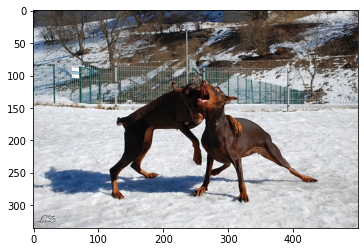

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman be run through the grass .
bleu score:  0.7825422900366437


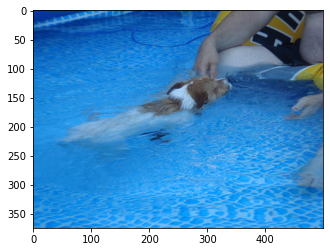

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy be jump into a pool .
bleu score:  0.32347562464306545


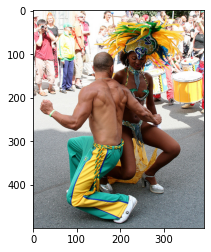

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


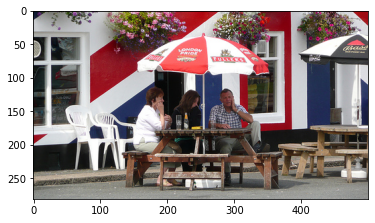

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a white shirt be jump in a park .
bleu score:  0.7736620501360001


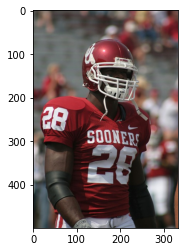

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]


Bleu score on Greedy search
Score:  0.4776410409015063


In [ ]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))

  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

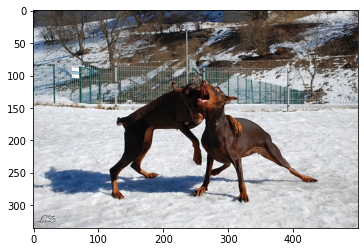

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A doberman jump in the snow .
bleu score:  0.41113361690051975


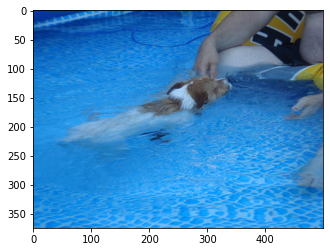

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be jump into a pool .
bleu score:  0.33584386823726153


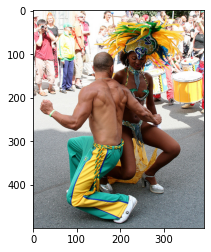

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A man in a red shirt be sit on a street .
bleu score:  0.6076795808137692


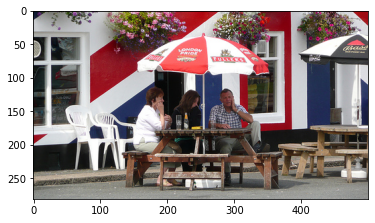

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a pink shirt be jump in a park .
bleu score:  0.7736620501360001


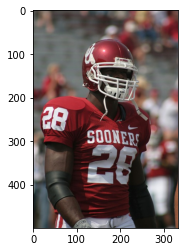

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red helmet .
bleu score:  0.8091067115702212


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)

100%|██████████| 1000/1000 [53:42<00:00,  3.22s/it]


Bleu score on Beam search with k=3
Score:  0.4930332459159616
